# Kaggle 30 Days of Machine Learning - Competition

## Introduction

### Author Info

- Author: [Zacks Shen](https://www.linkedin.com/in/zacks-shen/)
- Blog: [Zacks.One](https://zacks.one)

---

### Reference

> [A Brief Overview of Outlier Detection Techniques](https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561)

---

### Project Intro

For this competition, you will be predicting a continuous `target` based on a number of feature columns given in the data. All of the feature columns, `cat0` - `cat9` are categorical, and the feature columns `cont0` - `cont13` are continuous.

**Files**
- **train.csv** - the training data with the `target` column
- **test.csv** - the test set; you will be predicting the `target` for each row in this file
- **sample_submission.csv** - a sample submission file in the correct format

---

# Dependencies

In [1]:
# Statistics
import pandas as pd
import numpy as np
import math as mt

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data Preprocessing - Standardization, Encoding, Imputation
from sklearn.preprocessing import StandardScaler # Standardization
from sklearn.preprocessing import Normalizer # Normalization
from sklearn.preprocessing import OneHotEncoder # One-hot Encoding
from sklearn.preprocessing import OrdinalEncoder # Ordinal Encoding
from category_encoders import MEstimateEncoder # Target Encoding
from sklearn.preprocessing import PolynomialFeatures # Create Polynomial Features
from sklearn.impute import SimpleImputer # Imputation

# Exploratory Data Analysis - Feature Engineering
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA

# Modeling - ML Pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Modeling - Algorithms
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# ML - Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# ML - Tuning
import optuna
#from sklearn.model_selection import GridSearchCV

# Settings
# Settings for Seaborn
sns.set_theme(context='notebook', style='ticks', palette="bwr_r", font_scale=0.7, rc={"figure.dpi":240, 'savefig.dpi':240})

---

# Dataset

In [2]:
import os
kaggle_project = '30-days-of-ml'
# Import dataset from local directory './data' or from Kaggle
data_dir = ('./data' if os.path.exists('data') else f'/kaggle/input/{kaggle_project}')

# print all files in data_dir
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/.DS_Store
./data/kaggle-30days-of-ml.zip
./data/test.csv
./data/train_folds.csv
./data/train.csv
./data/sample_submission.csv
./data/kaggle-30days-of-ml/.DS_Store
./data/kaggle-30days-of-ml/full_dataset/lightgbm_1_valid_pred.csv
./data/kaggle-30days-of-ml/full_dataset/lightgbm_2_test_pred.csv
./data/kaggle-30days-of-ml/full_dataset/xgboost_4_valid_pred.csv
./data/kaggle-30days-of-ml/full_dataset/xgboost_3_valid_pred.csv
./data/kaggle-30days-of-ml/full_dataset/xgboost_2_valid_pred.csv
./data/kaggle-30days-of-ml/full_dataset/lightgbm_1_test_pred.csv
./data/kaggle-30days-of-ml/full_dataset/lightgbm_0_valid_pred.csv
./data/kaggle-30days-of-ml/full_dataset/lightgbm_2_valid_pred.csv
./data/kaggle-30days-of-ml/full_dataset/xgboost_2_test_pred.csv
./data/kaggle-30days-of-ml/full_dataset/xgboost_0_valid_pred.csv
./data/kaggle-30days-of-ml/full_dataset/lightgbm_4_valid_pred.csv
./data/kaggle-30days-of-ml/full_dataset/xgboost_1_valid_pred.csv
./data/kaggle-30days-of-ml/full_dataset/lightgb

In [3]:
train_data = pd.read_csv(f'{data_dir}/train.csv')
test_data = pd.read_csv(f'{data_dir}/test.csv')

train_data.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,B,B,B,C,B,B,A,E,C,...,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,2,B,B,A,A,B,D,A,F,A,...,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,3,A,A,A,C,B,D,A,D,A,...,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,4,B,B,A,C,B,D,A,E,C,...,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,6,A,A,A,C,B,D,A,E,A,...,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


---

# Exploratory Data Analysis

## Missing Values

Since the train dataset does not have any missing value, there is not necessary for data imputation.

In [6]:
# print number missing values from train_data and test_data
train_data.isna().sum().sum(), test_data.isna().sum().sum()

(0, 0)

---

## Target Distribution

99.82% target data is located in 6.5 to 10.5.

Text(0.5, 1.0, 'Distribution of All Targets')

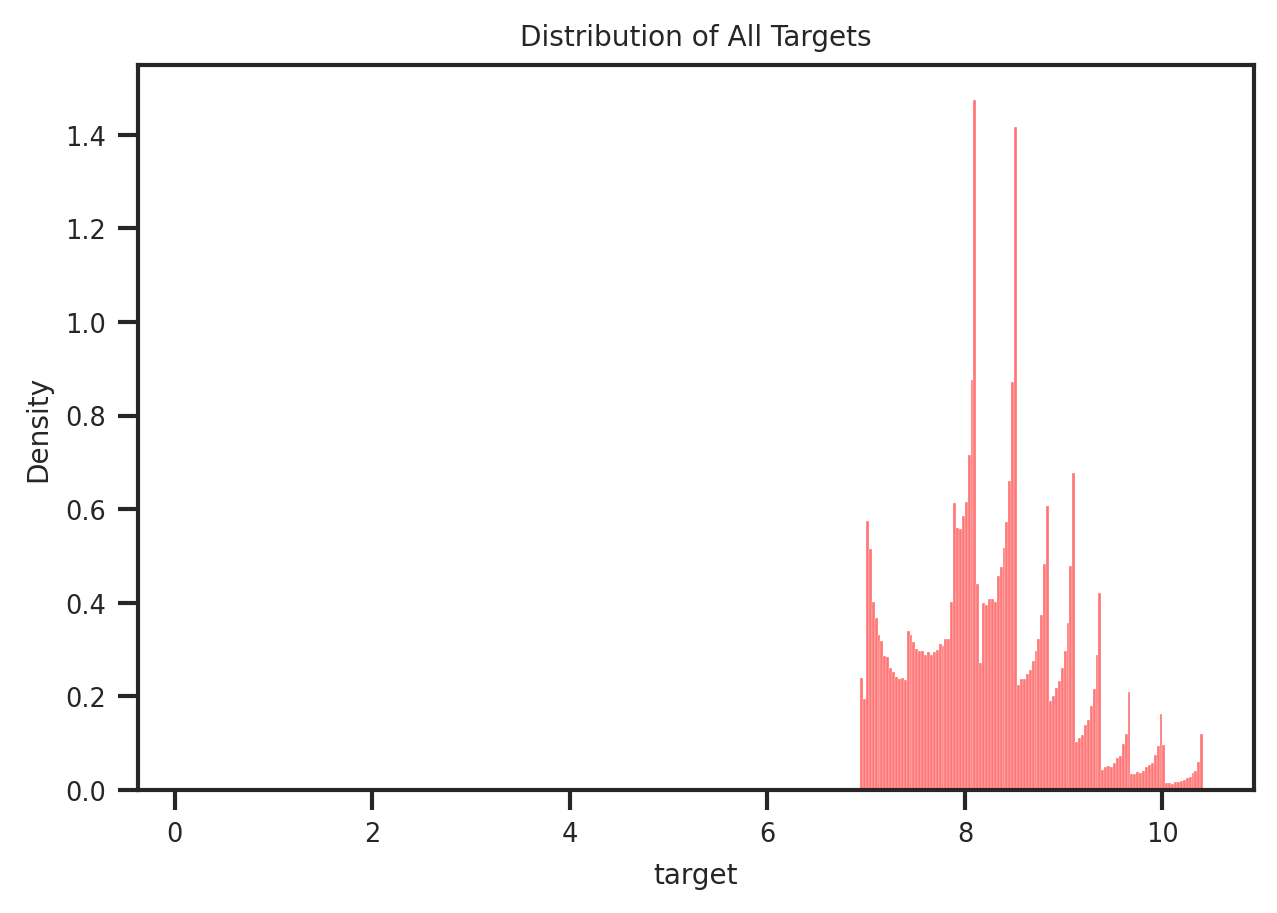

In [7]:
sns.histplot(x=train_data['target'], stat='density')
plt.title('Distribution of All Targets')

In [6]:
# Main target range
len(train_data[(6.5 <= train_data.target) & (train_data.target < 10.5)]) / len(train_data)

0.9982266666666667

---

## Numerical Data

Since all of the numerical data are in the same scale, there is no need for scaling.


**Conclusions**
- The numerical features are all non-parametric. Therefore, we should implement non-parametric outliers dectection.
- The distributions of numerical features from train and test dataset are similar.

In [4]:
# Define num_cols storing the columns names of numerical features
num_cols = list(train_data.select_dtypes(include=['int', 'float']).columns)
num_cols.remove('id')
num_cols.remove('target')
print(num_cols)

['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13']


In [8]:
train_data[num_cols].describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.527335,0.460926,0.490498,0.496689,0.491654,0.510526,0.467476,0.537119,0.498456,0.474872,0.474492,0.473216,0.494561,0.508273
std,0.230599,0.214003,0.253346,0.219199,0.240074,0.228232,0.210331,0.218140,0.239920,0.218007,0.255949,0.222022,0.247292,0.222950
min,-0.118039,-0.069309,-0.056104,0.130676,0.255908,0.045915,-0.224689,0.203763,-0.260275,0.117896,0.048732,0.052608,-0.074208,0.151050
25%,0.405965,0.310494,0.300604,0.329783,0.284188,0.354141,0.342873,0.355825,0.332486,0.306874,0.276017,0.308151,0.289074,0.300669
50%,0.497053,0.427903,0.502462,0.465026,0.390470,0.488865,0.429383,0.504661,0.439151,0.434620,0.459975,0.433812,0.422887,0.472400
75%,0.668060,0.615113,0.647512,0.664451,0.696599,0.669625,0.573383,0.703441,0.606056,0.614333,0.691579,0.642057,0.714502,0.758447
max,1.058443,0.887253,1.034704,1.039560,1.055424,1.067649,1.111552,1.032837,1.040229,0.982922,1.055960,1.071444,0.975035,0.905992


In [9]:
test_data[num_cols].describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.526858,0.460882,0.491686,0.496263,0.492200,0.509944,0.468050,0.537617,0.497587,0.474630,0.473625,0.473589,0.492756,0.508303
std,0.230506,0.213896,0.252852,0.219304,0.240251,0.228100,0.210167,0.218197,0.239337,0.217558,0.255307,0.221844,0.247105,0.222977
min,-0.117993,-0.069316,-0.056095,0.130655,0.255903,0.045921,-0.224613,0.203763,-0.260236,0.117894,0.048734,0.052615,-0.074201,0.151052
25%,0.405787,0.310536,0.302189,0.328865,0.284188,0.353682,0.342813,0.356482,0.332762,0.306940,0.274991,0.308495,0.288094,0.300697
50%,0.496602,0.427656,0.503075,0.464590,0.395080,0.488378,0.429819,0.505216,0.438716,0.434610,0.460042,0.433857,0.422065,0.472446
75%,0.666389,0.615041,0.648234,0.663401,0.697252,0.668586,0.573861,0.703289,0.605368,0.610768,0.690143,0.642201,0.711038,0.758496
max,1.058434,0.887253,1.034687,1.039558,1.055423,1.067641,1.111540,1.032823,1.040208,0.982928,1.055955,1.071445,0.975032,0.906013


In [ ]:
def plots(plot, features, train=None, test=None, target=None, ncols=4, figsize=(20, 16), **params):
    """Recieves an Seaborn method and one or two Pandas DataFrames, then returns subplots.
    
    Args:
        plot: A Seaborn instance.
        features: A set of Pandas DataFrame columns.
        train: Train dataset.
        test: Test dataset.
        target: The target, default is None.
        ncols: Number of figures in a row, default is 4.
        figsize: Figure Size, default is (20, 10).
    
    **kwargs:
        params: The parameters for Seaborn instance.
    
    Returns:
        The matplotlib.pyplot.subplots instance.
    """
    # Set row, col, and figure id
    nfigs = len(features)
    nrows = mt.ceil(nfigs/ncols)  # number of rows
    fig_id = 1  # initialize plot counter

    fig = plt.figure(figsize=figsize)
    for feature in features:
        plt.subplot(nrows, ncols, fig_id)
        if isinstance(train, pd.DataFrame):
            plot(data=train, x=feature, y=target, label='train', 
                 **params)
        if isinstance(test, pd.DataFrame):  
            plot(data=test, x=feature, label='test', # Test dataset doesn't have target
                 **params)
            plt.legend() # Force legend
        fig_id += 1
    plt.show()

In [ ]:
%%time
# Density plots of train and test
plots(plot=sns.kdeplot, train=train_data, test=test_data, features=num_cols)

In [ ]:
%%time
# Scattor plots of train
plots(plot=sns.scatterplot, train=train_data, features=num_cols, target='target')

In [ ]:
print("Correlation with target:\n")
pd.DataFrame(train_data[num_cols].corrwith(train_data.target), columns=['Correlation Coefficient']).style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

---

## Categorical Data

Due to the imbalanced distribution of categorical features, it is worth to implement target encoding.

In [5]:
# Define Categorical Columns
cat_cols = list(train_data.select_dtypes(include=['object']).columns)
print(cat_cols)

['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']


In [10]:
%%time
# Countplots of train and test
plots(plot=sns.countplot, train=train_data, test=test_data, features=cat_cols)

NameError: name 'plots' is not defined

In [ ]:
%%time
# Violinplot of train
plots(plot=sns.violinplot, train=train_data, features=cat_cols, target='target')

---

## Outliers

In [16]:
def detect_outliers(data_frame, features):
    df = data_frame.copy()
    for feature in features:
        Q1, Q3 = df[feature].quantile(0.25), df[feature].quantile(0.75)
        IQR = Q3 - Q1
        min_value, max_value = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        filter1, filter2 = min_value <= df[feature], df[feature] <= max_value
        proportion = 1- len(df[filter1 & filter2]) / len(df)
        print(f"{feature}'s outliers proportion: {proportion}")

detect_outliers(train_data, num_cols)

cont0's outliers proportion: 0.014933333333333354
cont1's outliers proportion: 0.0
cont2's outliers proportion: 0.0
cont3's outliers proportion: 0.0
cont4's outliers proportion: 0.0
cont5's outliers proportion: 0.0
cont6's outliers proportion: 0.05541666666666667
cont7's outliers proportion: 0.0
cont8's outliers proportion: 0.044996666666666685
cont9's outliers proportion: 0.0
cont10's outliers proportion: 0.0
cont11's outliers proportion: 0.0
cont12's outliers proportion: 0.0
cont13's outliers proportion: 0.0


In [17]:
def tukey_rule(data_frame, features):
    """Detect outliers for each feature according to Tukey's Rule.
    
    Args:
        data_frame: A Pandas DataFrame instance.
        features: A set of Pandas DataFrame columns.
    
    Returns:
        A Pandas DataFrame with no outliers.
    """
    df = data_frame.copy()
    for feature in features:
        Q1, Q3 = df[feature].quantile(0.25), df[feature].quantile(0.75)
        IQR = Q3 - Q1
        min_value, max_value = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        filter1, filter2 = min_value <= df[feature], df[feature] <= max_value
        df = df[filter1 & filter2] # Overwrite df to keep the index same.
    return df

In [18]:
df_train = tukey_rule(train_data[num_cols], num_cols)
df_train = df_train.join(train_data[['id'] + cat_cols + ['target']], how='inner') # Join the rest columns
df_train = df_train[train_data.columns] # Sort the columns

In [19]:
df_train.to_csv('df_train.csv', index=False)

---

# Feature Selection

The Goals of feature engineering:
- improve a model's predictive performance
- reduce computational or data needs
- improve interpretability of the results

The possible ways of feature engineering:
- Creating new features
- K-means clustering
- Pinciple Component Analysis

Metric of feature engineering:
- Mutual Information

---

## Mutual Information

In [ ]:
def make_mi_scores(X, y):
    X = X.copy()
    # Mutual Information required all data be integers
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize() # factorize() returns code and uniques
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [ ]:
%%time
X = df_train.copy()
X.drop(columns=['id'], inplace=True)
y = X.pop("target")

# Review the MI score from all data
all_mi_scores = pd.DataFrame(make_mi_scores(X, y))

all_mi_scores.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

---

### PCA

In [ ]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [ ]:
print("Correlation with target:\n")
pd.DataFrame(X.corrwith(y), columns=['Correlation Coefficient']).style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

In [ ]:
X = train_data.copy()
y = X.pop("target")

# `apply_pca`, defined above, reproduces the code from the tutorial
pca, X_pca, loadings = apply_pca(X[num_cols])
loadings

In [ ]:
plot_variance(pca);

In [ ]:
%%time
pca_mi_scores = pd.DataFrame(make_mi_scores(X_pca, y))
#pca_mi_scores = pd.DataFrame(mi_scores).style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

pca_mi_scores.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

In [ ]:
def test_pca(model, X):
    # Test PCA numberical data first
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                    random_state=0)

    # Fit the model
    model.fit(X_train, y_train)

    # Prediction
    pred = model.predict(X_valid)

    # Calculate RMSE
    return mt.sqrt(mean_squared_error(y_valid, pred))

In [ ]:
# Model hyperparameters
xgb_params = {'n_estimators': 1000,
              'learning_rate': 0.1,
              #'subsample': 0.8,
              'colsample_bytree': 0.3,
              'max_depth': 3,
              'booster': 'gbtree', 
              #'reg_lambda': 45.1,
              #'reg_alpha': 34.9,
              'random_state': 0,
              'n_jobs': 4}

model = XGBRegressor(**xgb_params, tree_method = 'gpu_hist')

In [ ]:
%%time

X = train_data.copy()
y = X.pop("target")

# numerical data only
# 0.7276467952234649
# 0.7228196639975967
#test_pca(model, X[num_cols])

# pca only
# 0.7456365639105215
# 0.7409662927889535
#test_pca(model, X_pca)

# pac (no 0 pc)
# 0.744166905080158
# 0.7413420081098745
#test_pca(model, X_pca[pca_mi_scores.iloc[0:12, :].index])

# numerical data + pca
# 0.727961200766366
# 0.7235085989402649
test_pca(model, X[num_cols].join(X_pca))

# numerical data + pca (no 0 pc)
# 0.7281481337015027
# 0.7234893735995077
# test_pca(model, X[num_cols].join(X_pca[pca_mi_scores.iloc[0:12, :].index]))

---

### K-means Clustering

---

## Data Engineering

---

### Data Pipline

In [10]:
X = df_train.copy()
X.drop(columns=['id'], inplace=True)
y = X.pop("target")

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
cat_cols_nunique = X[cat_cols].nunique()
onehot_cols = list(cat_cols_nunique[cat_cols_nunique < 10].keys())
ordinal_cols = list(cat_cols_nunique[cat_cols_nunique >= 10].keys())

# Keep selected columns only
# my_cols = list(num_cols) + list(onehot_cols)

assert len(num_cols)  + len(onehot_cols) + len(ordinal_cols) == X.shape[1], 'feature selection error'

In [11]:
def data_pipelie(num_cols, onehot_cols, ordinal_cols):    
    # Preprocessing for numerical data
    numerical_transformer = SimpleImputer(strategy='median')

    # Preprocessing of One Hot Encoding
    onehot_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Preprocessing of Ordnial Encoding
    ordinal_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder())
    ])

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, num_cols),
            ('onehot', onehot_transformer, onehot_cols),
            ('ordinal', ordinal_transformer, ordinal_cols)
        ])

    '''
    # Bundle preprocessing and modeling code in a pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])

    # Preprocessing of training data, fit model 
    clf.fit(X_train, y_train)

    # Preprocessing of validation data, get predictions
    preds = clf.predict(X_valid)
    '''
    return preprocessor

---

# Modeling

- Algorithms
    - XGBoost
    - LightGBM

## Training + Cross Validation

In [ ]:
def train(model, data_frame, num_cols, onehot_cols, ordinal_cols):
    """Return the average RMSE over 5 CV folds of selected model.
    """
    y = data_frame["target"]
    X = data_frame[num_cols + onehot_cols + ordinal_cols]

    # Define pipline
    preprocessor = data_pipelie(num_cols, onehot_cols, ordinal_cols)
    reg = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    # Define cross-validation
    scores = -1 * cross_val_score(reg, X, y,
                                  cv=5,
                                  scoring='neg_root_mean_squared_error')

    i = 0
    for score in scores:
        print(f'Fold {i}, RMSE: {score}')
        i += 1
    print(f'Average RMSE: {np.mean(scores)}')
    #return scores

In [ ]:
# Model hyperparameters
xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.1,
    #'subsample': 0.8,
    'colsample_bytree': 0.3,
    'max_depth': 3,
    'booster': 'gbtree', 
    #'reg_lambda': 45.1,
    #'reg_alpha': 34.9,
    'random_state': 0,
    'n_jobs': 4
}

model = XGBRegressor(
    **xgb_params,
    tree_method='gpu_hist', 
    gpu_id=0, 
    predictor='gpu_predictor'
)

In [ ]:
%%time
_one_hot_cols = list(set(onehot_cols) - {'cat2', 'cat4', 'cat6'})

train(model, df_train, num_cols, onehot_cols=_one_hot_cols, ordinal_cols=ordinal_cols)

In [ ]:
%%time
_one_hot_cols = list(set(onehot_cols) - {'cat2', 'cat4'})

train(model, df_train, num_cols, onehot_cols=_one_hot_cols, ordinal_cols=ordinal_cols)

In [ ]:
%%time
_one_hot_cols = list(set(onehot_cols) - {'cat2', 'cat4'})
_num_cols = list(set(num_cols) - {'cont13'})

train(model, df_train, num_cols=_num_cols, onehot_cols=_one_hot_cols, ordinal_cols=ordinal_cols)

---

## Hyperparameters Tuning

### Generate KFold datasets

In [11]:
df_train = pd.read_csv(f'data/train.csv')

# Mark the train dataset with kfold = 5
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, valid_idx) in enumerate(skf.split(X=df_train)):
    # For each loop, we only mark the valid data.
    # Therefore, after kfold loops, we have 5 different valid parts.\
    #print(len(valid_idx))
    df_train.loc[valid_idx, "kfold"] = fold
    
# Export train dataset with kfold mark
df_train.to_csv("train_folds.csv", index=False)

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

---

### Model tuning: Ordinal Encoding

In [42]:
def objective_oe(trial):
    """Modeling tuning.
    """
    # Select fold == 0 as valid dataset, others as train dataset.
    fold = 0
    df_train = pd.read_csv('data/train_folds.csv')
    X_train = df_train[df_train.kfold != fold].reset_index(drop=True)
    X_valid = df_train[df_train.kfold == fold].reset_index(drop=True)
    
    # Define dataset
    num_cols = ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13']
    onehot_cols = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8'] # remove 'cat2', 'cat4' due to the low MI scores
    ordinal_cols = ['cat9']
    cat_cols = onehot_cols + ordinal_cols
    
    y_train = X_train.pop('target')
    X_train = X_train[num_cols + onehot_cols + ordinal_cols]
    y_valid = X_valid.pop('target')
    X_valid = X_valid[num_cols + onehot_cols + ordinal_cols]
    
    # Preprocessing - Ordinal Encoding
    # For this dataset, One-hot encoding cause low accuracy and low performance.
    # Therefore, I implemented Ordinal Encoding for all categorical features.
    oe = OrdinalEncoder()
    X_train[cat_cols] = oe.fit_transform(X_train[cat_cols])
    X_valid[cat_cols] = oe.transform(X_valid[cat_cols])
    
    """
    # Hyperparameters for XGBoost
    xgb_params = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform("reg_lambda", 1e-8, 100.0),
        'reg_alpha': trial.suggest_loguniform("reg_alpha", 1e-8, 100.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.1, 1.0),
        'subsample': trial.suggest_float("subsample", 0.1, 1.0),
        'learning_rate': trial.suggest_float("learning_rate", 1e-2, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'max_depth': trial.suggest_int("max_depth", 1, 7),
        'random_state': trial.suggest_categorical('random_state', [0, 42, 2021]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)
    }
    
    model = XGBRegressor(
            tree_method='gpu_hist',
            gpu_id=0,
            predictor='gpu_predictor',
            **xgb_params)
    """

    # Hyperparameters for LightGBM
    lgb_params = {
        'random_state': trial.suggest_categorical('random_state', [0, 42, 2021]),
        'num_iterations': trial.suggest_int('num_iterations', 100, 10000),
        'learning_rate': trial.suggest_float("learning_rate", 1e-2, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 2000),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.01, 0.99),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.01, 0.99),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    model = LGBMRegressor(
                #device='gpu',
                #gpu_platform_id=0,
                #gpu_device_id=0,
                n_jobs=-1,
                metric='rmse',
                **lgb_params
    )
    
    model.fit(
        X_train, y_train, 
        early_stopping_rounds=300,
        eval_set=[(X_valid, y_valid)],
        verbose=5000
    )
    
    valid_preds = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, valid_preds, squared=False)
    return rmse

In [45]:
%%time
# lgb oe 200
study = optuna.create_study(direction='minimize')
study.optimize(objective_oe, n_trials=200, show_progress_bar=False) # set n_triasl

[I 2021-08-31 12:27:06,193] A new study created in memory with name: no-name-d7a19047-a110-44ce-9464-4c2854148575
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.21359225054004544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21359225054004544
[LightGBM] [Warning] bagging_fraction is set=0.8051318706696594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8051318706696594
[LightGBM] [Warning] lambda_l2 is set=8.381700771284474e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.381700771284474e-05
[LightGBM] [Warning] min_data_in_leaf is set=648, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=648
[LightGBM] [Warning] lambda_l1 is set=6.46108510323208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.46108510323208
Training until validation scores don't improve for 300 rounds


[I 2021-08-31 12:27:11,328] Trial 0 finished with value: 0.7360258734795377 and parameters: {'random_state': 2021, 'num_iterations': 872, 'learning_rate': 0.017391076605868732, 'max_depth': 1, 'num_leaves': 85, 'min_data_in_leaf': 648, 'lambda_l1': 6.46108510323208, 'lambda_l2': 8.381700771284474e-05, 'feature_fraction': 0.21359225054004544, 'bagging_fraction': 0.8051318706696594, 'bagging_freq': 1, 'min_child_samples': 30}. Best is trial 0 with value: 0.7360258734795377.


Did not meet early stopping. Best iteration is:
[872]	valid_0's rmse: 0.736026


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8787654486667968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8787654486667968
[LightGBM] [Warning] bagging_fraction is set=0.4885007592280415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4885007592280415
[LightGBM] [Warning] lambda_l2 is set=6.104527900999945e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.104527900999945e-07
[LightGBM] [Warning] min_data_in_leaf is set=1386, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=1386
[LightGBM] [Warning] lambda_l1 is set=2.8405499037463225e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8405499037463225e-05
Training until validation scores don't improve for 300 rounds


[I 2021-08-31 12:27:16,694] Trial 1 finished with value: 0.7204734453557484 and parameters: {'random_state': 42, 'num_iterations': 5927, 'learning_rate': 0.17667671804844887, 'max_depth': 5, 'num_leaves': 77, 'min_data_in_leaf': 1386, 'lambda_l1': 2.8405499037463225e-05, 'lambda_l2': 6.104527900999945e-07, 'feature_fraction': 0.8787654486667968, 'bagging_fraction': 0.4885007592280415, 'bagging_freq': 7, 'min_child_samples': 86}. Best is trial 1 with value: 0.7204734453557484.


Early stopping, best iteration is:
[437]	valid_0's rmse: 0.720473


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8294651171117174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8294651171117174
[LightGBM] [Warning] bagging_fraction is set=0.6807973906649448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6807973906649448
[LightGBM] [Warning] lambda_l2 is set=2.8210164853337422e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8210164853337422e-08
[LightGBM] [Warning] min_data_in_leaf is set=455, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=455
[LightGBM] [Warning] lambda_l1 is set=9.286595608637427e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.286595608637427e-07
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.728887
Did not meet early stopping. Best iteration is:
[6410]	valid_0's rmse: 0.728041


[I 2021-08-31 12:27:33,302] Trial 2 finished with value: 0.7280413770895688 and parameters: {'random_state': 42, 'num_iterations': 6410, 'learning_rate': 0.016829684536524735, 'max_depth': 1, 'num_leaves': 82, 'min_data_in_leaf': 455, 'lambda_l1': 9.286595608637427e-07, 'lambda_l2': 2.8210164853337422e-08, 'feature_fraction': 0.8294651171117174, 'bagging_fraction': 0.6807973906649448, 'bagging_freq': 5, 'min_child_samples': 47}. Best is trial 1 with value: 0.7204734453557484.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5747449273505475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5747449273505475
[LightGBM] [Warning] bagging_fraction is set=0.5060894570516826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5060894570516826
[LightGBM] [Warning] lambda_l2 is set=0.3203729103311611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3203729103311611
[LightGBM] [Warning] min_data_in_leaf is set=1640, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=1640
[LightGBM] [Warning] lambda_l1 is set=7.193496873248722e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.193496873248722e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[826]	valid_0's rmse: 0.719379


[I 2021-08-31 12:27:42,403] Trial 3 finished with value: 0.7193794705280128 and parameters: {'random_state': 42, 'num_iterations': 2170, 'learning_rate': 0.06977590211755913, 'max_depth': 6, 'num_leaves': 44, 'min_data_in_leaf': 1640, 'lambda_l1': 7.193496873248722e-05, 'lambda_l2': 0.3203729103311611, 'feature_fraction': 0.5747449273505475, 'bagging_fraction': 0.5060894570516826, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 3 with value: 0.7193794705280128.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7601675221925094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7601675221925094
[LightGBM] [Warning] bagging_fraction is set=0.6828697074326505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6828697074326505
[LightGBM] [Warning] lambda_l2 is set=0.4856531124133188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4856531124133188
[LightGBM] [Warning] min_data_in_leaf is set=1233, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=1233
[LightGBM] [Warning] lambda_l1 is set=0.0001418133916779453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001418133916779453
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[1458]	valid_0's rmse: 0.718714


[I 2021-08-31 12:28:00,963] Trial 4 finished with value: 0.7187143663146172 and parameters: {'random_state': 2021, 'num_iterations': 1570, 'learning_rate': 0.03223545376801738, 'max_depth': 7, 'num_leaves': 44, 'min_data_in_leaf': 1233, 'lambda_l1': 0.0001418133916779453, 'lambda_l2': 0.4856531124133188, 'feature_fraction': 0.7601675221925094, 'bagging_fraction': 0.6828697074326505, 'bagging_freq': 1, 'min_child_samples': 93}. Best is trial 4 with value: 0.7187143663146172.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7662441540176473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7662441540176473
[LightGBM] [Warning] bagging_fraction is set=0.9465538790820399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9465538790820399
[LightGBM] [Warning] lambda_l2 is set=0.0004955413508885782, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004955413508885782
[LightGBM] [Warning] min_data_in_leaf is set=1654, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=1654
[LightGBM] [Warning] lambda_l1 is set=3.208822452835554e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.208822452835554e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2495]	valid_0's rmse: 0.717912


[I 2021-08-31 12:28:21,730] Trial 5 finished with value: 0.7179123764039094 and parameters: {'random_state': 0, 'num_iterations': 7748, 'learning_rate': 0.04897209291604399, 'max_depth': 4, 'num_leaves': 56, 'min_data_in_leaf': 1654, 'lambda_l1': 3.208822452835554e-05, 'lambda_l2': 0.0004955413508885782, 'feature_fraction': 0.7662441540176473, 'bagging_fraction': 0.9465538790820399, 'bagging_freq': 5, 'min_child_samples': 65}. Best is trial 5 with value: 0.7179123764039094.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3396615642530867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3396615642530867
[LightGBM] [Warning] bagging_fraction is set=0.35455404092309445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35455404092309445
[LightGBM] [Warning] lambda_l2 is set=0.16507853950087434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16507853950087434
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] lambda_l1 is set=0.0003733245649040487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003733245649040487
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718248
Early stopping, best iteration is:
[5046]	valid_0's rmse: 0.718217


[I 2021-08-31 12:28:56,773] Trial 6 finished with value: 0.7182174550557169 and parameters: {'random_state': 2021, 'num_iterations': 8752, 'learning_rate': 0.02354926032123495, 'max_depth': 4, 'num_leaves': 59, 'min_data_in_leaf': 1100, 'lambda_l1': 0.0003733245649040487, 'lambda_l2': 0.16507853950087434, 'feature_fraction': 0.3396615642530867, 'bagging_fraction': 0.35455404092309445, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 5 with value: 0.7179123764039094.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.782481370015619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.782481370015619
[LightGBM] [Warning] bagging_fraction is set=0.24937536765679547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24937536765679547
[LightGBM] [Warning] lambda_l2 is set=1.031230574944461, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.031230574944461
[LightGBM] [Warning] min_data_in_leaf is set=408, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=408
[LightGBM] [Warning] lambda_l1 is set=2.3987626372607385e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3987626372607385e-06
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3049]	valid_0's rmse: 0.721356


[I 2021-08-31 12:29:02,774] Trial 7 finished with value: 0.7213564143342421 and parameters: {'random_state': 2021, 'num_iterations': 3106, 'learning_rate': 0.19251329602976197, 'max_depth': 1, 'num_leaves': 49, 'min_data_in_leaf': 408, 'lambda_l1': 2.3987626372607385e-06, 'lambda_l2': 1.031230574944461, 'feature_fraction': 0.782481370015619, 'bagging_fraction': 0.24937536765679547, 'bagging_freq': 5, 'min_child_samples': 94}. Best is trial 5 with value: 0.7179123764039094.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6379466463466966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6379466463466966
[LightGBM] [Warning] bagging_fraction is set=0.13322216802348646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.13322216802348646
[LightGBM] [Warning] lambda_l2 is set=0.0018557355245782253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018557355245782253
[LightGBM] [Warning] min_data_in_leaf is set=673, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=673
[LightGBM] [Warning] lambda_l1 is set=0.00011150715919411269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011150715919411269
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1057]	valid_0's rmse: 0.72139


[I 2021-08-31 12:29:10,449] Trial 8 finished with value: 0.7213899005285102 and parameters: {'random_state': 2021, 'num_iterations': 7149, 'learning_rate': 0.057054264451836006, 'max_depth': 5, 'num_leaves': 14, 'min_data_in_leaf': 673, 'lambda_l1': 0.00011150715919411269, 'lambda_l2': 0.0018557355245782253, 'feature_fraction': 0.6379466463466966, 'bagging_fraction': 0.13322216802348646, 'bagging_freq': 3, 'min_child_samples': 90}. Best is trial 5 with value: 0.7179123764039094.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.015901355995133388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.015901355995133388
[LightGBM] [Warning] bagging_fraction is set=0.8839635161655053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8839635161655053
[LightGBM] [Warning] lambda_l2 is set=0.0008066380285941329, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008066380285941329
[LightGBM] [Warning] min_data_in_leaf is set=860, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=860
[LightGBM] [Warning] lambda_l1 is set=4.782580800977069e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.782580800977069e-08
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[1653]	valid_0's rmse: 0.72529


[I 2021-08-31 12:29:20,953] Trial 9 finished with value: 0.7252898403047191 and parameters: {'random_state': 0, 'num_iterations': 1653, 'learning_rate': 0.015149172557740112, 'max_depth': 5, 'num_leaves': 13, 'min_data_in_leaf': 860, 'lambda_l1': 4.782580800977069e-08, 'lambda_l2': 0.0008066380285941329, 'feature_fraction': 0.015901355995133388, 'bagging_fraction': 0.8839635161655053, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 5 with value: 0.7179123764039094.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9560146435397852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9560146435397852
[LightGBM] [Warning] bagging_fraction is set=0.9639275427050265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9639275427050265
[LightGBM] [Warning] lambda_l2 is set=1.5522329700042317e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5522329700042317e-05
[LightGBM] [Warning] min_data_in_leaf is set=1970, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=1970
[LightGBM] [Warning] lambda_l1 is set=0.35676870776321146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35676870776321146
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2485]	valid_0's rmse: 0.717802


[I 2021-08-31 12:29:38,547] Trial 10 finished with value: 0.7178015213991376 and parameters: {'random_state': 0, 'num_iterations': 9868, 'learning_rate': 0.0859253013183797, 'max_depth': 3, 'num_leaves': 65, 'min_data_in_leaf': 1970, 'lambda_l1': 0.35676870776321146, 'lambda_l2': 1.5522329700042317e-05, 'feature_fraction': 0.9560146435397852, 'bagging_fraction': 0.9639275427050265, 'bagging_freq': 7, 'min_child_samples': 67}. Best is trial 10 with value: 0.7178015213991376.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9862195597291922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9862195597291922
[LightGBM] [Warning] bagging_fraction is set=0.9435697036803634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9435697036803634
[LightGBM] [Warning] lambda_l2 is set=4.087681018350322e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.087681018350322e-06
[LightGBM] [Warning] min_data_in_leaf is set=1997, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=1997
[LightGBM] [Warning] lambda_l1 is set=0.06415450471876619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06415450471876619
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2045]	valid_0's rmse: 0.717983


[I 2021-08-31 12:29:54,678] Trial 11 finished with value: 0.7179832231241073 and parameters: {'random_state': 0, 'num_iterations': 9508, 'learning_rate': 0.10372384486248745, 'max_depth': 3, 'num_leaves': 63, 'min_data_in_leaf': 1997, 'lambda_l1': 0.06415450471876619, 'lambda_l2': 4.087681018350322e-06, 'feature_fraction': 0.9862195597291922, 'bagging_fraction': 0.9435697036803634, 'bagging_freq': 7, 'min_child_samples': 64}. Best is trial 10 with value: 0.7178015213991376.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.658859948955731, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.658859948955731
[LightGBM] [Warning] bagging_fraction is set=0.9860791207381987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9860791207381987
[LightGBM] [Warning] lambda_l2 is set=2.6576101276861007e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6576101276861007e-05
[LightGBM] [Warning] min_data_in_leaf is set=1925, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=1925
[LightGBM] [Warning] lambda_l1 is set=0.013616160766058278, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013616160766058278
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717779
Early stopping, best iteration is:
[4895]	valid_0's rmse: 0.717759


[I 2021-08-31 12:30:25,040] Trial 12 finished with value: 0.7177589365462521 and parameters: {'random_state': 0, 'num_iterations': 8053, 'learning_rate': 0.039371775430338034, 'max_depth': 3, 'num_leaves': 99, 'min_data_in_leaf': 1925, 'lambda_l1': 0.013616160766058278, 'lambda_l2': 2.6576101276861007e-05, 'feature_fraction': 0.658859948955731, 'bagging_fraction': 0.9860791207381987, 'bagging_freq': 7, 'min_child_samples': 71}. Best is trial 12 with value: 0.7177589365462521.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4408934080451741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4408934080451741
[LightGBM] [Warning] bagging_fraction is set=0.7574971654409879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7574971654409879
[LightGBM] [Warning] lambda_l2 is set=1.54390412272157e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.54390412272157e-05
[LightGBM] [Warning] min_data_in_leaf is set=1965, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=1965
[LightGBM] [Warning] lambda_l1 is set=0.03650764063295269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03650764063295269
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2055]	valid_0's rmse: 0.717874


[I 2021-08-31 12:30:41,722] Trial 13 finished with value: 0.7178738738334226 and parameters: {'random_state': 0, 'num_iterations': 9939, 'learning_rate': 0.09924279305682106, 'max_depth': 3, 'num_leaves': 99, 'min_data_in_leaf': 1965, 'lambda_l1': 0.03650764063295269, 'lambda_l2': 1.54390412272157e-05, 'feature_fraction': 0.4408934080451741, 'bagging_fraction': 0.7574971654409879, 'bagging_freq': 7, 'min_child_samples': 76}. Best is trial 12 with value: 0.7177589365462521.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6227757501468896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6227757501468896
[LightGBM] [Warning] bagging_fraction is set=0.9853518223465538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9853518223465538
[LightGBM] [Warning] lambda_l2 is set=2.174298366056425e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.174298366056425e-07
[LightGBM] [Warning] min_data_in_leaf is set=1662, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=1662
[LightGBM] [Warning] lambda_l1 is set=0.03917281306161767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03917281306161767
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4064]	valid_0's rmse: 0.718053


[I 2021-08-31 12:31:15,134] Trial 14 finished with value: 0.7180531082940896 and parameters: {'random_state': 0, 'num_iterations': 4064, 'learning_rate': 0.03406491885538073, 'max_depth': 3, 'num_leaves': 99, 'min_data_in_leaf': 1662, 'lambda_l1': 0.03917281306161767, 'lambda_l2': 2.174298366056425e-07, 'feature_fraction': 0.6227757501468896, 'bagging_fraction': 0.9853518223465538, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 12 with value: 0.7177589365462521.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9844579460306842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9844579460306842
[LightGBM] [Warning] bagging_fraction is set=0.5410689290779319, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5410689290779319
[LightGBM] [Warning] lambda_l2 is set=0.005297582963644644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005297582963644644
[LightGBM] [Warning] min_data_in_leaf is set=1789, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=1789
[LightGBM] [Warning] lambda_l1 is set=1.6933689546371449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6933689546371449
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3549]	valid_0's rmse: 0.718322


[I 2021-08-31 12:31:29,137] Trial 15 finished with value: 0.7183223791040197 and parameters: {'random_state': 0, 'num_iterations': 8335, 'learning_rate': 0.11593791464581964, 'max_depth': 2, 'num_leaves': 30, 'min_data_in_leaf': 1789, 'lambda_l1': 1.6933689546371449, 'lambda_l2': 0.005297582963644644, 'feature_fraction': 0.9844579460306842, 'bagging_fraction': 0.5410689290779319, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 12 with value: 0.7177589365462521.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.45927212139383516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45927212139383516
[LightGBM] [Warning] bagging_fraction is set=0.8007059650590926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8007059650590926
[LightGBM] [Warning] lambda_l2 is set=2.070706924368084e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.070706924368084e-05
[LightGBM] [Warning] min_data_in_leaf is set=1408, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=1408
[LightGBM] [Warning] lambda_l1 is set=0.005106292030931134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005106292030931134
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1129]	valid_0's rmse: 0.718084


[I 2021-08-31 12:31:41,686] Trial 16 finished with value: 0.718084388339146 and parameters: {'random_state': 0, 'num_iterations': 5487, 'learning_rate': 0.28513955963611626, 'max_depth': 2, 'num_leaves': 75, 'min_data_in_leaf': 1408, 'lambda_l1': 0.005106292030931134, 'lambda_l2': 2.070706924368084e-05, 'feature_fraction': 0.45927212139383516, 'bagging_fraction': 0.8007059650590926, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 12 with value: 0.7177589365462521.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6946910191665638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6946910191665638
[LightGBM] [Warning] bagging_fraction is set=0.6547758086510912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6547758086510912
[LightGBM] [Warning] lambda_l2 is set=0.015309701629367236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015309701629367236
[LightGBM] [Warning] min_data_in_leaf is set=1407, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=1407
[LightGBM] [Warning] lambda_l1 is set=0.5398061382858516, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5398061382858516
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.724279
Did not meet early stopping. Best iteration is:
[8835]	valid_0's rmse: 0.721166


[I 2021-08-31 12:32:20,820] Trial 17 finished with value: 0.7211655285546316 and parameters: {'random_state': 0, 'num_iterations': 8835, 'learning_rate': 0.010104503262547047, 'max_depth': 2, 'num_leaves': 68, 'min_data_in_leaf': 1407, 'lambda_l1': 0.5398061382858516, 'lambda_l2': 0.015309701629367236, 'feature_fraction': 0.6946910191665638, 'bagging_fraction': 0.6547758086510912, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 12 with value: 0.7177589365462521.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8966919686543605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966919686543605
[LightGBM] [Warning] bagging_fraction is set=0.8758704334261628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8758704334261628
[LightGBM] [Warning] lambda_l2 is set=1.3136612262113207e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3136612262113207e-06
[LightGBM] [Warning] min_data_in_leaf is set=1803, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=1803
[LightGBM] [Warning] lambda_l1 is set=0.0032704650186733083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0032704650186733083
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717895
Early stopping, best iteration is:
[5036]	valid_0's rmse: 0.717881


[I 2021-08-31 12:32:50,566] Trial 18 finished with value: 0.7178806783472711 and parameters: {'random_state': 0, 'num_iterations': 7180, 'learning_rate': 0.03875859803459865, 'max_depth': 3, 'num_leaves': 32, 'min_data_in_leaf': 1803, 'lambda_l1': 0.0032704650186733083, 'lambda_l2': 1.3136612262113207e-06, 'feature_fraction': 0.8966919686543605, 'bagging_fraction': 0.8758704334261628, 'bagging_freq': 7, 'min_child_samples': 41}. Best is trial 12 with value: 0.7177589365462521.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.3594825143884158, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3594825143884158
[LightGBM] [Warning] bagging_fraction is set=0.39968897787391766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39968897787391766
[LightGBM] [Warning] lambda_l2 is set=1.188668346312054e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.188668346312054e-08
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] lambda_l1 is set=0.4793697586085683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4793697586085683
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1142]	valid_0's rmse: 0.71935


[I 2021-08-31 12:33:00,205] Trial 19 finished with value: 0.719349668140897 and parameters: {'random_state': 0, 'num_iterations': 4804, 'learning_rate': 0.07632744312341178, 'max_depth': 4, 'num_leaves': 91, 'min_data_in_leaf': 168, 'lambda_l1': 0.4793697586085683, 'lambda_l2': 1.188668346312054e-08, 'feature_fraction': 0.3594825143884158, 'bagging_fraction': 0.39968897787391766, 'bagging_freq': 4, 'min_child_samples': 68}. Best is trial 12 with value: 0.7177589365462521.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5586831854975176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5586831854975176
[LightGBM] [Warning] bagging_fraction is set=0.02761312808125782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.02761312808125782
[LightGBM] [Warning] lambda_l2 is set=8.544810902306714e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.544810902306714e-05
[LightGBM] [Warning] min_data_in_leaf is set=1526, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=1526
[LightGBM] [Warning] lambda_l1 is set=0.0026840967007590566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0026840967007590566
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4487]	valid_0's rmse: 0.728178


[I 2021-08-31 12:33:10,876] Trial 20 finished with value: 0.728177593335451 and parameters: {'random_state': 42, 'num_iterations': 9945, 'learning_rate': 0.025649972705019505, 'max_depth': 2, 'num_leaves': 3, 'min_data_in_leaf': 1526, 'lambda_l1': 0.0026840967007590566, 'lambda_l2': 8.544810902306714e-05, 'feature_fraction': 0.5586831854975176, 'bagging_fraction': 0.02761312808125782, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 12 with value: 0.7177589365462521.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.45690705963373346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45690705963373346
[LightGBM] [Warning] bagging_fraction is set=0.7891541442553169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7891541442553169
[LightGBM] [Warning] lambda_l2 is set=1.1410481944170077e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1410481944170077e-05
[LightGBM] [Warning] min_data_in_leaf is set=1995, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=1995
[LightGBM] [Warning] lambda_l1 is set=0.04503251311802335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04503251311802335
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1812]	valid_0's rmse: 0.717845


[I 2021-08-31 12:33:28,437] Trial 21 finished with value: 0.7178447772657106 and parameters: {'random_state': 0, 'num_iterations': 9759, 'learning_rate': 0.10750366418032781, 'max_depth': 3, 'num_leaves': 98, 'min_data_in_leaf': 1995, 'lambda_l1': 0.04503251311802335, 'lambda_l2': 1.1410481944170077e-05, 'feature_fraction': 0.45690705963373346, 'bagging_fraction': 0.7891541442553169, 'bagging_freq': 7, 'min_child_samples': 78}. Best is trial 12 with value: 0.7177589365462521.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.2228475869532215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2228475869532215
[LightGBM] [Warning] bagging_fraction is set=0.8525306429189736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8525306429189736
[LightGBM] [Warning] lambda_l2 is set=6.750426205092519e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.750426205092519e-06
[LightGBM] [Warning] min_data_in_leaf is set=1862, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=1862
[LightGBM] [Warning] lambda_l1 is set=0.2506927183038485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2506927183038485
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1014]	valid_0's rmse: 0.717467


[I 2021-08-31 12:33:41,745] Trial 22 finished with value: 0.71746698901709 and parameters: {'random_state': 0, 'num_iterations': 9029, 'learning_rate': 0.14368999331444682, 'max_depth': 4, 'num_leaves': 92, 'min_data_in_leaf': 1862, 'lambda_l1': 0.2506927183038485, 'lambda_l2': 6.750426205092519e-06, 'feature_fraction': 0.2228475869532215, 'bagging_fraction': 0.8525306429189736, 'bagging_freq': 7, 'min_child_samples': 81}. Best is trial 22 with value: 0.71746698901709.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.15159517648782506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15159517648782506
[LightGBM] [Warning] bagging_fraction is set=0.8831238907816007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8831238907816007
[LightGBM] [Warning] lambda_l2 is set=1.437259379114465e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.437259379114465e-07
[LightGBM] [Warning] min_data_in_leaf is set=1814, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=1814
[LightGBM] [Warning] lambda_l1 is set=0.3964364344082246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3964364344082246
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[620]	valid_0's rmse: 0.717731


[I 2021-08-31 12:33:48,894] Trial 23 finished with value: 0.7177313245032387 and parameters: {'random_state': 0, 'num_iterations': 8377, 'learning_rate': 0.16312220322015236, 'max_depth': 4, 'num_leaves': 89, 'min_data_in_leaf': 1814, 'lambda_l1': 0.3964364344082246, 'lambda_l2': 1.437259379114465e-07, 'feature_fraction': 0.15159517648782506, 'bagging_fraction': 0.8831238907816007, 'bagging_freq': 6, 'min_child_samples': 81}. Best is trial 22 with value: 0.71746698901709.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.11307294538111462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11307294538111462
[LightGBM] [Warning] bagging_fraction is set=0.8717456629235927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8717456629235927
[LightGBM] [Warning] lambda_l2 is set=2.370355664454817e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.370355664454817e-07
[LightGBM] [Warning] min_data_in_leaf is set=1773, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=1773
[LightGBM] [Warning] lambda_l1 is set=9.545202355642687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.545202355642687
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[588]	valid_0's rmse: 0.717938


[I 2021-08-31 12:33:57,684] Trial 24 finished with value: 0.7179382349658597 and parameters: {'random_state': 0, 'num_iterations': 7884, 'learning_rate': 0.16698059147523578, 'max_depth': 5, 'num_leaves': 90, 'min_data_in_leaf': 1773, 'lambda_l1': 9.545202355642687, 'lambda_l2': 2.370355664454817e-07, 'feature_fraction': 0.11307294538111462, 'bagging_fraction': 0.8717456629235927, 'bagging_freq': 6, 'min_child_samples': 84}. Best is trial 22 with value: 0.71746698901709.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2142466324840593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2142466324840593
[LightGBM] [Warning] bagging_fraction is set=0.6018790820238877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6018790820238877
[LightGBM] [Warning] lambda_l2 is set=1.0675640944853161e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0675640944853161e-07
[LightGBM] [Warning] min_data_in_leaf is set=1794, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=1794
[LightGBM] [Warning] lambda_l1 is set=0.00790166900803507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00790166900803507
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[334]	valid_0's rmse: 0.718779


[I 2021-08-31 12:34:03,299] Trial 25 finished with value: 0.7187790768694579 and parameters: {'random_state': 0, 'num_iterations': 6727, 'learning_rate': 0.2705807609766635, 'max_depth': 4, 'num_leaves': 87, 'min_data_in_leaf': 1794, 'lambda_l1': 0.00790166900803507, 'lambda_l2': 1.0675640944853161e-07, 'feature_fraction': 0.2142466324840593, 'bagging_fraction': 0.6018790820238877, 'bagging_freq': 6, 'min_child_samples': 81}. Best is trial 22 with value: 0.71746698901709.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.210544889092465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.210544889092465
[LightGBM] [Warning] bagging_fraction is set=0.7342518873615174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7342518873615174
[LightGBM] [Warning] lambda_l2 is set=1.914774579131462e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.914774579131462e-06
[LightGBM] [Warning] min_data_in_leaf is set=1552, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=1552
[LightGBM] [Warning] lambda_l1 is set=0.0008973878199094603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008973878199094603
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[409]	valid_0's rmse: 0.718233


[I 2021-08-31 12:34:11,117] Trial 26 finished with value: 0.7182332173018624 and parameters: {'random_state': 0, 'num_iterations': 8993, 'learning_rate': 0.14510772171252556, 'max_depth': 6, 'num_leaves': 74, 'min_data_in_leaf': 1552, 'lambda_l1': 0.0008973878199094603, 'lambda_l2': 1.914774579131462e-06, 'feature_fraction': 0.210544889092465, 'bagging_fraction': 0.7342518873615174, 'bagging_freq': 4, 'min_child_samples': 71}. Best is trial 22 with value: 0.71746698901709.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.3233245058936095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3233245058936095
[LightGBM] [Warning] bagging_fraction is set=0.8589217513755942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8589217513755942
[LightGBM] [Warning] lambda_l2 is set=6.591541475505995e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.591541475505995e-08
[LightGBM] [Warning] min_data_in_leaf is set=1166, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=1166
[LightGBM] [Warning] lambda_l1 is set=0.1925292803828196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1925292803828196
Training until validation scores don't improve for 300 rounds


[I 2021-08-31 12:34:17,808] Trial 27 finished with value: 0.7197365495375811 and parameters: {'random_state': 0, 'num_iterations': 7911, 'learning_rate': 0.2255780906115769, 'max_depth': 6, 'num_leaves': 93, 'min_data_in_leaf': 1166, 'lambda_l1': 0.1925292803828196, 'lambda_l2': 6.591541475505995e-08, 'feature_fraction': 0.3233245058936095, 'bagging_fraction': 0.8589217513755942, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 22 with value: 0.71746698901709.


Early stopping, best iteration is:
[211]	valid_0's rmse: 0.719737


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.08797504384403436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08797504384403436
[LightGBM] [Warning] bagging_fraction is set=0.8590087795130519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8590087795130519
[LightGBM] [Warning] lambda_l2 is set=8.842015542813604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.842015542813604
[LightGBM] [Warning] min_data_in_leaf is set=1875, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=1875
[LightGBM] [Warning] lambda_l1 is set=2.7591220270263457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7591220270263457
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1280]	valid_0's rmse: 0.717214


[I 2021-08-31 12:34:30,835] Trial 28 finished with value: 0.71721584240068 and parameters: {'random_state': 0, 'num_iterations': 4643, 'learning_rate': 0.130066266831861, 'max_depth': 4, 'num_leaves': 81, 'min_data_in_leaf': 1875, 'lambda_l1': 2.7591220270263457, 'lambda_l2': 8.842015542813604, 'feature_fraction': 0.08797504384403436, 'bagging_fraction': 0.8590087795130519, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 28 with value: 0.71721584240068.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.0312711649405648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0312711649405648
[LightGBM] [Warning] bagging_fraction is set=0.5972738359333238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5972738359333238
[LightGBM] [Warning] lambda_l2 is set=5.6815744480484005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6815744480484005
[LightGBM] [Warning] min_data_in_leaf is set=895, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=895
[LightGBM] [Warning] lambda_l1 is set=1.179877397817905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.179877397817905
Training until validation scores don't improve for 300 rounds


KeyboardInterrupt: 

In [46]:
study.best_params

{'random_state': 0,
 'num_iterations': 4643,
 'learning_rate': 0.130066266831861,
 'max_depth': 4,
 'num_leaves': 81,
 'min_data_in_leaf': 1875,
 'lambda_l1': 2.7591220270263457,
 'lambda_l2': 8.842015542813604,
 'feature_fraction': 0.08797504384403436,
 'bagging_fraction': 0.8590087795130519,
 'bagging_freq': 6,
 'min_child_samples': 60}

### Modeling tuning: Ordinal Encoding + One-hot Encoding

In [4]:
def objective_ohe(trial):
    """Modeling tuning.
    """
    # Select fold == 0 as valid dataset, others as train dataset.
    fold = 0
    df_train = pd.read_csv('data/train_folds.csv')
    X_train = df_train[df_train.kfold != fold].reset_index(drop=True)
    X_valid = df_train[df_train.kfold == fold].reset_index(drop=True)
    
    # Define dataset
    num_cols = ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13']
    onehot_cols = ['cat0', 'cat1', 'cat3', 'cat5', 'cat6', 'cat7', 'cat8'] # remove 'cat2', 'cat4' due to the low MI scores
    ordinal_cols = ['cat9']
    cat_cols = onehot_cols + ordinal_cols
    
    y_train = X_train.pop('target')
    X_train = X_train[num_cols + onehot_cols + ordinal_cols]
    y_valid = X_valid.pop('target')
    X_valid = X_valid[num_cols + onehot_cols + ordinal_cols]
    
    # Preprocessing - Ordinal Encoding
    oe = OrdinalEncoder()
    X_train[ordinal_cols] = oe.fit_transform(X_train[ordinal_cols])
    X_valid[ordinal_cols] = oe.transform(X_valid[ordinal_cols])
    
    # Preprocessing - One-hot Encoding
    ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
    X_train_ohe = ohe.fit_transform(X_train[onehot_cols])
    X_valid_ohe = ohe.transform(X_valid[onehot_cols])
    #X_test_ohe = ohe.transform(X_test[onehot_cols]) # Q. The last transform
    
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=[f"ohe_{i}" for i in range(X_train_ohe.shape[1])])
    X_valid_ohe = pd.DataFrame(X_valid_ohe, columns=[f"ohe_{i}" for i in range(X_valid_ohe.shape[1])])
    #X_test_ohe = pd.DataFrame(X_test_ohe, columns=[f"ohe_{i}" for i in range(X_test_ohe.shape[1])])
    
    X_train = pd.concat([X_train.drop(columns=onehot_cols), X_train_ohe], axis=1)
    X_valid = pd.concat([X_valid.drop(columns=onehot_cols), X_valid_ohe], axis=1)
    #X_test = pd.concat([X_test.drop(columns=onehot_cols), X_test_ohe], axis=1)

    """
    # Hyperparameters for XGBoost
    xgb_params = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform("reg_lambda", 1e-8, 100.0),
        'reg_alpha': trial.suggest_loguniform("reg_alpha", 1e-8, 100.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.1, 1.0),
        'subsample': trial.suggest_float("subsample", 0.1, 1.0),
        'learning_rate': trial.suggest_float("learning_rate", 1e-2, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'max_depth': trial.suggest_int("max_depth", 1, 7),
        'random_state': trial.suggest_categorical('random_state', [0, 42, 2021]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)
    }
    
    model = XGBRegressor(
            tree_method='gpu_hist',
            gpu_id=0,
            predictor='gpu_predictor',
            **xgb_params)
    """

    # Hyperparameters for LightGBM
    lgb_params = {
        'random_state': trial.suggest_categorical('random_state', [0, 42, 2021]),
        'num_iterations': trial.suggest_int('num_iterations', 100, 10000),
        'learning_rate': trial.suggest_float("learning_rate", 1e-2, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 2000),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.01, 0.99),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.01, 0.99),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    model = LGBMRegressor(
                #device='gpu',
                #gpu_platform_id=0,
                #gpu_device_id=0,
                n_jobs=-1,
                metric='rmse',
                **lgb_params
    )
    
    model.fit(
        X_train, y_train, 
        early_stopping_rounds=300,
        eval_set=[(X_valid, y_valid)],
        verbose=5000
    )
    
    valid_preds = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, valid_preds, squared=False)
    return rmse

In [5]:
%%time
# lgb ohe 200
study = optuna.create_study(direction='minimize')
study.optimize(objective_ohe, n_trials=200) # set n_triasl

[I 2021-08-30 18:57:49,394] A new study created in memory with name: no-name-8839ca3b-ee0f-4435-94b6-e0faad65bae4
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6103570682750526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6103570682750526
[LightGBM] [Warning] bagging_fraction is set=0.5034185199710206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5034185199710206
[LightGBM] [Warning] lambda_l2 is set=1.9234078203265325e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9234078203265325e-06
[LightGBM] [Warning] min_data_in_leaf is set=1318, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=1318
[LightGBM] [Warning] lambda_l1 is set=5.506735934164316e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.506735934164316e-05
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[930]	valid_0's rmse: 0.718743


[I 2021-08-30 18:57:55,640] Trial 0 finished with value: 0.7187429987322616 and parameters: {'random_state': 0, 'num_iterations': 936, 'learning_rate': 0.08858417982163685, 'max_depth': 4, 'num_leaves': 79, 'min_data_in_leaf': 1318, 'lambda_l1': 5.506735934164316e-05, 'lambda_l2': 1.9234078203265325e-06, 'feature_fraction': 0.6103570682750526, 'bagging_fraction': 0.5034185199710206, 'bagging_freq': 1, 'min_child_samples': 49}. Best is trial 0 with value: 0.7187429987322616.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.24093218694716187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24093218694716187
[LightGBM] [Warning] bagging_fraction is set=0.5402600625655269, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5402600625655269
[LightGBM] [Warning] lambda_l2 is set=0.0004876387435843833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004876387435843833
[LightGBM] [Warning] min_data_in_leaf is set=807, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=807
[LightGBM] [Warning] lambda_l1 is set=5.548792628097576e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.548792628097576e-06
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[957]	valid_0's rmse: 0.718083


[I 2021-08-30 18:58:02,524] Trial 1 finished with value: 0.7180825573630423 and parameters: {'random_state': 2021, 'num_iterations': 6606, 'learning_rate': 0.17360107569762231, 'max_depth': 3, 'num_leaves': 62, 'min_data_in_leaf': 807, 'lambda_l1': 5.548792628097576e-06, 'lambda_l2': 0.0004876387435843833, 'feature_fraction': 0.24093218694716187, 'bagging_fraction': 0.5402600625655269, 'bagging_freq': 4, 'min_child_samples': 89}. Best is trial 1 with value: 0.7180825573630423.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4208656126689049, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4208656126689049
[LightGBM] [Warning] bagging_fraction is set=0.8964486188834834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8964486188834834
[LightGBM] [Warning] lambda_l2 is set=9.925673143863391e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.925673143863391e-08
[LightGBM] [Warning] min_data_in_leaf is set=1692, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=1692
[LightGBM] [Warning] lambda_l1 is set=1.5312836171060007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5312836171060007
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718464
Did not meet early stopping. Best iteration is:
[8197]	valid_0's rmse: 0.717664


[I 2021-08-30 18:58:59,220] Trial 2 finished with value: 0.7176639042079289 and parameters: {'random_state': 0, 'num_iterations': 8204, 'learning_rate': 0.01279665184327557, 'max_depth': 4, 'num_leaves': 60, 'min_data_in_leaf': 1692, 'lambda_l1': 1.5312836171060007, 'lambda_l2': 9.925673143863391e-08, 'feature_fraction': 0.4208656126689049, 'bagging_fraction': 0.8964486188834834, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 2 with value: 0.7176639042079289.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8562893814268785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8562893814268785
[LightGBM] [Warning] bagging_fraction is set=0.9349509653063924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9349509653063924
[LightGBM] [Warning] lambda_l2 is set=0.003185213872142327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003185213872142327
[LightGBM] [Warning] min_data_in_leaf is set=1621, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=1621
[LightGBM] [Warning] lambda_l1 is set=0.23922366485674265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23922366485674265
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718269
Early stopping, best iteration is:
[5550]	valid_0's rmse: 0.718113


[I 2021-08-30 18:59:37,837] Trial 3 finished with value: 0.7181130456777084 and parameters: {'random_state': 0, 'num_iterations': 7419, 'learning_rate': 0.01843891667983081, 'max_depth': 4, 'num_leaves': 100, 'min_data_in_leaf': 1621, 'lambda_l1': 0.23922366485674265, 'lambda_l2': 0.003185213872142327, 'feature_fraction': 0.8562893814268785, 'bagging_fraction': 0.9349509653063924, 'bagging_freq': 3, 'min_child_samples': 93}. Best is trial 2 with value: 0.7176639042079289.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.060713716369586446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.060713716369586446
[LightGBM] [Warning] bagging_fraction is set=0.5614096603268757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5614096603268757
[LightGBM] [Warning] lambda_l2 is set=2.8478245888128364e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8478245888128364e-05
[LightGBM] [Warning] min_data_in_leaf is set=998, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=998
[LightGBM] [Warning] lambda_l1 is set=1.4005726468125972e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4005726468125972e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3600]	valid_0's rmse: 0.717613


[I 2021-08-30 18:59:55,583] Trial 4 finished with value: 0.7176128155328301 and parameters: {'random_state': 2021, 'num_iterations': 4968, 'learning_rate': 0.055332392092037566, 'max_depth': 4, 'num_leaves': 74, 'min_data_in_leaf': 998, 'lambda_l1': 1.4005726468125972e-08, 'lambda_l2': 2.8478245888128364e-05, 'feature_fraction': 0.060713716369586446, 'bagging_fraction': 0.5614096603268757, 'bagging_freq': 5, 'min_child_samples': 83}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.49726187143320427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49726187143320427
[LightGBM] [Warning] bagging_fraction is set=0.7056135135325416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7056135135325416
[LightGBM] [Warning] lambda_l2 is set=1.4803400282706696e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4803400282706696e-08
[LightGBM] [Warning] min_data_in_leaf is set=206, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=206
[LightGBM] [Warning] lambda_l1 is set=0.0033995697311129973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0033995697311129973
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71865
Did not meet early stopping. Best iteration is:
[6511]	valid_0's rmse: 0.718049


[I 2021-08-30 19:00:29,277] Trial 5 finished with value: 0.7180492611823468 and parameters: {'random_state': 2021, 'num_iterations': 6511, 'learning_rate': 0.01806732466647939, 'max_depth': 3, 'num_leaves': 75, 'min_data_in_leaf': 206, 'lambda_l1': 0.0033995697311129973, 'lambda_l2': 1.4803400282706696e-08, 'feature_fraction': 0.49726187143320427, 'bagging_fraction': 0.7056135135325416, 'bagging_freq': 7, 'min_child_samples': 6}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5985820920553535, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5985820920553535
[LightGBM] [Warning] bagging_fraction is set=0.5622846858325747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5622846858325747
[LightGBM] [Warning] lambda_l2 is set=1.4180472957161873e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4180472957161873e-05
[LightGBM] [Warning] min_data_in_leaf is set=180, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=180
[LightGBM] [Warning] lambda_l1 is set=0.0012668493496701004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012668493496701004
Training until validation scores don't improve for 300 rounds


[I 2021-08-30 19:00:33,674] Trial 6 finished with value: 0.7233013539045381 and parameters: {'random_state': 2021, 'num_iterations': 200, 'learning_rate': 0.05712914123053633, 'max_depth': 6, 'num_leaves': 50, 'min_data_in_leaf': 180, 'lambda_l1': 0.0012668493496701004, 'lambda_l2': 1.4180472957161873e-05, 'feature_fraction': 0.5985820920553535, 'bagging_fraction': 0.5622846858325747, 'bagging_freq': 1, 'min_child_samples': 43}. Best is trial 4 with value: 0.7176128155328301.


Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 0.723301


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.23906733406850006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23906733406850006
[LightGBM] [Warning] bagging_fraction is set=0.6591061641788963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6591061641788963
[LightGBM] [Warning] lambda_l2 is set=1.9217051251913613, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9217051251913613
[LightGBM] [Warning] min_data_in_leaf is set=327, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=327
[LightGBM] [Warning] lambda_l1 is set=0.000463468794454827, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000463468794454827
Training until validation scores don't improve for 300 rounds


[I 2021-08-30 19:00:38,689] Trial 7 finished with value: 0.7191206442665355 and parameters: {'random_state': 0, 'num_iterations': 5505, 'learning_rate': 0.2777264581654213, 'max_depth': 5, 'num_leaves': 9, 'min_data_in_leaf': 327, 'lambda_l1': 0.000463468794454827, 'lambda_l2': 1.9217051251913613, 'feature_fraction': 0.23906733406850006, 'bagging_fraction': 0.6591061641788963, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 4 with value: 0.7176128155328301.


Early stopping, best iteration is:
[336]	valid_0's rmse: 0.719121


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.20755019851903592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20755019851903592
[LightGBM] [Warning] bagging_fraction is set=0.1902677720296568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1902677720296568
[LightGBM] [Warning] lambda_l2 is set=1.5462602668575024e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5462602668575024e-07
[LightGBM] [Warning] min_data_in_leaf is set=1172, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=1172
[LightGBM] [Warning] lambda_l1 is set=0.0005024824225883406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005024824225883406
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[618]	valid_0's rmse: 0.721651


[I 2021-08-30 19:00:43,003] Trial 8 finished with value: 0.7216506114940897 and parameters: {'random_state': 2021, 'num_iterations': 9282, 'learning_rate': 0.22304352921572243, 'max_depth': 3, 'num_leaves': 55, 'min_data_in_leaf': 1172, 'lambda_l1': 0.0005024824225883406, 'lambda_l2': 1.5462602668575024e-07, 'feature_fraction': 0.20755019851903592, 'bagging_fraction': 0.1902677720296568, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.49272396724919915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49272396724919915
[LightGBM] [Warning] bagging_fraction is set=0.45349590391052064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45349590391052064
[LightGBM] [Warning] lambda_l2 is set=7.335725413533336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.335725413533336
[LightGBM] [Warning] min_data_in_leaf is set=1359, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=1359
[LightGBM] [Warning] lambda_l1 is set=0.05113694183008965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05113694183008965
Training until validation scores don't improve for 300 rounds


[I 2021-08-30 19:00:47,593] Trial 9 finished with value: 0.7207253847001719 and parameters: {'random_state': 0, 'num_iterations': 9608, 'learning_rate': 0.24275520422850796, 'max_depth': 5, 'num_leaves': 54, 'min_data_in_leaf': 1359, 'lambda_l1': 0.05113694183008965, 'lambda_l2': 7.335725413533336, 'feature_fraction': 0.49272396724919915, 'bagging_fraction': 0.45349590391052064, 'bagging_freq': 4, 'min_child_samples': 16}. Best is trial 4 with value: 0.7176128155328301.


Early stopping, best iteration is:
[210]	valid_0's rmse: 0.720725


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.03602436254778781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03602436254778781
[LightGBM] [Warning] bagging_fraction is set=0.21789698662058354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21789698662058354
[LightGBM] [Warning] lambda_l2 is set=0.027870949990957985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.027870949990957985
[LightGBM] [Warning] min_data_in_leaf is set=752, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=752
[LightGBM] [Warning] lambda_l1 is set=1.453149912768869e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.453149912768869e-08
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3175]	valid_0's rmse: 0.731741


[I 2021-08-30 19:00:54,209] Trial 10 finished with value: 0.7317410933390125 and parameters: {'random_state': 42, 'num_iterations': 3176, 'learning_rate': 0.03645435346889873, 'max_depth': 1, 'num_leaves': 26, 'min_data_in_leaf': 752, 'lambda_l1': 1.453149912768869e-08, 'lambda_l2': 0.027870949990957985, 'feature_fraction': 0.03602436254778781, 'bagging_fraction': 0.21789698662058354, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.011005727772470553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.011005727772470553
[LightGBM] [Warning] bagging_fraction is set=0.9473304556198167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9473304556198167
[LightGBM] [Warning] lambda_l2 is set=1.4143821820207743e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4143821820207743e-05
[LightGBM] [Warning] min_data_in_leaf is set=1979, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=1979
[LightGBM] [Warning] lambda_l1 is set=3.393787944753257e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.393787944753257e-08
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3647]	valid_0's rmse: 0.722446


[I 2021-08-30 19:01:18,142] Trial 11 finished with value: 0.7224462900553701 and parameters: {'random_state': 42, 'num_iterations': 3647, 'learning_rate': 0.010060348301994896, 'max_depth': 7, 'num_leaves': 89, 'min_data_in_leaf': 1979, 'lambda_l1': 3.393787944753257e-08, 'lambda_l2': 1.4143821820207743e-05, 'feature_fraction': 0.011005727772470553, 'bagging_fraction': 0.9473304556198167, 'bagging_freq': 3, 'min_child_samples': 71}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8974078564236783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8974078564236783
[LightGBM] [Warning] bagging_fraction is set=0.8144389068619411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8144389068619411
[LightGBM] [Warning] lambda_l2 is set=6.530995373714973e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.530995373714973e-07
[LightGBM] [Warning] min_data_in_leaf is set=1713, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=1713
[LightGBM] [Warning] lambda_l1 is set=4.42852254897538, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.42852254897538
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4100]	valid_0's rmse: 0.723989


[I 2021-08-30 19:01:32,820] Trial 12 finished with value: 0.7239894545949469 and parameters: {'random_state': 2021, 'num_iterations': 4100, 'learning_rate': 0.09269520032454494, 'max_depth': 1, 'num_leaves': 35, 'min_data_in_leaf': 1713, 'lambda_l1': 4.42852254897538, 'lambda_l2': 6.530995373714973e-07, 'feature_fraction': 0.8974078564236783, 'bagging_fraction': 0.8144389068619411, 'bagging_freq': 3, 'min_child_samples': 70}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3608090505039853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3608090505039853
[LightGBM] [Warning] bagging_fraction is set=0.010848561396826217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.010848561396826217
[LightGBM] [Warning] lambda_l2 is set=1.0730809041210845e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0730809041210845e-08
[LightGBM] [Warning] min_data_in_leaf is set=884, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=884
[LightGBM] [Warning] lambda_l1 is set=1.1067976739111593e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1067976739111593e-06
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3659]	valid_0's rmse: 0.732911


[I 2021-08-30 19:01:40,348] Trial 13 finished with value: 0.7329109910492582 and parameters: {'random_state': 0, 'num_iterations': 8198, 'learning_rate': 0.03188142732101563, 'max_depth': 2, 'num_leaves': 76, 'min_data_in_leaf': 884, 'lambda_l1': 1.1067976739111593e-06, 'lambda_l2': 1.0730809041210845e-08, 'feature_fraction': 0.3608090505039853, 'bagging_fraction': 0.010848561396826217, 'bagging_freq': 5, 'min_child_samples': 79}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7380728468946918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7380728468946918
[LightGBM] [Warning] bagging_fraction is set=0.3035327172995666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3035327172995666
[LightGBM] [Warning] lambda_l2 is set=4.004726468354303e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.004726468354303e-05
[LightGBM] [Warning] min_data_in_leaf is set=525, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=525
[LightGBM] [Warning] lambda_l1 is set=5.227915491760787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.227915491760787
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[2297]	valid_0's rmse: 0.721393


[I 2021-08-30 19:01:55,364] Trial 14 finished with value: 0.7213934224941854 and parameters: {'random_state': 42, 'num_iterations': 2300, 'learning_rate': 0.010089287571833869, 'max_depth': 5, 'num_leaves': 36, 'min_data_in_leaf': 525, 'lambda_l1': 5.227915491760787, 'lambda_l2': 4.004726468354303e-05, 'feature_fraction': 0.7380728468946918, 'bagging_fraction': 0.3035327172995666, 'bagging_freq': 2, 'min_child_samples': 57}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3644023036995669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3644023036995669
[LightGBM] [Warning] bagging_fraction is set=0.7805960624093351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7805960624093351
[LightGBM] [Warning] lambda_l2 is set=1.424411088554639e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.424411088554639e-07
[LightGBM] [Warning] min_data_in_leaf is set=1573, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=1573
[LightGBM] [Warning] lambda_l1 is set=3.370340319322187e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.370340319322187e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[969]	valid_0's rmse: 0.718038


[I 2021-08-30 19:02:06,897] Trial 15 finished with value: 0.7180377786057318 and parameters: {'random_state': 2021, 'num_iterations': 5357, 'learning_rate': 0.06414216594237533, 'max_depth': 6, 'num_leaves': 69, 'min_data_in_leaf': 1573, 'lambda_l1': 3.370340319322187e-07, 'lambda_l2': 1.424411088554639e-07, 'feature_fraction': 0.3644023036995669, 'bagging_fraction': 0.7805960624093351, 'bagging_freq': 5, 'min_child_samples': 59}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3861603586222907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3861603586222907
[LightGBM] [Warning] bagging_fraction is set=0.34600743404803913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34600743404803913
[LightGBM] [Warning] lambda_l2 is set=0.06173801873200666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06173801873200666
[LightGBM] [Warning] min_data_in_leaf is set=1082, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=1082
[LightGBM] [Warning] lambda_l1 is set=0.05055015780846247, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05055015780846247
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3054]	valid_0's rmse: 0.718391


[I 2021-08-30 19:02:22,641] Trial 16 finished with value: 0.7183912192869722 and parameters: {'random_state': 0, 'num_iterations': 8374, 'learning_rate': 0.03283388717524578, 'max_depth': 4, 'num_leaves': 85, 'min_data_in_leaf': 1082, 'lambda_l1': 0.05055015780846247, 'lambda_l2': 0.06173801873200666, 'feature_fraction': 0.3861603586222907, 'bagging_fraction': 0.34600743404803913, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1324409083211045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1324409083211045
[LightGBM] [Warning] bagging_fraction is set=0.8432303293560997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8432303293560997
[LightGBM] [Warning] lambda_l2 is set=0.0002644563238513175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002644563238513175
[LightGBM] [Warning] min_data_in_leaf is set=1994, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=1994
[LightGBM] [Warning] lambda_l1 is set=2.674099306722447e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.674099306722447e-05
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4749]	valid_0's rmse: 0.721867


[I 2021-08-30 19:02:47,274] Trial 17 finished with value: 0.7218670002233402 and parameters: {'random_state': 2021, 'num_iterations': 4749, 'learning_rate': 0.019925191180742284, 'max_depth': 2, 'num_leaves': 42, 'min_data_in_leaf': 1994, 'lambda_l1': 2.674099306722447e-05, 'lambda_l2': 0.0002644563238513175, 'feature_fraction': 0.1324409083211045, 'bagging_fraction': 0.8432303293560997, 'bagging_freq': 2, 'min_child_samples': 81}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9897104625600981, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9897104625600981
[LightGBM] [Warning] bagging_fraction is set=0.6595353356131584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6595353356131584
[LightGBM] [Warning] lambda_l2 is set=1.2144689264122843e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2144689264122843e-06
[LightGBM] [Warning] min_data_in_leaf is set=590, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=590
[LightGBM] [Warning] lambda_l1 is set=0.5877196648614368, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5877196648614368
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[312]	valid_0's rmse: 0.720339


[I 2021-08-30 19:02:53,946] Trial 18 finished with value: 0.7203392262926722 and parameters: {'random_state': 0, 'num_iterations': 6384, 'learning_rate': 0.12659272749110426, 'max_depth': 6, 'num_leaves': 65, 'min_data_in_leaf': 590, 'lambda_l1': 0.5877196648614368, 'lambda_l2': 1.2144689264122843e-06, 'feature_fraction': 0.9897104625600981, 'bagging_fraction': 0.6595353356131584, 'bagging_freq': 4, 'min_child_samples': 63}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.1380274808813256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1380274808813256
[LightGBM] [Warning] bagging_fraction is set=0.9868418912233794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9868418912233794
[LightGBM] [Warning] lambda_l2 is set=8.681596415506412e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.681596415506412e-05
[LightGBM] [Warning] min_data_in_leaf is set=1397, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=1397
[LightGBM] [Warning] lambda_l1 is set=0.009320927475506172, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009320927475506172
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[2306]	valid_0's rmse: 0.721846


[I 2021-08-30 19:03:05,371] Trial 19 finished with value: 0.7218460622136577 and parameters: {'random_state': 42, 'num_iterations': 2306, 'learning_rate': 0.04256393203377407, 'max_depth': 2, 'num_leaves': 98, 'min_data_in_leaf': 1397, 'lambda_l1': 0.009320927475506172, 'lambda_l2': 8.681596415506412e-05, 'feature_fraction': 0.1380274808813256, 'bagging_fraction': 0.9868418912233794, 'bagging_freq': 7, 'min_child_samples': 83}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5941305688820308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5941305688820308
[LightGBM] [Warning] bagging_fraction is set=0.3911472885027422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3911472885027422
[LightGBM] [Warning] lambda_l2 is set=9.108661210057955e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.108661210057955e-08
[LightGBM] [Warning] min_data_in_leaf is set=985, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=985
[LightGBM] [Warning] lambda_l1 is set=1.2927913397893438e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2927913397893438e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3556]	valid_0's rmse: 0.718353


[I 2021-08-30 19:03:26,193] Trial 20 finished with value: 0.7183529376259036 and parameters: {'random_state': 2021, 'num_iterations': 7702, 'learning_rate': 0.02502150652237242, 'max_depth': 4, 'num_leaves': 18, 'min_data_in_leaf': 985, 'lambda_l1': 1.2927913397893438e-07, 'lambda_l2': 9.108661210057955e-08, 'feature_fraction': 0.5941305688820308, 'bagging_fraction': 0.3911472885027422, 'bagging_freq': 2, 'min_child_samples': 36}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.37045345191820933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37045345191820933
[LightGBM] [Warning] bagging_fraction is set=0.7950298598605995, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7950298598605995
[LightGBM] [Warning] lambda_l2 is set=1.1605460944184779e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1605460944184779e-07
[LightGBM] [Warning] min_data_in_leaf is set=1684, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=1684
[LightGBM] [Warning] lambda_l1 is set=2.676423955918213e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.676423955918213e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[857]	valid_0's rmse: 0.718215


[I 2021-08-30 19:03:38,468] Trial 21 finished with value: 0.718215140592949 and parameters: {'random_state': 2021, 'num_iterations': 5643, 'learning_rate': 0.06116576741038816, 'max_depth': 7, 'num_leaves': 65, 'min_data_in_leaf': 1684, 'lambda_l1': 2.676423955918213e-07, 'lambda_l2': 1.1605460944184779e-07, 'feature_fraction': 0.37045345191820933, 'bagging_fraction': 0.7950298598605995, 'bagging_freq': 5, 'min_child_samples': 58}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.30259846991486283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30259846991486283
[LightGBM] [Warning] bagging_fraction is set=0.7548953368103923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7548953368103923
[LightGBM] [Warning] lambda_l2 is set=4.7500524863013475e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7500524863013475e-06
[LightGBM] [Warning] min_data_in_leaf is set=1481, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=1481
[LightGBM] [Warning] lambda_l1 is set=9.961056265944735e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.961056265944735e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[911]	valid_0's rmse: 0.718164


[I 2021-08-30 19:03:49,806] Trial 22 finished with value: 0.7181643807379738 and parameters: {'random_state': 2021, 'num_iterations': 4992, 'learning_rate': 0.07777451640404366, 'max_depth': 6, 'num_leaves': 70, 'min_data_in_leaf': 1481, 'lambda_l1': 9.961056265944735e-07, 'lambda_l2': 4.7500524863013475e-06, 'feature_fraction': 0.30259846991486283, 'bagging_fraction': 0.7548953368103923, 'bagging_freq': 5, 'min_child_samples': 51}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4323808491024021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4323808491024021
[LightGBM] [Warning] bagging_fraction is set=0.6073671033367394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6073671033367394
[LightGBM] [Warning] lambda_l2 is set=3.5302632325392685e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5302632325392685e-07
[LightGBM] [Warning] min_data_in_leaf is set=1818, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=1818
[LightGBM] [Warning] lambda_l1 is set=1.1853583461336378e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1853583461336378e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2055]	valid_0's rmse: 0.7184


[I 2021-08-30 19:04:05,525] Trial 23 finished with value: 0.7184004912737932 and parameters: {'random_state': 2021, 'num_iterations': 2668, 'learning_rate': 0.04493291432038047, 'max_depth': 5, 'num_leaves': 86, 'min_data_in_leaf': 1818, 'lambda_l1': 1.1853583461336378e-08, 'lambda_l2': 3.5302632325392685e-07, 'feature_fraction': 0.4323808491024021, 'bagging_fraction': 0.6073671033367394, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.691316882095629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.691316882095629
[LightGBM] [Warning] bagging_fraction is set=0.8844457479586386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8844457479586386
[LightGBM] [Warning] lambda_l2 is set=5.021850497937578e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.021850497937578e-08
[LightGBM] [Warning] min_data_in_leaf is set=1522, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=1522
[LightGBM] [Warning] lambda_l1 is set=1.4033200896629208e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4033200896629208e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1326]	valid_0's rmse: 0.718119


[I 2021-08-30 19:04:15,766] Trial 24 finished with value: 0.7181187024939559 and parameters: {'random_state': 2021, 'num_iterations': 4320, 'learning_rate': 0.11711368698203016, 'max_depth': 3, 'num_leaves': 47, 'min_data_in_leaf': 1522, 'lambda_l1': 1.4033200896629208e-07, 'lambda_l2': 5.021850497937578e-08, 'feature_fraction': 0.691316882095629, 'bagging_fraction': 0.8844457479586386, 'bagging_freq': 3, 'min_child_samples': 76}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.11408559020789416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11408559020789416
[LightGBM] [Warning] bagging_fraction is set=0.7592760773000796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7592760773000796
[LightGBM] [Warning] lambda_l2 is set=4.420447922909766e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.420447922909766e-06
[LightGBM] [Warning] min_data_in_leaf is set=1108, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=1108
[LightGBM] [Warning] lambda_l1 is set=1.4979171841892165e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4979171841892165e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[988]	valid_0's rmse: 0.71788


[I 2021-08-30 19:04:25,961] Trial 25 finished with value: 0.71788008554791 and parameters: {'random_state': 0, 'num_iterations': 5710, 'learning_rate': 0.06753425131077433, 'max_depth': 6, 'num_leaves': 59, 'min_data_in_leaf': 1108, 'lambda_l1': 1.4979171841892165e-05, 'lambda_l2': 4.420447922909766e-06, 'feature_fraction': 0.11408559020789416, 'bagging_fraction': 0.7592760773000796, 'bagging_freq': 6, 'min_child_samples': 89}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.10481655438272228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10481655438272228
[LightGBM] [Warning] bagging_fraction is set=0.7166822075928378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7166822075928378
[LightGBM] [Warning] lambda_l2 is set=7.430224081318756e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.430224081318756e-06
[LightGBM] [Warning] min_data_in_leaf is set=1134, min_child_samples=99 will be ignored. Current value: min_data_in_leaf=1134
[LightGBM] [Warning] lambda_l1 is set=5.757728604895745e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.757728604895745e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[613]	valid_0's rmse: 0.718162


[I 2021-08-30 19:04:35,486] Trial 26 finished with value: 0.7181622424869479 and parameters: {'random_state': 0, 'num_iterations': 9000, 'learning_rate': 0.1422089846724769, 'max_depth': 5, 'num_leaves': 60, 'min_data_in_leaf': 1134, 'lambda_l1': 5.757728604895745e-05, 'lambda_l2': 7.430224081318756e-06, 'feature_fraction': 0.10481655438272228, 'bagging_fraction': 0.7166822075928378, 'bagging_freq': 6, 'min_child_samples': 99}. Best is trial 4 with value: 0.7176128155328301.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.07848210909001055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07848210909001055
[LightGBM] [Warning] bagging_fraction is set=0.8905724301378606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8905724301378606
[LightGBM] [Warning] lambda_l2 is set=0.0023448571411179334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023448571411179334
[LightGBM] [Warning] min_data_in_leaf is set=1279, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=1279
[LightGBM] [Warning] lambda_l1 is set=2.324083532893054e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.324083532893054e-06
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3466]	valid_0's rmse: 0.717042


[I 2021-08-30 19:05:08,929] Trial 27 finished with value: 0.7170420393353597 and parameters: {'random_state': 0, 'num_iterations': 6937, 'learning_rate': 0.04681129286870689, 'max_depth': 4, 'num_leaves': 58, 'min_data_in_leaf': 1279, 'lambda_l1': 2.324083532893054e-06, 'lambda_l2': 0.0023448571411179334, 'feature_fraction': 0.07848210909001055, 'bagging_fraction': 0.8905724301378606, 'bagging_freq': 7, 'min_child_samples': 91}. Best is trial 27 with value: 0.7170420393353597.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.19398478830668348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19398478830668348
[LightGBM] [Warning] bagging_fraction is set=0.896731153690991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.896731153690991
[LightGBM] [Warning] lambda_l2 is set=0.0032766574862870936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0032766574862870936
[LightGBM] [Warning] min_data_in_leaf is set=1296, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=1296
[LightGBM] [Warning] lambda_l1 is set=3.576699760734841e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.576699760734841e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717918
Did not meet early stopping. Best iteration is:
[7133]	valid_0's rmse: 0.717376


[I 2021-08-30 19:06:27,275] Trial 28 finished with value: 0.7173760117721676 and parameters: {'random_state': 0, 'num_iterations': 7144, 'learning_rate': 0.014545715313957737, 'max_depth': 4, 'num_leaves': 46, 'min_data_in_leaf': 1296, 'lambda_l1': 3.576699760734841e-06, 'lambda_l2': 0.0032766574862870936, 'feature_fraction': 0.19398478830668348, 'bagging_fraction': 0.896731153690991, 'bagging_freq': 7, 'min_child_samples': 89}. Best is trial 27 with value: 0.7170420393353597.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.18036749017622394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18036749017622394
[LightGBM] [Warning] bagging_fraction is set=0.49367757974463994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49367757974463994
[LightGBM] [Warning] lambda_l2 is set=0.003671253401716263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003671253401716263
[LightGBM] [Warning] min_data_in_leaf is set=1294, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=1294
[LightGBM] [Warning] lambda_l1 is set=2.816871620851174e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.816871620851174e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717405
Early stopping, best iteration is:
[5195]	valid_0's rmse: 0.71737


[I 2021-08-30 19:07:16,369] Trial 29 finished with value: 0.7173702861881842 and parameters: {'random_state': 0, 'num_iterations': 7157, 'learning_rate': 0.024832677242142283, 'max_depth': 4, 'num_leaves': 43, 'min_data_in_leaf': 1294, 'lambda_l1': 2.816871620851174e-06, 'lambda_l2': 0.003671253401716263, 'feature_fraction': 0.18036749017622394, 'bagging_fraction': 0.49367757974463994, 'bagging_freq': 7, 'min_child_samples': 91}. Best is trial 27 with value: 0.7170420393353597.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.1986127452186411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1986127452186411
[LightGBM] [Warning] bagging_fraction is set=0.4604925775463561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4604925775463561
[LightGBM] [Warning] lambda_l2 is set=0.005650200361022857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005650200361022857
[LightGBM] [Warning] min_data_in_leaf is set=1242, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=1242
[LightGBM] [Warning] lambda_l1 is set=6.815124780267717e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.815124780267717e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71779
Did not meet early stopping. Best iteration is:
[7315]	valid_0's rmse: 0.717288


[I 2021-08-30 19:08:06,570] Trial 30 finished with value: 0.7172876146380535 and parameters: {'random_state': 0, 'num_iterations': 7336, 'learning_rate': 0.025385064107425522, 'max_depth': 3, 'num_leaves': 29, 'min_data_in_leaf': 1242, 'lambda_l1': 6.815124780267717e-05, 'lambda_l2': 0.005650200361022857, 'feature_fraction': 0.1986127452186411, 'bagging_fraction': 0.4604925775463561, 'bagging_freq': 7, 'min_child_samples': 90}. Best is trial 27 with value: 0.7170420393353597.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.18846475654349953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18846475654349953
[LightGBM] [Warning] bagging_fraction is set=0.4638374354597886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4638374354597886
[LightGBM] [Warning] lambda_l2 is set=0.005191453530175023, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005191453530175023
[LightGBM] [Warning] min_data_in_leaf is set=1263, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=1263
[LightGBM] [Warning] lambda_l1 is set=3.7729439170387597e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7729439170387597e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717899
Did not meet early stopping. Best iteration is:
[6977]	valid_0's rmse: 0.717435


[I 2021-08-30 19:08:54,503] Trial 31 finished with value: 0.7174352792004219 and parameters: {'random_state': 0, 'num_iterations': 6988, 'learning_rate': 0.023427983500017784, 'max_depth': 3, 'num_leaves': 28, 'min_data_in_leaf': 1263, 'lambda_l1': 3.7729439170387597e-06, 'lambda_l2': 0.005191453530175023, 'feature_fraction': 0.18846475654349953, 'bagging_fraction': 0.4638374354597886, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial 27 with value: 0.7170420393353597.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.28404742119274323, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28404742119274323
[LightGBM] [Warning] bagging_fraction is set=0.47680482147679215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47680482147679215
[LightGBM] [Warning] lambda_l2 is set=0.0023537504262424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023537504262424
[LightGBM] [Warning] min_data_in_leaf is set=1305, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=1305
[LightGBM] [Warning] lambda_l1 is set=9.772219638097989e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.772219638097989e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.719136
Did not meet early stopping. Best iteration is:
[7238]	valid_0's rmse: 0.718165


[I 2021-08-30 19:09:43,979] Trial 32 finished with value: 0.718165461860207 and parameters: {'random_state': 0, 'num_iterations': 7242, 'learning_rate': 0.014397634555703939, 'max_depth': 3, 'num_leaves': 44, 'min_data_in_leaf': 1305, 'lambda_l1': 9.772219638097989e-05, 'lambda_l2': 0.0023537504262424, 'feature_fraction': 0.28404742119274323, 'bagging_fraction': 0.47680482147679215, 'bagging_freq': 7, 'min_child_samples': 96}. Best is trial 27 with value: 0.7170420393353597.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.17540952230102197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17540952230102197
[LightGBM] [Warning] bagging_fraction is set=0.38966074898301745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38966074898301745
[LightGBM] [Warning] lambda_l2 is set=0.13923588011346794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13923588011346794
[LightGBM] [Warning] min_data_in_leaf is set=1239, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=1239
[LightGBM] [Warning] lambda_l1 is set=5.76408296548645e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.76408296548645e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717694
Early stopping, best iteration is:
[5341]	valid_0's rmse: 0.717648


[I 2021-08-30 19:10:28,650] Trial 33 finished with value: 0.7176476411777237 and parameters: {'random_state': 0, 'num_iterations': 6194, 'learning_rate': 0.025966697894164635, 'max_depth': 4, 'num_leaves': 35, 'min_data_in_leaf': 1239, 'lambda_l1': 5.76408296548645e-06, 'lambda_l2': 0.13923588011346794, 'feature_fraction': 0.17540952230102197, 'bagging_fraction': 0.38966074898301745, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 27 with value: 0.7170420393353597.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.28622035545299895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28622035545299895
[LightGBM] [Warning] bagging_fraction is set=0.6233890018860635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6233890018860635
[LightGBM] [Warning] lambda_l2 is set=0.0008906685008328216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008906685008328216
[LightGBM] [Warning] min_data_in_leaf is set=1425, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=1425
[LightGBM] [Warning] lambda_l1 is set=2.3066028587830867e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3066028587830867e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.72275
Did not meet early stopping. Best iteration is:
[7976]	valid_0's rmse: 0.720341


[I 2021-08-30 19:11:17,722] Trial 34 finished with value: 0.7203408057876424 and parameters: {'random_state': 0, 'num_iterations': 7977, 'learning_rate': 0.013579403992884771, 'max_depth': 2, 'num_leaves': 24, 'min_data_in_leaf': 1425, 'lambda_l1': 2.3066028587830867e-06, 'lambda_l2': 0.0008906685008328216, 'feature_fraction': 0.28622035545299895, 'bagging_fraction': 0.6233890018860635, 'bagging_freq': 7, 'min_child_samples': 87}. Best is trial 27 with value: 0.7170420393353597.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.23074947612154204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23074947612154204
[LightGBM] [Warning] bagging_fraction is set=0.5324320599008315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5324320599008315
[LightGBM] [Warning] lambda_l2 is set=0.00991942806126472, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00991942806126472
[LightGBM] [Warning] min_data_in_leaf is set=893, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=893
[LightGBM] [Warning] lambda_l1 is set=0.0001453486039241446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001453486039241446
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717547
Early stopping, best iteration is:
[6371]	valid_0's rmse: 0.717426


[I 2021-08-30 19:12:03,772] Trial 35 finished with value: 0.7174257308730957 and parameters: {'random_state': 0, 'num_iterations': 8725, 'learning_rate': 0.018294989906065064, 'max_depth': 4, 'num_leaves': 40, 'min_data_in_leaf': 893, 'lambda_l1': 0.0001453486039241446, 'lambda_l2': 0.00991942806126472, 'feature_fraction': 0.23074947612154204, 'bagging_fraction': 0.5324320599008315, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 27 with value: 0.7170420393353597.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.07984728687264502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07984728687264502
[LightGBM] [Warning] bagging_fraction is set=0.8743707616028581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8743707616028581
[LightGBM] [Warning] lambda_l2 is set=0.0009166597622489134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009166597622489134
[LightGBM] [Warning] min_data_in_leaf is set=1196, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=1196
[LightGBM] [Warning] lambda_l1 is set=3.250260965285692e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.250260965285692e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717926
Did not meet early stopping. Best iteration is:
[6952]	valid_0's rmse: 0.717348


[I 2021-08-30 19:12:35,287] Trial 36 finished with value: 0.7173479287629733 and parameters: {'random_state': 0, 'num_iterations': 6981, 'learning_rate': 0.04589523087621025, 'max_depth': 3, 'num_leaves': 4, 'min_data_in_leaf': 1196, 'lambda_l1': 3.250260965285692e-05, 'lambda_l2': 0.0009166597622489134, 'feature_fraction': 0.07984728687264502, 'bagging_fraction': 0.8743707616028581, 'bagging_freq': 6, 'min_child_samples': 95}. Best is trial 27 with value: 0.7170420393353597.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.06813538168140904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06813538168140904
[LightGBM] [Warning] bagging_fraction is set=0.24563331569665967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24563331569665967
[LightGBM] [Warning] lambda_l2 is set=0.00022072218252294277, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00022072218252294277
[LightGBM] [Warning] min_data_in_leaf is set=1201, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=1201
[LightGBM] [Warning] lambda_l1 is set=1.542828160970414e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.542828160970414e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718928
Did not meet early stopping. Best iteration is:
[6685]	valid_0's rmse: 0.718476


[I 2021-08-30 19:12:54,574] Trial 37 finished with value: 0.7184757452016393 and parameters: {'random_state': 0, 'num_iterations': 6685, 'learning_rate': 0.04309521298603218, 'max_depth': 3, 'num_leaves': 4, 'min_data_in_leaf': 1201, 'lambda_l1': 1.542828160970414e-05, 'lambda_l2': 0.00022072218252294277, 'feature_fraction': 0.06813538168140904, 'bagging_fraction': 0.24563331569665967, 'bagging_freq': 6, 'min_child_samples': 95}. Best is trial 27 with value: 0.7170420393353597.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.07090900549253333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07090900549253333
[LightGBM] [Warning] bagging_fraction is set=0.41034171221588517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41034171221588517
[LightGBM] [Warning] lambda_l2 is set=0.2573529150449378, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2573529150449378
[LightGBM] [Warning] min_data_in_leaf is set=1004, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=1004
[LightGBM] [Warning] lambda_l1 is set=2.347636444134574e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.347636444134574e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4200]	valid_0's rmse: 0.717518


[I 2021-08-30 19:13:11,311] Trial 38 finished with value: 0.7175178616924316 and parameters: {'random_state': 0, 'num_iterations': 6070, 'learning_rate': 0.047317591265002304, 'max_depth': 3, 'num_leaves': 7, 'min_data_in_leaf': 1004, 'lambda_l1': 2.347636444134574e-05, 'lambda_l2': 0.2573529150449378, 'feature_fraction': 0.07090900549253333, 'bagging_fraction': 0.41034171221588517, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial 27 with value: 0.7170420393353597.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.15910285260472792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15910285260472792
[LightGBM] [Warning] bagging_fraction is set=0.13015569164036117, subsample=1.0 will be ignored. Current value: bagging_fraction=0.13015569164036117
[LightGBM] [Warning] lambda_l2 is set=0.0008760255520844648, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008760255520844648
[LightGBM] [Warning] min_data_in_leaf is set=687, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=687
[LightGBM] [Warning] lambda_l1 is set=0.0002595681997349741, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002595681997349741
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.720493
Early stopping, best iteration is:
[7426]	valid_0's rmse: 0.719584


[I 2021-08-30 19:13:28,351] Trial 39 finished with value: 0.7195835029508263 and parameters: {'random_state': 0, 'num_iterations': 9978, 'learning_rate': 0.030542313357528536, 'max_depth': 2, 'num_leaves': 16, 'min_data_in_leaf': 687, 'lambda_l1': 0.0002595681997349741, 'lambda_l2': 0.0008760255520844648, 'feature_fraction': 0.15910285260472792, 'bagging_fraction': 0.13015569164036117, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial 27 with value: 0.7170420393353597.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.08263342026186689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08263342026186689
[LightGBM] [Warning] bagging_fraction is set=0.5139586463192145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5139586463192145
[LightGBM] [Warning] lambda_l2 is set=0.017229156470185268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017229156470185268
[LightGBM] [Warning] min_data_in_leaf is set=1445, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=1445
[LightGBM] [Warning] lambda_l1 is set=0.0017717520271150705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017717520271150705
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4281]	valid_0's rmse: 0.717097


[I 2021-08-30 19:13:51,383] Trial 40 finished with value: 0.7170973460073055 and parameters: {'random_state': 0, 'num_iterations': 7767, 'learning_rate': 0.03847740165721533, 'max_depth': 4, 'num_leaves': 13, 'min_data_in_leaf': 1445, 'lambda_l1': 0.0017717520271150705, 'lambda_l2': 0.017229156470185268, 'feature_fraction': 0.08263342026186689, 'bagging_fraction': 0.5139586463192145, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 27 with value: 0.7170420393353597.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.08169100133936176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08169100133936176
[LightGBM] [Warning] bagging_fraction is set=0.5216345943268168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5216345943268168
[LightGBM] [Warning] lambda_l2 is set=0.021936099837508598, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021936099837508598
[LightGBM] [Warning] min_data_in_leaf is set=1459, min_child_samples=99 will be ignored. Current value: min_data_in_leaf=1459
[LightGBM] [Warning] lambda_l1 is set=0.002719152580365628, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002719152580365628
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717016
Early stopping, best iteration is:
[5153]	valid_0's rmse: 0.716992


[I 2021-08-30 19:14:17,180] Trial 41 finished with value: 0.7169924336239926 and parameters: {'random_state': 0, 'num_iterations': 7720, 'learning_rate': 0.035436532641413394, 'max_depth': 4, 'num_leaves': 11, 'min_data_in_leaf': 1459, 'lambda_l1': 0.002719152580365628, 'lambda_l2': 0.021936099837508598, 'feature_fraction': 0.08169100133936176, 'bagging_fraction': 0.5216345943268168, 'bagging_freq': 6, 'min_child_samples': 99}. Best is trial 41 with value: 0.7169924336239926.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.010648454281241365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.010648454281241365
[LightGBM] [Warning] bagging_fraction is set=0.5711800055218921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5711800055218921
[LightGBM] [Warning] lambda_l2 is set=0.018850257191602406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018850257191602406
[LightGBM] [Warning] min_data_in_leaf is set=1455, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=1455
[LightGBM] [Warning] lambda_l1 is set=0.0023774126802664363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0023774126802664363
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71897
Did not meet early stopping. Best iteration is:
[7804]	valid_0's rmse: 0.717853


[I 2021-08-30 19:14:43,189] Trial 42 finished with value: 0.7178597547848766 and parameters: {'random_state': 0, 'num_iterations': 7819, 'learning_rate': 0.03848809994364269, 'max_depth': 3, 'num_leaves': 16, 'min_data_in_leaf': 1455, 'lambda_l1': 0.0023774126802664363, 'lambda_l2': 0.018850257191602406, 'feature_fraction': 0.010648454281241365, 'bagging_fraction': 0.5711800055218921, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 41 with value: 0.7169924336239926.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.07882414266114197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07882414266114197
[LightGBM] [Warning] bagging_fraction is set=0.7036409528315157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7036409528315157
[LightGBM] [Warning] lambda_l2 is set=0.4727589616042632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4727589616042632
[LightGBM] [Warning] min_data_in_leaf is set=1597, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=1597
[LightGBM] [Warning] lambda_l1 is set=0.009917007495669768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009917007495669768
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4182]	valid_0's rmse: 0.716938


[I 2021-08-30 19:15:06,712] Trial 43 finished with value: 0.7169375279411168 and parameters: {'random_state': 0, 'num_iterations': 8770, 'learning_rate': 0.04866145384546028, 'max_depth': 4, 'num_leaves': 11, 'min_data_in_leaf': 1597, 'lambda_l1': 0.009917007495669768, 'lambda_l2': 0.4727589616042632, 'feature_fraction': 0.07882414266114197, 'bagging_fraction': 0.7036409528315157, 'bagging_freq': 6, 'min_child_samples': 96}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.04850660584125949, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04850660584125949
[LightGBM] [Warning] bagging_fraction is set=0.6730546662680719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6730546662680719
[LightGBM] [Warning] lambda_l2 is set=0.7207782675547165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7207782675547165
[LightGBM] [Warning] min_data_in_leaf is set=1796, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=1796
[LightGBM] [Warning] lambda_l1 is set=0.010198438824656032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010198438824656032
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4690]	valid_0's rmse: 0.717445


[I 2021-08-30 19:15:29,906] Trial 44 finished with value: 0.7174450415122707 and parameters: {'random_state': 0, 'num_iterations': 8571, 'learning_rate': 0.054099941052259126, 'max_depth': 4, 'num_leaves': 11, 'min_data_in_leaf': 1796, 'lambda_l1': 0.010198438824656032, 'lambda_l2': 0.7207782675547165, 'feature_fraction': 0.04850660584125949, 'bagging_fraction': 0.6730546662680719, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.09531836599366407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09531836599366407
[LightGBM] [Warning] bagging_fraction is set=0.5946360871104294, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5946360871104294
[LightGBM] [Warning] lambda_l2 is set=0.07632538421781931, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07632538421781931
[LightGBM] [Warning] min_data_in_leaf is set=1617, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=1617
[LightGBM] [Warning] lambda_l1 is set=0.0009108556815106973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009108556815106973
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717471
Early stopping, best iteration is:
[5009]	valid_0's rmse: 0.717464


[I 2021-08-30 19:15:59,635] Trial 45 finished with value: 0.717464448385602 and parameters: {'random_state': 0, 'num_iterations': 9377, 'learning_rate': 0.029865371795738394, 'max_depth': 5, 'num_leaves': 11, 'min_data_in_leaf': 1617, 'lambda_l1': 0.0009108556815106973, 'lambda_l2': 0.07632538421781931, 'feature_fraction': 0.09531836599366407, 'bagging_fraction': 0.5946360871104294, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.23081114986005757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23081114986005757
[LightGBM] [Warning] bagging_fraction is set=0.5275832589350857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5275832589350857
[LightGBM] [Warning] lambda_l2 is set=0.8253437698183017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8253437698183017
[LightGBM] [Warning] min_data_in_leaf is set=1542, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=1542
[LightGBM] [Warning] lambda_l1 is set=0.03824158257421452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03824158257421452
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3520]	valid_0's rmse: 0.717882


[I 2021-08-30 19:16:19,086] Trial 46 finished with value: 0.7178816821202052 and parameters: {'random_state': 42, 'num_iterations': 7643, 'learning_rate': 0.037106482758551745, 'max_depth': 4, 'num_leaves': 22, 'min_data_in_leaf': 1542, 'lambda_l1': 0.03824158257421452, 'lambda_l2': 0.8253437698183017, 'feature_fraction': 0.23081114986005757, 'bagging_fraction': 0.5275832589350857, 'bagging_freq': 7, 'min_child_samples': 78}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.046705416828289416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.046705416828289416
[LightGBM] [Warning] bagging_fraction is set=0.6904554029361476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6904554029361476
[LightGBM] [Warning] lambda_l2 is set=4.680824860255894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.680824860255894
[LightGBM] [Warning] min_data_in_leaf is set=1372, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=1372
[LightGBM] [Warning] lambda_l1 is set=0.005994262669967641, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005994262669967641
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2705]	valid_0's rmse: 0.717619


[I 2021-08-30 19:16:36,531] Trial 47 finished with value: 0.7176192205685709 and parameters: {'random_state': 0, 'num_iterations': 9004, 'learning_rate': 0.08022002939865058, 'max_depth': 5, 'num_leaves': 30, 'min_data_in_leaf': 1372, 'lambda_l1': 0.005994262669967641, 'lambda_l2': 4.680824860255894, 'feature_fraction': 0.046705416828289416, 'bagging_fraction': 0.6904554029361476, 'bagging_freq': 5, 'min_child_samples': 96}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.13700886748376495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13700886748376495
[LightGBM] [Warning] bagging_fraction is set=0.3206750629611812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3206750629611812
[LightGBM] [Warning] lambda_l2 is set=0.028139987160987354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.028139987160987354
[LightGBM] [Warning] min_data_in_leaf is set=1740, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=1740
[LightGBM] [Warning] lambda_l1 is set=0.2245213311551161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2245213311551161
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2623]	valid_0's rmse: 0.718136


[I 2021-08-30 19:16:49,389] Trial 48 finished with value: 0.7181364954089182 and parameters: {'random_state': 0, 'num_iterations': 8389, 'learning_rate': 0.0541641018435598, 'max_depth': 4, 'num_leaves': 21, 'min_data_in_leaf': 1740, 'lambda_l1': 0.2245213311551161, 'lambda_l2': 0.028139987160987354, 'feature_fraction': 0.13700886748376495, 'bagging_fraction': 0.3206750629611812, 'bagging_freq': 6, 'min_child_samples': 92}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.30988965835641824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30988965835641824
[LightGBM] [Warning] bagging_fraction is set=0.4305675734386091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4305675734386091
[LightGBM] [Warning] lambda_l2 is set=0.243076416686712, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.243076416686712
[LightGBM] [Warning] min_data_in_leaf is set=1657, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=1657
[LightGBM] [Warning] lambda_l1 is set=0.019106897651101767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019106897651101767
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4252]	valid_0's rmse: 0.718133


[I 2021-08-30 19:17:12,315] Trial 49 finished with value: 0.7181332260424383 and parameters: {'random_state': 0, 'num_iterations': 9874, 'learning_rate': 0.020506833002191464, 'max_depth': 5, 'num_leaves': 13, 'min_data_in_leaf': 1657, 'lambda_l1': 0.019106897651101767, 'lambda_l2': 0.243076416686712, 'feature_fraction': 0.30988965835641824, 'bagging_fraction': 0.4305675734386091, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.02281101399106223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02281101399106223
[LightGBM] [Warning] bagging_fraction is set=0.5202092547450908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5202092547450908
[LightGBM] [Warning] lambda_l2 is set=0.010927606012528615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010927606012528615
[LightGBM] [Warning] min_data_in_leaf is set=1852, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=1852
[LightGBM] [Warning] lambda_l1 is set=0.0017496867978419436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017496867978419436
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.731227
Did not meet early stopping. Best iteration is:
[8093]	valid_0's rmse: 0.72963


[I 2021-08-30 19:17:35,855] Trial 50 finished with value: 0.7296303022910677 and parameters: {'random_state': 42, 'num_iterations': 8093, 'learning_rate': 0.028610876009220968, 'max_depth': 3, 'num_leaves': 2, 'min_data_in_leaf': 1852, 'lambda_l1': 0.0017496867978419436, 'lambda_l2': 0.010927606012528615, 'feature_fraction': 0.02281101399106223, 'bagging_fraction': 0.5202092547450908, 'bagging_freq': 6, 'min_child_samples': 81}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.10361564776996939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10361564776996939
[LightGBM] [Warning] bagging_fraction is set=0.8700207762255692, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8700207762255692
[LightGBM] [Warning] lambda_l2 is set=0.0010848004870781963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010848004870781963
[LightGBM] [Warning] min_data_in_leaf is set=1186, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=1186
[LightGBM] [Warning] lambda_l1 is set=0.0006329582812485878, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006329582812485878
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717499
Early stopping, best iteration is:
[6018]	valid_0's rmse: 0.717335


[I 2021-08-30 19:18:07,731] Trial 51 finished with value: 0.717334937258208 and parameters: {'random_state': 0, 'num_iterations': 6694, 'learning_rate': 0.05014783972864854, 'max_depth': 3, 'num_leaves': 6, 'min_data_in_leaf': 1186, 'lambda_l1': 0.0006329582812485878, 'lambda_l2': 0.0010848004870781963, 'feature_fraction': 0.10361564776996939, 'bagging_fraction': 0.8700207762255692, 'bagging_freq': 6, 'min_child_samples': 97}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.10317001064298564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10317001064298564
[LightGBM] [Warning] bagging_fraction is set=0.9261311979779169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9261311979779169
[LightGBM] [Warning] lambda_l2 is set=0.048873941658261394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.048873941658261394
[LightGBM] [Warning] min_data_in_leaf is set=1365, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=1365
[LightGBM] [Warning] lambda_l1 is set=0.0006306934401912042, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006306934401912042
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717567
Early stopping, best iteration is:
[6673]	valid_0's rmse: 0.717299


[I 2021-08-30 19:18:44,534] Trial 52 finished with value: 0.7172988734628039 and parameters: {'random_state': 0, 'num_iterations': 7556, 'learning_rate': 0.03545232780182114, 'max_depth': 4, 'num_leaves': 7, 'min_data_in_leaf': 1365, 'lambda_l1': 0.0006306934401912042, 'lambda_l2': 0.048873941658261394, 'feature_fraction': 0.10317001064298564, 'bagging_fraction': 0.9261311979779169, 'bagging_freq': 5, 'min_child_samples': 97}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1578250720654119, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1578250720654119
[LightGBM] [Warning] bagging_fraction is set=0.9465794079403724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9465794079403724
[LightGBM] [Warning] lambda_l2 is set=0.030301871237974173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.030301871237974173
[LightGBM] [Warning] min_data_in_leaf is set=1364, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=1364
[LightGBM] [Warning] lambda_l1 is set=0.0002776178501066458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002776178501066458
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3938]	valid_0's rmse: 0.717222


[I 2021-08-30 19:19:10,901] Trial 53 finished with value: 0.7172220970878266 and parameters: {'random_state': 0, 'num_iterations': 7571, 'learning_rate': 0.03557782856690998, 'max_depth': 4, 'num_leaves': 13, 'min_data_in_leaf': 1364, 'lambda_l1': 0.0002776178501066458, 'lambda_l2': 0.030301871237974173, 'feature_fraction': 0.1578250720654119, 'bagging_fraction': 0.9465794079403724, 'bagging_freq': 5, 'min_child_samples': 91}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.25172001066255156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25172001066255156
[LightGBM] [Warning] bagging_fraction is set=0.9750218100317373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9750218100317373
[LightGBM] [Warning] lambda_l2 is set=0.010457102293175884, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010457102293175884
[LightGBM] [Warning] min_data_in_leaf is set=1587, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=1587
[LightGBM] [Warning] lambda_l1 is set=0.00388698527269412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00388698527269412
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3467]	valid_0's rmse: 0.717525


[I 2021-08-30 19:19:37,036] Trial 54 finished with value: 0.7175252444997546 and parameters: {'random_state': 0, 'num_iterations': 8873, 'learning_rate': 0.04084138696428355, 'max_depth': 4, 'num_leaves': 19, 'min_data_in_leaf': 1587, 'lambda_l1': 0.00388698527269412, 'lambda_l2': 0.010457102293175884, 'feature_fraction': 0.25172001066255156, 'bagging_fraction': 0.9750218100317373, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.13599607464475355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13599607464475355
[LightGBM] [Warning] bagging_fraction is set=0.726445125458114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.726445125458114
[LightGBM] [Warning] lambda_l2 is set=0.9577389355795899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9577389355795899
[LightGBM] [Warning] min_data_in_leaf is set=1466, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=1466
[LightGBM] [Warning] lambda_l1 is set=0.0002419700266355323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002419700266355323
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[953]	valid_0's rmse: 0.72029


[I 2021-08-30 19:19:44,217] Trial 55 finished with value: 0.7202896090811509 and parameters: {'random_state': 0, 'num_iterations': 953, 'learning_rate': 0.03305953506283376, 'max_depth': 5, 'num_leaves': 12, 'min_data_in_leaf': 1466, 'lambda_l1': 0.0002419700266355323, 'lambda_l2': 0.9577389355795899, 'feature_fraction': 0.13599607464475355, 'bagging_fraction': 0.726445125458114, 'bagging_freq': 5, 'min_child_samples': 92}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.062357550384320365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.062357550384320365
[LightGBM] [Warning] bagging_fraction is set=0.9446002297526035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9446002297526035
[LightGBM] [Warning] lambda_l2 is set=0.10216061089386046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10216061089386046
[LightGBM] [Warning] min_data_in_leaf is set=1506, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=1506
[LightGBM] [Warning] lambda_l1 is set=0.11128849193676509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11128849193676509
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718111
Did not meet early stopping. Best iteration is:
[8166]	valid_0's rmse: 0.71742


[I 2021-08-30 19:20:31,324] Trial 56 finished with value: 0.7174206113769862 and parameters: {'random_state': 0, 'num_iterations': 8229, 'learning_rate': 0.027525863170187594, 'max_depth': 4, 'num_leaves': 32, 'min_data_in_leaf': 1506, 'lambda_l1': 0.11128849193676509, 'lambda_l2': 0.10216061089386046, 'feature_fraction': 0.062357550384320365, 'bagging_fraction': 0.9446002297526035, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.16633053424703573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16633053424703573
[LightGBM] [Warning] bagging_fraction is set=0.37093063020185596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37093063020185596
[LightGBM] [Warning] lambda_l2 is set=0.03175233044187839, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03175233044187839
[LightGBM] [Warning] min_data_in_leaf is set=1894, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=1894
[LightGBM] [Warning] lambda_l1 is set=0.015564017520126061, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015564017520126061
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718459
Early stopping, best iteration is:
[6412]	valid_0's rmse: 0.718206


[I 2021-08-30 19:20:59,487] Trial 57 finished with value: 0.7182058416533 and parameters: {'random_state': 0, 'num_iterations': 9302, 'learning_rate': 0.022525293140938162, 'max_depth': 4, 'num_leaves': 53, 'min_data_in_leaf': 1894, 'lambda_l1': 0.015564017520126061, 'lambda_l2': 0.03175233044187839, 'feature_fraction': 0.16633053424703573, 'bagging_fraction': 0.37093063020185596, 'bagging_freq': 6, 'min_child_samples': 83}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2514352153290517, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2514352153290517
[LightGBM] [Warning] bagging_fraction is set=0.8196882731432542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8196882731432542
[LightGBM] [Warning] lambda_l2 is set=0.18838365351758463, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18838365351758463
[LightGBM] [Warning] min_data_in_leaf is set=1366, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=1366
[LightGBM] [Warning] lambda_l1 is set=0.0017039692108003217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017039692108003217
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717545
Early stopping, best iteration is:
[6957]	valid_0's rmse: 0.717359


[I 2021-08-30 19:21:47,429] Trial 58 finished with value: 0.7173592584978993 and parameters: {'random_state': 42, 'num_iterations': 7403, 'learning_rate': 0.01605661383117858, 'max_depth': 5, 'num_leaves': 15, 'min_data_in_leaf': 1366, 'lambda_l1': 0.0017039692108003217, 'lambda_l2': 0.18838365351758463, 'feature_fraction': 0.2514352153290517, 'bagging_fraction': 0.8196882731432542, 'bagging_freq': 1, 'min_child_samples': 73}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.21413654244441294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21413654244441294
[LightGBM] [Warning] bagging_fraction is set=0.6256516342904963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6256516342904963
[LightGBM] [Warning] lambda_l2 is set=0.001972519639533177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001972519639533177
[LightGBM] [Warning] min_data_in_leaf is set=1028, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=1028
[LightGBM] [Warning] lambda_l1 is set=9.6924272337829e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.6924272337829e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1693]	valid_0's rmse: 0.717923


[I 2021-08-30 19:21:59,441] Trial 59 finished with value: 0.7179233306115373 and parameters: {'random_state': 0, 'num_iterations': 5975, 'learning_rate': 0.06912242546526325, 'max_depth': 4, 'num_leaves': 23, 'min_data_in_leaf': 1028, 'lambda_l1': 9.6924272337829e-05, 'lambda_l2': 0.001972519639533177, 'feature_fraction': 0.21413654244441294, 'bagging_fraction': 0.6256516342904963, 'bagging_freq': 4, 'min_child_samples': 86}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5588889684544365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5588889684544365
[LightGBM] [Warning] bagging_fraction is set=0.560646169954899, subsample=1.0 will be ignored. Current value: bagging_fraction=0.560646169954899
[LightGBM] [Warning] lambda_l2 is set=0.4133468262122505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4133468262122505
[LightGBM] [Warning] min_data_in_leaf is set=344, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=344
[LightGBM] [Warning] lambda_l1 is set=0.0039217610065518695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0039217610065518695
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1725]	valid_0's rmse: 0.718618


[I 2021-08-30 19:22:09,363] Trial 60 finished with value: 0.7186180539423076 and parameters: {'random_state': 0, 'num_iterations': 6689, 'learning_rate': 0.09651640236268712, 'max_depth': 3, 'num_leaves': 9, 'min_data_in_leaf': 344, 'lambda_l1': 0.0039217610065518695, 'lambda_l2': 0.4133468262122505, 'feature_fraction': 0.5588889684544365, 'bagging_fraction': 0.560646169954899, 'bagging_freq': 7, 'min_child_samples': 90}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1065947097077283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1065947097077283
[LightGBM] [Warning] bagging_fraction is set=0.9139089590869106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9139089590869106
[LightGBM] [Warning] lambda_l2 is set=0.00553489545408189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00553489545408189
[LightGBM] [Warning] min_data_in_leaf is set=1353, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=1353
[LightGBM] [Warning] lambda_l1 is set=0.0009263769269327391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009263769269327391
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4443]	valid_0's rmse: 0.717305


[I 2021-08-30 19:22:38,682] Trial 61 finished with value: 0.7173045303720866 and parameters: {'random_state': 0, 'num_iterations': 7705, 'learning_rate': 0.034794366445604456, 'max_depth': 4, 'num_leaves': 19, 'min_data_in_leaf': 1353, 'lambda_l1': 0.0009263769269327391, 'lambda_l2': 0.00553489545408189, 'feature_fraction': 0.1065947097077283, 'bagging_fraction': 0.9139089590869106, 'bagging_freq': 5, 'min_child_samples': 98}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1410412395297872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1410412395297872
[LightGBM] [Warning] bagging_fraction is set=0.942643855360213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.942643855360213
[LightGBM] [Warning] lambda_l2 is set=0.05066305766977143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05066305766977143
[LightGBM] [Warning] min_data_in_leaf is set=1430, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=1430
[LightGBM] [Warning] lambda_l1 is set=0.0003958438758313318, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003958438758313318
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717182
Early stopping, best iteration is:
[5513]	valid_0's rmse: 0.71715


[I 2021-08-30 19:23:11,763] Trial 62 finished with value: 0.7171497139970291 and parameters: {'random_state': 0, 'num_iterations': 7476, 'learning_rate': 0.035087558154460755, 'max_depth': 4, 'num_leaves': 8, 'min_data_in_leaf': 1430, 'lambda_l1': 0.0003958438758313318, 'lambda_l2': 0.05066305766977143, 'feature_fraction': 0.1410412395297872, 'bagging_fraction': 0.942643855360213, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.15684727053274167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15684727053274167
[LightGBM] [Warning] bagging_fraction is set=0.9804725873361867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9804725873361867
[LightGBM] [Warning] lambda_l2 is set=0.016904670544760865, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.016904670544760865
[LightGBM] [Warning] min_data_in_leaf is set=1438, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=1438
[LightGBM] [Warning] lambda_l1 is set=0.00036612430322106567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00036612430322106567
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.727234
Did not meet early stopping. Best iteration is:
[8537]	valid_0's rmse: 0.725628


[I 2021-08-30 19:23:49,035] Trial 63 finished with value: 0.7256281498130316 and parameters: {'random_state': 0, 'num_iterations': 8537, 'learning_rate': 0.0403884436493372, 'max_depth': 4, 'num_leaves': 2, 'min_data_in_leaf': 1438, 'lambda_l1': 0.00036612430322106567, 'lambda_l2': 0.016904670544760865, 'feature_fraction': 0.15684727053274167, 'bagging_fraction': 0.9804725873361867, 'bagging_freq': 4, 'min_child_samples': 22}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.04206401104828477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04206401104828477
[LightGBM] [Warning] bagging_fraction is set=0.8616499759353412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8616499759353412
[LightGBM] [Warning] lambda_l2 is set=2.670924161919789, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.670924161919789
[LightGBM] [Warning] min_data_in_leaf is set=1606, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=1606
[LightGBM] [Warning] lambda_l1 is set=0.0001698919959581101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001698919959581101
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3921]	valid_0's rmse: 0.71746


[I 2021-08-30 19:24:12,172] Trial 64 finished with value: 0.7174604597538922 and parameters: {'random_state': 0, 'num_iterations': 7913, 'learning_rate': 0.04926685251029877, 'max_depth': 5, 'num_leaves': 14, 'min_data_in_leaf': 1606, 'lambda_l1': 0.0001698919959581101, 'lambda_l2': 2.670924161919789, 'feature_fraction': 0.04206401104828477, 'bagging_fraction': 0.8616499759353412, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.13199495910232728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13199495910232728
[LightGBM] [Warning] bagging_fraction is set=0.8294045168154051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8294045168154051
[LightGBM] [Warning] lambda_l2 is set=0.04322575347282505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04322575347282505
[LightGBM] [Warning] min_data_in_leaf is set=1527, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=1527
[LightGBM] [Warning] lambda_l1 is set=1.069129689895383e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.069129689895383e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2506]	valid_0's rmse: 0.717267


[I 2021-08-30 19:24:29,818] Trial 65 finished with value: 0.7172671679987144 and parameters: {'random_state': 0, 'num_iterations': 7394, 'learning_rate': 0.05930751835971812, 'max_depth': 4, 'num_leaves': 25, 'min_data_in_leaf': 1527, 'lambda_l1': 1.069129689895383e-05, 'lambda_l2': 0.04322575347282505, 'feature_fraction': 0.13199495910232728, 'bagging_fraction': 0.8294045168154051, 'bagging_freq': 5, 'min_child_samples': 66}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.012269065883669827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.012269065883669827
[LightGBM] [Warning] bagging_fraction is set=0.8204847062126605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8204847062126605
[LightGBM] [Warning] lambda_l2 is set=0.049412580278867316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.049412580278867316
[LightGBM] [Warning] min_data_in_leaf is set=1710, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=1710
[LightGBM] [Warning] lambda_l1 is set=9.54291751815206e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.54291751815206e-07
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717579
Did not meet early stopping. Best iteration is:
[6404]	valid_0's rmse: 0.717422


[I 2021-08-30 19:24:56,736] Trial 66 finished with value: 0.7174233100975889 and parameters: {'random_state': 0, 'num_iterations': 6448, 'learning_rate': 0.05705870788337948, 'max_depth': 4, 'num_leaves': 9, 'min_data_in_leaf': 1710, 'lambda_l1': 9.54291751815206e-07, 'lambda_l2': 0.049412580278867316, 'feature_fraction': 0.012269065883669827, 'bagging_fraction': 0.8204847062126605, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3314970080734647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3314970080734647
[LightGBM] [Warning] bagging_fraction is set=0.8453354790994323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8453354790994323
[LightGBM] [Warning] lambda_l2 is set=0.40517956343837047, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.40517956343837047
[LightGBM] [Warning] min_data_in_leaf is set=1558, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=1558
[LightGBM] [Warning] lambda_l1 is set=1.2307336119471971e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2307336119471971e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1985]	valid_0's rmse: 0.717449


[I 2021-08-30 19:25:12,935] Trial 67 finished with value: 0.717449098783657 and parameters: {'random_state': 0, 'num_iterations': 6882, 'learning_rate': 0.06038936122328048, 'max_depth': 4, 'num_leaves': 56, 'min_data_in_leaf': 1558, 'lambda_l1': 1.2307336119471971e-05, 'lambda_l2': 0.40517956343837047, 'feature_fraction': 0.3314970080734647, 'bagging_fraction': 0.8453354790994323, 'bagging_freq': 5, 'min_child_samples': 67}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.420638768349871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.420638768349871
[LightGBM] [Warning] bagging_fraction is set=0.7848289627031785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7848289627031785
[LightGBM] [Warning] lambda_l2 is set=0.10280098065567118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10280098065567118
[LightGBM] [Warning] min_data_in_leaf is set=1652, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=1652
[LightGBM] [Warning] lambda_l1 is set=0.035101658476421355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.035101658476421355
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1168]	valid_0's rmse: 0.71843


[I 2021-08-30 19:25:24,353] Trial 68 finished with value: 0.7184295737847832 and parameters: {'random_state': 0, 'num_iterations': 8123, 'learning_rate': 0.07085870803795824, 'max_depth': 5, 'num_leaves': 25, 'min_data_in_leaf': 1652, 'lambda_l1': 0.035101658476421355, 'lambda_l2': 0.10280098065567118, 'feature_fraction': 0.420638768349871, 'bagging_fraction': 0.7848289627031785, 'bagging_freq': 5, 'min_child_samples': 31}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7147549377358691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7147549377358691
[LightGBM] [Warning] bagging_fraction is set=0.9055056454414141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9055056454414141
[LightGBM] [Warning] lambda_l2 is set=0.017325151334178165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017325151334178165
[LightGBM] [Warning] min_data_in_leaf is set=1521, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=1521
[LightGBM] [Warning] lambda_l1 is set=0.006375885111239695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006375885111239695
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2429]	valid_0's rmse: 0.718122


[I 2021-08-30 19:25:45,571] Trial 69 finished with value: 0.7181215618717546 and parameters: {'random_state': 42, 'num_iterations': 5341, 'learning_rate': 0.05139033518342572, 'max_depth': 4, 'num_leaves': 49, 'min_data_in_leaf': 1521, 'lambda_l1': 0.006375885111239695, 'lambda_l2': 0.017325151334178165, 'feature_fraction': 0.7147549377358691, 'bagging_fraction': 0.9055056454414141, 'bagging_freq': 4, 'min_child_samples': 42}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.12668700554575532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12668700554575532
[LightGBM] [Warning] bagging_fraction is set=0.9515885695133127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9515885695133127
[LightGBM] [Warning] lambda_l2 is set=1.7053996690905115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7053996690905115
[LightGBM] [Warning] min_data_in_leaf is set=1420, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=1420
[LightGBM] [Warning] lambda_l1 is set=7.3413409190946e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.3413409190946e-06
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3621]	valid_0's rmse: 0.717101


[I 2021-08-30 19:26:11,689] Trial 70 finished with value: 0.7171009689407862 and parameters: {'random_state': 0, 'num_iterations': 7467, 'learning_rate': 0.03826017692772855, 'max_depth': 4, 'num_leaves': 17, 'min_data_in_leaf': 1420, 'lambda_l1': 7.3413409190946e-06, 'lambda_l2': 1.7053996690905115, 'feature_fraction': 0.12668700554575532, 'bagging_fraction': 0.9515885695133127, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1296801830751777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1296801830751777
[LightGBM] [Warning] bagging_fraction is set=0.9611571180901706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9611571180901706
[LightGBM] [Warning] lambda_l2 is set=1.7796208088718477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7796208088718477
[LightGBM] [Warning] min_data_in_leaf is set=1401, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=1401
[LightGBM] [Warning] lambda_l1 is set=6.305022014368054e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.305022014368054e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3653]	valid_0's rmse: 0.717052


[I 2021-08-30 19:26:36,706] Trial 71 finished with value: 0.7170521251345882 and parameters: {'random_state': 0, 'num_iterations': 7441, 'learning_rate': 0.03767644814940681, 'max_depth': 4, 'num_leaves': 17, 'min_data_in_leaf': 1401, 'lambda_l1': 6.305022014368054e-07, 'lambda_l2': 1.7796208088718477, 'feature_fraction': 0.1296801830751777, 'bagging_fraction': 0.9611571180901706, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.08429301456572234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08429301456572234
[LightGBM] [Warning] bagging_fraction is set=0.9518217649741327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9518217649741327
[LightGBM] [Warning] lambda_l2 is set=1.619621730778312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.619621730778312
[LightGBM] [Warning] min_data_in_leaf is set=1441, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1441
[LightGBM] [Warning] lambda_l1 is set=3.8814092715987007e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8814092715987007e-07
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717043
Early stopping, best iteration is:
[5498]	valid_0's rmse: 0.716999


[I 2021-08-30 19:27:11,429] Trial 72 finished with value: 0.716998641340405 and parameters: {'random_state': 0, 'num_iterations': 7851, 'learning_rate': 0.032514437535363115, 'max_depth': 4, 'num_leaves': 17, 'min_data_in_leaf': 1441, 'lambda_l1': 3.8814092715987007e-07, 'lambda_l2': 1.619621730778312, 'feature_fraction': 0.08429301456572234, 'bagging_fraction': 0.9518217649741327, 'bagging_freq': 5, 'min_child_samples': 56}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.09020483289273173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09020483289273173
[LightGBM] [Warning] bagging_fraction is set=0.9506226172562423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9506226172562423
[LightGBM] [Warning] lambda_l2 is set=1.680220089345373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.680220089345373
[LightGBM] [Warning] min_data_in_leaf is set=1411, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1411
[LightGBM] [Warning] lambda_l1 is set=4.409994514345724e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.409994514345724e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717051
Early stopping, best iteration is:
[5810]	valid_0's rmse: 0.716988


[I 2021-08-30 19:27:49,176] Trial 73 finished with value: 0.7169876465886043 and parameters: {'random_state': 0, 'num_iterations': 8395, 'learning_rate': 0.031178879463743574, 'max_depth': 4, 'num_leaves': 18, 'min_data_in_leaf': 1411, 'lambda_l1': 4.409994514345724e-08, 'lambda_l2': 1.680220089345373, 'feature_fraction': 0.09020483289273173, 'bagging_fraction': 0.9506226172562423, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.07845610577566293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07845610577566293
[LightGBM] [Warning] bagging_fraction is set=0.9845763867063873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9845763867063873
[LightGBM] [Warning] lambda_l2 is set=8.716355344004585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.716355344004585
[LightGBM] [Warning] min_data_in_leaf is set=1321, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=1321
[LightGBM] [Warning] lambda_l1 is set=3.047685459809694e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.047685459809694e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3855]	valid_0's rmse: 0.717072


[I 2021-08-30 19:28:18,720] Trial 74 finished with value: 0.7170718767784786 and parameters: {'random_state': 0, 'num_iterations': 8925, 'learning_rate': 0.03149778283066617, 'max_depth': 5, 'num_leaves': 20, 'min_data_in_leaf': 1321, 'lambda_l1': 3.047685459809694e-08, 'lambda_l2': 8.716355344004585, 'feature_fraction': 0.07845610577566293, 'bagging_fraction': 0.9845763867063873, 'bagging_freq': 4, 'min_child_samples': 55}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.08157125648758755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08157125648758755
[LightGBM] [Warning] bagging_fraction is set=0.9816095058774511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9816095058774511
[LightGBM] [Warning] lambda_l2 is set=8.602463591231759, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.602463591231759
[LightGBM] [Warning] min_data_in_leaf is set=1112, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=1112
[LightGBM] [Warning] lambda_l1 is set=4.66598312865903e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.66598312865903e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717023
Early stopping, best iteration is:
[4821]	valid_0's rmse: 0.717


[I 2021-08-30 19:28:54,972] Trial 75 finished with value: 0.7170002581737683 and parameters: {'random_state': 0, 'num_iterations': 9650, 'learning_rate': 0.03219079472368594, 'max_depth': 5, 'num_leaves': 20, 'min_data_in_leaf': 1112, 'lambda_l1': 4.66598312865903e-08, 'lambda_l2': 8.602463591231759, 'feature_fraction': 0.08157125648758755, 'bagging_fraction': 0.9816095058774511, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.04204034712941062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04204034712941062
[LightGBM] [Warning] bagging_fraction is set=0.8923893956015441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8923893956015441
[LightGBM] [Warning] lambda_l2 is set=6.881183653141807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.881183653141807
[LightGBM] [Warning] min_data_in_leaf is set=1131, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=1131
[LightGBM] [Warning] lambda_l1 is set=3.603647777587375e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.603647777587375e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717316
Early stopping, best iteration is:
[5411]	valid_0's rmse: 0.717295


[I 2021-08-30 19:29:30,094] Trial 76 finished with value: 0.7172948297943009 and parameters: {'random_state': 2021, 'num_iterations': 9484, 'learning_rate': 0.030848521376565102, 'max_depth': 5, 'num_leaves': 21, 'min_data_in_leaf': 1131, 'lambda_l1': 3.603647777587375e-08, 'lambda_l2': 6.881183653141807, 'feature_fraction': 0.04204034712941062, 'bagging_fraction': 0.8923893956015441, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.07907213424031297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07907213424031297
[LightGBM] [Warning] bagging_fraction is set=0.9699452954697426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9699452954697426
[LightGBM] [Warning] lambda_l2 is set=3.0744696371411058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0744696371411058
[LightGBM] [Warning] min_data_in_leaf is set=959, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=959
[LightGBM] [Warning] lambda_l1 is set=3.857018924579833e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.857018924579833e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3174]	valid_0's rmse: 0.717181


[I 2021-08-30 19:29:59,110] Trial 77 finished with value: 0.7171813459724161 and parameters: {'random_state': 0, 'num_iterations': 9091, 'learning_rate': 0.027691640278505358, 'max_depth': 6, 'num_leaves': 64, 'min_data_in_leaf': 959, 'lambda_l1': 3.857018924579833e-08, 'lambda_l2': 3.0744696371411058, 'feature_fraction': 0.07907213424031297, 'bagging_fraction': 0.9699452954697426, 'bagging_freq': 3, 'min_child_samples': 48}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.06822333045311162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06822333045311162
[LightGBM] [Warning] bagging_fraction is set=0.9180912186074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9180912186074
[LightGBM] [Warning] lambda_l2 is set=8.449638632715956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.449638632715956
[LightGBM] [Warning] min_data_in_leaf is set=1259, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=1259
[LightGBM] [Warning] lambda_l1 is set=1.147920542930915e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.147920542930915e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2816]	valid_0's rmse: 0.717046


[I 2021-08-30 19:30:20,179] Trial 78 finished with value: 0.7170457427732688 and parameters: {'random_state': 0, 'num_iterations': 9622, 'learning_rate': 0.04392079999654887, 'max_depth': 5, 'num_leaves': 28, 'min_data_in_leaf': 1259, 'lambda_l1': 1.147920542930915e-07, 'lambda_l2': 8.449638632715956, 'feature_fraction': 0.06822333045311162, 'bagging_fraction': 0.9180912186074, 'bagging_freq': 4, 'min_child_samples': 62}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.0359418322662074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0359418322662074
[LightGBM] [Warning] bagging_fraction is set=0.7559925552878898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7559925552878898
[LightGBM] [Warning] lambda_l2 is set=1.431952511341358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.431952511341358
[LightGBM] [Warning] min_data_in_leaf is set=1249, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=1249
[LightGBM] [Warning] lambda_l1 is set=9.944973198444695e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.944973198444695e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2977]	valid_0's rmse: 0.717847


[I 2021-08-30 19:30:39,727] Trial 79 finished with value: 0.7178474495505728 and parameters: {'random_state': 0, 'num_iterations': 9649, 'learning_rate': 0.04347708981531862, 'max_depth': 7, 'num_leaves': 37, 'min_data_in_leaf': 1249, 'lambda_l1': 9.944973198444695e-08, 'lambda_l2': 1.431952511341358, 'feature_fraction': 0.0359418322662074, 'bagging_fraction': 0.7559925552878898, 'bagging_freq': 2, 'min_child_samples': 60}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7843065561126153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7843065561126153
[LightGBM] [Warning] bagging_fraction is set=0.8955968257800828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8955968257800828
[LightGBM] [Warning] lambda_l2 is set=5.157227524899367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.157227524899367
[LightGBM] [Warning] min_data_in_leaf is set=1102, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=1102
[LightGBM] [Warning] lambda_l1 is set=4.132715554624662e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.132715554624662e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3647]	valid_0's rmse: 0.718262


[I 2021-08-30 19:31:10,286] Trial 80 finished with value: 0.7182622174219004 and parameters: {'random_state': 0, 'num_iterations': 8432, 'learning_rate': 0.021410350107186022, 'max_depth': 5, 'num_leaves': 27, 'min_data_in_leaf': 1102, 'lambda_l1': 4.132715554624662e-07, 'lambda_l2': 5.157227524899367, 'feature_fraction': 0.7843065561126153, 'bagging_fraction': 0.8955968257800828, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.05885239685628184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05885239685628184
[LightGBM] [Warning] bagging_fraction is set=0.9854862770016838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9854862770016838
[LightGBM] [Warning] lambda_l2 is set=9.233030482065269, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.233030482065269
[LightGBM] [Warning] min_data_in_leaf is set=1312, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1312
[LightGBM] [Warning] lambda_l1 is set=7.108060087548403e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.108060087548403e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717539
Early stopping, best iteration is:
[6239]	valid_0's rmse: 0.717443


[I 2021-08-30 19:31:51,393] Trial 81 finished with value: 0.7174434006736695 and parameters: {'random_state': 0, 'num_iterations': 8809, 'learning_rate': 0.0323768871942189, 'max_depth': 5, 'num_leaves': 19, 'min_data_in_leaf': 1312, 'lambda_l1': 7.108060087548403e-08, 'lambda_l2': 9.233030482065269, 'feature_fraction': 0.05885239685628184, 'bagging_fraction': 0.9854862770016838, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.08186896948838428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08186896948838428
[LightGBM] [Warning] bagging_fraction is set=0.9250985325985032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9250985325985032
[LightGBM] [Warning] lambda_l2 is set=3.0330187070133974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0330187070133974
[LightGBM] [Warning] min_data_in_leaf is set=1160, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=1160
[LightGBM] [Warning] lambda_l1 is set=1.8922677007841765e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8922677007841765e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4470]	valid_0's rmse: 0.717038


[I 2021-08-30 19:32:24,304] Trial 82 finished with value: 0.7170381932481708 and parameters: {'random_state': 0, 'num_iterations': 9129, 'learning_rate': 0.02698224306046112, 'max_depth': 5, 'num_leaves': 32, 'min_data_in_leaf': 1160, 'lambda_l1': 1.8922677007841765e-08, 'lambda_l2': 3.0330187070133974, 'feature_fraction': 0.08186896948838428, 'bagging_fraction': 0.9250985325985032, 'bagging_freq': 4, 'min_child_samples': 63}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.11487209444104718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11487209444104718
[LightGBM] [Warning] bagging_fraction is set=0.9217547653671082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9217547653671082
[LightGBM] [Warning] lambda_l2 is set=2.735652830441736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.735652830441736
[LightGBM] [Warning] min_data_in_leaf is set=1054, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=1054
[LightGBM] [Warning] lambda_l1 is set=2.4860462386900893e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4860462386900893e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2513]	valid_0's rmse: 0.717366


[I 2021-08-30 19:32:44,681] Trial 83 finished with value: 0.71736574924974 and parameters: {'random_state': 0, 'num_iterations': 9787, 'learning_rate': 0.045720112775742595, 'max_depth': 6, 'num_leaves': 16, 'min_data_in_leaf': 1054, 'lambda_l1': 2.4860462386900893e-07, 'lambda_l2': 2.735652830441736, 'feature_fraction': 0.11487209444104718, 'bagging_fraction': 0.9217547653671082, 'bagging_freq': 4, 'min_child_samples': 52}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.08562189315511692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08562189315511692
[LightGBM] [Warning] bagging_fraction is set=0.8622461147711415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8622461147711415
[LightGBM] [Warning] lambda_l2 is set=4.124168839999066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.124168839999066
[LightGBM] [Warning] min_data_in_leaf is set=1157, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=1157
[LightGBM] [Warning] lambda_l1 is set=1.4813945182173267e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4813945182173267e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3232]	valid_0's rmse: 0.717195


[I 2021-08-30 19:33:09,971] Trial 84 finished with value: 0.7171945796520621 and parameters: {'random_state': 0, 'num_iterations': 9323, 'learning_rate': 0.025962968866088624, 'max_depth': 6, 'num_leaves': 38, 'min_data_in_leaf': 1157, 'lambda_l1': 1.4813945182173267e-08, 'lambda_l2': 4.124168839999066, 'feature_fraction': 0.08562189315511692, 'bagging_fraction': 0.8622461147711415, 'bagging_freq': 4, 'min_child_samples': 62}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.03094746175312122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03094746175312122
[LightGBM] [Warning] bagging_fraction is set=0.9259799743693968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9259799743693968
[LightGBM] [Warning] lambda_l2 is set=1.4170501889377534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4170501889377534
[LightGBM] [Warning] min_data_in_leaf is set=1242, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=1242
[LightGBM] [Warning] lambda_l1 is set=1.9356774798125147e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9356774798125147e-07
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717627
Early stopping, best iteration is:
[5006]	valid_0's rmse: 0.717624


[I 2021-08-30 19:33:37,973] Trial 85 finished with value: 0.7176273737436633 and parameters: {'random_state': 0, 'num_iterations': 9102, 'learning_rate': 0.04129614167953225, 'max_depth': 5, 'num_leaves': 33, 'min_data_in_leaf': 1242, 'lambda_l1': 1.9356774798125147e-07, 'lambda_l2': 1.4170501889377534, 'feature_fraction': 0.03094746175312122, 'bagging_fraction': 0.9259799743693968, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.20450695271810598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20450695271810598
[LightGBM] [Warning] bagging_fraction is set=0.9560099050024755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9560099050024755
[LightGBM] [Warning] lambda_l2 is set=0.49150563104991973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49150563104991973
[LightGBM] [Warning] min_data_in_leaf is set=918, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=918
[LightGBM] [Warning] lambda_l1 is set=5.670786097025499e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.670786097025499e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4008]	valid_0's rmse: 0.717457


[I 2021-08-30 19:34:15,534] Trial 86 finished with value: 0.7174568805547662 and parameters: {'random_state': 0, 'num_iterations': 9600, 'learning_rate': 0.02413012807631886, 'max_depth': 5, 'num_leaves': 30, 'min_data_in_leaf': 918, 'lambda_l1': 5.670786097025499e-07, 'lambda_l2': 0.49150563104991973, 'feature_fraction': 0.20450695271810598, 'bagging_fraction': 0.9560099050024755, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1798224477701424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1798224477701424
[LightGBM] [Warning] bagging_fraction is set=0.883818495694794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.883818495694794
[LightGBM] [Warning] lambda_l2 is set=1.172490650295363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.172490650295363
[LightGBM] [Warning] min_data_in_leaf is set=1196, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=1196
[LightGBM] [Warning] lambda_l1 is set=5.5327117921395436e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5327117921395436e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2673]	valid_0's rmse: 0.71735


[I 2021-08-30 19:34:46,065] Trial 87 finished with value: 0.7173503480367732 and parameters: {'random_state': 2021, 'num_iterations': 8540, 'learning_rate': 0.047863064116967745, 'max_depth': 4, 'num_leaves': 69, 'min_data_in_leaf': 1196, 'lambda_l1': 5.5327117921395436e-08, 'lambda_l2': 1.172490650295363, 'feature_fraction': 0.1798224477701424, 'bagging_fraction': 0.883818495694794, 'bagging_freq': 2, 'min_child_samples': 68}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.09777638906764756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09777638906764756
[LightGBM] [Warning] bagging_fraction is set=0.9178299122108349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9178299122108349
[LightGBM] [Warning] lambda_l2 is set=0.6138795706977903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6138795706977903
[LightGBM] [Warning] min_data_in_leaf is set=1066, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=1066
[LightGBM] [Warning] lambda_l1 is set=1.1401415697897436e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1401415697897436e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3754]	valid_0's rmse: 0.717361


[I 2021-08-30 19:35:30,666] Trial 88 finished with value: 0.717360681608952 and parameters: {'random_state': 0, 'num_iterations': 8798, 'learning_rate': 0.029153605277187987, 'max_depth': 5, 'num_leaves': 23, 'min_data_in_leaf': 1066, 'lambda_l1': 1.1401415697897436e-07, 'lambda_l2': 0.6138795706977903, 'feature_fraction': 0.09777638906764756, 'bagging_fraction': 0.9178299122108349, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.06481496912793125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06481496912793125
[LightGBM] [Warning] bagging_fraction is set=0.8488418056258308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8488418056258308
[LightGBM] [Warning] lambda_l2 is set=2.135826317482098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.135826317482098
[LightGBM] [Warning] min_data_in_leaf is set=1305, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=1305
[LightGBM] [Warning] lambda_l1 is set=1.0189720012365398e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0189720012365398e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718104
Did not meet early stopping. Best iteration is:
[8180]	valid_0's rmse: 0.717459


[I 2021-08-30 19:36:36,971] Trial 89 finished with value: 0.7174593061292098 and parameters: {'random_state': 0, 'num_iterations': 8206, 'learning_rate': 0.02694232026239293, 'max_depth': 4, 'num_leaves': 27, 'min_data_in_leaf': 1305, 'lambda_l1': 1.0189720012365398e-08, 'lambda_l2': 2.135826317482098, 'feature_fraction': 0.06481496912793125, 'bagging_fraction': 0.8488418056258308, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.15176983466059657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15176983466059657
[LightGBM] [Warning] bagging_fraction is set=0.9584488818824385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9584488818824385
[LightGBM] [Warning] lambda_l2 is set=4.861767735900741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.861767735900741
[LightGBM] [Warning] min_data_in_leaf is set=1498, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=1498
[LightGBM] [Warning] lambda_l1 is set=2.113916807764364e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.113916807764364e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[475]	valid_0's rmse: 0.717903


[I 2021-08-30 19:36:47,390] Trial 90 finished with value: 0.7179029697699073 and parameters: {'random_state': 42, 'num_iterations': 9194, 'learning_rate': 0.2975267999668064, 'max_depth': 5, 'num_leaves': 10, 'min_data_in_leaf': 1498, 'lambda_l1': 2.113916807764364e-08, 'lambda_l2': 4.861767735900741, 'feature_fraction': 0.15176983466059657, 'bagging_fraction': 0.9584488818824385, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.081898773072689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.081898773072689
[LightGBM] [Warning] bagging_fraction is set=0.9880329111579507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9880329111579507
[LightGBM] [Warning] lambda_l2 is set=8.807945124252612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.807945124252612
[LightGBM] [Warning] min_data_in_leaf is set=1286, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=1286
[LightGBM] [Warning] lambda_l1 is set=2.3266754276914533e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3266754276914533e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3530]	valid_0's rmse: 0.717052


[I 2021-08-30 19:37:35,994] Trial 91 finished with value: 0.7170517806901975 and parameters: {'random_state': 0, 'num_iterations': 9695, 'learning_rate': 0.03330200549289018, 'max_depth': 5, 'num_leaves': 19, 'min_data_in_leaf': 1286, 'lambda_l1': 2.3266754276914533e-08, 'lambda_l2': 8.807945124252612, 'feature_fraction': 0.081898773072689, 'bagging_fraction': 0.9880329111579507, 'bagging_freq': 4, 'min_child_samples': 55}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.11748235599651374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11748235599651374
[LightGBM] [Warning] bagging_fraction is set=0.9325350701366653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9325350701366653
[LightGBM] [Warning] lambda_l2 is set=3.2223036466397916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2223036466397916
[LightGBM] [Warning] min_data_in_leaf is set=1407, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=1407
[LightGBM] [Warning] lambda_l1 is set=1.5117669572174757e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5117669572174757e-06
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3087]	valid_0's rmse: 0.717274


[I 2021-08-30 19:38:18,883] Trial 92 finished with value: 0.7172739014674411 and parameters: {'random_state': 0, 'num_iterations': 9691, 'learning_rate': 0.03911775846498267, 'max_depth': 5, 'num_leaves': 17, 'min_data_in_leaf': 1407, 'lambda_l1': 1.5117669572174757e-06, 'lambda_l2': 3.2223036466397916, 'feature_fraction': 0.11748235599651374, 'bagging_fraction': 0.9325350701366653, 'bagging_freq': 4, 'min_child_samples': 49}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.05793484657243851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05793484657243851
[LightGBM] [Warning] bagging_fraction is set=0.9622147643164551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9622147643164551
[LightGBM] [Warning] lambda_l2 is set=5.941238236075974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.941238236075974
[LightGBM] [Warning] min_data_in_leaf is set=834, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=834
[LightGBM] [Warning] lambda_l1 is set=6.291243538244591e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.291243538244591e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717529
Early stopping, best iteration is:
[5191]	valid_0's rmse: 0.717504


[I 2021-08-30 19:39:21,823] Trial 93 finished with value: 0.717503655574222 and parameters: {'random_state': 0, 'num_iterations': 9959, 'learning_rate': 0.033540313297337296, 'max_depth': 5, 'num_leaves': 57, 'min_data_in_leaf': 834, 'lambda_l1': 6.291243538244591e-08, 'lambda_l2': 5.941238236075974, 'feature_fraction': 0.05793484657243851, 'bagging_fraction': 0.9622147643164551, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.022587524051945897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.022587524051945897
[LightGBM] [Warning] bagging_fraction is set=0.8059213490792957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8059213490792957
[LightGBM] [Warning] lambda_l2 is set=9.254654691123623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.254654691123623
[LightGBM] [Warning] min_data_in_leaf is set=1279, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=1279
[LightGBM] [Warning] lambda_l1 is set=5.252500205626093e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.252500205626093e-07
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.720068
Did not meet early stopping. Best iteration is:
[9435]	valid_0's rmse: 0.718037


[I 2021-08-30 19:40:14,118] Trial 94 finished with value: 0.718036516105928 and parameters: {'random_state': 0, 'num_iterations': 9435, 'learning_rate': 0.04360090392058251, 'max_depth': 6, 'num_leaves': 5, 'min_data_in_leaf': 1279, 'lambda_l1': 5.252500205626093e-07, 'lambda_l2': 9.254654691123623, 'feature_fraction': 0.022587524051945897, 'bagging_fraction': 0.8059213490792957, 'bagging_freq': 4, 'min_child_samples': 41}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.08891596845390079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08891596845390079
[LightGBM] [Warning] bagging_fraction is set=0.9067236573697508, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9067236573697508
[LightGBM] [Warning] lambda_l2 is set=2.021968774773429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.021968774773429
[LightGBM] [Warning] min_data_in_leaf is set=1214, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=1214
[LightGBM] [Warning] lambda_l1 is set=1.5562076403196618e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5562076403196618e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[930]	valid_0's rmse: 0.717315


[I 2021-08-30 19:40:28,823] Trial 95 finished with value: 0.7173151183600351 and parameters: {'random_state': 0, 'num_iterations': 8710, 'learning_rate': 0.1768439941952997, 'max_depth': 4, 'num_leaves': 22, 'min_data_in_leaf': 1214, 'lambda_l1': 1.5562076403196618e-08, 'lambda_l2': 2.021968774773429, 'feature_fraction': 0.08891596845390079, 'bagging_fraction': 0.9067236573697508, 'bagging_freq': 4, 'min_child_samples': 46}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.12353924617706341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12353924617706341
[LightGBM] [Warning] bagging_fraction is set=0.8800795268405628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8800795268405628
[LightGBM] [Warning] lambda_l2 is set=1.1280917657662544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1280917657662544
[LightGBM] [Warning] min_data_in_leaf is set=1143, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=1143
[LightGBM] [Warning] lambda_l1 is set=1.8301314403343916e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8301314403343916e-07
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717189
Early stopping, best iteration is:
[5800]	valid_0's rmse: 0.717089


[I 2021-08-30 19:41:32,213] Trial 96 finished with value: 0.7170885100346961 and parameters: {'random_state': 0, 'num_iterations': 8278, 'learning_rate': 0.022742689768722072, 'max_depth': 4, 'num_leaves': 15, 'min_data_in_leaf': 1143, 'lambda_l1': 1.8301314403343916e-07, 'lambda_l2': 1.1280917657662544, 'feature_fraction': 0.12353924617706341, 'bagging_fraction': 0.8800795268405628, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.05042357324345046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05042357324345046
[LightGBM] [Warning] bagging_fraction is set=0.9439779488010134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9439779488010134
[LightGBM] [Warning] lambda_l2 is set=0.322252741425231, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.322252741425231
[LightGBM] [Warning] min_data_in_leaf is set=1344, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=1344
[LightGBM] [Warning] lambda_l1 is set=9.155965227256655e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.155965227256655e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717492
Early stopping, best iteration is:
[5196]	valid_0's rmse: 0.717475


[I 2021-08-30 19:42:35,099] Trial 97 finished with value: 0.7174752658062482 and parameters: {'random_state': 0, 'num_iterations': 8650, 'learning_rate': 0.0304461333376913, 'max_depth': 5, 'num_leaves': 32, 'min_data_in_leaf': 1344, 'lambda_l1': 9.155965227256655e-08, 'lambda_l2': 0.322252741425231, 'feature_fraction': 0.05042357324345046, 'bagging_fraction': 0.9439779488010134, 'bagging_freq': 2, 'min_child_samples': 70}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.1753725987033857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1753725987033857
[LightGBM] [Warning] bagging_fraction is set=0.966755235950551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.966755235950551
[LightGBM] [Warning] lambda_l2 is set=0.6469545840399761, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6469545840399761
[LightGBM] [Warning] min_data_in_leaf is set=1287, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=1287
[LightGBM] [Warning] lambda_l1 is set=2.508973214302401e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.508973214302401e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4047]	valid_0's rmse: 0.717317


[I 2021-08-30 19:43:19,768] Trial 98 finished with value: 0.7173166576603721 and parameters: {'random_state': 0, 'num_iterations': 7984, 'learning_rate': 0.03793972054960146, 'max_depth': 4, 'num_leaves': 11, 'min_data_in_leaf': 1287, 'lambda_l1': 2.508973214302401e-08, 'lambda_l2': 0.6469545840399761, 'feature_fraction': 0.1753725987033857, 'bagging_fraction': 0.966755235950551, 'bagging_freq': 4, 'min_child_samples': 51}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.09471643993673967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09471643993673967
[LightGBM] [Warning] bagging_fraction is set=0.9890041091750214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9890041091750214
[LightGBM] [Warning] lambda_l2 is set=0.00011951166060063931, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011951166060063931
[LightGBM] [Warning] min_data_in_leaf is set=1467, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1467
[LightGBM] [Warning] lambda_l1 is set=4.903840569836033e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.903840569836033e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3097]	valid_0's rmse: 0.717358


[I 2021-08-30 19:43:56,179] Trial 99 finished with value: 0.7173579030755893 and parameters: {'random_state': 0, 'num_iterations': 9210, 'learning_rate': 0.05173474495355746, 'max_depth': 4, 'num_leaves': 18, 'min_data_in_leaf': 1467, 'lambda_l1': 4.903840569836033e-08, 'lambda_l2': 0.00011951166060063931, 'feature_fraction': 0.09471643993673967, 'bagging_fraction': 0.9890041091750214, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.027605628093257548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.027605628093257548
[LightGBM] [Warning] bagging_fraction is set=0.73218967091496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.73218967091496
[LightGBM] [Warning] lambda_l2 is set=4.224120747353052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.224120747353052
[LightGBM] [Warning] min_data_in_leaf is set=1560, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=1560
[LightGBM] [Warning] lambda_l1 is set=3.07785752514567e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.07785752514567e-07
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.719637
Did not meet early stopping. Best iteration is:
[7091]	valid_0's rmse: 0.71841


[I 2021-08-30 19:44:40,426] Trial 100 finished with value: 0.7184096525727827 and parameters: {'random_state': 0, 'num_iterations': 7091, 'learning_rate': 0.03335623625734064, 'max_depth': 3, 'num_leaves': 25, 'min_data_in_leaf': 1560, 'lambda_l1': 3.07785752514567e-07, 'lambda_l2': 4.224120747353052, 'feature_fraction': 0.027605628093257548, 'bagging_fraction': 0.73218967091496, 'bagging_freq': 5, 'min_child_samples': 65}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.07883192499671127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07883192499671127
[LightGBM] [Warning] bagging_fraction is set=0.988836590017623, subsample=1.0 will be ignored. Current value: bagging_fraction=0.988836590017623
[LightGBM] [Warning] lambda_l2 is set=9.389019019728712, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.389019019728712
[LightGBM] [Warning] min_data_in_leaf is set=1394, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=1394
[LightGBM] [Warning] lambda_l1 is set=2.070410510335081e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.070410510335081e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4120]	valid_0's rmse: 0.717089


[I 2021-08-30 19:45:32,435] Trial 101 finished with value: 0.7170893093241796 and parameters: {'random_state': 0, 'num_iterations': 9046, 'learning_rate': 0.030989327794529998, 'max_depth': 5, 'num_leaves': 20, 'min_data_in_leaf': 1394, 'lambda_l1': 2.070410510335081e-08, 'lambda_l2': 9.389019019728712, 'feature_fraction': 0.07883192499671127, 'bagging_fraction': 0.988836590017623, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.0767606877034666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0767606877034666
[LightGBM] [Warning] bagging_fraction is set=0.929724262712288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.929724262712288
[LightGBM] [Warning] lambda_l2 is set=6.547531918721052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.547531918721052
[LightGBM] [Warning] min_data_in_leaf is set=1336, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=1336
[LightGBM] [Warning] lambda_l1 is set=7.802724578946888e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.802724578946888e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4153]	valid_0's rmse: 0.717028


[I 2021-08-30 19:46:21,788] Trial 102 finished with value: 0.7170278001250447 and parameters: {'random_state': 0, 'num_iterations': 8906, 'learning_rate': 0.03621670131812732, 'max_depth': 5, 'num_leaves': 14, 'min_data_in_leaf': 1336, 'lambda_l1': 7.802724578946888e-07, 'lambda_l2': 6.547531918721052, 'feature_fraction': 0.0767606877034666, 'bagging_fraction': 0.929724262712288, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9656168181837299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9656168181837299
[LightGBM] [Warning] bagging_fraction is set=0.9267274014502196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9267274014502196
[LightGBM] [Warning] lambda_l2 is set=2.0692155196266286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0692155196266286
[LightGBM] [Warning] min_data_in_leaf is set=1215, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=1215
[LightGBM] [Warning] lambda_l1 is set=6.995931015251038e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.995931015251038e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2682]	valid_0's rmse: 0.718405


[I 2021-08-30 19:46:52,914] Trial 103 finished with value: 0.7184051355721864 and parameters: {'random_state': 0, 'num_iterations': 9773, 'learning_rate': 0.03690710945160777, 'max_depth': 5, 'num_leaves': 14, 'min_data_in_leaf': 1215, 'lambda_l1': 6.995931015251038e-07, 'lambda_l2': 2.0692155196266286, 'feature_fraction': 0.9656168181837299, 'bagging_fraction': 0.9267274014502196, 'bagging_freq': 4, 'min_child_samples': 63}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.11481708389167325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11481708389167325
[LightGBM] [Warning] bagging_fraction is set=0.9015395635918573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9015395635918573
[LightGBM] [Warning] lambda_l2 is set=3.4012029198626115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4012029198626115
[LightGBM] [Warning] min_data_in_leaf is set=1390, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=1390
[LightGBM] [Warning] lambda_l1 is set=1.416135165419706e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.416135165419706e-06
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3604]	valid_0's rmse: 0.717435


[I 2021-08-30 19:47:34,995] Trial 104 finished with value: 0.7174345689756928 and parameters: {'random_state': 0, 'num_iterations': 9366, 'learning_rate': 0.04143692745972874, 'max_depth': 5, 'num_leaves': 12, 'min_data_in_leaf': 1390, 'lambda_l1': 1.416135165419706e-06, 'lambda_l2': 3.4012029198626115, 'feature_fraction': 0.11481708389167325, 'bagging_fraction': 0.9015395635918573, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.153788069784352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.153788069784352
[LightGBM] [Warning] bagging_fraction is set=0.8649410320140319, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8649410320140319
[LightGBM] [Warning] lambda_l2 is set=0.8621556130254536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8621556130254536
[LightGBM] [Warning] min_data_in_leaf is set=1341, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=1341
[LightGBM] [Warning] lambda_l1 is set=1.7350935680759842e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7350935680759842e-07
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717517
Early stopping, best iteration is:
[7475]	valid_0's rmse: 0.717249


[I 2021-08-30 19:48:53,332] Trial 105 finished with value: 0.7172493776252732 and parameters: {'random_state': 0, 'num_iterations': 9521, 'learning_rate': 0.01949222854267842, 'max_depth': 4, 'num_leaves': 29, 'min_data_in_leaf': 1341, 'lambda_l1': 1.7350935680759842e-07, 'lambda_l2': 0.8621556130254536, 'feature_fraction': 0.153788069784352, 'bagging_fraction': 0.8649410320140319, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.05883813698626267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05883813698626267
[LightGBM] [Warning] bagging_fraction is set=0.9374739829721946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9374739829721946
[LightGBM] [Warning] lambda_l2 is set=4.966879708486083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.966879708486083
[LightGBM] [Warning] min_data_in_leaf is set=1479, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=1479
[LightGBM] [Warning] lambda_l1 is set=1.784952504979655e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.784952504979655e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717473
Early stopping, best iteration is:
[6009]	valid_0's rmse: 0.717396


[I 2021-08-30 19:50:00,738] Trial 106 finished with value: 0.7173964705196885 and parameters: {'random_state': 0, 'num_iterations': 7827, 'learning_rate': 0.02858241682108507, 'max_depth': 6, 'num_leaves': 18, 'min_data_in_leaf': 1479, 'lambda_l1': 1.784952504979655e-06, 'lambda_l2': 4.966879708486083, 'feature_fraction': 0.05883813698626267, 'bagging_fraction': 0.9374739829721946, 'bagging_freq': 6, 'min_child_samples': 72}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.14239603530197997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14239603530197997
[LightGBM] [Warning] bagging_fraction is set=0.8433601327495404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8433601327495404
[LightGBM] [Warning] lambda_l2 is set=6.355085676458397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.355085676458397
[LightGBM] [Warning] min_data_in_leaf is set=1165, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=1165
[LightGBM] [Warning] lambda_l1 is set=3.7442117076575844e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7442117076575844e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3902]	valid_0's rmse: 0.717098


[I 2021-08-30 19:50:43,477] Trial 107 finished with value: 0.7170975963997833 and parameters: {'random_state': 2021, 'num_iterations': 4548, 'learning_rate': 0.034877203768700925, 'max_depth': 4, 'num_leaves': 53, 'min_data_in_leaf': 1165, 'lambda_l1': 3.7442117076575844e-07, 'lambda_l2': 6.355085676458397, 'feature_fraction': 0.14239603530197997, 'bagging_fraction': 0.8433601327495404, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5106195121040469, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5106195121040469
[LightGBM] [Warning] bagging_fraction is set=0.9655570589832945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9655570589832945
[LightGBM] [Warning] lambda_l2 is set=0.17856845737394278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17856845737394278
[LightGBM] [Warning] min_data_in_leaf is set=1267, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=1267
[LightGBM] [Warning] lambda_l1 is set=1.3985334677051237e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3985334677051237e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1770]	valid_0's rmse: 0.718177


[I 2021-08-30 19:51:12,072] Trial 108 finished with value: 0.7181769103056527 and parameters: {'random_state': 0, 'num_iterations': 8299, 'learning_rate': 0.04713668245747559, 'max_depth': 5, 'num_leaves': 23, 'min_data_in_leaf': 1267, 'lambda_l1': 1.3985334677051237e-07, 'lambda_l2': 0.17856845737394278, 'feature_fraction': 0.5106195121040469, 'bagging_fraction': 0.9655570589832945, 'bagging_freq': 4, 'min_child_samples': 94}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.09992326278375446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09992326278375446
[LightGBM] [Warning] bagging_fraction is set=0.9031231408379703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9031231408379703
[LightGBM] [Warning] lambda_l2 is set=0.00037773170321564573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00037773170321564573
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] lambda_l1 is set=8.574104026082058e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.574104026082058e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717486
Early stopping, best iteration is:
[4910]	valid_0's rmse: 0.717478


[I 2021-08-30 19:51:56,995] Trial 109 finished with value: 0.7174782198312991 and parameters: {'random_state': 0, 'num_iterations': 8021, 'learning_rate': 0.04378041618271942, 'max_depth': 4, 'num_leaves': 7, 'min_data_in_leaf': 1100, 'lambda_l1': 8.574104026082058e-08, 'lambda_l2': 0.00037773170321564573, 'feature_fraction': 0.09992326278375446, 'bagging_fraction': 0.9031231408379703, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.011864747844150633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.011864747844150633
[LightGBM] [Warning] bagging_fraction is set=0.6353443357582563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6353443357582563
[LightGBM] [Warning] lambda_l2 is set=1.6447538954555418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6447538954555418
[LightGBM] [Warning] min_data_in_leaf is set=1651, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=1651
[LightGBM] [Warning] lambda_l1 is set=7.579183316532081e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.579183316532081e-07
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717595
Early stopping, best iteration is:
[4876]	valid_0's rmse: 0.717584


[I 2021-08-30 19:52:35,050] Trial 110 finished with value: 0.7175969529146271 and parameters: {'random_state': 42, 'num_iterations': 8925, 'learning_rate': 0.036869625469378525, 'max_depth': 5, 'num_leaves': 81, 'min_data_in_leaf': 1651, 'lambda_l1': 7.579183316532081e-07, 'lambda_l2': 1.6447538954555418, 'feature_fraction': 0.011864747844150633, 'bagging_fraction': 0.6353443357582563, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.07383591661176589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07383591661176589
[LightGBM] [Warning] bagging_fraction is set=0.9733105863342848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9733105863342848
[LightGBM] [Warning] lambda_l2 is set=6.870903164191902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.870903164191902
[LightGBM] [Warning] min_data_in_leaf is set=1319, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1319
[LightGBM] [Warning] lambda_l1 is set=2.8787187612101757e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8787187612101757e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4086]	valid_0's rmse: 0.717036


[I 2021-08-30 19:53:26,760] Trial 111 finished with value: 0.7170359351191259 and parameters: {'random_state': 0, 'num_iterations': 8889, 'learning_rate': 0.03238844466728125, 'max_depth': 5, 'num_leaves': 20, 'min_data_in_leaf': 1319, 'lambda_l1': 2.8787187612101757e-08, 'lambda_l2': 6.870903164191902, 'feature_fraction': 0.07383591661176589, 'bagging_fraction': 0.9733105863342848, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.07291454029307776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07291454029307776
[LightGBM] [Warning] bagging_fraction is set=0.9427634894304536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9427634894304536
[LightGBM] [Warning] lambda_l2 is set=3.4348501259244206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4348501259244206
[LightGBM] [Warning] min_data_in_leaf is set=1337, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=1337
[LightGBM] [Warning] lambda_l1 is set=4.585673083181246e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.585673083181246e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4044]	valid_0's rmse: 0.716974


[I 2021-08-30 19:54:15,394] Trial 112 finished with value: 0.716973739125302 and parameters: {'random_state': 0, 'num_iterations': 8501, 'learning_rate': 0.032967529981467986, 'max_depth': 5, 'num_leaves': 15, 'min_data_in_leaf': 1337, 'lambda_l1': 4.585673083181246e-08, 'lambda_l2': 3.4348501259244206, 'feature_fraction': 0.07291454029307776, 'bagging_fraction': 0.9427634894304536, 'bagging_freq': 4, 'min_child_samples': 44}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.04335232917609305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04335232917609305
[LightGBM] [Warning] bagging_fraction is set=0.9195748171791421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9195748171791421
[LightGBM] [Warning] lambda_l2 is set=2.8226965203161836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8226965203161836
[LightGBM] [Warning] min_data_in_leaf is set=1319, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=1319
[LightGBM] [Warning] lambda_l1 is set=4.4793227249938074e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4793227249938074e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717669
Early stopping, best iteration is:
[6033]	valid_0's rmse: 0.717482


[I 2021-08-30 19:55:19,960] Trial 113 finished with value: 0.7174822799900701 and parameters: {'random_state': 0, 'num_iterations': 8497, 'learning_rate': 0.026039388562696466, 'max_depth': 5, 'num_leaves': 62, 'min_data_in_leaf': 1319, 'lambda_l1': 4.4793227249938074e-08, 'lambda_l2': 2.8226965203161836, 'feature_fraction': 0.04335232917609305, 'bagging_fraction': 0.9195748171791421, 'bagging_freq': 4, 'min_child_samples': 44}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.07538424917334229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07538424917334229
[LightGBM] [Warning] bagging_fraction is set=0.9508364858567525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9508364858567525
[LightGBM] [Warning] lambda_l2 is set=6.831579484264318, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.831579484264318
[LightGBM] [Warning] min_data_in_leaf is set=1238, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=1238
[LightGBM] [Warning] lambda_l1 is set=1.9266558154743504e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9266558154743504e-08
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3858]	valid_0's rmse: 0.717025


[I 2021-08-30 19:55:45,640] Trial 114 finished with value: 0.7170246803325423 and parameters: {'random_state': 0, 'num_iterations': 3858, 'learning_rate': 0.033240255220216376, 'max_depth': 5, 'num_leaves': 14, 'min_data_in_leaf': 1238, 'lambda_l1': 1.9266558154743504e-08, 'lambda_l2': 6.831579484264318, 'feature_fraction': 0.07538424917334229, 'bagging_fraction': 0.9508364858567525, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.06758445156256965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06758445156256965
[LightGBM] [Warning] bagging_fraction is set=0.04872081148176066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.04872081148176066
[LightGBM] [Warning] lambda_l2 is set=6.372322226443314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.372322226443314
[LightGBM] [Warning] min_data_in_leaf is set=1239, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=1239
[LightGBM] [Warning] lambda_l1 is set=3.396435495550445e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.396435495550445e-08
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[2816]	valid_0's rmse: 0.723834


[I 2021-08-30 19:55:54,098] Trial 115 finished with value: 0.7238344250723977 and parameters: {'random_state': 0, 'num_iterations': 2816, 'learning_rate': 0.028250818858745273, 'max_depth': 5, 'num_leaves': 13, 'min_data_in_leaf': 1239, 'lambda_l1': 3.396435495550445e-08, 'lambda_l2': 6.372322226443314, 'feature_fraction': 0.06758445156256965, 'bagging_fraction': 0.04872081148176066, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.110136141866064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.110136141866064
[LightGBM] [Warning] bagging_fraction is set=0.8863714976536511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8863714976536511
[LightGBM] [Warning] lambda_l2 is set=3.8320919079167584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8320919079167584
[LightGBM] [Warning] min_data_in_leaf is set=1020, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=1020
[LightGBM] [Warning] lambda_l1 is set=1.398428175824172e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.398428175824172e-08
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4089]	valid_0's rmse: 0.717936


[I 2021-08-30 19:56:19,172] Trial 116 finished with value: 0.7179358025333855 and parameters: {'random_state': 0, 'num_iterations': 4089, 'learning_rate': 0.02449290678722402, 'max_depth': 5, 'num_leaves': 9, 'min_data_in_leaf': 1020, 'lambda_l1': 1.398428175824172e-08, 'lambda_l2': 3.8320919079167584, 'feature_fraction': 0.110136141866064, 'bagging_fraction': 0.8863714976536511, 'bagging_freq': 4, 'min_child_samples': 38}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.03447938752743666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03447938752743666
[LightGBM] [Warning] bagging_fraction is set=0.2764805739387362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2764805739387362
[LightGBM] [Warning] lambda_l2 is set=2.644603498299596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.644603498299596
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] lambda_l1 is set=7.147746907542052e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.147746907542052e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4171]	valid_0's rmse: 0.717885


[I 2021-08-30 19:56:36,850] Trial 117 finished with value: 0.7179000861986549 and parameters: {'random_state': 0, 'num_iterations': 8916, 'learning_rate': 0.040764306536175715, 'max_depth': 6, 'num_leaves': 15, 'min_data_in_leaf': 109, 'lambda_l1': 7.147746907542052e-08, 'lambda_l2': 2.644603498299596, 'feature_fraction': 0.03447938752743666, 'bagging_fraction': 0.2764805739387362, 'bagging_freq': 4, 'min_child_samples': 42}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.010253153132288681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.010253153132288681
[LightGBM] [Warning] bagging_fraction is set=0.9344729567001325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9344729567001325
[LightGBM] [Warning] lambda_l2 is set=1.136278375642112, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.136278375642112
[LightGBM] [Warning] min_data_in_leaf is set=1336, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=1336
[LightGBM] [Warning] lambda_l1 is set=2.295312997351843e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.295312997351843e-07
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3648]	valid_0's rmse: 0.718466


[I 2021-08-30 19:56:56,335] Trial 118 finished with value: 0.7184674324089146 and parameters: {'random_state': 0, 'num_iterations': 3660, 'learning_rate': 0.029843247118288153, 'max_depth': 5, 'num_leaves': 21, 'min_data_in_leaf': 1336, 'lambda_l1': 2.295312997351843e-07, 'lambda_l2': 1.136278375642112, 'feature_fraction': 0.010253153132288681, 'bagging_fraction': 0.9344729567001325, 'bagging_freq': 4, 'min_child_samples': 40}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.0650368267633931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0650368267633931
[LightGBM] [Warning] bagging_fraction is set=0.9501074909959143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9501074909959143
[LightGBM] [Warning] lambda_l2 is set=0.8328210444313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8328210444313
[LightGBM] [Warning] min_data_in_leaf is set=1197, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=1197
[LightGBM] [Warning] lambda_l1 is set=1.270470291800323e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.270470291800323e-07
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.721625
Did not meet early stopping. Best iteration is:
[8661]	valid_0's rmse: 0.719416


[I 2021-08-30 19:57:37,870] Trial 119 finished with value: 0.7194163243792425 and parameters: {'random_state': 0, 'num_iterations': 8661, 'learning_rate': 0.0321132206038885, 'max_depth': 5, 'num_leaves': 4, 'min_data_in_leaf': 1197, 'lambda_l1': 1.270470291800323e-07, 'lambda_l2': 0.8328210444313, 'feature_fraction': 0.0650368267633931, 'bagging_fraction': 0.9501074909959143, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6660304546224995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6660304546224995
[LightGBM] [Warning] bagging_fraction is set=0.8355125137803585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8355125137803585
[LightGBM] [Warning] lambda_l2 is set=6.473718791951753, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.473718791951753
[LightGBM] [Warning] min_data_in_leaf is set=1446, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=1446
[LightGBM] [Warning] lambda_l1 is set=1.0455994465879575e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0455994465879575e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1856]	valid_0's rmse: 0.71824


[I 2021-08-30 19:57:53,027] Trial 120 finished with value: 0.7182399662745702 and parameters: {'random_state': 0, 'num_iterations': 3752, 'learning_rate': 0.06391112833602124, 'max_depth': 5, 'num_leaves': 11, 'min_data_in_leaf': 1446, 'lambda_l1': 1.0455994465879575e-08, 'lambda_l2': 6.473718791951753, 'feature_fraction': 0.6660304546224995, 'bagging_fraction': 0.8355125137803585, 'bagging_freq': 4, 'min_child_samples': 25}. Best is trial 43 with value: 0.7169375279411168.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.0847361526745768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0847361526745768
[LightGBM] [Warning] bagging_fraction is set=0.973473267547403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.973473267547403
[LightGBM] [Warning] lambda_l2 is set=8.812824678010319, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.812824678010319
[LightGBM] [Warning] min_data_in_leaf is set=1283, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=1283
[LightGBM] [Warning] lambda_l1 is set=1.8485005086661865e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8485005086661865e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4475]	valid_0's rmse: 0.716933


[I 2021-08-30 19:58:26,904] Trial 121 finished with value: 0.7169327132426244 and parameters: {'random_state': 0, 'num_iterations': 9204, 'learning_rate': 0.034473358354501236, 'max_depth': 5, 'num_leaves': 15, 'min_data_in_leaf': 1283, 'lambda_l1': 1.8485005086661865e-08, 'lambda_l2': 8.812824678010319, 'feature_fraction': 0.0847361526745768, 'bagging_fraction': 0.973473267547403, 'bagging_freq': 4, 'min_child_samples': 60}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.0954672669447262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0954672669447262
[LightGBM] [Warning] bagging_fraction is set=0.9687216769971354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9687216769971354
[LightGBM] [Warning] lambda_l2 is set=3.7566002497871698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7566002497871698
[LightGBM] [Warning] min_data_in_leaf is set=1119, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=1119
[LightGBM] [Warning] lambda_l1 is set=1.9749469140054818e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9749469140054818e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4351]	valid_0's rmse: 0.717286


[I 2021-08-30 19:58:57,459] Trial 122 finished with value: 0.7172864617556935 and parameters: {'random_state': 0, 'num_iterations': 9250, 'learning_rate': 0.035170739219927936, 'max_depth': 5, 'num_leaves': 14, 'min_data_in_leaf': 1119, 'lambda_l1': 1.9749469140054818e-08, 'lambda_l2': 3.7566002497871698, 'feature_fraction': 0.0954672669447262, 'bagging_fraction': 0.9687216769971354, 'bagging_freq': 4, 'min_child_samples': 35}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.07630289113634675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07630289113634675
[LightGBM] [Warning] bagging_fraction is set=0.9125604067187655, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9125604067187655
[LightGBM] [Warning] lambda_l2 is set=2.3805034245381664, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3805034245381664
[LightGBM] [Warning] min_data_in_leaf is set=1166, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=1166
[LightGBM] [Warning] lambda_l1 is set=4.5803312718652673e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5803312718652673e-08
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[2165]	valid_0's rmse: 0.717123


[I 2021-08-30 19:59:12,318] Trial 123 finished with value: 0.7171233647877853 and parameters: {'random_state': 0, 'num_iterations': 2169, 'learning_rate': 0.0533601695434205, 'max_depth': 5, 'num_leaves': 16, 'min_data_in_leaf': 1166, 'lambda_l1': 4.5803312718652673e-08, 'lambda_l2': 2.3805034245381664, 'feature_fraction': 0.07630289113634675, 'bagging_fraction': 0.9125604067187655, 'bagging_freq': 4, 'min_child_samples': 68}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.05318853452339133, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05318853452339133
[LightGBM] [Warning] bagging_fraction is set=0.9447039256051604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9447039256051604
[LightGBM] [Warning] lambda_l2 is set=5.665182511170065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.665182511170065
[LightGBM] [Warning] min_data_in_leaf is set=1229, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=1229
[LightGBM] [Warning] lambda_l1 is set=2.4545410791370542e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4545410791370542e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718246
Did not meet early stopping. Best iteration is:
[8406]	valid_0's rmse: 0.717449


[I 2021-08-30 19:59:58,859] Trial 124 finished with value: 0.7174487717563438 and parameters: {'random_state': 0, 'num_iterations': 8417, 'learning_rate': 0.026718893039189447, 'max_depth': 6, 'num_leaves': 10, 'min_data_in_leaf': 1229, 'lambda_l1': 2.4545410791370542e-08, 'lambda_l2': 5.665182511170065, 'feature_fraction': 0.05318853452339133, 'bagging_fraction': 0.9447039256051604, 'bagging_freq': 4, 'min_child_samples': 62}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.12603671912191555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12603671912191555
[LightGBM] [Warning] bagging_fraction is set=0.8826170055905594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8826170055905594
[LightGBM] [Warning] lambda_l2 is set=9.526552083716398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.526552083716398
[LightGBM] [Warning] min_data_in_leaf is set=1377, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=1377
[LightGBM] [Warning] lambda_l1 is set=0.016470846773905836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016470846773905836
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3168]	valid_0's rmse: 0.717105


[I 2021-08-30 20:00:21,974] Trial 125 finished with value: 0.7171051295771032 and parameters: {'random_state': 0, 'num_iterations': 3194, 'learning_rate': 0.03985199877090975, 'max_depth': 5, 'num_leaves': 13, 'min_data_in_leaf': 1377, 'lambda_l1': 0.016470846773905836, 'lambda_l2': 9.526552083716398, 'feature_fraction': 0.12603671912191555, 'bagging_fraction': 0.8826170055905594, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.03606946605548241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03606946605548241
[LightGBM] [Warning] bagging_fraction is set=0.490444400091804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.490444400091804
[LightGBM] [Warning] lambda_l2 is set=4.0485341064495834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0485341064495834
[LightGBM] [Warning] min_data_in_leaf is set=1259, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=1259
[LightGBM] [Warning] lambda_l1 is set=3.39415450498797e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.39415450498797e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.730711
Did not meet early stopping. Best iteration is:
[9089]	valid_0's rmse: 0.728726


[I 2021-08-30 20:00:47,065] Trial 126 finished with value: 0.7287264764345023 and parameters: {'random_state': 0, 'num_iterations': 9089, 'learning_rate': 0.034278993608221175, 'max_depth': 1, 'num_leaves': 8, 'min_data_in_leaf': 1259, 'lambda_l1': 3.39415450498797e-08, 'lambda_l2': 4.0485341064495834, 'feature_fraction': 0.03606946605548241, 'bagging_fraction': 0.490444400091804, 'bagging_freq': 3, 'min_child_samples': 97}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.10721387487382233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10721387487382233
[LightGBM] [Warning] bagging_fraction is set=0.9352940950197466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9352940950197466
[LightGBM] [Warning] lambda_l2 is set=1.4860194205246724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4860194205246724
[LightGBM] [Warning] min_data_in_leaf is set=1418, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=1418
[LightGBM] [Warning] lambda_l1 is set=6.757670636113716e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.757670636113716e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717322
Early stopping, best iteration is:
[5359]	valid_0's rmse: 0.717312


[I 2021-08-30 20:01:20,879] Trial 127 finished with value: 0.7173123723481709 and parameters: {'random_state': 0, 'num_iterations': 8754, 'learning_rate': 0.03171691883373477, 'max_depth': 4, 'num_leaves': 21, 'min_data_in_leaf': 1418, 'lambda_l1': 6.757670636113716e-08, 'lambda_l2': 1.4860194205246724, 'feature_fraction': 0.10721387487382233, 'bagging_fraction': 0.9352940950197466, 'bagging_freq': 6, 'min_child_samples': 65}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.1443899559940427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1443899559940427
[LightGBM] [Warning] bagging_fraction is set=0.6913539775637877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6913539775637877
[LightGBM] [Warning] lambda_l2 is set=5.970618800316318, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.970618800316318
[LightGBM] [Warning] min_data_in_leaf is set=968, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=968
[LightGBM] [Warning] lambda_l1 is set=8.892352233270726e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.892352233270726e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3286]	valid_0's rmse: 0.717225


[I 2021-08-30 20:01:40,987] Trial 128 finished with value: 0.7172251351991414 and parameters: {'random_state': 0, 'num_iterations': 9440, 'learning_rate': 0.045071481730586914, 'max_depth': 4, 'num_leaves': 24, 'min_data_in_leaf': 968, 'lambda_l1': 8.892352233270726e-08, 'lambda_l2': 5.970618800316318, 'feature_fraction': 0.1443899559940427, 'bagging_fraction': 0.6913539775637877, 'bagging_freq': 4, 'min_child_samples': 60}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.16492681348260518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16492681348260518
[LightGBM] [Warning] bagging_fraction is set=0.8671232907517912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8671232907517912
[LightGBM] [Warning] lambda_l2 is set=0.5620800807295876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5620800807295876
[LightGBM] [Warning] min_data_in_leaf is set=1348, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1348
[LightGBM] [Warning] lambda_l1 is set=1.4675055070624712e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4675055070624712e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3565]	valid_0's rmse: 0.717414


[I 2021-08-30 20:02:07,988] Trial 129 finished with value: 0.7174136515366255 and parameters: {'random_state': 0, 'num_iterations': 8153, 'learning_rate': 0.029036446789529474, 'max_depth': 5, 'num_leaves': 27, 'min_data_in_leaf': 1348, 'lambda_l1': 1.4675055070624712e-08, 'lambda_l2': 0.5620800807295876, 'feature_fraction': 0.16492681348260518, 'bagging_fraction': 0.8671232907517912, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.0863546038699604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0863546038699604
[LightGBM] [Warning] bagging_fraction is set=0.9647111719378674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9647111719378674
[LightGBM] [Warning] lambda_l2 is set=0.0021723614205582764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021723614205582764
[LightGBM] [Warning] min_data_in_leaf is set=1495, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=1495
[LightGBM] [Warning] lambda_l1 is set=1.0198117319618746e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0198117319618746e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4097]	valid_0's rmse: 0.717029


[I 2021-08-30 20:02:34,923] Trial 130 finished with value: 0.7170286739529431 and parameters: {'random_state': 2021, 'num_iterations': 9913, 'learning_rate': 0.036151125487760616, 'max_depth': 5, 'num_leaves': 17, 'min_data_in_leaf': 1495, 'lambda_l1': 1.0198117319618746e-08, 'lambda_l2': 0.0021723614205582764, 'feature_fraction': 0.0863546038699604, 'bagging_fraction': 0.9647111719378674, 'bagging_freq': 1, 'min_child_samples': 48}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.08901372897100347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08901372897100347
[LightGBM] [Warning] bagging_fraction is set=0.9677463524324467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9677463524324467
[LightGBM] [Warning] lambda_l2 is set=0.0042248910772861815, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0042248910772861815
[LightGBM] [Warning] min_data_in_leaf is set=1596, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=1596
[LightGBM] [Warning] lambda_l1 is set=1.0085470614320889e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0085470614320889e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3670]	valid_0's rmse: 0.71708


[I 2021-08-30 20:03:01,938] Trial 131 finished with value: 0.7170798320086357 and parameters: {'random_state': 2021, 'num_iterations': 9892, 'learning_rate': 0.03647923651406543, 'max_depth': 5, 'num_leaves': 17, 'min_data_in_leaf': 1596, 'lambda_l1': 1.0085470614320889e-08, 'lambda_l2': 0.0042248910772861815, 'feature_fraction': 0.08901372897100347, 'bagging_fraction': 0.9677463524324467, 'bagging_freq': 2, 'min_child_samples': 48}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.07293464599007107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07293464599007107
[LightGBM] [Warning] bagging_fraction is set=0.9110037801351137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9110037801351137
[LightGBM] [Warning] lambda_l2 is set=0.0016697838150852655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016697838150852655
[LightGBM] [Warning] min_data_in_leaf is set=1514, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=1514
[LightGBM] [Warning] lambda_l1 is set=4.576033151538529e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.576033151538529e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3242]	valid_0's rmse: 0.717053


[I 2021-08-30 20:03:24,842] Trial 132 finished with value: 0.7170528020348701 and parameters: {'random_state': 2021, 'num_iterations': 9549, 'learning_rate': 0.03989060709785718, 'max_depth': 5, 'num_leaves': 19, 'min_data_in_leaf': 1514, 'lambda_l1': 4.576033151538529e-08, 'lambda_l2': 0.0016697838150852655, 'feature_fraction': 0.07293464599007107, 'bagging_fraction': 0.9110037801351137, 'bagging_freq': 4, 'min_child_samples': 44}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.11906903212932526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11906903212932526
[LightGBM] [Warning] bagging_fraction is set=0.9511664058656738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9511664058656738
[LightGBM] [Warning] lambda_l2 is set=9.762117501980837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.762117501980837
[LightGBM] [Warning] min_data_in_leaf is set=1459, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=1459
[LightGBM] [Warning] lambda_l1 is set=2.8753022905973007e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8753022905973007e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2566]	valid_0's rmse: 0.717224


[I 2021-08-30 20:03:42,373] Trial 133 finished with value: 0.7172240902901271 and parameters: {'random_state': 2021, 'num_iterations': 9188, 'learning_rate': 0.049644899149418706, 'max_depth': 5, 'num_leaves': 15, 'min_data_in_leaf': 1459, 'lambda_l1': 2.8753022905973007e-08, 'lambda_l2': 9.762117501980837, 'feature_fraction': 0.11906903212932526, 'bagging_fraction': 0.9511664058656738, 'bagging_freq': 1, 'min_child_samples': 50}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.05147074934540666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05147074934540666
[LightGBM] [Warning] bagging_fraction is set=0.9712587723602849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9712587723602849
[LightGBM] [Warning] lambda_l2 is set=0.0005705250948906347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005705250948906347
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] lambda_l1 is set=1.8828439068659117e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8828439068659117e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717376
Early stopping, best iteration is:
[5919]	valid_0's rmse: 0.717316


[I 2021-08-30 20:04:12,813] Trial 134 finished with value: 0.7173159050058068 and parameters: {'random_state': 42, 'num_iterations': 9959, 'learning_rate': 0.04248655524851908, 'max_depth': 5, 'num_leaves': 12, 'min_data_in_leaf': 1300, 'lambda_l1': 1.8828439068659117e-08, 'lambda_l2': 0.0005705250948906347, 'feature_fraction': 0.05147074934540666, 'bagging_fraction': 0.9712587723602849, 'bagging_freq': 1, 'min_child_samples': 40}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.0930102627544984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0930102627544984
[LightGBM] [Warning] bagging_fraction is set=0.9280791073492168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9280791073492168
[LightGBM] [Warning] lambda_l2 is set=3.385848560056357e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.385848560056357e-05
[LightGBM] [Warning] min_data_in_leaf is set=1386, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=1386
[LightGBM] [Warning] lambda_l1 is set=0.009363082862827617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009363082862827617
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717683
Did not meet early stopping. Best iteration is:
[8607]	valid_0's rmse: 0.717116


[I 2021-08-30 20:04:55,403] Trial 135 finished with value: 0.7171160620319955 and parameters: {'random_state': 2021, 'num_iterations': 8610, 'learning_rate': 0.03365700194749255, 'max_depth': 4, 'num_leaves': 6, 'min_data_in_leaf': 1386, 'lambda_l1': 0.009363082862827617, 'lambda_l2': 3.385848560056357e-05, 'feature_fraction': 0.0930102627544984, 'bagging_fraction': 0.9280791073492168, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.028468538455805166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.028468538455805166
[LightGBM] [Warning] bagging_fraction is set=0.8936337784626635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8936337784626635
[LightGBM] [Warning] lambda_l2 is set=0.008116515178890943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008116515178890943
[LightGBM] [Warning] min_data_in_leaf is set=1551, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=1551
[LightGBM] [Warning] lambda_l1 is set=3.041765678214117e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.041765678214117e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71783
Early stopping, best iteration is:
[6279]	valid_0's rmse: 0.717681


[I 2021-08-30 20:05:27,565] Trial 136 finished with value: 0.7176805464035284 and parameters: {'random_state': 2021, 'num_iterations': 8957, 'learning_rate': 0.030244651363797136, 'max_depth': 5, 'num_leaves': 40, 'min_data_in_leaf': 1551, 'lambda_l1': 3.041765678214117e-08, 'lambda_l2': 0.008116515178890943, 'feature_fraction': 0.028468538455805166, 'bagging_fraction': 0.8936337784626635, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.06728773560482049, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06728773560482049
[LightGBM] [Warning] bagging_fraction is set=0.9892220367356122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9892220367356122
[LightGBM] [Warning] lambda_l2 is set=0.00017922719090772405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017922719090772405
[LightGBM] [Warning] min_data_in_leaf is set=1186, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=1186
[LightGBM] [Warning] lambda_l1 is set=0.02688082976109761, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02688082976109761
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717691
Did not meet early stopping. Best iteration is:
[5136]	valid_0's rmse: 0.717646


[I 2021-08-30 20:05:57,664] Trial 137 finished with value: 0.7176462144446066 and parameters: {'random_state': 0, 'num_iterations': 5144, 'learning_rate': 0.03629597330565089, 'max_depth': 4, 'num_leaves': 58, 'min_data_in_leaf': 1186, 'lambda_l1': 0.02688082976109761, 'lambda_l2': 0.00017922719090772405, 'feature_fraction': 0.06728773560482049, 'bagging_fraction': 0.9892220367356122, 'bagging_freq': 4, 'min_child_samples': 63}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.131320856523864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.131320856523864
[LightGBM] [Warning] bagging_fraction is set=0.9496381357353316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9496381357353316
[LightGBM] [Warning] lambda_l2 is set=2.2218611555076335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2218611555076335
[LightGBM] [Warning] min_data_in_leaf is set=1258, min_child_samples=99 will be ignored. Current value: min_data_in_leaf=1258
[LightGBM] [Warning] lambda_l1 is set=1.327604956690883e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.327604956690883e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4682]	valid_0's rmse: 0.71711


[I 2021-08-30 20:06:32,499] Trial 138 finished with value: 0.7171101585940889 and parameters: {'random_state': 0, 'num_iterations': 9681, 'learning_rate': 0.027674631015337122, 'max_depth': 5, 'num_leaves': 16, 'min_data_in_leaf': 1258, 'lambda_l1': 1.327604956690883e-07, 'lambda_l2': 2.2218611555076335, 'feature_fraction': 0.131320856523864, 'bagging_fraction': 0.9496381357353316, 'bagging_freq': 4, 'min_child_samples': 99}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.04909092437826674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04909092437826674
[LightGBM] [Warning] bagging_fraction is set=0.9183287806842537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9183287806842537
[LightGBM] [Warning] lambda_l2 is set=5.6734527789957114e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6734527789957114e-05
[LightGBM] [Warning] min_data_in_leaf is set=1475, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=1475
[LightGBM] [Warning] lambda_l1 is set=6.448299663218937e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.448299663218937e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717417
Early stopping, best iteration is:
[4798]	valid_0's rmse: 0.717397


[I 2021-08-30 20:07:03,510] Trial 139 finished with value: 0.7173965085900759 and parameters: {'random_state': 0, 'num_iterations': 9381, 'learning_rate': 0.03190551170673732, 'max_depth': 6, 'num_leaves': 22, 'min_data_in_leaf': 1475, 'lambda_l1': 6.448299663218937e-08, 'lambda_l2': 5.6734527789957114e-05, 'feature_fraction': 0.04909092437826674, 'bagging_fraction': 0.9183287806842537, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.10313041365247766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10313041365247766
[LightGBM] [Warning] bagging_fraction is set=0.5803538499995018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5803538499995018
[LightGBM] [Warning] lambda_l2 is set=3.526656811102041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.526656811102041
[LightGBM] [Warning] min_data_in_leaf is set=1075, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=1075
[LightGBM] [Warning] lambda_l1 is set=2.579154542881265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.579154542881265
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717653
Early stopping, best iteration is:
[6355]	valid_0's rmse: 0.717389


[I 2021-08-30 20:07:38,945] Trial 140 finished with value: 0.717389785142559 and parameters: {'random_state': 0, 'num_iterations': 8414, 'learning_rate': 0.021761377494726786, 'max_depth': 4, 'num_leaves': 51, 'min_data_in_leaf': 1075, 'lambda_l1': 2.579154542881265, 'lambda_l2': 3.526656811102041, 'feature_fraction': 0.10313041365247766, 'bagging_fraction': 0.5803538499995018, 'bagging_freq': 1, 'min_child_samples': 58}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.07893995028247319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07893995028247319
[LightGBM] [Warning] bagging_fraction is set=0.9739643937128896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9739643937128896
[LightGBM] [Warning] lambda_l2 is set=6.541663479590707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.541663479590707
[LightGBM] [Warning] min_data_in_leaf is set=1291, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=1291
[LightGBM] [Warning] lambda_l1 is set=1.7985457668555153e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7985457668555153e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4037]	valid_0's rmse: 0.717027


[I 2021-08-30 20:08:07,360] Trial 141 finished with value: 0.7170265736158983 and parameters: {'random_state': 0, 'num_iterations': 9688, 'learning_rate': 0.03317763104024935, 'max_depth': 5, 'num_leaves': 18, 'min_data_in_leaf': 1291, 'lambda_l1': 1.7985457668555153e-08, 'lambda_l2': 6.541663479590707, 'feature_fraction': 0.07893995028247319, 'bagging_fraction': 0.9739643937128896, 'bagging_freq': 4, 'min_child_samples': 51}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.07658785541145226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07658785541145226
[LightGBM] [Warning] bagging_fraction is set=0.9671273612556898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9671273612556898
[LightGBM] [Warning] lambda_l2 is set=5.685202147850111, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.685202147850111
[LightGBM] [Warning] min_data_in_leaf is set=1318, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=1318
[LightGBM] [Warning] lambda_l1 is set=1.8604942098690077e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8604942098690077e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3999]	valid_0's rmse: 0.71695


[I 2021-08-30 20:08:37,970] Trial 142 finished with value: 0.7169498481594814 and parameters: {'random_state': 0, 'num_iterations': 9562, 'learning_rate': 0.038782812030462264, 'max_depth': 5, 'num_leaves': 18, 'min_data_in_leaf': 1318, 'lambda_l1': 1.8604942098690077e-08, 'lambda_l2': 5.685202147850111, 'feature_fraction': 0.07658785541145226, 'bagging_fraction': 0.9671273612556898, 'bagging_freq': 4, 'min_child_samples': 53}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.08812849324719942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08812849324719942
[LightGBM] [Warning] bagging_fraction is set=0.969312292830346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.969312292830346
[LightGBM] [Warning] lambda_l2 is set=0.0024179833336373047, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0024179833336373047
[LightGBM] [Warning] min_data_in_leaf is set=1321, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=1321
[LightGBM] [Warning] lambda_l1 is set=1.575105640747129e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.575105640747129e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3168]	valid_0's rmse: 0.716997


[I 2021-08-30 20:09:01,443] Trial 143 finished with value: 0.7169971498877699 and parameters: {'random_state': 0, 'num_iterations': 9170, 'learning_rate': 0.038608892109574466, 'max_depth': 5, 'num_leaves': 19, 'min_data_in_leaf': 1321, 'lambda_l1': 1.575105640747129e-08, 'lambda_l2': 0.0024179833336373047, 'feature_fraction': 0.08812849324719942, 'bagging_fraction': 0.969312292830346, 'bagging_freq': 4, 'min_child_samples': 52}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.08184264576773269, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08184264576773269
[LightGBM] [Warning] bagging_fraction is set=0.9730517037645787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9730517037645787
[LightGBM] [Warning] lambda_l2 is set=5.393405887074571, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.393405887074571
[LightGBM] [Warning] min_data_in_leaf is set=1330, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=1330
[LightGBM] [Warning] lambda_l1 is set=1.3952524117371547e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3952524117371547e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3938]	valid_0's rmse: 0.716969


[I 2021-08-30 20:09:30,196] Trial 144 finished with value: 0.7169692482810627 and parameters: {'random_state': 0, 'num_iterations': 9213, 'learning_rate': 0.038618287887197573, 'max_depth': 5, 'num_leaves': 18, 'min_data_in_leaf': 1330, 'lambda_l1': 1.3952524117371547e-08, 'lambda_l2': 5.393405887074571, 'feature_fraction': 0.08184264576773269, 'bagging_fraction': 0.9730517037645787, 'bagging_freq': 4, 'min_child_samples': 52}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.11322331105595655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11322331105595655
[LightGBM] [Warning] bagging_fraction is set=0.9711209013526707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9711209013526707
[LightGBM] [Warning] lambda_l2 is set=4.978049040826961, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.978049040826961
[LightGBM] [Warning] min_data_in_leaf is set=1335, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=1335
[LightGBM] [Warning] lambda_l1 is set=1.4797857514902918e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4797857514902918e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3060]	valid_0's rmse: 0.717325


[I 2021-08-30 20:09:53,010] Trial 145 finished with value: 0.7173245428017568 and parameters: {'random_state': 0, 'num_iterations': 9823, 'learning_rate': 0.038247925928821556, 'max_depth': 5, 'num_leaves': 18, 'min_data_in_leaf': 1335, 'lambda_l1': 1.4797857514902918e-08, 'lambda_l2': 4.978049040826961, 'feature_fraction': 0.11322331105595655, 'bagging_fraction': 0.9711209013526707, 'bagging_freq': 4, 'min_child_samples': 52}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.08959472197462197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08959472197462197
[LightGBM] [Warning] bagging_fraction is set=0.9566836302756458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9566836302756458
[LightGBM] [Warning] lambda_l2 is set=1.2554614296393491, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2554614296393491
[LightGBM] [Warning] min_data_in_leaf is set=1418, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=1418
[LightGBM] [Warning] lambda_l1 is set=1.2344584331505876e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2344584331505876e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4086]	valid_0's rmse: 0.71698


[I 2021-08-30 20:10:20,517] Trial 146 finished with value: 0.7169802788381863 and parameters: {'random_state': 0, 'num_iterations': 8861, 'learning_rate': 0.034472786712495, 'max_depth': 5, 'num_leaves': 14, 'min_data_in_leaf': 1418, 'lambda_l1': 1.2344584331505876e-08, 'lambda_l2': 1.2554614296393491, 'feature_fraction': 0.08959472197462197, 'bagging_fraction': 0.9566836302756458, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.14552553731920587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14552553731920587
[LightGBM] [Warning] bagging_fraction is set=0.9534109034358459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9534109034358459
[LightGBM] [Warning] lambda_l2 is set=1.3387000578294412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3387000578294412
[LightGBM] [Warning] min_data_in_leaf is set=1431, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=1431
[LightGBM] [Warning] lambda_l1 is set=1.0871606616620712e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0871606616620712e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3769]	valid_0's rmse: 0.717002


[I 2021-08-30 20:10:48,928] Trial 147 finished with value: 0.7170019148572901 and parameters: {'random_state': 0, 'num_iterations': 9286, 'learning_rate': 0.03564433099985469, 'max_depth': 5, 'num_leaves': 13, 'min_data_in_leaf': 1431, 'lambda_l1': 1.0871606616620712e-08, 'lambda_l2': 1.3387000578294412, 'feature_fraction': 0.14552553731920587, 'bagging_fraction': 0.9534109034358459, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.1539662425841471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1539662425841471
[LightGBM] [Warning] bagging_fraction is set=0.9421735797695033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9421735797695033
[LightGBM] [Warning] lambda_l2 is set=1.1448943876226483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1448943876226483
[LightGBM] [Warning] min_data_in_leaf is set=1757, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=1757
[LightGBM] [Warning] lambda_l1 is set=1.7697249480222847e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7697249480222847e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4016]	valid_0's rmse: 0.717097


[I 2021-08-30 20:11:15,948] Trial 148 finished with value: 0.7170973259387151 and parameters: {'random_state': 0, 'num_iterations': 9291, 'learning_rate': 0.039338157360899385, 'max_depth': 5, 'num_leaves': 10, 'min_data_in_leaf': 1757, 'lambda_l1': 1.7697249480222847e-08, 'lambda_l2': 1.1448943876226483, 'feature_fraction': 0.1539662425841471, 'bagging_fraction': 0.9421735797695033, 'bagging_freq': 4, 'min_child_samples': 51}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.12812800238833932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12812800238833932
[LightGBM] [Warning] bagging_fraction is set=0.9541553266234131, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9541553266234131
[LightGBM] [Warning] lambda_l2 is set=1.7048830856507458, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7048830856507458
[LightGBM] [Warning] min_data_in_leaf is set=1426, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=1426
[LightGBM] [Warning] lambda_l1 is set=0.10795184038347977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10795184038347977
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3771]	valid_0's rmse: 0.717102


[I 2021-08-30 20:11:42,869] Trial 149 finished with value: 0.7171016553844434 and parameters: {'random_state': 0, 'num_iterations': 8745, 'learning_rate': 0.03440561842846979, 'max_depth': 5, 'num_leaves': 13, 'min_data_in_leaf': 1426, 'lambda_l1': 0.10795184038347977, 'lambda_l2': 1.7048830856507458, 'feature_fraction': 0.12812800238833932, 'bagging_fraction': 0.9541553266234131, 'bagging_freq': 4, 'min_child_samples': 45}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.033074540163751505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.033074540163751505
[LightGBM] [Warning] bagging_fraction is set=0.9896530693461174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9896530693461174
[LightGBM] [Warning] lambda_l2 is set=0.4746808951745856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4746808951745856
[LightGBM] [Warning] min_data_in_leaf is set=1391, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=1391
[LightGBM] [Warning] lambda_l1 is set=4.1831170731162526e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1831170731162526e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717734
Early stopping, best iteration is:
[8388]	valid_0's rmse: 0.717421


[I 2021-08-30 20:12:25,412] Trial 150 finished with value: 0.7174214965540849 and parameters: {'random_state': 0, 'num_iterations': 9499, 'learning_rate': 0.04173989532670959, 'max_depth': 5, 'num_leaves': 11, 'min_data_in_leaf': 1391, 'lambda_l1': 4.1831170731162526e-08, 'lambda_l2': 0.4746808951745856, 'feature_fraction': 0.033074540163751505, 'bagging_fraction': 0.9896530693461174, 'bagging_freq': 4, 'min_child_samples': 43}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.09496869219873966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09496869219873966
[LightGBM] [Warning] bagging_fraction is set=0.9603007040061633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9603007040061633
[LightGBM] [Warning] lambda_l2 is set=0.30505808942823043, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30505808942823043
[LightGBM] [Warning] min_data_in_leaf is set=1495, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=1495
[LightGBM] [Warning] lambda_l1 is set=1.0569419021160431e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0569419021160431e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3114]	valid_0's rmse: 0.717366


[I 2021-08-30 20:12:50,020] Trial 151 finished with value: 0.7173657812182412 and parameters: {'random_state': 0, 'num_iterations': 9136, 'learning_rate': 0.03636354280605604, 'max_depth': 5, 'num_leaves': 17, 'min_data_in_leaf': 1495, 'lambda_l1': 1.0569419021160431e-08, 'lambda_l2': 0.30505808942823043, 'feature_fraction': 0.09496869219873966, 'bagging_fraction': 0.9603007040061633, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.055761230690837424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.055761230690837424
[LightGBM] [Warning] bagging_fraction is set=0.9677367748367917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9677367748367917
[LightGBM] [Warning] lambda_l2 is set=0.8840519003149476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8840519003149476
[LightGBM] [Warning] min_data_in_leaf is set=1433, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=1433
[LightGBM] [Warning] lambda_l1 is set=1.5008623215601987e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5008623215601987e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71746
Early stopping, best iteration is:
[5353]	valid_0's rmse: 0.717427


[I 2021-08-30 20:13:23,894] Trial 152 finished with value: 0.7174274369871709 and parameters: {'random_state': 0, 'num_iterations': 9985, 'learning_rate': 0.03472331925584389, 'max_depth': 5, 'num_leaves': 96, 'min_data_in_leaf': 1433, 'lambda_l1': 1.5008623215601987e-08, 'lambda_l2': 0.8840519003149476, 'feature_fraction': 0.055761230690837424, 'bagging_fraction': 0.9677367748367917, 'bagging_freq': 4, 'min_child_samples': 49}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.08652171107475565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08652171107475565
[LightGBM] [Warning] bagging_fraction is set=0.9350588348451617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9350588348451617
[LightGBM] [Warning] lambda_l2 is set=2.5384649746413244, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5384649746413244
[LightGBM] [Warning] min_data_in_leaf is set=1365, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=1365
[LightGBM] [Warning] lambda_l1 is set=2.8353568625038752e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8353568625038752e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718143
Did not meet early stopping. Best iteration is:
[9590]	valid_0's rmse: 0.717062


[I 2021-08-30 20:14:25,421] Trial 153 finished with value: 0.7170624472667598 and parameters: {'random_state': 0, 'num_iterations': 9593, 'learning_rate': 0.01124749389373608, 'max_depth': 5, 'num_leaves': 15, 'min_data_in_leaf': 1365, 'lambda_l1': 2.8353568625038752e-08, 'lambda_l2': 2.5384649746413244, 'feature_fraction': 0.08652171107475565, 'bagging_fraction': 0.9350588348451617, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.11576534794412095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11576534794412095
[LightGBM] [Warning] bagging_fraction is set=0.9893498173901081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9893498173901081
[LightGBM] [Warning] lambda_l2 is set=4.39964614570149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.39964614570149
[LightGBM] [Warning] min_data_in_leaf is set=1553, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=1553
[LightGBM] [Warning] lambda_l1 is set=2.0578322466513475e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0578322466513475e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3976]	valid_0's rmse: 0.717343


[I 2021-08-30 20:14:54,446] Trial 154 finished with value: 0.7173434060035093 and parameters: {'random_state': 0, 'num_iterations': 9331, 'learning_rate': 0.030190641452782482, 'max_depth': 5, 'num_leaves': 14, 'min_data_in_leaf': 1553, 'lambda_l1': 2.0578322466513475e-08, 'lambda_l2': 4.39964614570149, 'feature_fraction': 0.11576534794412095, 'bagging_fraction': 0.9893498173901081, 'bagging_freq': 4, 'min_child_samples': 46}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.09474753283476707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09474753283476707
[LightGBM] [Warning] bagging_fraction is set=0.9524152692957469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9524152692957469
[LightGBM] [Warning] lambda_l2 is set=1.4651605346386027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4651605346386027
[LightGBM] [Warning] min_data_in_leaf is set=1488, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=1488
[LightGBM] [Warning] lambda_l1 is set=9.868401026932297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.868401026932297
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4600]	valid_0's rmse: 0.717068


[I 2021-08-30 20:15:27,687] Trial 155 finished with value: 0.7170713426190722 and parameters: {'random_state': 2021, 'num_iterations': 8972, 'learning_rate': 0.032986024791707126, 'max_depth': 5, 'num_leaves': 19, 'min_data_in_leaf': 1488, 'lambda_l1': 9.868401026932297, 'lambda_l2': 1.4651605346386027, 'feature_fraction': 0.09474753283476707, 'bagging_fraction': 0.9524152692957469, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18853451623737943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18853451623737943
[LightGBM] [Warning] bagging_fraction is set=0.9357455009421679, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9357455009421679
[LightGBM] [Warning] lambda_l2 is set=2.1370924545041845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1370924545041845
[LightGBM] [Warning] min_data_in_leaf is set=1301, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=1301
[LightGBM] [Warning] lambda_l1 is set=1.0677312166435863e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0677312166435863e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717309
Early stopping, best iteration is:
[4992]	valid_0's rmse: 0.717307


[I 2021-08-30 20:15:57,487] Trial 156 finished with value: 0.7173073589031403 and parameters: {'random_state': 0, 'num_iterations': 9736, 'learning_rate': 0.03780589457361928, 'max_depth': 5, 'num_leaves': 8, 'min_data_in_leaf': 1301, 'lambda_l1': 1.0677312166435863e-08, 'lambda_l2': 2.1370924545041845, 'feature_fraction': 0.18853451623737943, 'bagging_fraction': 0.9357455009421679, 'bagging_freq': 5, 'min_child_samples': 48}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.046808210514643726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.046808210514643726
[LightGBM] [Warning] bagging_fraction is set=0.9047208643351167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9047208643351167
[LightGBM] [Warning] lambda_l2 is set=2.7523748558673836e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7523748558673836e-08
[LightGBM] [Warning] min_data_in_leaf is set=1425, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=1425
[LightGBM] [Warning] lambda_l1 is set=1.0404527386567433e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0404527386567433e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717506
Early stopping, best iteration is:
[4838]	valid_0's rmse: 0.717499


[I 2021-08-30 20:16:28,441] Trial 157 finished with value: 0.7174992598803075 and parameters: {'random_state': 0, 'num_iterations': 8820, 'learning_rate': 0.03600440945835537, 'max_depth': 5, 'num_leaves': 17, 'min_data_in_leaf': 1425, 'lambda_l1': 1.0404527386567433e-08, 'lambda_l2': 2.7523748558673836e-08, 'feature_fraction': 0.046808210514643726, 'bagging_fraction': 0.9047208643351167, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 121 with value: 0.7169327132426244.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.0791724040456709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0791724040456709
[LightGBM] [Warning] bagging_fraction is set=0.9697333580135429, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9697333580135429
[LightGBM] [Warning] lambda_l2 is set=1.9779630831211427e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9779630831211427e-05
[LightGBM] [Warning] min_data_in_leaf is set=1366, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=1366
[LightGBM] [Warning] lambda_l1 is set=2.0075286342277442e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0075286342277442e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.716969
Early stopping, best iteration is:
[5544]	valid_0's rmse: 0.71692


[I 2021-08-30 20:17:05,635] Trial 158 finished with value: 0.716920437170141 and parameters: {'random_state': 0, 'num_iterations': 8573, 'learning_rate': 0.031155200906722656, 'max_depth': 5, 'num_leaves': 12, 'min_data_in_leaf': 1366, 'lambda_l1': 2.0075286342277442e-08, 'lambda_l2': 1.9779630831211427e-05, 'feature_fraction': 0.0791724040456709, 'bagging_fraction': 0.9697333580135429, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 158 with value: 0.716920437170141.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.14401696826420352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14401696826420352
[LightGBM] [Warning] bagging_fraction is set=0.44537762314906915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44537762314906915
[LightGBM] [Warning] lambda_l2 is set=3.5699936629287516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5699936629287516
[LightGBM] [Warning] min_data_in_leaf is set=1367, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=1367
[LightGBM] [Warning] lambda_l1 is set=4.437843571320185e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.437843571320185e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3692]	valid_0's rmse: 0.717375


[I 2021-08-30 20:17:24,908] Trial 159 finished with value: 0.7173749972880652 and parameters: {'random_state': 0, 'num_iterations': 8318, 'learning_rate': 0.029189819858419484, 'max_depth': 5, 'num_leaves': 12, 'min_data_in_leaf': 1367, 'lambda_l1': 4.437843571320185e-08, 'lambda_l2': 3.5699936629287516, 'feature_fraction': 0.14401696826420352, 'bagging_fraction': 0.44537762314906915, 'bagging_freq': 6, 'min_child_samples': 50}. Best is trial 158 with value: 0.716920437170141.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.06535592954113302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06535592954113302
[LightGBM] [Warning] bagging_fraction is set=0.9742225857830601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9742225857830601
[LightGBM] [Warning] lambda_l2 is set=5.809452304365037e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.809452304365037e-06
[LightGBM] [Warning] min_data_in_leaf is set=1329, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=1329
[LightGBM] [Warning] lambda_l1 is set=2.0428309457245797e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0428309457245797e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717492
Early stopping, best iteration is:
[5995]	valid_0's rmse: 0.717339


[I 2021-08-30 20:18:03,532] Trial 160 finished with value: 0.717339495576315 and parameters: {'random_state': 0, 'num_iterations': 8518, 'learning_rate': 0.031517309601991714, 'max_depth': 6, 'num_leaves': 14, 'min_data_in_leaf': 1329, 'lambda_l1': 2.0428309457245797e-08, 'lambda_l2': 5.809452304365037e-06, 'feature_fraction': 0.06535592954113302, 'bagging_fraction': 0.9742225857830601, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 158 with value: 0.716920437170141.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.07950977210727794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07950977210727794
[LightGBM] [Warning] bagging_fraction is set=0.9570278480895517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9570278480895517
[LightGBM] [Warning] lambda_l2 is set=0.0011883619830481962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011883619830481962
[LightGBM] [Warning] min_data_in_leaf is set=1406, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=1406
[LightGBM] [Warning] lambda_l1 is set=1.615638871335098e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.615638871335098e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4133]	valid_0's rmse: 0.716915


[I 2021-08-30 20:18:31,458] Trial 161 finished with value: 0.7169150951873174 and parameters: {'random_state': 0, 'num_iterations': 9156, 'learning_rate': 0.038998318608903716, 'max_depth': 5, 'num_leaves': 15, 'min_data_in_leaf': 1406, 'lambda_l1': 1.615638871335098e-08, 'lambda_l2': 0.0011883619830481962, 'feature_fraction': 0.07950977210727794, 'bagging_fraction': 0.9570278480895517, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.10754485174116091, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10754485174116091
[LightGBM] [Warning] bagging_fraction is set=0.946978640920188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.946978640920188
[LightGBM] [Warning] lambda_l2 is set=6.548161932718868, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.548161932718868
[LightGBM] [Warning] min_data_in_leaf is set=1398, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=1398
[LightGBM] [Warning] lambda_l1 is set=3.1640242328220716e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1640242328220716e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3740]	valid_0's rmse: 0.717307


[I 2021-08-30 20:18:55,615] Trial 162 finished with value: 0.7173070886037364 and parameters: {'random_state': 0, 'num_iterations': 9089, 'learning_rate': 0.03962131687056696, 'max_depth': 5, 'num_leaves': 11, 'min_data_in_leaf': 1398, 'lambda_l1': 3.1640242328220716e-08, 'lambda_l2': 6.548161932718868, 'feature_fraction': 0.10754485174116091, 'bagging_fraction': 0.946978640920188, 'bagging_freq': 6, 'min_child_samples': 50}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.07026492238541204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07026492238541204
[LightGBM] [Warning] bagging_fraction is set=0.9893908338655336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9893908338655336
[LightGBM] [Warning] lambda_l2 is set=1.203516597176836e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.203516597176836e-06
[LightGBM] [Warning] min_data_in_leaf is set=1283, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=1283
[LightGBM] [Warning] lambda_l1 is set=1.6003808078928122e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6003808078928122e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4355]	valid_0's rmse: 0.717003


[I 2021-08-30 20:19:25,812] Trial 163 finished with value: 0.7170032752557205 and parameters: {'random_state': 0, 'num_iterations': 8626, 'learning_rate': 0.032735410835052776, 'max_depth': 5, 'num_leaves': 15, 'min_data_in_leaf': 1283, 'lambda_l1': 1.6003808078928122e-08, 'lambda_l2': 1.203516597176836e-06, 'feature_fraction': 0.07026492238541204, 'bagging_fraction': 0.9893908338655336, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.028984274030505394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.028984274030505394
[LightGBM] [Warning] bagging_fraction is set=0.9894384698506169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9894384698506169
[LightGBM] [Warning] lambda_l2 is set=1.2641548680032579e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2641548680032579e-05
[LightGBM] [Warning] min_data_in_leaf is set=1301, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=1301
[LightGBM] [Warning] lambda_l1 is set=1.630072759333507e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.630072759333507e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717623
Early stopping, best iteration is:
[6504]	valid_0's rmse: 0.717476


[I 2021-08-30 20:19:59,559] Trial 164 finished with value: 0.7174758931509865 and parameters: {'random_state': 0, 'num_iterations': 8619, 'learning_rate': 0.03346203829632611, 'max_depth': 5, 'num_leaves': 19, 'min_data_in_leaf': 1301, 'lambda_l1': 1.630072759333507e-08, 'lambda_l2': 1.2641548680032579e-05, 'feature_fraction': 0.028984274030505394, 'bagging_fraction': 0.9894384698506169, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.054314919241080936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.054314919241080936
[LightGBM] [Warning] bagging_fraction is set=0.9694314083767898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9694314083767898
[LightGBM] [Warning] lambda_l2 is set=0.0011085674775470195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011085674775470195
[LightGBM] [Warning] min_data_in_leaf is set=1228, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=1228
[LightGBM] [Warning] lambda_l1 is set=2.4539664269698704e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4539664269698704e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718294
Did not meet early stopping. Best iteration is:
[8168]	valid_0's rmse: 0.717501


[I 2021-08-30 20:20:46,556] Trial 165 finished with value: 0.7175007988457016 and parameters: {'random_state': 0, 'num_iterations': 8171, 'learning_rate': 0.030382560487111278, 'max_depth': 5, 'num_leaves': 9, 'min_data_in_leaf': 1228, 'lambda_l1': 2.4539664269698704e-08, 'lambda_l2': 0.0011085674775470195, 'feature_fraction': 0.054314919241080936, 'bagging_fraction': 0.9694314083767898, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.11953062343956787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11953062343956787
[LightGBM] [Warning] bagging_fraction is set=0.9545696964970126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9545696964970126
[LightGBM] [Warning] lambda_l2 is set=2.752301299087666e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.752301299087666e-07
[LightGBM] [Warning] min_data_in_leaf is set=1283, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=1283
[LightGBM] [Warning] lambda_l1 is set=1.615207035300866e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.615207035300866e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2550]	valid_0's rmse: 0.7174


[I 2021-08-30 20:21:08,041] Trial 166 finished with value: 0.7174000397938031 and parameters: {'random_state': 0, 'num_iterations': 8754, 'learning_rate': 0.046141915417825745, 'max_depth': 5, 'num_leaves': 21, 'min_data_in_leaf': 1283, 'lambda_l1': 1.615207035300866e-08, 'lambda_l2': 2.752301299087666e-07, 'feature_fraction': 0.11953062343956787, 'bagging_fraction': 0.9545696964970126, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.07194336436411557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07194336436411557
[LightGBM] [Warning] bagging_fraction is set=0.6502627050074427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6502627050074427
[LightGBM] [Warning] lambda_l2 is set=5.324876361083263e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.324876361083263e-07
[LightGBM] [Warning] min_data_in_leaf is set=1450, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=1450
[LightGBM] [Warning] lambda_l1 is set=6.247228094496186e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.247228094496186e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71696
Early stopping, best iteration is:
[4787]	valid_0's rmse: 0.71695


[I 2021-08-30 20:21:36,074] Trial 167 finished with value: 0.7169496181709313 and parameters: {'random_state': 0, 'num_iterations': 9246, 'learning_rate': 0.02805857407704787, 'max_depth': 5, 'num_leaves': 16, 'min_data_in_leaf': 1450, 'lambda_l1': 6.247228094496186e-08, 'lambda_l2': 5.324876361083263e-07, 'feature_fraction': 0.07194336436411557, 'bagging_fraction': 0.6502627050074427, 'bagging_freq': 6, 'min_child_samples': 53}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.01266653796653433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01266653796653433
[LightGBM] [Warning] bagging_fraction is set=0.5392384068505494, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5392384068505494
[LightGBM] [Warning] lambda_l2 is set=2.76558254943618e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.76558254943618e-06
[LightGBM] [Warning] min_data_in_leaf is set=1455, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=1455
[LightGBM] [Warning] lambda_l1 is set=6.705789042673048e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.705789042673048e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717978
Did not meet early stopping. Best iteration is:
[7833]	valid_0's rmse: 0.717493


[I 2021-08-30 20:22:05,575] Trial 168 finished with value: 0.7174959819224545 and parameters: {'random_state': 0, 'num_iterations': 7865, 'learning_rate': 0.02582151025671146, 'max_depth': 5, 'num_leaves': 15, 'min_data_in_leaf': 1455, 'lambda_l1': 6.705789042673048e-08, 'lambda_l2': 2.76558254943618e-06, 'feature_fraction': 0.01266653796653433, 'bagging_fraction': 0.5392384068505494, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8222670825225439, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8222670825225439
[LightGBM] [Warning] bagging_fraction is set=0.9200072420173094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9200072420173094
[LightGBM] [Warning] lambda_l2 is set=1.9458169066750147e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9458169066750147e-06
[LightGBM] [Warning] min_data_in_leaf is set=1368, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=1368
[LightGBM] [Warning] lambda_l1 is set=5.027541855598234e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.027541855598234e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4176]	valid_0's rmse: 0.718112


[I 2021-08-30 20:22:32,113] Trial 169 finished with value: 0.7181120537503451 and parameters: {'random_state': 0, 'num_iterations': 9244, 'learning_rate': 0.028129627116518792, 'max_depth': 5, 'num_leaves': 12, 'min_data_in_leaf': 1368, 'lambda_l1': 5.027541855598234e-08, 'lambda_l2': 1.9458169066750147e-06, 'feature_fraction': 0.8222670825225439, 'bagging_fraction': 0.9200072420173094, 'bagging_freq': 6, 'min_child_samples': 54}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.06312245037304767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06312245037304767
[LightGBM] [Warning] bagging_fraction is set=0.6752354588663098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6752354588663098
[LightGBM] [Warning] lambda_l2 is set=5.891623845095635e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.891623845095635e-07
[LightGBM] [Warning] min_data_in_leaf is set=1415, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=1415
[LightGBM] [Warning] lambda_l1 is set=0.006233552251959017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006233552251959017
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.720176
Did not meet early stopping. Best iteration is:
[9014]	valid_0's rmse: 0.71829


[I 2021-08-30 20:23:05,488] Trial 170 finished with value: 0.7182903070239205 and parameters: {'random_state': 0, 'num_iterations': 9014, 'learning_rate': 0.024084929422873488, 'max_depth': 5, 'num_leaves': 6, 'min_data_in_leaf': 1415, 'lambda_l1': 0.006233552251959017, 'lambda_l2': 5.891623845095635e-07, 'feature_fraction': 0.06312245037304767, 'bagging_fraction': 0.6752354588663098, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.0877609031234466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0877609031234466
[LightGBM] [Warning] bagging_fraction is set=0.9727784486878726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9727784486878726
[LightGBM] [Warning] lambda_l2 is set=9.9017001124183e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.9017001124183e-07
[LightGBM] [Warning] min_data_in_leaf is set=1357, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=1357
[LightGBM] [Warning] lambda_l1 is set=2.659614782794732e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.659614782794732e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717039
Early stopping, best iteration is:
[4983]	valid_0's rmse: 0.717033


[I 2021-08-30 20:23:41,053] Trial 171 finished with value: 0.7170333656365893 and parameters: {'random_state': 0, 'num_iterations': 9541, 'learning_rate': 0.03262207892895366, 'max_depth': 5, 'num_leaves': 16, 'min_data_in_leaf': 1357, 'lambda_l1': 2.659614782794732e-08, 'lambda_l2': 9.9017001124183e-07, 'feature_fraction': 0.0877609031234466, 'bagging_fraction': 0.9727784486878726, 'bagging_freq': 6, 'min_child_samples': 51}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.075383112249696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.075383112249696
[LightGBM] [Warning] bagging_fraction is set=0.650971646553938, subsample=1.0 will be ignored. Current value: bagging_fraction=0.650971646553938
[LightGBM] [Warning] lambda_l2 is set=4.3310857833815077e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3310857833815077e-07
[LightGBM] [Warning] min_data_in_leaf is set=1450, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=1450
[LightGBM] [Warning] lambda_l1 is set=3.6687498854806886e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6687498854806886e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3431]	valid_0's rmse: 0.717102


[I 2021-08-30 20:24:02,681] Trial 172 finished with value: 0.7171020264458116 and parameters: {'random_state': 0, 'num_iterations': 9358, 'learning_rate': 0.030621940991197902, 'max_depth': 5, 'num_leaves': 19, 'min_data_in_leaf': 1450, 'lambda_l1': 3.6687498854806886e-08, 'lambda_l2': 4.3310857833815077e-07, 'feature_fraction': 0.075383112249696, 'bagging_fraction': 0.650971646553938, 'bagging_freq': 6, 'min_child_samples': 53}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.04273113457762398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04273113457762398
[LightGBM] [Warning] bagging_fraction is set=0.6018255997973452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6018255997973452
[LightGBM] [Warning] lambda_l2 is set=0.0005279546057930856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005279546057930856
[LightGBM] [Warning] min_data_in_leaf is set=1526, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=1526
[LightGBM] [Warning] lambda_l1 is set=1.4182570121290933e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4182570121290933e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717394
Early stopping, best iteration is:
[4872]	valid_0's rmse: 0.71738


[I 2021-08-30 20:24:27,489] Trial 173 finished with value: 0.7173800376467827 and parameters: {'random_state': 0, 'num_iterations': 9188, 'learning_rate': 0.03921332181318391, 'max_depth': 5, 'num_leaves': 16, 'min_data_in_leaf': 1526, 'lambda_l1': 1.4182570121290933e-08, 'lambda_l2': 0.0005279546057930856, 'feature_fraction': 0.04273113457762398, 'bagging_fraction': 0.6018255997973452, 'bagging_freq': 6, 'min_child_samples': 49}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.09805867919031265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09805867919031265
[LightGBM] [Warning] bagging_fraction is set=0.5547132033095622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5547132033095622
[LightGBM] [Warning] lambda_l2 is set=2.878888303650724e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.878888303650724e-07
[LightGBM] [Warning] min_data_in_leaf is set=1401, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=1401
[LightGBM] [Warning] lambda_l1 is set=2.222966538421197e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.222966538421197e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3181]	valid_0's rmse: 0.717657


[I 2021-08-30 20:24:47,548] Trial 174 finished with value: 0.717656911172577 and parameters: {'random_state': 0, 'num_iterations': 8548, 'learning_rate': 0.03385960315381181, 'max_depth': 5, 'num_leaves': 13, 'min_data_in_leaf': 1401, 'lambda_l1': 2.222966538421197e-08, 'lambda_l2': 2.878888303650724e-07, 'feature_fraction': 0.09805867919031265, 'bagging_fraction': 0.5547132033095622, 'bagging_freq': 6, 'min_child_samples': 55}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.07276615580604832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07276615580604832
[LightGBM] [Warning] bagging_fraction is set=0.7748303393644644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7748303393644644
[LightGBM] [Warning] lambda_l2 is set=1.6035431503623738e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6035431503623738e-05
[LightGBM] [Warning] min_data_in_leaf is set=1283, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=1283
[LightGBM] [Warning] lambda_l1 is set=4.8242032631829364e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8242032631829364e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4381]	valid_0's rmse: 0.717


[I 2021-08-30 20:25:14,492] Trial 175 finished with value: 0.7169999641869973 and parameters: {'random_state': 0, 'num_iterations': 8803, 'learning_rate': 0.029317659039571287, 'max_depth': 5, 'num_leaves': 18, 'min_data_in_leaf': 1283, 'lambda_l1': 4.8242032631829364e-08, 'lambda_l2': 1.6035431503623738e-05, 'feature_fraction': 0.07276615580604832, 'bagging_fraction': 0.7748303393644644, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.13498412076738675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13498412076738675
[LightGBM] [Warning] bagging_fraction is set=0.9419937738413668, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9419937738413668
[LightGBM] [Warning] lambda_l2 is set=1.6414846857442406e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6414846857442406e-05
[LightGBM] [Warning] min_data_in_leaf is set=1262, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=1262
[LightGBM] [Warning] lambda_l1 is set=5.685652412390615e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.685652412390615e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3696]	valid_0's rmse: 0.717027


[I 2021-08-30 20:25:43,134] Trial 176 finished with value: 0.7170271631653236 and parameters: {'random_state': 42, 'num_iterations': 8341, 'learning_rate': 0.029283958102422, 'max_depth': 5, 'num_leaves': 23, 'min_data_in_leaf': 1262, 'lambda_l1': 5.685652412390615e-08, 'lambda_l2': 1.6414846857442406e-05, 'feature_fraction': 0.13498412076738675, 'bagging_fraction': 0.9419937738413668, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.05866359701860417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05866359701860417
[LightGBM] [Warning] bagging_fraction is set=0.7591192095835515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7591192095835515
[LightGBM] [Warning] lambda_l2 is set=1.0709635872963931e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0709635872963931e-07
[LightGBM] [Warning] min_data_in_leaf is set=1327, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=1327
[LightGBM] [Warning] lambda_l1 is set=0.003416120357254549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003416120357254549
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718037
Did not meet early stopping. Best iteration is:
[8902]	valid_0's rmse: 0.717301


[I 2021-08-30 20:26:25,676] Trial 177 finished with value: 0.7173014492253041 and parameters: {'random_state': 0, 'num_iterations': 8904, 'learning_rate': 0.02818872814507468, 'max_depth': 5, 'num_leaves': 10, 'min_data_in_leaf': 1327, 'lambda_l1': 0.003416120357254549, 'lambda_l2': 1.0709635872963931e-07, 'feature_fraction': 0.05866359701860417, 'bagging_fraction': 0.7591192095835515, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.45338475341654405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45338475341654405
[LightGBM] [Warning] bagging_fraction is set=0.7852207060588852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7852207060588852
[LightGBM] [Warning] lambda_l2 is set=2.1418036427254707e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1418036427254707e-05
[LightGBM] [Warning] min_data_in_leaf is set=1369, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=1369
[LightGBM] [Warning] lambda_l1 is set=3.549241125342089e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.549241125342089e-08
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[396]	valid_0's rmse: 0.722892


[I 2021-08-30 20:26:30,949] Trial 178 finished with value: 0.7228923633895386 and parameters: {'random_state': 0, 'num_iterations': 396, 'learning_rate': 0.04283203679225696, 'max_depth': 5, 'num_leaves': 21, 'min_data_in_leaf': 1369, 'lambda_l1': 3.549241125342089e-08, 'lambda_l2': 2.1418036427254707e-05, 'feature_fraction': 0.45338475341654405, 'bagging_fraction': 0.7852207060588852, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.11342876066318738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11342876066318738
[LightGBM] [Warning] bagging_fraction is set=0.7056390797226639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7056390797226639
[LightGBM] [Warning] lambda_l2 is set=1.4244808281600672e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4244808281600672e-06
[LightGBM] [Warning] min_data_in_leaf is set=1217, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=1217
[LightGBM] [Warning] lambda_l1 is set=9.247371835728404e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.247371835728404e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717476
Early stopping, best iteration is:
[6096]	valid_0's rmse: 0.717325


[I 2021-08-30 20:27:04,652] Trial 179 finished with value: 0.7173253832581012 and parameters: {'random_state': 0, 'num_iterations': 8773, 'learning_rate': 0.024930390772745028, 'max_depth': 4, 'num_leaves': 14, 'min_data_in_leaf': 1217, 'lambda_l1': 9.247371835728404e-08, 'lambda_l2': 1.4244808281600672e-06, 'feature_fraction': 0.11342876066318738, 'bagging_fraction': 0.7056390797226639, 'bagging_freq': 6, 'min_child_samples': 48}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.041238048978657335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.041238048978657335
[LightGBM] [Warning] bagging_fraction is set=0.6582777974233329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6582777974233329
[LightGBM] [Warning] lambda_l2 is set=6.16756636632734e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.16756636632734e-05
[LightGBM] [Warning] min_data_in_leaf is set=509, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=509
[LightGBM] [Warning] lambda_l1 is set=4.834282719179004e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.834282719179004e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717739
Early stopping, best iteration is:
[6229]	valid_0's rmse: 0.717517


[I 2021-08-30 20:27:36,819] Trial 180 finished with value: 0.7175185328045531 and parameters: {'random_state': 0, 'num_iterations': 8105, 'learning_rate': 0.026774093314695296, 'max_depth': 5, 'num_leaves': 16, 'min_data_in_leaf': 509, 'lambda_l1': 4.834282719179004e-08, 'lambda_l2': 6.16756636632734e-05, 'feature_fraction': 0.041238048978657335, 'bagging_fraction': 0.6582777974233329, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.07448245029776811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07448245029776811
[LightGBM] [Warning] bagging_fraction is set=0.9586645921222594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9586645921222594
[LightGBM] [Warning] lambda_l2 is set=3.267441570684647e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.267441570684647e-06
[LightGBM] [Warning] min_data_in_leaf is set=1283, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=1283
[LightGBM] [Warning] lambda_l1 is set=1.700528325691933e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.700528325691933e-08
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[2021]	valid_0's rmse: 0.717743


[I 2021-08-30 20:27:51,575] Trial 181 finished with value: 0.7177432413315694 and parameters: {'random_state': 0, 'num_iterations': 2023, 'learning_rate': 0.03158415008443505, 'max_depth': 5, 'num_leaves': 18, 'min_data_in_leaf': 1283, 'lambda_l1': 1.700528325691933e-08, 'lambda_l2': 3.267441570684647e-06, 'feature_fraction': 0.07448245029776811, 'bagging_fraction': 0.9586645921222594, 'bagging_freq': 6, 'min_child_samples': 51}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.09896705814681056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09896705814681056
[LightGBM] [Warning] bagging_fraction is set=0.7353131591876335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7353131591876335
[LightGBM] [Warning] lambda_l2 is set=1.6370209754747514e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6370209754747514e-07
[LightGBM] [Warning] min_data_in_leaf is set=1398, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=1398
[LightGBM] [Warning] lambda_l1 is set=2.5132300788825498e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5132300788825498e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3501]	valid_0's rmse: 0.717448


[I 2021-08-30 20:28:14,069] Trial 182 finished with value: 0.7174476944269264 and parameters: {'random_state': 0, 'num_iterations': 9433, 'learning_rate': 0.0343511354910297, 'max_depth': 5, 'num_leaves': 18, 'min_data_in_leaf': 1398, 'lambda_l1': 2.5132300788825498e-08, 'lambda_l2': 1.6370209754747514e-07, 'feature_fraction': 0.09896705814681056, 'bagging_fraction': 0.7353131591876335, 'bagging_freq': 6, 'min_child_samples': 53}. Best is trial 161 with value: 0.7169150951873174.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.07760290667911449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07760290667911449
[LightGBM] [Warning] bagging_fraction is set=0.9766045388889536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9766045388889536
[LightGBM] [Warning] lambda_l2 is set=0.00031572480246719195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00031572480246719195
[LightGBM] [Warning] min_data_in_leaf is set=1331, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=1331
[LightGBM] [Warning] lambda_l1 is set=1.4246377549177525e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4246377549177525e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.716856
Early stopping, best iteration is:
[5290]	valid_0's rmse: 0.716842


[I 2021-08-30 20:28:50,462] Trial 183 finished with value: 0.7168422881316736 and parameters: {'random_state': 0, 'num_iterations': 9121, 'learning_rate': 0.03762205881915334, 'max_depth': 5, 'num_leaves': 12, 'min_data_in_leaf': 1331, 'lambda_l1': 1.4246377549177525e-08, 'lambda_l2': 0.00031572480246719195, 'feature_fraction': 0.07760290667911449, 'bagging_fraction': 0.9766045388889536, 'bagging_freq': 4, 'min_child_samples': 50}. Best is trial 183 with value: 0.7168422881316736.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.0638109389840846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0638109389840846
[LightGBM] [Warning] bagging_fraction is set=0.9389248404507173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9389248404507173
[LightGBM] [Warning] lambda_l2 is set=0.000230527595082537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000230527595082537
[LightGBM] [Warning] min_data_in_leaf is set=1442, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=1442
[LightGBM] [Warning] lambda_l1 is set=1.3154852812689552e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3154852812689552e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717495
Early stopping, best iteration is:
[6253]	valid_0's rmse: 0.717366


[I 2021-08-30 20:29:26,091] Trial 184 finished with value: 0.717365932228974 and parameters: {'random_state': 0, 'num_iterations': 9129, 'learning_rate': 0.038399586773410876, 'max_depth': 5, 'num_leaves': 12, 'min_data_in_leaf': 1442, 'lambda_l1': 1.3154852812689552e-08, 'lambda_l2': 0.000230527595082537, 'feature_fraction': 0.0638109389840846, 'bagging_fraction': 0.9389248404507173, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 183 with value: 0.7168422881316736.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.10398202424142648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10398202424142648
[LightGBM] [Warning] bagging_fraction is set=0.9848174464380273, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9848174464380273
[LightGBM] [Warning] lambda_l2 is set=0.00011099808952811124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011099808952811124
[LightGBM] [Warning] min_data_in_leaf is set=1335, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1335
[LightGBM] [Warning] lambda_l1 is set=3.386117865221907e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.386117865221907e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717423
Early stopping, best iteration is:
[6551]	valid_0's rmse: 0.717302


[I 2021-08-30 20:30:05,507] Trial 185 finished with value: 0.7173020003677147 and parameters: {'random_state': 0, 'num_iterations': 8541, 'learning_rate': 0.03670125624155601, 'max_depth': 5, 'num_leaves': 9, 'min_data_in_leaf': 1335, 'lambda_l1': 3.386117865221907e-08, 'lambda_l2': 0.00011099808952811124, 'feature_fraction': 0.10398202424142648, 'bagging_fraction': 0.9848174464380273, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 183 with value: 0.7168422881316736.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.08333220157698314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08333220157698314
[LightGBM] [Warning] bagging_fraction is set=0.989482756259012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.989482756259012
[LightGBM] [Warning] lambda_l2 is set=7.316426488948497e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.316426488948497e-07
[LightGBM] [Warning] min_data_in_leaf is set=1468, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=1468
[LightGBM] [Warning] lambda_l1 is set=1.0911129117568503e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0911129117568503e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3420]	valid_0's rmse: 0.717067


[I 2021-08-30 20:30:27,488] Trial 186 finished with value: 0.7170674929050148 and parameters: {'random_state': 0, 'num_iterations': 8985, 'learning_rate': 0.04217090003476391, 'max_depth': 5, 'num_leaves': 14, 'min_data_in_leaf': 1468, 'lambda_l1': 1.0911129117568503e-08, 'lambda_l2': 7.316426488948497e-07, 'feature_fraction': 0.08333220157698314, 'bagging_fraction': 0.989482756259012, 'bagging_freq': 4, 'min_child_samples': 45}. Best is trial 183 with value: 0.7168422881316736.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.043561767684847506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.043561767684847506
[LightGBM] [Warning] bagging_fraction is set=0.9608167050569353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9608167050569353
[LightGBM] [Warning] lambda_l2 is set=0.002845529747699984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002845529747699984
[LightGBM] [Warning] min_data_in_leaf is set=1352, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=1352
[LightGBM] [Warning] lambda_l1 is set=2.1706823053865926e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1706823053865926e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717835
Did not meet early stopping. Best iteration is:
[8660]	valid_0's rmse: 0.717367


[I 2021-08-30 20:31:17,015] Trial 187 finished with value: 0.7173669849093428 and parameters: {'random_state': 0, 'num_iterations': 8715, 'learning_rate': 0.031602912853927224, 'max_depth': 5, 'num_leaves': 11, 'min_data_in_leaf': 1352, 'lambda_l1': 2.1706823053865926e-08, 'lambda_l2': 0.002845529747699984, 'feature_fraction': 0.043561767684847506, 'bagging_fraction': 0.9608167050569353, 'bagging_freq': 6, 'min_child_samples': 49}. Best is trial 183 with value: 0.7168422881316736.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.1241665468979572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1241665468979572
[LightGBM] [Warning] bagging_fraction is set=0.9084274944553672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9084274944553672
[LightGBM] [Warning] lambda_l2 is set=0.0012057228776204746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012057228776204746
[LightGBM] [Warning] min_data_in_leaf is set=1246, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=1246
[LightGBM] [Warning] lambda_l1 is set=5.968779165126534e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.968779165126534e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3903]	valid_0's rmse: 0.717158


[I 2021-08-30 20:31:42,893] Trial 188 finished with value: 0.7171584787754356 and parameters: {'random_state': 0, 'num_iterations': 9294, 'learning_rate': 0.03606303343389683, 'max_depth': 4, 'num_leaves': 15, 'min_data_in_leaf': 1246, 'lambda_l1': 5.968779165126534e-08, 'lambda_l2': 0.0012057228776204746, 'feature_fraction': 0.1241665468979572, 'bagging_fraction': 0.9084274944553672, 'bagging_freq': 4, 'min_child_samples': 50}. Best is trial 183 with value: 0.7168422881316736.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.06475750409761576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06475750409761576
[LightGBM] [Warning] bagging_fraction is set=0.9393788589276644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9393788589276644
[LightGBM] [Warning] lambda_l2 is set=0.0003801447518960512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003801447518960512
[LightGBM] [Warning] min_data_in_leaf is set=1619, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=1619
[LightGBM] [Warning] lambda_l1 is set=3.4833623341298025e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4833623341298025e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3553]	valid_0's rmse: 0.717543


[I 2021-08-30 20:32:08,175] Trial 189 finished with value: 0.7175426501727239 and parameters: {'random_state': 0, 'num_iterations': 9032, 'learning_rate': 0.04053075749936714, 'max_depth': 7, 'num_leaves': 20, 'min_data_in_leaf': 1619, 'lambda_l1': 3.4833623341298025e-08, 'lambda_l2': 0.0003801447518960512, 'feature_fraction': 0.06475750409761576, 'bagging_fraction': 0.9393788589276644, 'bagging_freq': 4, 'min_child_samples': 47}. Best is trial 183 with value: 0.7168422881316736.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.02990419383918816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02990419383918816
[LightGBM] [Warning] bagging_fraction is set=0.9589501667565499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9589501667565499
[LightGBM] [Warning] lambda_l2 is set=8.848120290007532e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.848120290007532e-06
[LightGBM] [Warning] min_data_in_leaf is set=1309, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=1309
[LightGBM] [Warning] lambda_l1 is set=1.3970010076172391e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3970010076172391e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.720109
Did not meet early stopping. Best iteration is:
[8706]	valid_0's rmse: 0.71823


[I 2021-08-30 20:32:48,121] Trial 190 finished with value: 0.7182299429713616 and parameters: {'random_state': 0, 'num_iterations': 8718, 'learning_rate': 0.02897238049876051, 'max_depth': 5, 'num_leaves': 7, 'min_data_in_leaf': 1309, 'lambda_l1': 1.3970010076172391e-08, 'lambda_l2': 8.848120290007532e-06, 'feature_fraction': 0.02990419383918816, 'bagging_fraction': 0.9589501667565499, 'bagging_freq': 5, 'min_child_samples': 57}. Best is trial 183 with value: 0.7168422881316736.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.0841921548314864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0841921548314864
[LightGBM] [Warning] bagging_fraction is set=0.9746800686106126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9746800686106126
[LightGBM] [Warning] lambda_l2 is set=9.75711005713461, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.75711005713461
[LightGBM] [Warning] min_data_in_leaf is set=1312, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=1312
[LightGBM] [Warning] lambda_l1 is set=2.0963640793268503e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0963640793268503e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4070]	valid_0's rmse: 0.716958


[I 2021-08-30 20:33:16,403] Trial 191 finished with value: 0.7169576306181702 and parameters: {'random_state': 0, 'num_iterations': 9569, 'learning_rate': 0.03374087294489891, 'max_depth': 5, 'num_leaves': 17, 'min_data_in_leaf': 1312, 'lambda_l1': 2.0963640793268503e-08, 'lambda_l2': 9.75711005713461, 'feature_fraction': 0.0841921548314864, 'bagging_fraction': 0.9746800686106126, 'bagging_freq': 4, 'min_child_samples': 52}. Best is trial 183 with value: 0.7168422881316736.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.08789764850764241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08789764850764241
[LightGBM] [Warning] bagging_fraction is set=0.9718273626175619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9718273626175619
[LightGBM] [Warning] lambda_l2 is set=4.099430273568435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.099430273568435
[LightGBM] [Warning] min_data_in_leaf is set=1387, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=1387
[LightGBM] [Warning] lambda_l1 is set=2.538541971203709e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.538541971203709e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4346]	valid_0's rmse: 0.71695


[I 2021-08-30 20:33:45,550] Trial 192 finished with value: 0.7169497660614313 and parameters: {'random_state': 0, 'num_iterations': 9472, 'learning_rate': 0.03394309009529393, 'max_depth': 5, 'num_leaves': 13, 'min_data_in_leaf': 1387, 'lambda_l1': 2.538541971203709e-08, 'lambda_l2': 4.099430273568435, 'feature_fraction': 0.08789764850764241, 'bagging_fraction': 0.9718273626175619, 'bagging_freq': 4, 'min_child_samples': 53}. Best is trial 183 with value: 0.7168422881316736.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.09506683768966283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09506683768966283
[LightGBM] [Warning] bagging_fraction is set=0.9755048832779946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9755048832779946
[LightGBM] [Warning] lambda_l2 is set=3.2721998032035926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2721998032035926
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] lambda_l1 is set=2.9852195227993014e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9852195227993014e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3740]	valid_0's rmse: 0.717374


[I 2021-08-30 20:34:15,833] Trial 193 finished with value: 0.7173740680265702 and parameters: {'random_state': 0, 'num_iterations': 9487, 'learning_rate': 0.034980074062546315, 'max_depth': 5, 'num_leaves': 16, 'min_data_in_leaf': 1400, 'lambda_l1': 2.9852195227993014e-08, 'lambda_l2': 3.2721998032035926, 'feature_fraction': 0.09506683768966283, 'bagging_fraction': 0.9755048832779946, 'bagging_freq': 4, 'min_child_samples': 53}. Best is trial 183 with value: 0.7168422881316736.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.11027485865485132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11027485865485132
[LightGBM] [Warning] bagging_fraction is set=0.9251416092689012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9251416092689012
[LightGBM] [Warning] lambda_l2 is set=1.7910052993279704e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7910052993279704e-07
[LightGBM] [Warning] min_data_in_leaf is set=1375, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=1375
[LightGBM] [Warning] lambda_l1 is set=1.0326944299564628e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0326944299564628e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4221]	valid_0's rmse: 0.717179


[I 2021-08-30 20:34:43,400] Trial 194 finished with value: 0.7171794887511007 and parameters: {'random_state': 0, 'num_iterations': 9246, 'learning_rate': 0.037949485401666726, 'max_depth': 5, 'num_leaves': 12, 'min_data_in_leaf': 1375, 'lambda_l1': 1.0326944299564628e-08, 'lambda_l2': 1.7910052993279704e-07, 'feature_fraction': 0.11027485865485132, 'bagging_fraction': 0.9251416092689012, 'bagging_freq': 4, 'min_child_samples': 55}. Best is trial 183 with value: 0.7168422881316736.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.08223175242887439, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08223175242887439
[LightGBM] [Warning] bagging_fraction is set=0.9895453148216836, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9895453148216836
[LightGBM] [Warning] lambda_l2 is set=1.1939993319964912, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1939993319964912
[LightGBM] [Warning] min_data_in_leaf is set=1428, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=1428
[LightGBM] [Warning] lambda_l1 is set=4.5993339568397217e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5993339568397217e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4299]	valid_0's rmse: 0.717084


[I 2021-08-30 20:35:13,641] Trial 195 finished with value: 0.7170842815329845 and parameters: {'random_state': 0, 'num_iterations': 9502, 'learning_rate': 0.03143178758153301, 'max_depth': 5, 'num_leaves': 17, 'min_data_in_leaf': 1428, 'lambda_l1': 4.5993339568397217e-08, 'lambda_l2': 1.1939993319964912, 'feature_fraction': 0.08223175242887439, 'bagging_fraction': 0.9895453148216836, 'bagging_freq': 4, 'min_child_samples': 52}. Best is trial 183 with value: 0.7168422881316736.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.05486819043433264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05486819043433264
[LightGBM] [Warning] bagging_fraction is set=0.6177013838496669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6177013838496669
[LightGBM] [Warning] lambda_l2 is set=0.00017153935134507788, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017153935134507788
[LightGBM] [Warning] min_data_in_leaf is set=1508, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=1508
[LightGBM] [Warning] lambda_l1 is set=2.1608066116028398e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1608066116028398e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717556
Early stopping, best iteration is:
[6063]	valid_0's rmse: 0.717456


[I 2021-08-30 20:35:43,803] Trial 196 finished with value: 0.7174556711313576 and parameters: {'random_state': 0, 'num_iterations': 9134, 'learning_rate': 0.0346782149552135, 'max_depth': 5, 'num_leaves': 13, 'min_data_in_leaf': 1508, 'lambda_l1': 2.1608066116028398e-08, 'lambda_l2': 0.00017153935134507788, 'feature_fraction': 0.05486819043433264, 'bagging_fraction': 0.6177013838496669, 'bagging_freq': 4, 'min_child_samples': 49}. Best is trial 183 with value: 0.7168422881316736.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.1333333962055548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1333333962055548
[LightGBM] [Warning] bagging_fraction is set=0.9647048767808739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9647048767808739
[LightGBM] [Warning] lambda_l2 is set=0.0007197729097259671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007197729097259671
[LightGBM] [Warning] min_data_in_leaf is set=1338, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=1338
[LightGBM] [Warning] lambda_l1 is set=7.977166268667125e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.977166268667125e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3211]	valid_0's rmse: 0.717179


[I 2021-08-30 20:36:08,237] Trial 197 finished with value: 0.7171793993743482 and parameters: {'random_state': 0, 'num_iterations': 8892, 'learning_rate': 0.03701356494970937, 'max_depth': 5, 'num_leaves': 20, 'min_data_in_leaf': 1338, 'lambda_l1': 7.977166268667125e-08, 'lambda_l2': 0.0007197729097259671, 'feature_fraction': 0.1333333962055548, 'bagging_fraction': 0.9647048767808739, 'bagging_freq': 6, 'min_child_samples': 54}. Best is trial 183 with value: 0.7168422881316736.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.08839715664674684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08839715664674684
[LightGBM] [Warning] bagging_fraction is set=0.9509582001391113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9509582001391113
[LightGBM] [Warning] lambda_l2 is set=1.9587274600695237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9587274600695237
[LightGBM] [Warning] min_data_in_leaf is set=1453, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=1453
[LightGBM] [Warning] lambda_l1 is set=1.6346688924115937e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6346688924115937e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717005
Early stopping, best iteration is:
[5969]	valid_0's rmse: 0.716925


[I 2021-08-30 20:36:44,163] Trial 198 finished with value: 0.716924710903136 and parameters: {'random_state': 0, 'num_iterations': 9737, 'learning_rate': 0.030271758657925814, 'max_depth': 5, 'num_leaves': 10, 'min_data_in_leaf': 1453, 'lambda_l1': 1.6346688924115937e-08, 'lambda_l2': 1.9587274600695237, 'feature_fraction': 0.08839715664674684, 'bagging_fraction': 0.9509582001391113, 'bagging_freq': 4, 'min_child_samples': 77}. Best is trial 183 with value: 0.7168422881316736.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.10030831500226205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10030831500226205
[LightGBM] [Warning] bagging_fraction is set=0.9265738245383065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9265738245383065
[LightGBM] [Warning] lambda_l2 is set=1.7222923428399475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7222923428399475
[LightGBM] [Warning] min_data_in_leaf is set=1476, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=1476
[LightGBM] [Warning] lambda_l1 is set=3.0935362541232786e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0935362541232786e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4691]	valid_0's rmse: 0.717294


[I 2021-08-30 20:37:11,753] Trial 199 finished with value: 0.7172936741271675 and parameters: {'random_state': 0, 'num_iterations': 9767, 'learning_rate': 0.04388308041288424, 'max_depth': 4, 'num_leaves': 9, 'min_data_in_leaf': 1476, 'lambda_l1': 3.0935362541232786e-08, 'lambda_l2': 1.7222923428399475, 'feature_fraction': 0.10030831500226205, 'bagging_fraction': 0.9265738245383065, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial 183 with value: 0.7168422881316736.


CPU times: user 22h 9min 45s, sys: 38min 58s, total: 22h 48min 43s
Wall time: 1h 39min 22s


---

### Model tuning: Ordinal Encoding, Standardization

In [6]:
def objective_sd(trial):
    """Modeling tuning with Standardization.
    """
    # Select fold == 0 as valid dataset, others as train dataset.
    fold = 0
    df_train = pd.read_csv('data/train_folds.csv')
    X_train = df_train[df_train.kfold != fold].reset_index(drop=True)
    X_valid = df_train[df_train.kfold == fold].reset_index(drop=True)
    
    # Define dataset
    num_cols = ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13']
    onehot_cols = ['cat0', 'cat1', 'cat3', 'cat5', 'cat6', 'cat7', 'cat8'] # remove 'cat2', 'cat4' due to the low MI scores
    ordinal_cols = ['cat9']
    cat_cols = onehot_cols + ordinal_cols
    
    y_train = X_train.pop('target')
    X_train = X_train[num_cols + onehot_cols + ordinal_cols]
    y_valid = X_valid.pop('target')
    X_valid = X_valid[num_cols + onehot_cols + ordinal_cols]
    
    # Preprocessing - Ordinal Encoding
    # For this dataset, One-hot encoding cause low accuracy and low performance.
    # Therefore, I implemented Ordinal Encoding for all categorical features.
    oe = OrdinalEncoder()
    X_train[cat_cols] = oe.fit_transform(X_train[cat_cols])
    X_valid[cat_cols] = oe.transform(X_valid[cat_cols])
    
    # Preprocessing - Standardization
    scaler = StandardScaler()
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_valid[num_cols] = scaler.transform(X_valid[num_cols])

    """
    # Hyperparameters for XGBoost
    xgb_params = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform("reg_lambda", 1e-8, 100.0),
        'reg_alpha': trial.suggest_loguniform("reg_alpha", 1e-8, 100.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.1, 1.0),
        'subsample': trial.suggest_float("subsample", 0.1, 1.0),
        'learning_rate': trial.suggest_float("learning_rate", 1e-2, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'max_depth': trial.suggest_int("max_depth", 1, 7),
        'random_state': trial.suggest_categorical('random_state', [0, 42, 2021]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)
    }
    
    model = XGBRegressor(
            tree_method='gpu_hist',
            gpu_id=0,
            predictor='gpu_predictor',
            **xgb_params)
    """

    # Hyperparameters for LightGBM
    lgb_params = {
        'random_state': trial.suggest_categorical('random_state', [0, 42, 2021]),
        'num_iterations': trial.suggest_int('num_iterations', 100, 10000),
        'learning_rate': trial.suggest_float("learning_rate", 1e-2, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 2000),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.01, 0.99),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.01, 0.99),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    model = LGBMRegressor(
                #device='gpu',
                #gpu_platform_id=0,
                #gpu_device_id=0,
                n_jobs=-1,
                metric='rmse',
                **lgb_params
    )
    
    model.fit(
        X_train, y_train, 
        early_stopping_rounds=300,
        eval_set=[(X_valid, y_valid)],
        verbose=5000
    )
    
    valid_preds = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, valid_preds, squared=False)
    return rmse

In [7]:
%%time
# lgb stand 200
study = optuna.create_study(direction='minimize')
study.optimize(objective_sd, n_trials=200) # set n_triasl

[I 2021-08-30 20:37:11,777] A new study created in memory with name: no-name-f007cafe-88bf-47c7-a2b4-51662c9762f4
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.38499304519622657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38499304519622657
[LightGBM] [Warning] bagging_fraction is set=0.9445507119106182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9445507119106182
[LightGBM] [Warning] lambda_l2 is set=1.0697730850732861e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0697730850732861e-06
[LightGBM] [Warning] min_data_in_leaf is set=1423, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=1423
[LightGBM] [Warning] lambda_l1 is set=1.571610075974359e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.571610075974359e-07
Training until validation scores don't improve for 300 rounds


[I 2021-08-30 20:37:15,365] Trial 0 finished with value: 0.7193237816475986 and parameters: {'random_state': 0, 'num_iterations': 279, 'learning_rate': 0.23786751928777622, 'max_depth': 6, 'num_leaves': 84, 'min_data_in_leaf': 1423, 'lambda_l1': 1.571610075974359e-07, 'lambda_l2': 1.0697730850732861e-06, 'feature_fraction': 0.38499304519622657, 'bagging_fraction': 0.9445507119106182, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 0 with value: 0.7193237816475986.


Did not meet early stopping. Best iteration is:
[208]	valid_0's rmse: 0.719324


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6608804263775355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6608804263775355
[LightGBM] [Warning] bagging_fraction is set=0.1728479067864511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1728479067864511
[LightGBM] [Warning] lambda_l2 is set=9.570304038373171, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.570304038373171
[LightGBM] [Warning] min_data_in_leaf is set=1531, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=1531
[LightGBM] [Warning] lambda_l1 is set=1.0262085920701985e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0262085920701985e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4158]	valid_0's rmse: 0.721023


[I 2021-08-30 20:37:22,053] Trial 1 finished with value: 0.721022768067907 and parameters: {'random_state': 42, 'num_iterations': 7178, 'learning_rate': 0.16803099731288798, 'max_depth': 1, 'num_leaves': 10, 'min_data_in_leaf': 1531, 'lambda_l1': 1.0262085920701985e-08, 'lambda_l2': 9.570304038373171, 'feature_fraction': 0.6608804263775355, 'bagging_fraction': 0.1728479067864511, 'bagging_freq': 7, 'min_child_samples': 87}. Best is trial 0 with value: 0.7193237816475986.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5938999443203162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5938999443203162
[LightGBM] [Warning] bagging_fraction is set=0.13802381955557827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.13802381955557827
[LightGBM] [Warning] lambda_l2 is set=0.0008658228491007964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008658228491007964
[LightGBM] [Warning] min_data_in_leaf is set=280, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=280
[LightGBM] [Warning] lambda_l1 is set=2.4998394504403707e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4998394504403707e-07
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[1595]	valid_0's rmse: 0.720628


[I 2021-08-30 20:37:29,479] Trial 2 finished with value: 0.7206275651777233 and parameters: {'random_state': 42, 'num_iterations': 1644, 'learning_rate': 0.03326487891676624, 'max_depth': 4, 'num_leaves': 75, 'min_data_in_leaf': 280, 'lambda_l1': 2.4998394504403707e-07, 'lambda_l2': 0.0008658228491007964, 'feature_fraction': 0.5938999443203162, 'bagging_fraction': 0.13802381955557827, 'bagging_freq': 2, 'min_child_samples': 93}. Best is trial 0 with value: 0.7193237816475986.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.36681169553086523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36681169553086523
[LightGBM] [Warning] bagging_fraction is set=0.8703754422695544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8703754422695544
[LightGBM] [Warning] lambda_l2 is set=4.9038171819156515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9038171819156515
[LightGBM] [Warning] min_data_in_leaf is set=142, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=142
[LightGBM] [Warning] lambda_l1 is set=0.4344127513641772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4344127513641772
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.722717
Did not meet early stopping. Best iteration is:
[6724]	valid_0's rmse: 0.721713


[I 2021-08-30 20:37:45,189] Trial 3 finished with value: 0.7217130088416354 and parameters: {'random_state': 0, 'num_iterations': 6724, 'learning_rate': 0.1267129957893664, 'max_depth': 1, 'num_leaves': 86, 'min_data_in_leaf': 142, 'lambda_l1': 0.4344127513641772, 'lambda_l2': 4.9038171819156515, 'feature_fraction': 0.36681169553086523, 'bagging_fraction': 0.8703754422695544, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 0 with value: 0.7193237816475986.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.840484140513109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.840484140513109
[LightGBM] [Warning] bagging_fraction is set=0.766985748547502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.766985748547502
[LightGBM] [Warning] lambda_l2 is set=2.3057779366854576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3057779366854576
[LightGBM] [Warning] min_data_in_leaf is set=153, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=153
[LightGBM] [Warning] lambda_l1 is set=0.00029400854765190745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00029400854765190745
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[2905]	valid_0's rmse: 0.719269


[I 2021-08-30 20:37:58,952] Trial 4 finished with value: 0.7192693474742604 and parameters: {'random_state': 42, 'num_iterations': 2905, 'learning_rate': 0.028534042024674282, 'max_depth': 3, 'num_leaves': 12, 'min_data_in_leaf': 153, 'lambda_l1': 0.00029400854765190745, 'lambda_l2': 2.3057779366854576, 'feature_fraction': 0.840484140513109, 'bagging_fraction': 0.766985748547502, 'bagging_freq': 2, 'min_child_samples': 97}. Best is trial 4 with value: 0.7192693474742604.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6469046181503189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6469046181503189
[LightGBM] [Warning] bagging_fraction is set=0.8237500473077142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8237500473077142
[LightGBM] [Warning] lambda_l2 is set=1.7215491061054403e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7215491061054403e-08
[LightGBM] [Warning] min_data_in_leaf is set=1099, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=1099
[LightGBM] [Warning] lambda_l1 is set=0.7329440922849764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7329440922849764
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3576]	valid_0's rmse: 0.718159


[I 2021-08-30 20:38:25,578] Trial 5 finished with value: 0.7181593767068941 and parameters: {'random_state': 2021, 'num_iterations': 7501, 'learning_rate': 0.021042227839550842, 'max_depth': 5, 'num_leaves': 58, 'min_data_in_leaf': 1099, 'lambda_l1': 0.7329440922849764, 'lambda_l2': 1.7215491061054403e-08, 'feature_fraction': 0.6469046181503189, 'bagging_fraction': 0.8237500473077142, 'bagging_freq': 3, 'min_child_samples': 16}. Best is trial 5 with value: 0.7181593767068941.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.2679798370403562, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2679798370403562
[LightGBM] [Warning] bagging_fraction is set=0.3280995155254075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3280995155254075
[LightGBM] [Warning] lambda_l2 is set=4.5144477960351995e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5144477960351995e-05
[LightGBM] [Warning] min_data_in_leaf is set=1290, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=1290
[LightGBM] [Warning] lambda_l1 is set=0.00012742058173795254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012742058173795254
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[1875]	valid_0's rmse: 0.728031


[I 2021-08-30 20:38:30,956] Trial 6 finished with value: 0.7280311692859571 and parameters: {'random_state': 0, 'num_iterations': 1875, 'learning_rate': 0.05233267617132744, 'max_depth': 1, 'num_leaves': 98, 'min_data_in_leaf': 1290, 'lambda_l1': 0.00012742058173795254, 'lambda_l2': 4.5144477960351995e-05, 'feature_fraction': 0.2679798370403562, 'bagging_fraction': 0.3280995155254075, 'bagging_freq': 2, 'min_child_samples': 85}. Best is trial 5 with value: 0.7181593767068941.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6758626237639508, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6758626237639508
[LightGBM] [Warning] bagging_fraction is set=0.4209104826786841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4209104826786841
[LightGBM] [Warning] lambda_l2 is set=0.0022248712685730746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022248712685730746
[LightGBM] [Warning] min_data_in_leaf is set=1484, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=1484
[LightGBM] [Warning] lambda_l1 is set=0.00019832867429481711, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019832867429481711
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3988]	valid_0's rmse: 0.71846


[I 2021-08-30 20:38:45,190] Trial 7 finished with value: 0.7184596023581638 and parameters: {'random_state': 42, 'num_iterations': 4761, 'learning_rate': 0.0424353983416358, 'max_depth': 3, 'num_leaves': 52, 'min_data_in_leaf': 1484, 'lambda_l1': 0.00019832867429481711, 'lambda_l2': 0.0022248712685730746, 'feature_fraction': 0.6758626237639508, 'bagging_fraction': 0.4209104826786841, 'bagging_freq': 3, 'min_child_samples': 23}. Best is trial 5 with value: 0.7181593767068941.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.16756310668236363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16756310668236363
[LightGBM] [Warning] bagging_fraction is set=0.7782992609193228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7782992609193228
[LightGBM] [Warning] lambda_l2 is set=8.995032734852745e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.995032734852745e-05
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=8 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] lambda_l1 is set=4.384758152758491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.384758152758491
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[836]	valid_0's rmse: 0.718811


[I 2021-08-30 20:38:57,052] Trial 8 finished with value: 0.7188107904787024 and parameters: {'random_state': 42, 'num_iterations': 8744, 'learning_rate': 0.04720582716702009, 'max_depth': 7, 'num_leaves': 74, 'min_data_in_leaf': 115, 'lambda_l1': 4.384758152758491, 'lambda_l2': 8.995032734852745e-05, 'feature_fraction': 0.16756310668236363, 'bagging_fraction': 0.7782992609193228, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 5 with value: 0.7181593767068941.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2713974004981926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2713974004981926
[LightGBM] [Warning] bagging_fraction is set=0.3659968945678205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3659968945678205
[LightGBM] [Warning] lambda_l2 is set=2.2027222376487944e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2027222376487944e-06
[LightGBM] [Warning] min_data_in_leaf is set=1047, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=1047
[LightGBM] [Warning] lambda_l1 is set=5.381181790496866e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.381181790496866e-05
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[2926]	valid_0's rmse: 0.721496


[I 2021-08-30 20:39:04,234] Trial 9 finished with value: 0.7214964453673287 and parameters: {'random_state': 42, 'num_iterations': 2926, 'learning_rate': 0.031285408864703185, 'max_depth': 2, 'num_leaves': 27, 'min_data_in_leaf': 1047, 'lambda_l1': 5.381181790496866e-05, 'lambda_l2': 2.2027222376487944e-06, 'feature_fraction': 0.2713974004981926, 'bagging_fraction': 0.3659968945678205, 'bagging_freq': 6, 'min_child_samples': 83}. Best is trial 5 with value: 0.7181593767068941.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.014168706682062382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.014168706682062382
[LightGBM] [Warning] bagging_fraction is set=0.6141267260384362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6141267260384362
[LightGBM] [Warning] lambda_l2 is set=1.4906803094055e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4906803094055e-08
[LightGBM] [Warning] min_data_in_leaf is set=1938, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=1938
[LightGBM] [Warning] lambda_l1 is set=0.041448228537033324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.041448228537033324
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718614
Early stopping, best iteration is:
[9425]	valid_0's rmse: 0.717644


[I 2021-08-30 20:39:38,739] Trial 10 finished with value: 0.7176449453639957 and parameters: {'random_state': 2021, 'num_iterations': 9967, 'learning_rate': 0.01256831897965237, 'max_depth': 5, 'num_leaves': 48, 'min_data_in_leaf': 1938, 'lambda_l1': 0.041448228537033324, 'lambda_l2': 1.4906803094055e-08, 'feature_fraction': 0.014168706682062382, 'bagging_fraction': 0.6141267260384362, 'bagging_freq': 5, 'min_child_samples': 39}. Best is trial 10 with value: 0.7176449453639957.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.07901108187784385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07901108187784385
[LightGBM] [Warning] bagging_fraction is set=0.647764671285554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.647764671285554
[LightGBM] [Warning] lambda_l2 is set=1.653259770633254e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.653259770633254e-08
[LightGBM] [Warning] min_data_in_leaf is set=1985, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=1985
[LightGBM] [Warning] lambda_l1 is set=0.040031794233638965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.040031794233638965
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718606
Did not meet early stopping. Best iteration is:
[9599]	valid_0's rmse: 0.717502


[I 2021-08-30 20:40:19,947] Trial 11 finished with value: 0.7175023218089122 and parameters: {'random_state': 2021, 'num_iterations': 9781, 'learning_rate': 0.010728159602559061, 'max_depth': 5, 'num_leaves': 48, 'min_data_in_leaf': 1985, 'lambda_l1': 0.040031794233638965, 'lambda_l2': 1.653259770633254e-08, 'feature_fraction': 0.07901108187784385, 'bagging_fraction': 0.647764671285554, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 11 with value: 0.7175023218089122.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.02345990891878055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02345990891878055
[LightGBM] [Warning] bagging_fraction is set=0.6090034700391751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6090034700391751
[LightGBM] [Warning] lambda_l2 is set=1.088676214452802e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.088676214452802e-08
[LightGBM] [Warning] min_data_in_leaf is set=1993, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=1993
[LightGBM] [Warning] lambda_l1 is set=0.020699328419117223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020699328419117223
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.719089
Did not meet early stopping. Best iteration is:
[9553]	valid_0's rmse: 0.717718


[I 2021-08-30 20:40:53,852] Trial 12 finished with value: 0.717718937680996 and parameters: {'random_state': 2021, 'num_iterations': 9591, 'learning_rate': 0.0109976892794027, 'max_depth': 5, 'num_leaves': 39, 'min_data_in_leaf': 1993, 'lambda_l1': 0.020699328419117223, 'lambda_l2': 1.088676214452802e-08, 'feature_fraction': 0.02345990891878055, 'bagging_fraction': 0.6090034700391751, 'bagging_freq': 5, 'min_child_samples': 37}. Best is trial 11 with value: 0.7175023218089122.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.06264311592786992, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06264311592786992
[LightGBM] [Warning] bagging_fraction is set=0.5815768241878624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5815768241878624
[LightGBM] [Warning] lambda_l2 is set=5.118684312857997e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.118684312857997e-07
[LightGBM] [Warning] min_data_in_leaf is set=1990, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=1990
[LightGBM] [Warning] lambda_l1 is set=0.007656392058999798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007656392058999798
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718692
Did not meet early stopping. Best iteration is:
[9572]	valid_0's rmse: 0.717677


[I 2021-08-30 20:42:04,498] Trial 13 finished with value: 0.7176775804262959 and parameters: {'random_state': 2021, 'num_iterations': 9588, 'learning_rate': 0.012199708947048735, 'max_depth': 5, 'num_leaves': 36, 'min_data_in_leaf': 1990, 'lambda_l1': 0.007656392058999798, 'lambda_l2': 5.118684312857997e-07, 'feature_fraction': 0.06264311592786992, 'bagging_fraction': 0.5815768241878624, 'bagging_freq': 5, 'min_child_samples': 40}. Best is trial 11 with value: 0.7175023218089122.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.14117331585330778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14117331585330778
[LightGBM] [Warning] bagging_fraction is set=0.6450283302744915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6450283302744915
[LightGBM] [Warning] lambda_l2 is set=1.4790793484195152e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4790793484195152e-07
[LightGBM] [Warning] min_data_in_leaf is set=1775, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=1775
[LightGBM] [Warning] lambda_l1 is set=0.01782380145530214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01782380145530214
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3525]	valid_0's rmse: 0.717188


[I 2021-08-30 20:42:45,986] Trial 14 finished with value: 0.7171883183402772 and parameters: {'random_state': 2021, 'num_iterations': 8432, 'learning_rate': 0.01722475637330061, 'max_depth': 7, 'num_leaves': 65, 'min_data_in_leaf': 1775, 'lambda_l1': 0.01782380145530214, 'lambda_l2': 1.4790793484195152e-07, 'feature_fraction': 0.14117331585330778, 'bagging_fraction': 0.6450283302744915, 'bagging_freq': 5, 'min_child_samples': 52}. Best is trial 14 with value: 0.7171883183402772.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.18252029460410593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18252029460410593
[LightGBM] [Warning] bagging_fraction is set=0.6804294862725858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6804294862725858
[LightGBM] [Warning] lambda_l2 is set=0.0503824706900198, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0503824706900198
[LightGBM] [Warning] min_data_in_leaf is set=1792, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=1792
[LightGBM] [Warning] lambda_l1 is set=0.0038702145577649985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0038702145577649985
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3188]	valid_0's rmse: 0.717567


[I 2021-08-30 20:43:30,174] Trial 15 finished with value: 0.7175668663045668 and parameters: {'random_state': 2021, 'num_iterations': 5752, 'learning_rate': 0.018376729870996693, 'max_depth': 7, 'num_leaves': 66, 'min_data_in_leaf': 1792, 'lambda_l1': 0.0038702145577649985, 'lambda_l2': 0.0503824706900198, 'feature_fraction': 0.18252029460410593, 'bagging_fraction': 0.6804294862725858, 'bagging_freq': 4, 'min_child_samples': 57}. Best is trial 14 with value: 0.7171883183402772.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4571437939362713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4571437939362713
[LightGBM] [Warning] bagging_fraction is set=0.48851471000534125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48851471000534125
[LightGBM] [Warning] lambda_l2 is set=2.3023944603722525e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3023944603722525e-07
[LightGBM] [Warning] min_data_in_leaf is set=764, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=764
[LightGBM] [Warning] lambda_l1 is set=0.19933533800166345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19933533800166345
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[786]	valid_0's rmse: 0.719075


[I 2021-08-30 20:43:38,342] Trial 16 finished with value: 0.7190752851836547 and parameters: {'random_state': 2021, 'num_iterations': 8260, 'learning_rate': 0.07271453911533463, 'max_depth': 6, 'num_leaves': 23, 'min_data_in_leaf': 764, 'lambda_l1': 0.19933533800166345, 'lambda_l2': 2.3023944603722525e-07, 'feature_fraction': 0.4571437939362713, 'bagging_fraction': 0.48851471000534125, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 14 with value: 0.7171883183402772.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.1676695811326512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1676695811326512
[LightGBM] [Warning] bagging_fraction is set=0.2468117220801856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2468117220801856
[LightGBM] [Warning] lambda_l2 is set=9.276986517266417e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.276986517266417e-06
[LightGBM] [Warning] min_data_in_leaf is set=1692, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=1692
[LightGBM] [Warning] lambda_l1 is set=8.975773627779168e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.975773627779168e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718968
Early stopping, best iteration is:
[5059]	valid_0's rmse: 0.718954


[I 2021-08-30 20:44:14,351] Trial 17 finished with value: 0.7189542345155517 and parameters: {'random_state': 2021, 'num_iterations': 5370, 'learning_rate': 0.017375958814752904, 'max_depth': 6, 'num_leaves': 59, 'min_data_in_leaf': 1692, 'lambda_l1': 8.975773627779168e-06, 'lambda_l2': 9.276986517266417e-06, 'feature_fraction': 0.1676695811326512, 'bagging_fraction': 0.2468117220801856, 'bagging_freq': 4, 'min_child_samples': 28}. Best is trial 14 with value: 0.7171883183402772.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.12714427290664143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12714427290664143
[LightGBM] [Warning] bagging_fraction is set=0.49796765347318456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49796765347318456
[LightGBM] [Warning] lambda_l2 is set=1.2935056242074332e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2935056242074332e-07
[LightGBM] [Warning] min_data_in_leaf is set=1739, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=1739
[LightGBM] [Warning] lambda_l1 is set=0.0015990592440126336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015990592440126336
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[767]	valid_0's rmse: 0.718152


[I 2021-08-30 20:44:25,303] Trial 18 finished with value: 0.7181518674878241 and parameters: {'random_state': 2021, 'num_iterations': 8574, 'learning_rate': 0.08197657221169027, 'max_depth': 7, 'num_leaves': 43, 'min_data_in_leaf': 1739, 'lambda_l1': 0.0015990592440126336, 'lambda_l2': 1.2935056242074332e-07, 'feature_fraction': 0.12714427290664143, 'bagging_fraction': 0.49796765347318456, 'bagging_freq': 6, 'min_child_samples': 50}. Best is trial 14 with value: 0.7171883183402772.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2872981776471825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2872981776471825
[LightGBM] [Warning] bagging_fraction is set=0.9869132581324709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9869132581324709
[LightGBM] [Warning] lambda_l2 is set=1.1903036860584796e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1903036860584796e-07
[LightGBM] [Warning] min_data_in_leaf is set=939, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=939
[LightGBM] [Warning] lambda_l1 is set=3.0616383152898687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0616383152898687
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718045
Did not meet early stopping. Best iteration is:
[6391]	valid_0's rmse: 0.717674


[I 2021-08-30 20:45:08,800] Trial 19 finished with value: 0.717673916009596 and parameters: {'random_state': 2021, 'num_iterations': 6391, 'learning_rate': 0.015873001025290986, 'max_depth': 4, 'num_leaves': 68, 'min_data_in_leaf': 939, 'lambda_l1': 3.0616383152898687, 'lambda_l2': 1.1903036860584796e-07, 'feature_fraction': 0.2872981776471825, 'bagging_fraction': 0.9869132581324709, 'bagging_freq': 5, 'min_child_samples': 49}. Best is trial 14 with value: 0.7171883183402772.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4037511307677846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4037511307677846
[LightGBM] [Warning] bagging_fraction is set=0.7085049263777679, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7085049263777679
[LightGBM] [Warning] lambda_l2 is set=5.151708945315305e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.151708945315305e-06
[LightGBM] [Warning] min_data_in_leaf is set=416, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=416
[LightGBM] [Warning] lambda_l1 is set=0.05156691040532847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05156691040532847
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2497]	valid_0's rmse: 0.718016


[I 2021-08-30 20:45:28,305] Trial 20 finished with value: 0.7180155608152661 and parameters: {'random_state': 2021, 'num_iterations': 7758, 'learning_rate': 0.02415439149179964, 'max_depth': 6, 'num_leaves': 27, 'min_data_in_leaf': 416, 'lambda_l1': 0.05156691040532847, 'lambda_l2': 5.151708945315305e-06, 'feature_fraction': 0.4037511307677846, 'bagging_fraction': 0.7085049263777679, 'bagging_freq': 4, 'min_child_samples': 69}. Best is trial 14 with value: 0.7171883183402772.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.13563225326849043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13563225326849043
[LightGBM] [Warning] bagging_fraction is set=0.6835490511444436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6835490511444436
[LightGBM] [Warning] lambda_l2 is set=0.027449943421406983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.027449943421406983
[LightGBM] [Warning] min_data_in_leaf is set=1731, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=1731
[LightGBM] [Warning] lambda_l1 is set=0.002728090773553532, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002728090773553532
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3941]	valid_0's rmse: 0.717299


[I 2021-08-30 20:45:56,336] Trial 21 finished with value: 0.7172994135019541 and parameters: {'random_state': 2021, 'num_iterations': 5219, 'learning_rate': 0.016778876608034586, 'max_depth': 7, 'num_leaves': 64, 'min_data_in_leaf': 1731, 'lambda_l1': 0.002728090773553532, 'lambda_l2': 0.027449943421406983, 'feature_fraction': 0.13563225326849043, 'bagging_fraction': 0.6835490511444436, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial 14 with value: 0.7171883183402772.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.1292052873501442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1292052873501442
[LightGBM] [Warning] bagging_fraction is set=0.6650472498455945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6650472498455945
[LightGBM] [Warning] lambda_l2 is set=0.12644477870140336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12644477870140336
[LightGBM] [Warning] min_data_in_leaf is set=1639, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=1639
[LightGBM] [Warning] lambda_l1 is set=0.0017956036128413916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017956036128413916
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717299
Early stopping, best iteration is:
[6109]	valid_0's rmse: 0.717206


[I 2021-08-30 20:46:39,081] Trial 22 finished with value: 0.717205586599807 and parameters: {'random_state': 2021, 'num_iterations': 8610, 'learning_rate': 0.010768982825154228, 'max_depth': 7, 'num_leaves': 57, 'min_data_in_leaf': 1639, 'lambda_l1': 0.0017956036128413916, 'lambda_l2': 0.12644477870140336, 'feature_fraction': 0.1292052873501442, 'bagging_fraction': 0.6650472498455945, 'bagging_freq': 4, 'min_child_samples': 55}. Best is trial 14 with value: 0.7171883183402772.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.23320601522718426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23320601522718426
[LightGBM] [Warning] bagging_fraction is set=0.5194717271189209, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5194717271189209
[LightGBM] [Warning] lambda_l2 is set=0.0494986338752385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0494986338752385
[LightGBM] [Warning] min_data_in_leaf is set=1624, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=1624
[LightGBM] [Warning] lambda_l1 is set=0.001978247877709679, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001978247877709679
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3716]	valid_0's rmse: 0.717848


[I 2021-08-30 20:47:06,967] Trial 23 finished with value: 0.7178484118281971 and parameters: {'random_state': 2021, 'num_iterations': 4287, 'learning_rate': 0.015166620138973505, 'max_depth': 7, 'num_leaves': 63, 'min_data_in_leaf': 1624, 'lambda_l1': 0.001978247877709679, 'lambda_l2': 0.0494986338752385, 'feature_fraction': 0.23320601522718426, 'bagging_fraction': 0.5194717271189209, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 14 with value: 0.7171883183402772.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.10520196629966426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10520196629966426
[LightGBM] [Warning] bagging_fraction is set=0.7419926111119524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7419926111119524
[LightGBM] [Warning] lambda_l2 is set=0.024278833805374767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024278833805374767
[LightGBM] [Warning] min_data_in_leaf is set=1219, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=1219
[LightGBM] [Warning] lambda_l1 is set=1.0257565960955852e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0257565960955852e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2962]	valid_0's rmse: 0.717528


[I 2021-08-30 20:47:34,830] Trial 24 finished with value: 0.7175281729624413 and parameters: {'random_state': 2021, 'num_iterations': 4015, 'learning_rate': 0.023297215736495205, 'max_depth': 7, 'num_leaves': 81, 'min_data_in_leaf': 1219, 'lambda_l1': 1.0257565960955852e-05, 'lambda_l2': 0.024278833805374767, 'feature_fraction': 0.10520196629966426, 'bagging_fraction': 0.7419926111119524, 'bagging_freq': 4, 'min_child_samples': 72}. Best is trial 14 with value: 0.7171883183402772.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9076863064016221, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9076863064016221
[LightGBM] [Warning] bagging_fraction is set=0.8497432685805584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8497432685805584
[LightGBM] [Warning] lambda_l2 is set=0.9167585295094698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9167585295094698
[LightGBM] [Warning] min_data_in_leaf is set=1361, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=1361
[LightGBM] [Warning] lambda_l1 is set=0.0007858497644752335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007858497644752335
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718577
Early stopping, best iteration is:
[4776]	valid_0's rmse: 0.718564


[I 2021-08-30 20:48:33,339] Trial 25 finished with value: 0.7185636187304763 and parameters: {'random_state': 0, 'num_iterations': 6003, 'learning_rate': 0.013605789994520832, 'max_depth': 6, 'num_leaves': 93, 'min_data_in_leaf': 1361, 'lambda_l1': 0.0007858497644752335, 'lambda_l2': 0.9167585295094698, 'feature_fraction': 0.9076863064016221, 'bagging_fraction': 0.8497432685805584, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 14 with value: 0.7171883183402772.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.33313348165320544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33313348165320544
[LightGBM] [Warning] bagging_fraction is set=0.5454868666394191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5454868666394191
[LightGBM] [Warning] lambda_l2 is set=0.26983743953556577, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26983743953556577
[LightGBM] [Warning] min_data_in_leaf is set=1843, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=1843
[LightGBM] [Warning] lambda_l1 is set=2.0491409048657465e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0491409048657465e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718144
Early stopping, best iteration is:
[6281]	valid_0's rmse: 0.718012


[I 2021-08-30 20:50:01,086] Trial 26 finished with value: 0.7180123593731688 and parameters: {'random_state': 2021, 'num_iterations': 8738, 'learning_rate': 0.010217038541843323, 'max_depth': 7, 'num_leaves': 73, 'min_data_in_leaf': 1843, 'lambda_l1': 2.0491409048657465e-05, 'lambda_l2': 0.26983743953556577, 'feature_fraction': 0.33313348165320544, 'bagging_fraction': 0.5454868666394191, 'bagging_freq': 3, 'min_child_samples': 76}. Best is trial 14 with value: 0.7171883183402772.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.49459942110636185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49459942110636185
[LightGBM] [Warning] bagging_fraction is set=0.4383774072865845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4383774072865845
[LightGBM] [Warning] lambda_l2 is set=0.007745208330934604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007745208330934604
[LightGBM] [Warning] min_data_in_leaf is set=1637, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=1637
[LightGBM] [Warning] lambda_l1 is set=0.0068220326214509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0068220326214509
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3072]	valid_0's rmse: 0.718739


[I 2021-08-30 20:50:33,012] Trial 27 finished with value: 0.7187386522610515 and parameters: {'random_state': 2021, 'num_iterations': 6965, 'learning_rate': 0.02020620746235685, 'max_depth': 6, 'num_leaves': 56, 'min_data_in_leaf': 1637, 'lambda_l1': 0.0068220326214509, 'lambda_l2': 0.007745208330934604, 'feature_fraction': 0.49459942110636185, 'bagging_fraction': 0.4383774072865845, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 14 with value: 0.7171883183402772.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.21032348517812727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21032348517812727
[LightGBM] [Warning] bagging_fraction is set=0.024184160935810273, subsample=1.0 will be ignored. Current value: bagging_fraction=0.024184160935810273
[LightGBM] [Warning] lambda_l2 is set=0.2507039987582997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2507039987582997
[LightGBM] [Warning] min_data_in_leaf is set=1576, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=1576
[LightGBM] [Warning] lambda_l1 is set=1.6702200219888898e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6702200219888898e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.729502
Early stopping, best iteration is:
[6209]	valid_0's rmse: 0.729104


[I 2021-08-30 20:50:52,144] Trial 28 finished with value: 0.7291036666677031 and parameters: {'random_state': 2021, 'num_iterations': 7894, 'learning_rate': 0.02801164607491488, 'max_depth': 7, 'num_leaves': 68, 'min_data_in_leaf': 1576, 'lambda_l1': 1.6702200219888898e-06, 'lambda_l2': 0.2507039987582997, 'feature_fraction': 0.21032348517812727, 'bagging_fraction': 0.024184160935810273, 'bagging_freq': 5, 'min_child_samples': 45}. Best is trial 14 with value: 0.7171883183402772.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.32356847156974466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.32356847156974466
[LightGBM] [Warning] bagging_fraction is set=0.9008150114348105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9008150114348105
[LightGBM] [Warning] lambda_l2 is set=0.0002727940260125357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002727940260125357
[LightGBM] [Warning] min_data_in_leaf is set=1418, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=1418
[LightGBM] [Warning] lambda_l1 is set=0.0006847781692512185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006847781692512185
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[360]	valid_0's rmse: 0.722294


[I 2021-08-30 20:51:01,242] Trial 29 finished with value: 0.7222937605286305 and parameters: {'random_state': 0, 'num_iterations': 360, 'learning_rate': 0.03980388765146068, 'max_depth': 6, 'num_leaves': 82, 'min_data_in_leaf': 1418, 'lambda_l1': 0.0006847781692512185, 'lambda_l2': 0.0002727940260125357, 'feature_fraction': 0.32356847156974466, 'bagging_fraction': 0.9008150114348105, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 14 with value: 0.7171883183402772.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1272391906329423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1272391906329423
[LightGBM] [Warning] bagging_fraction is set=0.6902832475866418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6902832475866418
[LightGBM] [Warning] lambda_l2 is set=0.006782604802281813, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006782604802281813
[LightGBM] [Warning] min_data_in_leaf is set=1844, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=1844
[LightGBM] [Warning] lambda_l1 is set=0.1509976098888025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1509976098888025
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4286]	valid_0's rmse: 0.717209


[I 2021-08-30 20:51:35,623] Trial 30 finished with value: 0.7172088116937587 and parameters: {'random_state': 2021, 'num_iterations': 9083, 'learning_rate': 0.014797081285364036, 'max_depth': 7, 'num_leaves': 62, 'min_data_in_leaf': 1844, 'lambda_l1': 0.1509976098888025, 'lambda_l2': 0.006782604802281813, 'feature_fraction': 0.1272391906329423, 'bagging_fraction': 0.6902832475866418, 'bagging_freq': 1, 'min_child_samples': 75}. Best is trial 14 with value: 0.7171883183402772.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1245701079584502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1245701079584502
[LightGBM] [Warning] bagging_fraction is set=0.686609757816092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.686609757816092
[LightGBM] [Warning] lambda_l2 is set=0.006177751716754653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006177751716754653
[LightGBM] [Warning] min_data_in_leaf is set=1845, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=1845
[LightGBM] [Warning] lambda_l1 is set=0.12109565108021324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12109565108021324
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4166]	valid_0's rmse: 0.71716


[I 2021-08-30 20:52:06,984] Trial 31 finished with value: 0.717160440982813 and parameters: {'random_state': 2021, 'num_iterations': 9108, 'learning_rate': 0.014880654357057113, 'max_depth': 7, 'num_leaves': 62, 'min_data_in_leaf': 1845, 'lambda_l1': 0.12109565108021324, 'lambda_l2': 0.006177751716754653, 'feature_fraction': 0.1245701079584502, 'bagging_fraction': 0.686609757816092, 'bagging_freq': 1, 'min_child_samples': 80}. Best is trial 31 with value: 0.717160440982813.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.06113890402919883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06113890402919883
[LightGBM] [Warning] bagging_fraction is set=0.7729749050199421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7729749050199421
[LightGBM] [Warning] lambda_l2 is set=0.00209681412841364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00209681412841364
[LightGBM] [Warning] min_data_in_leaf is set=1829, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=1829
[LightGBM] [Warning] lambda_l1 is set=0.1507894729650045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1507894729650045
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[500]	valid_0's rmse: 0.717665


[I 2021-08-30 20:52:11,687] Trial 32 finished with value: 0.717664839869947 and parameters: {'random_state': 2021, 'num_iterations': 9386, 'learning_rate': 0.22318961684783642, 'max_depth': 6, 'num_leaves': 54, 'min_data_in_leaf': 1829, 'lambda_l1': 0.1507894729650045, 'lambda_l2': 0.00209681412841364, 'feature_fraction': 0.06113890402919883, 'bagging_fraction': 0.7729749050199421, 'bagging_freq': 1, 'min_child_samples': 78}. Best is trial 31 with value: 0.717160440982813.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2223125528534184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2223125528534184
[LightGBM] [Warning] bagging_fraction is set=0.643942414662889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.643942414662889
[LightGBM] [Warning] lambda_l2 is set=0.006787727755129669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006787727755129669
[LightGBM] [Warning] min_data_in_leaf is set=1839, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=1839
[LightGBM] [Warning] lambda_l1 is set=1.7923255865871126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7923255865871126
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4196]	valid_0's rmse: 0.717715


[I 2021-08-30 20:52:39,369] Trial 33 finished with value: 0.7177149950855966 and parameters: {'random_state': 2021, 'num_iterations': 9043, 'learning_rate': 0.01395135802518337, 'max_depth': 7, 'num_leaves': 61, 'min_data_in_leaf': 1839, 'lambda_l1': 1.7923255865871126, 'lambda_l2': 0.006787727755129669, 'feature_fraction': 0.2223125528534184, 'bagging_fraction': 0.643942414662889, 'bagging_freq': 1, 'min_child_samples': 89}. Best is trial 31 with value: 0.717160440982813.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1136602562083525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1136602562083525
[LightGBM] [Warning] bagging_fraction is set=0.5581863308567974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5581863308567974
[LightGBM] [Warning] lambda_l2 is set=0.15290737307484403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15290737307484403
[LightGBM] [Warning] min_data_in_leaf is set=1517, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=1517
[LightGBM] [Warning] lambda_l1 is set=0.09102319698163508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09102319698163508
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71747
Did not meet early stopping. Best iteration is:
[8022]	valid_0's rmse: 0.717119


[I 2021-08-30 20:53:25,808] Trial 34 finished with value: 0.7171194311564046 and parameters: {'random_state': 0, 'num_iterations': 8102, 'learning_rate': 0.010249573943036735, 'max_depth': 6, 'num_leaves': 76, 'min_data_in_leaf': 1517, 'lambda_l1': 0.09102319698163508, 'lambda_l2': 0.15290737307484403, 'feature_fraction': 0.1136602562083525, 'bagging_fraction': 0.5581863308567974, 'bagging_freq': 1, 'min_child_samples': 79}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.39361654738302126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39361654738302126
[LightGBM] [Warning] bagging_fraction is set=0.5663200254296817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5663200254296817
[LightGBM] [Warning] lambda_l2 is set=0.23094055077760856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23094055077760856
[LightGBM] [Warning] min_data_in_leaf is set=1523, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=1523
[LightGBM] [Warning] lambda_l1 is set=0.012277463292098749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012277463292098749
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718121
Early stopping, best iteration is:
[6656]	valid_0's rmse: 0.717894


[I 2021-08-30 20:54:08,167] Trial 35 finished with value: 0.7178940987898529 and parameters: {'random_state': 0, 'num_iterations': 8236, 'learning_rate': 0.010077084468157055, 'max_depth': 6, 'num_leaves': 78, 'min_data_in_leaf': 1523, 'lambda_l1': 0.012277463292098749, 'lambda_l2': 0.23094055077760856, 'feature_fraction': 0.39361654738302126, 'bagging_fraction': 0.5663200254296817, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7329769841567032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7329769841567032
[LightGBM] [Warning] bagging_fraction is set=0.4467968509798328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4467968509798328
[LightGBM] [Warning] lambda_l2 is set=1.1547537817666937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1547537817666937
[LightGBM] [Warning] min_data_in_leaf is set=1477, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=1477
[LightGBM] [Warning] lambda_l1 is set=0.8943617740356312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8943617740356312
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1774]	valid_0's rmse: 0.719396


[I 2021-08-30 20:54:20,576] Trial 36 finished with value: 0.7193959829747059 and parameters: {'random_state': 0, 'num_iterations': 7261, 'learning_rate': 0.07057375287205053, 'max_depth': 4, 'num_leaves': 91, 'min_data_in_leaf': 1477, 'lambda_l1': 0.8943617740356312, 'lambda_l2': 1.1547537817666937, 'feature_fraction': 0.7329769841567032, 'bagging_fraction': 0.4467968509798328, 'bagging_freq': 7, 'min_child_samples': 79}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5699147300756547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5699147300756547
[LightGBM] [Warning] bagging_fraction is set=0.8075924094004847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8075924094004847
[LightGBM] [Warning] lambda_l2 is set=0.0007601629166151844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007601629166151844
[LightGBM] [Warning] min_data_in_leaf is set=1308, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=1308
[LightGBM] [Warning] lambda_l1 is set=6.422979536878106e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.422979536878106e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2772]	valid_0's rmse: 0.718178


[I 2021-08-30 20:54:45,104] Trial 37 finished with value: 0.7181776455617 and parameters: {'random_state': 0, 'num_iterations': 6613, 'learning_rate': 0.02430222972729742, 'max_depth': 6, 'num_leaves': 74, 'min_data_in_leaf': 1308, 'lambda_l1': 6.422979536878106e-08, 'lambda_l2': 0.0007601629166151844, 'feature_fraction': 0.5699147300756547, 'bagging_fraction': 0.8075924094004847, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.0679859640699571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0679859640699571
[LightGBM] [Warning] bagging_fraction is set=0.7221114617492411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7221114617492411
[LightGBM] [Warning] lambda_l2 is set=5.101447165926016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.101447165926016
[LightGBM] [Warning] min_data_in_leaf is set=1630, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=1630
[LightGBM] [Warning] lambda_l1 is set=9.451448739191171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.451448739191171
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[869]	valid_0's rmse: 0.717808


[I 2021-08-30 20:54:52,092] Trial 38 finished with value: 0.7178249296306024 and parameters: {'random_state': 0, 'num_iterations': 7987, 'learning_rate': 0.11641847060318185, 'max_depth': 7, 'num_leaves': 86, 'min_data_in_leaf': 1630, 'lambda_l1': 9.451448739191171, 'lambda_l2': 5.101447165926016, 'feature_fraction': 0.0679859640699571, 'bagging_fraction': 0.7221114617492411, 'bagging_freq': 1, 'min_child_samples': 64}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.24924363403379002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24924363403379002
[LightGBM] [Warning] bagging_fraction is set=0.8936746744582189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8936746744582189
[LightGBM] [Warning] lambda_l2 is set=0.08142521989606379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08142521989606379
[LightGBM] [Warning] min_data_in_leaf is set=760, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=760
[LightGBM] [Warning] lambda_l1 is set=0.285106912220949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.285106912220949
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2821]	valid_0's rmse: 0.71771


[I 2021-08-30 20:55:12,307] Trial 39 finished with value: 0.7177098485171166 and parameters: {'random_state': 42, 'num_iterations': 7375, 'learning_rate': 0.03550880562016944, 'max_depth': 5, 'num_leaves': 70, 'min_data_in_leaf': 760, 'lambda_l1': 0.285106912220949, 'lambda_l2': 0.08142521989606379, 'feature_fraction': 0.24924363403379002, 'bagging_fraction': 0.8936746744582189, 'bagging_freq': 2, 'min_child_samples': 94}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.17746118591112958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17746118591112958
[LightGBM] [Warning] bagging_fraction is set=0.36128569619182727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36128569619182727
[LightGBM] [Warning] lambda_l2 is set=0.00016504875288915455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016504875288915455
[LightGBM] [Warning] min_data_in_leaf is set=1439, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=1439
[LightGBM] [Warning] lambda_l1 is set=0.07062003806438985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07062003806438985
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2924]	valid_0's rmse: 0.718411


[I 2021-08-30 20:55:31,454] Trial 40 finished with value: 0.7184107403977534 and parameters: {'random_state': 0, 'num_iterations': 8431, 'learning_rate': 0.020042232227130898, 'max_depth': 7, 'num_leaves': 47, 'min_data_in_leaf': 1439, 'lambda_l1': 0.07062003806438985, 'lambda_l2': 0.00016504875288915455, 'feature_fraction': 0.17746118591112958, 'bagging_fraction': 0.36128569619182727, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.12902690123151864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12902690123151864
[LightGBM] [Warning] bagging_fraction is set=0.6526877288586168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6526877288586168
[LightGBM] [Warning] lambda_l2 is set=0.006156253811900971, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006156253811900971
[LightGBM] [Warning] min_data_in_leaf is set=1918, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=1918
[LightGBM] [Warning] lambda_l1 is set=0.018990171830354088, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018990171830354088
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717385
Early stopping, best iteration is:
[5551]	valid_0's rmse: 0.717345


[I 2021-08-30 20:56:03,483] Trial 41 finished with value: 0.7173446851923753 and parameters: {'random_state': 2021, 'num_iterations': 9210, 'learning_rate': 0.012414093227261652, 'max_depth': 7, 'num_leaves': 56, 'min_data_in_leaf': 1918, 'lambda_l1': 0.018990171830354088, 'lambda_l2': 0.006156253811900971, 'feature_fraction': 0.12902690123151864, 'bagging_fraction': 0.6526877288586168, 'bagging_freq': 1, 'min_child_samples': 75}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.013207144321814107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.013207144321814107
[LightGBM] [Warning] bagging_fraction is set=0.5995015702059903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5995015702059903
[LightGBM] [Warning] lambda_l2 is set=3.21312407850452e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.21312407850452e-05
[LightGBM] [Warning] min_data_in_leaf is set=1721, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=1721
[LightGBM] [Warning] lambda_l1 is set=0.4707950990365889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4707950990365889
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717815
Early stopping, best iteration is:
[6137]	valid_0's rmse: 0.71775


[I 2021-08-30 20:56:39,255] Trial 42 finished with value: 0.7177552828768536 and parameters: {'random_state': 42, 'num_iterations': 8793, 'learning_rate': 0.015100963801085717, 'max_depth': 7, 'num_leaves': 60, 'min_data_in_leaf': 1721, 'lambda_l1': 0.4707950990365889, 'lambda_l2': 3.21312407850452e-05, 'feature_fraction': 0.013207144321814107, 'bagging_fraction': 0.5995015702059903, 'bagging_freq': 2, 'min_child_samples': 81}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.13269019220019287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13269019220019287
[LightGBM] [Warning] bagging_fraction is set=0.8118757354312999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8118757354312999
[LightGBM] [Warning] lambda_l2 is set=0.0012962950896031854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012962950896031854
[LightGBM] [Warning] min_data_in_leaf is set=1891, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=1891
[LightGBM] [Warning] lambda_l1 is set=0.11948570993836496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11948570993836496
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.719703
Did not meet early stopping. Best iteration is:
[9211]	valid_0's rmse: 0.717788


[I 2021-08-30 20:57:07,781] Trial 43 finished with value: 0.7177875116236969 and parameters: {'random_state': 2021, 'num_iterations': 9211, 'learning_rate': 0.012268219622296662, 'max_depth': 3, 'num_leaves': 52, 'min_data_in_leaf': 1891, 'lambda_l1': 0.11948570993836496, 'lambda_l2': 0.0012962950896031854, 'feature_fraction': 0.13269019220019287, 'bagging_fraction': 0.8118757354312999, 'bagging_freq': 1, 'min_child_samples': 70}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.305959203652543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.305959203652543
[LightGBM] [Warning] bagging_fraction is set=0.7402836098673361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7402836098673361
[LightGBM] [Warning] lambda_l2 is set=0.0167311949849787, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0167311949849787
[LightGBM] [Warning] min_data_in_leaf is set=1781, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=1781
[LightGBM] [Warning] lambda_l1 is set=1.111752054160356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.111752054160356
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717763
Early stopping, best iteration is:
[5139]	valid_0's rmse: 0.717737


[I 2021-08-30 20:57:43,246] Trial 44 finished with value: 0.7177369192249847 and parameters: {'random_state': 0, 'num_iterations': 7566, 'learning_rate': 0.013933010091681767, 'max_depth': 6, 'num_leaves': 79, 'min_data_in_leaf': 1781, 'lambda_l1': 1.111752054160356, 'lambda_l2': 0.0167311949849787, 'feature_fraction': 0.305959203652543, 'bagging_fraction': 0.7402836098673361, 'bagging_freq': 2, 'min_child_samples': 85}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.09885316309864974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09885316309864974
[LightGBM] [Warning] bagging_fraction is set=0.5389180048517972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5389180048517972
[LightGBM] [Warning] lambda_l2 is set=0.15716105568837396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15716105568837396
[LightGBM] [Warning] min_data_in_leaf is set=1190, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=1190
[LightGBM] [Warning] lambda_l1 is set=0.02266305617754473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02266305617754473
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71762
Early stopping, best iteration is:
[5992]	valid_0's rmse: 0.717501


[I 2021-08-30 20:58:18,370] Trial 45 finished with value: 0.7175013035637845 and parameters: {'random_state': 2021, 'num_iterations': 9814, 'learning_rate': 0.011518525437001595, 'max_depth': 7, 'num_leaves': 70, 'min_data_in_leaf': 1190, 'lambda_l1': 0.02266305617754473, 'lambda_l2': 0.15716105568837396, 'feature_fraction': 0.09885316309864974, 'bagging_fraction': 0.5389180048517972, 'bagging_freq': 1, 'min_child_samples': 73}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2086911071029413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2086911071029413
[LightGBM] [Warning] bagging_fraction is set=0.6486717374744109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6486717374744109
[LightGBM] [Warning] lambda_l2 is set=0.668249839642724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.668249839642724
[LightGBM] [Warning] min_data_in_leaf is set=1589, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=1589
[LightGBM] [Warning] lambda_l1 is set=0.0004826336234434054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004826336234434054
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.721769
Did not meet early stopping. Best iteration is:
[8996]	valid_0's rmse: 0.71909


[I 2021-08-30 20:58:40,929] Trial 46 finished with value: 0.7190903565069424 and parameters: {'random_state': 42, 'num_iterations': 8996, 'learning_rate': 0.017151231603849775, 'max_depth': 2, 'num_leaves': 44, 'min_data_in_leaf': 1589, 'lambda_l1': 0.0004826336234434054, 'lambda_l2': 0.668249839642724, 'feature_fraction': 0.2086911071029413, 'bagging_fraction': 0.6486717374744109, 'bagging_freq': 1, 'min_child_samples': 43}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.049059831705594414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.049059831705594414
[LightGBM] [Warning] bagging_fraction is set=0.6930258620946335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6930258620946335
[LightGBM] [Warning] lambda_l2 is set=0.0005099971897454563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005099971897454563
[LightGBM] [Warning] min_data_in_leaf is set=1888, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=1888
[LightGBM] [Warning] lambda_l1 is set=0.09157536527102476, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09157536527102476
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3303]	valid_0's rmse: 0.717657


[I 2021-08-30 20:58:59,789] Trial 47 finished with value: 0.7176641125832368 and parameters: {'random_state': 2021, 'num_iterations': 8220, 'learning_rate': 0.0266890003492792, 'max_depth': 7, 'num_leaves': 64, 'min_data_in_leaf': 1888, 'lambda_l1': 0.09157536527102476, 'lambda_l2': 0.0005099971897454563, 'feature_fraction': 0.049059831705594414, 'bagging_fraction': 0.6930258620946335, 'bagging_freq': 2, 'min_child_samples': 63}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.16532818014611012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16532818014611012
[LightGBM] [Warning] bagging_fraction is set=0.6064370858185515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6064370858185515
[LightGBM] [Warning] lambda_l2 is set=0.0031264464236549837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0031264464236549837
[LightGBM] [Warning] min_data_in_leaf is set=1672, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1672
[LightGBM] [Warning] lambda_l1 is set=0.00013365888108209974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013365888108209974
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71772
Early stopping, best iteration is:
[6982]	valid_0's rmse: 0.717473


[I 2021-08-30 20:59:43,914] Trial 48 finished with value: 0.7174725258622004 and parameters: {'random_state': 2021, 'num_iterations': 9938, 'learning_rate': 0.010075848395021337, 'max_depth': 6, 'num_leaves': 100, 'min_data_in_leaf': 1672, 'lambda_l1': 0.00013365888108209974, 'lambda_l2': 0.0031264464236549837, 'feature_fraction': 0.16532818014611012, 'bagging_fraction': 0.6064370858185515, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.35900844301931034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35900844301931034
[LightGBM] [Warning] bagging_fraction is set=0.7713004429123195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7713004429123195
[LightGBM] [Warning] lambda_l2 is set=0.012246254985687295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012246254985687295
[LightGBM] [Warning] min_data_in_leaf is set=1526, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=1526
[LightGBM] [Warning] lambda_l1 is set=0.006375314044849783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006375314044849783
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718995
Did not meet early stopping. Best iteration is:
[6921]	valid_0's rmse: 0.718202


[I 2021-08-30 21:00:05,565] Trial 49 finished with value: 0.7182019083794716 and parameters: {'random_state': 0, 'num_iterations': 6921, 'learning_rate': 0.020154657450567423, 'max_depth': 5, 'num_leaves': 5, 'min_data_in_leaf': 1526, 'lambda_l1': 0.006375314044849783, 'lambda_l2': 0.012246254985687295, 'feature_fraction': 0.35900844301931034, 'bagging_fraction': 0.7713004429123195, 'bagging_freq': 1, 'min_child_samples': 93}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2551711792516405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2551711792516405
[LightGBM] [Warning] bagging_fraction is set=0.4773199899134707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4773199899134707
[LightGBM] [Warning] lambda_l2 is set=0.08783289852185573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08783289852185573
[LightGBM] [Warning] min_data_in_leaf is set=1781, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=1781
[LightGBM] [Warning] lambda_l1 is set=0.45726467213991545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45726467213991545
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4026]	valid_0's rmse: 0.718259


[I 2021-08-30 21:00:32,800] Trial 50 finished with value: 0.7182591097170182 and parameters: {'random_state': 2021, 'num_iterations': 9469, 'learning_rate': 0.013656657884055833, 'max_depth': 7, 'num_leaves': 85, 'min_data_in_leaf': 1781, 'lambda_l1': 0.45726467213991545, 'lambda_l2': 0.08783289852185573, 'feature_fraction': 0.2551711792516405, 'bagging_fraction': 0.4773199899134707, 'bagging_freq': 6, 'min_child_samples': 67}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.14298066770576093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14298066770576093
[LightGBM] [Warning] bagging_fraction is set=0.6608453834996831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6608453834996831
[LightGBM] [Warning] lambda_l2 is set=0.03115162427356448, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03115162427356448
[LightGBM] [Warning] min_data_in_leaf is set=1718, min_child_samples=82 will be ignored. Current value: min_data_in_leaf=1718
[LightGBM] [Warning] lambda_l1 is set=0.002618285259256131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002618285259256131
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[2797]	valid_0's rmse: 0.717338


[I 2021-08-30 21:00:51,589] Trial 51 finished with value: 0.7173381581530718 and parameters: {'random_state': 2021, 'num_iterations': 2798, 'learning_rate': 0.017539045564118835, 'max_depth': 7, 'num_leaves': 65, 'min_data_in_leaf': 1718, 'lambda_l1': 0.002618285259256131, 'lambda_l2': 0.03115162427356448, 'feature_fraction': 0.14298066770576093, 'bagging_fraction': 0.6608453834996831, 'bagging_freq': 4, 'min_child_samples': 82}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.10302127956078241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10302127956078241
[LightGBM] [Warning] bagging_fraction is set=0.7015369922078589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7015369922078589
[LightGBM] [Warning] lambda_l2 is set=0.507656542632104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.507656542632104
[LightGBM] [Warning] min_data_in_leaf is set=1927, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=1927
[LightGBM] [Warning] lambda_l1 is set=0.03762073282014601, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03762073282014601
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3713]	valid_0's rmse: 0.717893


[I 2021-08-30 21:01:19,566] Trial 52 finished with value: 0.7178931996213063 and parameters: {'random_state': 2021, 'num_iterations': 3717, 'learning_rate': 0.011830139695458495, 'max_depth': 7, 'num_leaves': 60, 'min_data_in_leaf': 1927, 'lambda_l1': 0.03762073282014601, 'lambda_l2': 0.507656542632104, 'feature_fraction': 0.10302127956078241, 'bagging_fraction': 0.7015369922078589, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1954996034028598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1954996034028598
[LightGBM] [Warning] bagging_fraction is set=0.5838167796541593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5838167796541593
[LightGBM] [Warning] lambda_l2 is set=1.818482971533049, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.818482971533049
[LightGBM] [Warning] min_data_in_leaf is set=1749, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=1749
[LightGBM] [Warning] lambda_l1 is set=0.0016262333506348236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016262333506348236
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3569]	valid_0's rmse: 0.717754


[I 2021-08-30 21:01:44,804] Trial 53 finished with value: 0.7177540039171686 and parameters: {'random_state': 2021, 'num_iterations': 4939, 'learning_rate': 0.015883244936574052, 'max_depth': 7, 'num_leaves': 72, 'min_data_in_leaf': 1749, 'lambda_l1': 0.0016262333506348236, 'lambda_l2': 1.818482971533049, 'feature_fraction': 0.1954996034028598, 'bagging_fraction': 0.5838167796541593, 'bagging_freq': 5, 'min_child_samples': 62}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.04140465726800867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04140465726800867
[LightGBM] [Warning] bagging_fraction is set=0.6226887755701261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6226887755701261
[LightGBM] [Warning] lambda_l2 is set=0.0031487893031755905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0031487893031755905
[LightGBM] [Warning] min_data_in_leaf is set=1562, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=1562
[LightGBM] [Warning] lambda_l1 is set=0.01312911495530552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01312911495530552
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4141]	valid_0's rmse: 0.717549


[I 2021-08-30 21:02:05,683] Trial 54 finished with value: 0.717550065879171 and parameters: {'random_state': 2021, 'num_iterations': 8646, 'learning_rate': 0.022279672073572572, 'max_depth': 6, 'num_leaves': 49, 'min_data_in_leaf': 1562, 'lambda_l1': 0.01312911495530552, 'lambda_l2': 0.0031487893031755905, 'feature_fraction': 0.04140465726800867, 'bagging_fraction': 0.6226887755701261, 'bagging_freq': 4, 'min_child_samples': 52}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.09960953416602839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09960953416602839
[LightGBM] [Warning] bagging_fraction is set=0.676959365330426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.676959365330426
[LightGBM] [Warning] lambda_l2 is set=0.1071208786167606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1071208786167606
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] lambda_l1 is set=0.2296340356663547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2296340356663547
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3666]	valid_0's rmse: 0.717561


[I 2021-08-30 21:02:31,204] Trial 55 finished with value: 0.7175608340478006 and parameters: {'random_state': 2021, 'num_iterations': 7852, 'learning_rate': 0.01884091136031172, 'max_depth': 7, 'num_leaves': 66, 'min_data_in_leaf': 2000, 'lambda_l1': 0.2296340356663547, 'lambda_l2': 0.1071208786167606, 'feature_fraction': 0.09960953416602839, 'bagging_fraction': 0.676959365330426, 'bagging_freq': 3, 'min_child_samples': 88}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.15488787459384856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15488787459384856
[LightGBM] [Warning] bagging_fraction is set=0.7422429121892233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7422429121892233
[LightGBM] [Warning] lambda_l2 is set=0.032574181399976546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.032574181399976546
[LightGBM] [Warning] min_data_in_leaf is set=1682, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=1682
[LightGBM] [Warning] lambda_l1 is set=5.832374678648677e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.832374678648677e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71719
Early stopping, best iteration is:
[4809]	valid_0's rmse: 0.717178


[I 2021-08-30 21:02:59,689] Trial 56 finished with value: 0.7171783078536657 and parameters: {'random_state': 2021, 'num_iterations': 6259, 'learning_rate': 0.015469433723383816, 'max_depth': 6, 'num_leaves': 76, 'min_data_in_leaf': 1682, 'lambda_l1': 5.832374678648677e-05, 'lambda_l2': 0.032574181399976546, 'feature_fraction': 0.15488787459384856, 'bagging_fraction': 0.7422429121892233, 'bagging_freq': 5, 'min_child_samples': 36}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1585053674336641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1585053674336641
[LightGBM] [Warning] bagging_fraction is set=0.7474948239794303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7474948239794303
[LightGBM] [Warning] lambda_l2 is set=3.492819868804162e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.492819868804162e-08
[LightGBM] [Warning] min_data_in_leaf is set=1668, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=1668
[LightGBM] [Warning] lambda_l1 is set=1.0424007673240827e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0424007673240827e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717612
Did not meet early stopping. Best iteration is:
[6350]	valid_0's rmse: 0.717255


[I 2021-08-30 21:03:32,018] Trial 57 finished with value: 0.7172552273771993 and parameters: {'random_state': 2021, 'num_iterations': 6353, 'learning_rate': 0.011343392278955073, 'max_depth': 5, 'num_leaves': 78, 'min_data_in_leaf': 1668, 'lambda_l1': 1.0424007673240827e-06, 'lambda_l2': 3.492819868804162e-08, 'feature_fraction': 0.1585053674336641, 'bagging_fraction': 0.7474948239794303, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.08309019990846914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08309019990846914
[LightGBM] [Warning] bagging_fraction is set=0.8491456799349433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8491456799349433
[LightGBM] [Warning] lambda_l2 is set=0.05133178200254269, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05133178200254269
[LightGBM] [Warning] min_data_in_leaf is set=1366, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=1366
[LightGBM] [Warning] lambda_l1 is set=7.850370505023968e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.850370505023968e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717589
Did not meet early stopping. Best iteration is:
[5583]	valid_0's rmse: 0.717521


[I 2021-08-30 21:04:03,950] Trial 58 finished with value: 0.7175214587932303 and parameters: {'random_state': 42, 'num_iterations': 5659, 'learning_rate': 0.014826621560274521, 'max_depth': 6, 'num_leaves': 89, 'min_data_in_leaf': 1366, 'lambda_l1': 7.850370505023968e-05, 'lambda_l2': 0.05133178200254269, 'feature_fraction': 0.08309019990846914, 'bagging_fraction': 0.8491456799349433, 'bagging_freq': 5, 'min_child_samples': 29}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.28773180341172705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28773180341172705
[LightGBM] [Warning] bagging_fraction is set=0.5626819349875503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5626819349875503
[LightGBM] [Warning] lambda_l2 is set=9.644260852566953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.644260852566953
[LightGBM] [Warning] min_data_in_leaf is set=476, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=476
[LightGBM] [Warning] lambda_l1 is set=0.00028182816173899484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028182816173899484
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1593]	valid_0's rmse: 0.718204


[I 2021-08-30 21:04:16,434] Trial 59 finished with value: 0.7182036643867581 and parameters: {'random_state': 2021, 'num_iterations': 8232, 'learning_rate': 0.03121824035695864, 'max_depth': 6, 'num_leaves': 38, 'min_data_in_leaf': 476, 'lambda_l1': 0.00028182816173899484, 'lambda_l2': 9.644260852566953, 'feature_fraction': 0.28773180341172705, 'bagging_fraction': 0.5626819349875503, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.030722824324643933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.030722824324643933
[LightGBM] [Warning] bagging_fraction is set=0.7868092651317762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7868092651317762
[LightGBM] [Warning] lambda_l2 is set=4.0047770464600225e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0047770464600225e-05
[LightGBM] [Warning] min_data_in_leaf is set=1853, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=1853
[LightGBM] [Warning] lambda_l1 is set=4.855739301945406e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.855739301945406e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718467
Did not meet early stopping. Best iteration is:
[7526]	valid_0's rmse: 0.717635


[I 2021-08-30 21:04:44,728] Trial 60 finished with value: 0.7176347646062875 and parameters: {'random_state': 2021, 'num_iterations': 7526, 'learning_rate': 0.01269620676535122, 'max_depth': 5, 'num_leaves': 76, 'min_data_in_leaf': 1853, 'lambda_l1': 4.855739301945406e-05, 'lambda_l2': 4.0047770464600225e-05, 'feature_fraction': 0.030722824324643933, 'bagging_fraction': 0.7868092651317762, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.15747032356793697, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15747032356793697
[LightGBM] [Warning] bagging_fraction is set=0.7593810576719947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7593810576719947
[LightGBM] [Warning] lambda_l2 is set=2.517294786272342e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.517294786272342e-08
[LightGBM] [Warning] min_data_in_leaf is set=1689, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=1689
[LightGBM] [Warning] lambda_l1 is set=1.210214296483886e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.210214296483886e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717669
Did not meet early stopping. Best iteration is:
[6345]	valid_0's rmse: 0.71728


[I 2021-08-30 21:05:17,557] Trial 61 finished with value: 0.7172797404396244 and parameters: {'random_state': 2021, 'num_iterations': 6345, 'learning_rate': 0.011241332241478755, 'max_depth': 5, 'num_leaves': 75, 'min_data_in_leaf': 1689, 'lambda_l1': 1.210214296483886e-06, 'lambda_l2': 2.517294786272342e-08, 'feature_fraction': 0.15747032356793697, 'bagging_fraction': 0.7593810576719947, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1926079484113864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1926079484113864
[LightGBM] [Warning] bagging_fraction is set=0.7251754212193233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7251754212193233
[LightGBM] [Warning] lambda_l2 is set=1.4441166102437528e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4441166102437528e-06
[LightGBM] [Warning] min_data_in_leaf is set=1649, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=1649
[LightGBM] [Warning] lambda_l1 is set=3.3269992405035326e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3269992405035326e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717802
Did not meet early stopping. Best iteration is:
[6116]	valid_0's rmse: 0.71753


[I 2021-08-30 21:05:47,860] Trial 62 finished with value: 0.7175301881230921 and parameters: {'random_state': 2021, 'num_iterations': 6127, 'learning_rate': 0.01121802951503326, 'max_depth': 5, 'num_leaves': 80, 'min_data_in_leaf': 1649, 'lambda_l1': 3.3269992405035326e-06, 'lambda_l2': 1.4441166102437528e-06, 'feature_fraction': 0.1926079484113864, 'bagging_fraction': 0.7251754212193233, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.23683655583953928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23683655583953928
[LightGBM] [Warning] bagging_fraction is set=0.6310955619375611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6310955619375611
[LightGBM] [Warning] lambda_l2 is set=2.1564448268248887e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1564448268248887e-08
[LightGBM] [Warning] min_data_in_leaf is set=1797, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=1797
[LightGBM] [Warning] lambda_l1 is set=2.696320308579609e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.696320308579609e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718251
Did not meet early stopping. Best iteration is:
[8894]	valid_0's rmse: 0.717457


[I 2021-08-30 21:06:22,338] Trial 63 finished with value: 0.717456816439191 and parameters: {'random_state': 2021, 'num_iterations': 8926, 'learning_rate': 0.013459520885210302, 'max_depth': 4, 'num_leaves': 95, 'min_data_in_leaf': 1797, 'lambda_l1': 2.696320308579609e-08, 'lambda_l2': 2.1564448268248887e-08, 'feature_fraction': 0.23683655583953928, 'bagging_fraction': 0.6310955619375611, 'bagging_freq': 5, 'min_child_samples': 37}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.12273428553650158, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12273428553650158
[LightGBM] [Warning] bagging_fraction is set=0.7178615002750319, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7178615002750319
[LightGBM] [Warning] lambda_l2 is set=7.094437228559385e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.094437228559385e-08
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] lambda_l1 is set=2.2430711930324598e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2430711930324598e-07
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717205
Early stopping, best iteration is:
[4739]	valid_0's rmse: 0.717169


[I 2021-08-30 21:06:51,069] Trial 64 finished with value: 0.7171694027287264 and parameters: {'random_state': 2021, 'num_iterations': 5526, 'learning_rate': 0.01620611135281342, 'max_depth': 6, 'num_leaves': 71, 'min_data_in_leaf': 1500, 'lambda_l1': 2.2430711930324598e-07, 'lambda_l2': 7.094437228559385e-08, 'feature_fraction': 0.12273428553650158, 'bagging_fraction': 0.7178615002750319, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.08510971329609332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08510971329609332
[LightGBM] [Warning] bagging_fraction is set=0.5146305927142943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5146305927142943
[LightGBM] [Warning] lambda_l2 is set=5.944417213570449e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.944417213570449e-07
[LightGBM] [Warning] min_data_in_leaf is set=1446, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=1446
[LightGBM] [Warning] lambda_l1 is set=1.3807946984344286e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3807946984344286e-07
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717488
Did not meet early stopping. Best iteration is:
[5508]	valid_0's rmse: 0.717428


[I 2021-08-30 21:07:19,338] Trial 65 finished with value: 0.7174276725953105 and parameters: {'random_state': 2021, 'num_iterations': 5540, 'learning_rate': 0.01575318793843528, 'max_depth': 6, 'num_leaves': 57, 'min_data_in_leaf': 1446, 'lambda_l1': 1.3807946984344286e-07, 'lambda_l2': 5.944417213570449e-07, 'feature_fraction': 0.08510971329609332, 'bagging_fraction': 0.5146305927142943, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.1191151123527646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1191151123527646
[LightGBM] [Warning] bagging_fraction is set=0.6997154104310226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6997154104310226
[LightGBM] [Warning] lambda_l2 is set=7.566240893716169e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.566240893716169e-08
[LightGBM] [Warning] min_data_in_leaf is set=1521, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=1521
[LightGBM] [Warning] lambda_l1 is set=0.033907546204302225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.033907546204302225
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4318]	valid_0's rmse: 0.71714


[I 2021-08-30 21:07:46,061] Trial 66 finished with value: 0.7171399316774478 and parameters: {'random_state': 2021, 'num_iterations': 4728, 'learning_rate': 0.019060332396741358, 'max_depth': 6, 'num_leaves': 70, 'min_data_in_leaf': 1521, 'lambda_l1': 0.033907546204302225, 'lambda_l2': 7.566240893716169e-08, 'feature_fraction': 0.1191151123527646, 'bagging_fraction': 0.6997154104310226, 'bagging_freq': 4, 'min_child_samples': 40}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.11190022566982058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11190022566982058
[LightGBM] [Warning] bagging_fraction is set=0.7149986462227783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7149986462227783
[LightGBM] [Warning] lambda_l2 is set=1.838008262047858e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.838008262047858e-07
[LightGBM] [Warning] min_data_in_leaf is set=1236, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=1236
[LightGBM] [Warning] lambda_l1 is set=4.6797088581756436e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6797088581756436e-07
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4436]	valid_0's rmse: 0.717369


[I 2021-08-30 21:08:12,119] Trial 67 finished with value: 0.7173694924301806 and parameters: {'random_state': 2021, 'num_iterations': 4529, 'learning_rate': 0.017963814679129032, 'max_depth': 6, 'num_leaves': 69, 'min_data_in_leaf': 1236, 'lambda_l1': 4.6797088581756436e-07, 'lambda_l2': 1.838008262047858e-07, 'feature_fraction': 0.11190022566982058, 'bagging_fraction': 0.7149986462227783, 'bagging_freq': 4, 'min_child_samples': 41}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.057115073600604055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.057115073600604055
[LightGBM] [Warning] bagging_fraction is set=0.8408622964207003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8408622964207003
[LightGBM] [Warning] lambda_l2 is set=4.405341689326791e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.405341689326791e-08
[LightGBM] [Warning] min_data_in_leaf is set=1512, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=1512
[LightGBM] [Warning] lambda_l1 is set=0.03787506706608323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03787506706608323
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3635]	valid_0's rmse: 0.717822


[I 2021-08-30 21:08:31,789] Trial 68 finished with value: 0.7178222771961292 and parameters: {'random_state': 0, 'num_iterations': 3648, 'learning_rate': 0.025357841197700116, 'max_depth': 6, 'num_leaves': 72, 'min_data_in_leaf': 1512, 'lambda_l1': 0.03787506706608323, 'lambda_l2': 4.405341689326791e-08, 'feature_fraction': 0.057115073600604055, 'bagging_fraction': 0.8408622964207003, 'bagging_freq': 4, 'min_child_samples': 49}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9669280299479972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9669280299479972
[LightGBM] [Warning] bagging_fraction is set=0.6696047713930431, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6696047713930431
[LightGBM] [Warning] lambda_l2 is set=5.64219498958429e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.64219498958429e-08
[LightGBM] [Warning] min_data_in_leaf is set=1584, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=1584
[LightGBM] [Warning] lambda_l1 is set=1.3817922351311883e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3817922351311883e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2459]	valid_0's rmse: 0.718682


[I 2021-08-30 21:08:51,421] Trial 69 finished with value: 0.7186820532269883 and parameters: {'random_state': 2021, 'num_iterations': 5175, 'learning_rate': 0.022245383663286135, 'max_depth': 6, 'num_leaves': 82, 'min_data_in_leaf': 1584, 'lambda_l1': 1.3817922351311883e-08, 'lambda_l2': 5.64219498958429e-08, 'feature_fraction': 0.9669280299479972, 'bagging_fraction': 0.6696047713930431, 'bagging_freq': 4, 'min_child_samples': 45}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7180244108153898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7180244108153898
[LightGBM] [Warning] bagging_fraction is set=0.7936947006290267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7936947006290267
[LightGBM] [Warning] lambda_l2 is set=3.8985085294712704e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8985085294712704e-06
[LightGBM] [Warning] min_data_in_leaf is set=837, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=837
[LightGBM] [Warning] lambda_l1 is set=0.004571240041635668, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004571240041635668
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4704]	valid_0's rmse: 0.728709


[I 2021-08-30 21:09:04,063] Trial 70 finished with value: 0.728709215035544 and parameters: {'random_state': 2021, 'num_iterations': 4704, 'learning_rate': 0.019921398530034735, 'max_depth': 1, 'num_leaves': 67, 'min_data_in_leaf': 837, 'lambda_l1': 0.004571240041635668, 'lambda_l2': 3.8985085294712704e-06, 'feature_fraction': 0.7180244108153898, 'bagging_fraction': 0.7936947006290267, 'bagging_freq': 5, 'min_child_samples': 24}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1262195568008586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1262195568008586
[LightGBM] [Warning] bagging_fraction is set=0.7033478805993206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7033478805993206
[LightGBM] [Warning] lambda_l2 is set=0.3589662753203987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3589662753203987
[LightGBM] [Warning] min_data_in_leaf is set=1382, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=1382
[LightGBM] [Warning] lambda_l1 is set=0.011035727312553862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011035727312553862
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4034]	valid_0's rmse: 0.717138


[I 2021-08-30 21:09:33,488] Trial 71 finished with value: 0.7171377007408949 and parameters: {'random_state': 2021, 'num_iterations': 5870, 'learning_rate': 0.014732595194848236, 'max_depth': 7, 'num_leaves': 63, 'min_data_in_leaf': 1382, 'lambda_l1': 0.011035727312553862, 'lambda_l2': 0.3589662753203987, 'feature_fraction': 0.1262195568008586, 'bagging_fraction': 0.7033478805993206, 'bagging_freq': 1, 'min_child_samples': 37}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18503625943161306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18503625943161306
[LightGBM] [Warning] bagging_fraction is set=0.6196162709701594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6196162709701594
[LightGBM] [Warning] lambda_l2 is set=6.193488513916349e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.193488513916349e-08
[LightGBM] [Warning] min_data_in_leaf is set=1397, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=1397
[LightGBM] [Warning] lambda_l1 is set=0.0008822239885474743, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008822239885474743
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3290]	valid_0's rmse: 0.717595


[I 2021-08-30 21:09:56,482] Trial 72 finished with value: 0.717595267539608 and parameters: {'random_state': 2021, 'num_iterations': 7034, 'learning_rate': 0.016976965602838165, 'max_depth': 7, 'num_leaves': 62, 'min_data_in_leaf': 1397, 'lambda_l1': 0.0008822239885474743, 'lambda_l2': 6.193488513916349e-08, 'feature_fraction': 0.18503625943161306, 'bagging_fraction': 0.6196162709701594, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 34 with value: 0.7171194311564046.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1497288663191986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1497288663191986
[LightGBM] [Warning] bagging_fraction is set=0.7314828849286901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7314828849286901
[LightGBM] [Warning] lambda_l2 is set=0.45106793675842294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.45106793675842294
[LightGBM] [Warning] min_data_in_leaf is set=1275, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=1275
[LightGBM] [Warning] lambda_l1 is set=0.013345022816038136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013345022816038136
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717049
Early stopping, best iteration is:
[5220]	valid_0's rmse: 0.717031


[I 2021-08-30 21:10:24,428] Trial 73 finished with value: 0.7170306271108312 and parameters: {'random_state': 2021, 'num_iterations': 6052, 'learning_rate': 0.014063874928978828, 'max_depth': 6, 'num_leaves': 52, 'min_data_in_leaf': 1275, 'lambda_l1': 0.013345022816038136, 'lambda_l2': 0.45106793675842294, 'feature_fraction': 0.1497288663191986, 'bagging_fraction': 0.7314828849286901, 'bagging_freq': 1, 'min_child_samples': 47}. Best is trial 73 with value: 0.7170306271108312.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.42765500253335265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42765500253335265
[LightGBM] [Warning] bagging_fraction is set=0.724769317969547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.724769317969547
[LightGBM] [Warning] lambda_l2 is set=3.5522459609357154e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5522459609357154e-07
[LightGBM] [Warning] min_data_in_leaf is set=1108, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=1108
[LightGBM] [Warning] lambda_l1 is set=0.011015616723970004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011015616723970004
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1232]	valid_0's rmse: 0.718252


[I 2021-08-30 21:10:35,429] Trial 74 finished with value: 0.7182523747806988 and parameters: {'random_state': 2021, 'num_iterations': 5404, 'learning_rate': 0.05135632607951467, 'max_depth': 6, 'num_leaves': 53, 'min_data_in_leaf': 1108, 'lambda_l1': 0.011015616723970004, 'lambda_l2': 3.5522459609357154e-07, 'feature_fraction': 0.42765500253335265, 'bagging_fraction': 0.724769317969547, 'bagging_freq': 1, 'min_child_samples': 41}. Best is trial 73 with value: 0.7170306271108312.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.22549265545591762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22549265545591762
[LightGBM] [Warning] bagging_fraction is set=0.8740236873650349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8740236873650349
[LightGBM] [Warning] lambda_l2 is set=0.41291573782932495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41291573782932495
[LightGBM] [Warning] min_data_in_leaf is set=1285, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=1285
[LightGBM] [Warning] lambda_l1 is set=0.05838192873082693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05838192873082693
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717448
Early stopping, best iteration is:
[5509]	valid_0's rmse: 0.7174


[I 2021-08-30 21:11:07,788] Trial 75 finished with value: 0.7173998497087949 and parameters: {'random_state': 2021, 'num_iterations': 5988, 'learning_rate': 0.013444325130984659, 'max_depth': 6, 'num_leaves': 76, 'min_data_in_leaf': 1285, 'lambda_l1': 0.05838192873082693, 'lambda_l2': 0.41291573782932495, 'feature_fraction': 0.22549265545591762, 'bagging_fraction': 0.8740236873650349, 'bagging_freq': 1, 'min_child_samples': 47}. Best is trial 73 with value: 0.7170306271108312.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.012174425489748786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.012174425489748786
[LightGBM] [Warning] bagging_fraction is set=0.21071588668467595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21071588668467595
[LightGBM] [Warning] lambda_l2 is set=9.823151126688359e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.823151126688359e-08
[LightGBM] [Warning] min_data_in_leaf is set=1348, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=1348
[LightGBM] [Warning] lambda_l1 is set=0.00445392419539618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00445392419539618
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718534
Early stopping, best iteration is:
[5528]	valid_0's rmse: 0.71841


[I 2021-08-30 21:11:32,720] Trial 76 finished with value: 0.7184109597949807 and parameters: {'random_state': 0, 'num_iterations': 6710, 'learning_rate': 0.018976736786391144, 'max_depth': 6, 'num_leaves': 72, 'min_data_in_leaf': 1348, 'lambda_l1': 0.00445392419539618, 'lambda_l2': 9.823151126688359e-08, 'feature_fraction': 0.012174425489748786, 'bagging_fraction': 0.21071588668467595, 'bagging_freq': 1, 'min_child_samples': 52}. Best is trial 73 with value: 0.7170306271108312.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.07377069144981471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07377069144981471
[LightGBM] [Warning] bagging_fraction is set=0.7563968136500292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7563968136500292
[LightGBM] [Warning] lambda_l2 is set=3.781818191025337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.781818191025337
[LightGBM] [Warning] min_data_in_leaf is set=1482, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=1482
[LightGBM] [Warning] lambda_l1 is set=0.023755543218693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.023755543218693
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3683]	valid_0's rmse: 0.717362


[I 2021-08-30 21:11:56,648] Trial 77 finished with value: 0.7173620961756415 and parameters: {'random_state': 2021, 'num_iterations': 5828, 'learning_rate': 0.021704896624201105, 'max_depth': 6, 'num_leaves': 69, 'min_data_in_leaf': 1482, 'lambda_l1': 0.023755543218693, 'lambda_l2': 3.781818191025337, 'feature_fraction': 0.07377069144981471, 'bagging_fraction': 0.7563968136500292, 'bagging_freq': 2, 'min_child_samples': 30}. Best is trial 73 with value: 0.7170306271108312.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1499117366228811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1499117366228811
[LightGBM] [Warning] bagging_fraction is set=0.5866386147975376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5866386147975376
[LightGBM] [Warning] lambda_l2 is set=2.079117517190447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.079117517190447
[LightGBM] [Warning] min_data_in_leaf is set=1114, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=1114
[LightGBM] [Warning] lambda_l1 is set=0.09480914809412959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09480914809412959
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[790]	valid_0's rmse: 0.717847


[I 2021-08-30 21:12:02,952] Trial 78 finished with value: 0.7178470770843094 and parameters: {'random_state': 42, 'num_iterations': 4183, 'learning_rate': 0.13407254292486645, 'max_depth': 5, 'num_leaves': 59, 'min_data_in_leaf': 1114, 'lambda_l1': 0.09480914809412959, 'lambda_l2': 2.079117517190447, 'feature_fraction': 0.1499117366228811, 'bagging_fraction': 0.5866386147975376, 'bagging_freq': 1, 'min_child_samples': 37}. Best is trial 73 with value: 0.7170306271108312.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.27024828660034894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27024828660034894
[LightGBM] [Warning] bagging_fraction is set=0.8316125999228035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8316125999228035
[LightGBM] [Warning] lambda_l2 is set=1.3579682287341396e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3579682287341396e-05
[LightGBM] [Warning] min_data_in_leaf is set=1281, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=1281
[LightGBM] [Warning] lambda_l1 is set=0.025285188255326593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025285188255326593
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4688]	valid_0's rmse: 0.717605


[I 2021-08-30 21:12:30,733] Trial 79 finished with value: 0.7176049859965236 and parameters: {'random_state': 2021, 'num_iterations': 4988, 'learning_rate': 0.016324399558413413, 'max_depth': 6, 'num_leaves': 88, 'min_data_in_leaf': 1281, 'lambda_l1': 0.025285188255326593, 'lambda_l2': 1.3579682287341396e-05, 'feature_fraction': 0.27024828660034894, 'bagging_fraction': 0.8316125999228035, 'bagging_freq': 1, 'min_child_samples': 43}. Best is trial 73 with value: 0.7170306271108312.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.11993446725076418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11993446725076418
[LightGBM] [Warning] bagging_fraction is set=0.9137062882931388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9137062882931388
[LightGBM] [Warning] lambda_l2 is set=0.30237727782531115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30237727782531115
[LightGBM] [Warning] min_data_in_leaf is set=1465, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=1465
[LightGBM] [Warning] lambda_l1 is set=0.30416645927429914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30416645927429914
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717969
Did not meet early stopping. Best iteration is:
[6543]	valid_0's rmse: 0.717416


[I 2021-08-30 21:13:00,267] Trial 80 finished with value: 0.717415943873529 and parameters: {'random_state': 2021, 'num_iterations': 6543, 'learning_rate': 0.014104508214066431, 'max_depth': 4, 'num_leaves': 33, 'min_data_in_leaf': 1465, 'lambda_l1': 0.30416645927429914, 'lambda_l2': 0.30237727782531115, 'feature_fraction': 0.11993446725076418, 'bagging_fraction': 0.9137062882931388, 'bagging_freq': 2, 'min_child_samples': 32}. Best is trial 73 with value: 0.7170306271108312.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.18476994308170422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18476994308170422
[LightGBM] [Warning] bagging_fraction is set=0.6760331584755193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6760331584755193
[LightGBM] [Warning] lambda_l2 is set=0.15289825846001193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15289825846001193
[LightGBM] [Warning] min_data_in_leaf is set=1609, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=1609
[LightGBM] [Warning] lambda_l1 is set=0.007992187118959382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007992187118959382
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717553
Early stopping, best iteration is:
[4886]	valid_0's rmse: 0.717524


[I 2021-08-30 21:13:36,746] Trial 81 finished with value: 0.7175243073181661 and parameters: {'random_state': 2021, 'num_iterations': 5224, 'learning_rate': 0.012432725618044824, 'max_depth': 7, 'num_leaves': 56, 'min_data_in_leaf': 1609, 'lambda_l1': 0.007992187118959382, 'lambda_l2': 0.15289825846001193, 'feature_fraction': 0.18476994308170422, 'bagging_fraction': 0.6760331584755193, 'bagging_freq': 4, 'min_child_samples': 40}. Best is trial 73 with value: 0.7170306271108312.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1370669318863568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1370669318863568
[LightGBM] [Warning] bagging_fraction is set=0.6934702301307709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6934702301307709
[LightGBM] [Warning] lambda_l2 is set=0.06516752825694268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06516752825694268
[LightGBM] [Warning] min_data_in_leaf is set=1409, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=1409
[LightGBM] [Warning] lambda_l1 is set=0.0014562093581038556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014562093581038556
Training until validation scores don't improve for 300 rounds


[I 2021-08-30 21:13:41,299] Trial 82 finished with value: 0.7195259890994808 and parameters: {'random_state': 2021, 'num_iterations': 4600, 'learning_rate': 0.29753002351036, 'max_depth': 7, 'num_leaves': 50, 'min_data_in_leaf': 1409, 'lambda_l1': 0.0014562093581038556, 'lambda_l2': 0.06516752825694268, 'feature_fraction': 0.1370669318863568, 'bagging_fraction': 0.6934702301307709, 'bagging_freq': 5, 'min_child_samples': 57}. Best is trial 73 with value: 0.7170306271108312.


Early stopping, best iteration is:
[151]	valid_0's rmse: 0.719526


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5442012129847189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5442012129847189
[LightGBM] [Warning] bagging_fraction is set=0.6478453709127379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6478453709127379
[LightGBM] [Warning] lambda_l2 is set=1.014845694270584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.014845694270584
[LightGBM] [Warning] min_data_in_leaf is set=1185, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=1185
[LightGBM] [Warning] lambda_l1 is set=0.014733648321746135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014733648321746135
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718277
Early stopping, best iteration is:
[5102]	valid_0's rmse: 0.718266


[I 2021-08-30 21:14:20,543] Trial 83 finished with value: 0.7182660715777894 and parameters: {'random_state': 2021, 'num_iterations': 8513, 'learning_rate': 0.010611546046963148, 'max_depth': 7, 'num_leaves': 63, 'min_data_in_leaf': 1185, 'lambda_l1': 0.014733648321746135, 'lambda_l2': 1.014845694270584, 'feature_fraction': 0.5442012129847189, 'bagging_fraction': 0.6478453709127379, 'bagging_freq': 1, 'min_child_samples': 46}. Best is trial 73 with value: 0.7170306271108312.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.08652472974482614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08652472974482614
[LightGBM] [Warning] bagging_fraction is set=0.5409513938986266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5409513938986266
[LightGBM] [Warning] lambda_l2 is set=0.14566110581098113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14566110581098113
[LightGBM] [Warning] min_data_in_leaf is set=1560, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=1560
[LightGBM] [Warning] lambda_l1 is set=0.051664592975254275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.051664592975254275
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717429
Early stopping, best iteration is:
[5186]	valid_0's rmse: 0.717416


[I 2021-08-30 21:14:52,362] Trial 84 finished with value: 0.7174159764776654 and parameters: {'random_state': 0, 'num_iterations': 5845, 'learning_rate': 0.014918779744729485, 'max_depth': 7, 'num_leaves': 55, 'min_data_in_leaf': 1560, 'lambda_l1': 0.051664592975254275, 'lambda_l2': 0.14566110581098113, 'feature_fraction': 0.08652472974482614, 'bagging_fraction': 0.5409513938986266, 'bagging_freq': 3, 'min_child_samples': 36}. Best is trial 73 with value: 0.7170306271108312.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.042264271483996765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.042264271483996765
[LightGBM] [Warning] bagging_fraction is set=0.7410232727406463, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7410232727406463
[LightGBM] [Warning] lambda_l2 is set=0.01799523052287751, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01799523052287751
[LightGBM] [Warning] min_data_in_leaf is set=1322, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=1322
[LightGBM] [Warning] lambda_l1 is set=0.007098711873778775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007098711873778775
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718126
Did not meet early stopping. Best iteration is:
[6144]	valid_0's rmse: 0.717716


[I 2021-08-30 21:15:19,437] Trial 85 finished with value: 0.717716496857392 and parameters: {'random_state': 2021, 'num_iterations': 6147, 'learning_rate': 0.012829424310768068, 'max_depth': 7, 'num_leaves': 16, 'min_data_in_leaf': 1322, 'lambda_l1': 0.007098711873778775, 'lambda_l2': 0.01799523052287751, 'feature_fraction': 0.042264271483996765, 'bagging_fraction': 0.7410232727406463, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 73 with value: 0.7170306271108312.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.11517311089201591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11517311089201591
[LightGBM] [Warning] bagging_fraction is set=0.7044763543656452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7044763543656452
[LightGBM] [Warning] lambda_l2 is set=6.984903677137138e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.984903677137138e-07
[LightGBM] [Warning] min_data_in_leaf is set=1027, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=1027
[LightGBM] [Warning] lambda_l1 is set=0.0029522336255945547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0029522336255945547
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717286
Early stopping, best iteration is:
[6788]	valid_0's rmse: 0.717109


[I 2021-08-30 21:15:59,919] Trial 86 finished with value: 0.7171088334254703 and parameters: {'random_state': 2021, 'num_iterations': 8063, 'learning_rate': 0.010566079974130267, 'max_depth': 6, 'num_leaves': 45, 'min_data_in_leaf': 1027, 'lambda_l1': 0.0029522336255945547, 'lambda_l2': 6.984903677137138e-07, 'feature_fraction': 0.11517311089201591, 'bagging_fraction': 0.7044763543656452, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 73 with value: 0.7170306271108312.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.21301774460367484, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21301774460367484
[LightGBM] [Warning] bagging_fraction is set=0.7949286960883605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7949286960883605
[LightGBM] [Warning] lambda_l2 is set=5.684480516058583e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.684480516058583e-07
[LightGBM] [Warning] min_data_in_leaf is set=833, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=833
[LightGBM] [Warning] lambda_l1 is set=0.02979063331340599, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02979063331340599
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[882]	valid_0's rmse: 0.717926


[I 2021-08-30 21:16:08,239] Trial 87 finished with value: 0.7179257105145675 and parameters: {'random_state': 2021, 'num_iterations': 7145, 'learning_rate': 0.06543382494814104, 'max_depth': 6, 'num_leaves': 66, 'min_data_in_leaf': 833, 'lambda_l1': 0.02979063331340599, 'lambda_l2': 5.684480516058583e-07, 'feature_fraction': 0.21301774460367484, 'bagging_fraction': 0.7949286960883605, 'bagging_freq': 1, 'min_child_samples': 60}. Best is trial 73 with value: 0.7170306271108312.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.16825013085775936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16825013085775936
[LightGBM] [Warning] bagging_fraction is set=0.704279249394268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.704279249394268
[LightGBM] [Warning] lambda_l2 is set=2.608865884007841e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.608865884007841e-07
[LightGBM] [Warning] min_data_in_leaf is set=975, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=975
[LightGBM] [Warning] lambda_l1 is set=1.3642738837935562e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3642738837935562e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717873
Did not meet early stopping. Best iteration is:
[7583]	valid_0's rmse: 0.717353


[I 2021-08-30 21:16:45,259] Trial 88 finished with value: 0.7173534321769812 and parameters: {'random_state': 2021, 'num_iterations': 7593, 'learning_rate': 0.010128397436224306, 'max_depth': 5, 'num_leaves': 44, 'min_data_in_leaf': 975, 'lambda_l1': 1.3642738837935562e-05, 'lambda_l2': 2.608865884007841e-07, 'feature_fraction': 0.16825013085775936, 'bagging_fraction': 0.704279249394268, 'bagging_freq': 4, 'min_child_samples': 11}. Best is trial 73 with value: 0.7170306271108312.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.11056667592265135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11056667592265135
[LightGBM] [Warning] bagging_fraction is set=0.012792385643898396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.012792385643898396
[LightGBM] [Warning] lambda_l2 is set=1.0041836519680572e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0041836519680572e-07
[LightGBM] [Warning] min_data_in_leaf is set=1162, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=1162
[LightGBM] [Warning] lambda_l1 is set=0.002914177839465529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002914177839465529
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.736929
Did not meet early stopping. Best iteration is:
[5380]	valid_0's rmse: 0.736858


[I 2021-08-30 21:16:52,303] Trial 89 finished with value: 0.7368618625328492 and parameters: {'random_state': 0, 'num_iterations': 5464, 'learning_rate': 0.0159806255201387, 'max_depth': 6, 'num_leaves': 47, 'min_data_in_leaf': 1162, 'lambda_l1': 0.002914177839465529, 'lambda_l2': 1.0041836519680572e-07, 'feature_fraction': 0.11056667592265135, 'bagging_fraction': 0.012792385643898396, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 73 with value: 0.7170306271108312.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.05803450617810123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05803450617810123
[LightGBM] [Warning] bagging_fraction is set=0.6385497323925377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6385497323925377
[LightGBM] [Warning] lambda_l2 is set=0.03494468591252006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03494468591252006
[LightGBM] [Warning] min_data_in_leaf is set=1036, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=1036
[LightGBM] [Warning] lambda_l1 is set=0.06781273001141895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06781273001141895
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.727211
Did not meet early stopping. Best iteration is:
[8138]	valid_0's rmse: 0.724409


[I 2021-08-30 21:17:08,753] Trial 90 finished with value: 0.7244087678446968 and parameters: {'random_state': 2021, 'num_iterations': 8138, 'learning_rate': 0.01198640841681583, 'max_depth': 2, 'num_leaves': 34, 'min_data_in_leaf': 1036, 'lambda_l1': 0.06781273001141895, 'lambda_l2': 0.03494468591252006, 'feature_fraction': 0.05803450617810123, 'bagging_fraction': 0.6385497323925377, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 73 with value: 0.7170306271108312.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.13686727567881107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13686727567881107
[LightGBM] [Warning] bagging_fraction is set=0.7192123432611334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7192123432611334
[LightGBM] [Warning] lambda_l2 is set=1.1864166472501422e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1864166472501422e-08
[LightGBM] [Warning] min_data_in_leaf is set=1540, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=1540
[LightGBM] [Warning] lambda_l1 is set=0.0008848920667780404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008848920667780404
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4424]	valid_0's rmse: 0.717127


[I 2021-08-30 21:17:44,356] Trial 91 finished with value: 0.7171272107367161 and parameters: {'random_state': 2021, 'num_iterations': 8383, 'learning_rate': 0.014481779376424073, 'max_depth': 7, 'num_leaves': 42, 'min_data_in_leaf': 1540, 'lambda_l1': 0.0008848920667780404, 'lambda_l2': 1.1864166472501422e-08, 'feature_fraction': 0.13686727567881107, 'bagging_fraction': 0.7192123432611334, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 73 with value: 0.7170306271108312.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.15782296378289434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15782296378289434
[LightGBM] [Warning] bagging_fraction is set=0.7304331442996446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7304331442996446
[LightGBM] [Warning] lambda_l2 is set=1.0287605363166035e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0287605363166035e-08
[LightGBM] [Warning] min_data_in_leaf is set=1529, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=1529
[LightGBM] [Warning] lambda_l1 is set=0.001003251851018985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001003251851018985
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4608]	valid_0's rmse: 0.717145


[I 2021-08-30 21:18:15,632] Trial 92 finished with value: 0.7171453787510297 and parameters: {'random_state': 2021, 'num_iterations': 8019, 'learning_rate': 0.014462315134699423, 'max_depth': 7, 'num_leaves': 45, 'min_data_in_leaf': 1529, 'lambda_l1': 0.001003251851018985, 'lambda_l2': 1.0287605363166035e-08, 'feature_fraction': 0.15782296378289434, 'bagging_fraction': 0.7304331442996446, 'bagging_freq': 4, 'min_child_samples': 47}. Best is trial 73 with value: 0.7170306271108312.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.1451114499882851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1451114499882851
[LightGBM] [Warning] bagging_fraction is set=0.817038742256758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.817038742256758
[LightGBM] [Warning] lambda_l2 is set=1.661555195353722e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.661555195353722e-08
[LightGBM] [Warning] min_data_in_leaf is set=1507, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=1507
[LightGBM] [Warning] lambda_l1 is set=0.0003950676545960375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003950676545960375
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717015
Early stopping, best iteration is:
[5636]	valid_0's rmse: 0.71698


[I 2021-08-30 21:18:49,448] Trial 93 finished with value: 0.7169796526911953 and parameters: {'random_state': 2021, 'num_iterations': 7731, 'learning_rate': 0.01420237446227062, 'max_depth': 6, 'num_leaves': 39, 'min_data_in_leaf': 1507, 'lambda_l1': 0.0003950676545960375, 'lambda_l2': 1.661555195353722e-08, 'feature_fraction': 0.1451114499882851, 'bagging_fraction': 0.817038742256758, 'bagging_freq': 4, 'min_child_samples': 55}. Best is trial 93 with value: 0.7169796526911953.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.11777431560575272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11777431560575272
[LightGBM] [Warning] bagging_fraction is set=0.812877502542962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.812877502542962
[LightGBM] [Warning] lambda_l2 is set=1.0189208299565811e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0189208299565811e-08
[LightGBM] [Warning] min_data_in_leaf is set=1498, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=1498
[LightGBM] [Warning] lambda_l1 is set=0.0004836955364950333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004836955364950333
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4449]	valid_0's rmse: 0.717092


[I 2021-08-30 21:19:27,234] Trial 94 finished with value: 0.7170915450338319 and parameters: {'random_state': 2021, 'num_iterations': 7739, 'learning_rate': 0.014474407326214599, 'max_depth': 7, 'num_leaves': 41, 'min_data_in_leaf': 1498, 'lambda_l1': 0.0004836955364950333, 'lambda_l2': 1.0189208299565811e-08, 'feature_fraction': 0.11777431560575272, 'bagging_fraction': 0.812877502542962, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 93 with value: 0.7169796526911953.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.20247226827020892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20247226827020892
[LightGBM] [Warning] bagging_fraction is set=0.9499233603097339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9499233603097339
[LightGBM] [Warning] lambda_l2 is set=1.7779985755747432e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7779985755747432e-08
[LightGBM] [Warning] min_data_in_leaf is set=1239, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=1239
[LightGBM] [Warning] lambda_l1 is set=0.00030384616244639616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00030384616244639616
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717383
Early stopping, best iteration is:
[4871]	valid_0's rmse: 0.717373


[I 2021-08-30 21:20:38,604] Trial 95 finished with value: 0.7173731126833974 and parameters: {'random_state': 2021, 'num_iterations': 8004, 'learning_rate': 0.01295060152079861, 'max_depth': 7, 'num_leaves': 39, 'min_data_in_leaf': 1239, 'lambda_l1': 0.00030384616244639616, 'lambda_l2': 1.7779985755747432e-08, 'feature_fraction': 0.20247226827020892, 'bagging_fraction': 0.9499233603097339, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 93 with value: 0.7169796526911953.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6260332214076472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6260332214076472
[LightGBM] [Warning] bagging_fraction is set=0.8244808098340909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8244808098340909
[LightGBM] [Warning] lambda_l2 is set=1.6166281710447287e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6166281710447287e-08
[LightGBM] [Warning] min_data_in_leaf is set=1393, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1393
[LightGBM] [Warning] lambda_l1 is set=0.0004906037036664706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004906037036664706
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3867]	valid_0's rmse: 0.718307


[I 2021-08-30 21:21:51,271] Trial 96 finished with value: 0.7183065416204396 and parameters: {'random_state': 2021, 'num_iterations': 7689, 'learning_rate': 0.014226965749500898, 'max_depth': 7, 'num_leaves': 41, 'min_data_in_leaf': 1393, 'lambda_l1': 0.0004906037036664706, 'lambda_l2': 1.6166281710447287e-08, 'feature_fraction': 0.6260332214076472, 'bagging_fraction': 0.8244808098340909, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 93 with value: 0.7169796526911953.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.08808792838771712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08808792838771712
[LightGBM] [Warning] bagging_fraction is set=0.8697900876286434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8697900876286434
[LightGBM] [Warning] lambda_l2 is set=1.0983813241705443e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0983813241705443e-08
[LightGBM] [Warning] min_data_in_leaf is set=1531, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=1531
[LightGBM] [Warning] lambda_l1 is set=0.0011788456872231393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011788456872231393
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71778
Early stopping, best iteration is:
[6484]	valid_0's rmse: 0.717508


[I 2021-08-30 21:23:23,015] Trial 97 finished with value: 0.7175080907924519 and parameters: {'random_state': 42, 'num_iterations': 8398, 'learning_rate': 0.011058437667618765, 'max_depth': 7, 'num_leaves': 32, 'min_data_in_leaf': 1531, 'lambda_l1': 0.0011788456872231393, 'lambda_l2': 1.0983813241705443e-08, 'feature_fraction': 0.08808792838771712, 'bagging_fraction': 0.8697900876286434, 'bagging_freq': 4, 'min_child_samples': 60}. Best is trial 93 with value: 0.7169796526911953.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.24389102574829896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24389102574829896
[LightGBM] [Warning] bagging_fraction is set=0.7758640521106696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7758640521106696
[LightGBM] [Warning] lambda_l2 is set=1.1123265957280673e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1123265957280673e-08
[LightGBM] [Warning] min_data_in_leaf is set=1450, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=1450
[LightGBM] [Warning] lambda_l1 is set=0.00016656844158058408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016656844158058408
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3420]	valid_0's rmse: 0.717388


[I 2021-08-30 21:24:18,163] Trial 98 finished with value: 0.717387860788938 and parameters: {'random_state': 2021, 'num_iterations': 7827, 'learning_rate': 0.018619066234443683, 'max_depth': 7, 'num_leaves': 43, 'min_data_in_leaf': 1450, 'lambda_l1': 0.00016656844158058408, 'lambda_l2': 1.1123265957280673e-08, 'feature_fraction': 0.24389102574829896, 'bagging_fraction': 0.7758640521106696, 'bagging_freq': 3, 'min_child_samples': 47}. Best is trial 93 with value: 0.7169796526911953.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.17504317416554327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17504317416554327
[LightGBM] [Warning] bagging_fraction is set=0.7614230219166935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7614230219166935
[LightGBM] [Warning] lambda_l2 is set=3.090637939330536e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.090637939330536e-08
[LightGBM] [Warning] min_data_in_leaf is set=1012, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=1012
[LightGBM] [Warning] lambda_l1 is set=0.0009698351717413156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009698351717413156
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4329]	valid_0's rmse: 0.71751


[I 2021-08-30 21:25:31,608] Trial 99 finished with value: 0.7175102645600148 and parameters: {'random_state': 2021, 'num_iterations': 7415, 'learning_rate': 0.011863658301893851, 'max_depth': 7, 'num_leaves': 46, 'min_data_in_leaf': 1012, 'lambda_l1': 0.0009698351717413156, 'lambda_l2': 3.090637939330536e-08, 'feature_fraction': 0.17504317416554327, 'bagging_fraction': 0.7614230219166935, 'bagging_freq': 4, 'min_child_samples': 65}. Best is trial 93 with value: 0.7169796526911953.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.13654517976478744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13654517976478744
[LightGBM] [Warning] bagging_fraction is set=0.8058050866241099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8058050866241099
[LightGBM] [Warning] lambda_l2 is set=1.0320838499930942e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0320838499930942e-08
[LightGBM] [Warning] min_data_in_leaf is set=1353, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=1353
[LightGBM] [Warning] lambda_l1 is set=0.00044637177227428373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00044637177227428373
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4071]	valid_0's rmse: 0.7171


[I 2021-08-30 21:26:37,021] Trial 100 finished with value: 0.7171000780407436 and parameters: {'random_state': 2021, 'num_iterations': 7270, 'learning_rate': 0.014458800499780742, 'max_depth': 7, 'num_leaves': 41, 'min_data_in_leaf': 1353, 'lambda_l1': 0.00044637177227428373, 'lambda_l2': 1.0320838499930942e-08, 'feature_fraction': 0.13654517976478744, 'bagging_fraction': 0.8058050866241099, 'bagging_freq': 3, 'min_child_samples': 69}. Best is trial 93 with value: 0.7169796526911953.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1431892923272261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1431892923272261
[LightGBM] [Warning] bagging_fraction is set=0.8222936964260293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8222936964260293
[LightGBM] [Warning] lambda_l2 is set=2.9194172435141367e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9194172435141367e-08
[LightGBM] [Warning] min_data_in_leaf is set=1345, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=1345
[LightGBM] [Warning] lambda_l1 is set=0.0004563249968416041, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004563249968416041
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.716966
Early stopping, best iteration is:
[4796]	valid_0's rmse: 0.716956


[I 2021-08-30 21:27:47,177] Trial 101 finished with value: 0.7169556439497689 and parameters: {'random_state': 2021, 'num_iterations': 8843, 'learning_rate': 0.014222164040717081, 'max_depth': 7, 'num_leaves': 30, 'min_data_in_leaf': 1345, 'lambda_l1': 0.0004563249968416041, 'lambda_l2': 2.9194172435141367e-08, 'feature_fraction': 0.1431892923272261, 'bagging_fraction': 0.8222936964260293, 'bagging_freq': 3, 'min_child_samples': 85}. Best is trial 101 with value: 0.7169556439497689.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.14015737600887906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14015737600887906
[LightGBM] [Warning] bagging_fraction is set=0.8008649724682153, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8008649724682153
[LightGBM] [Warning] lambda_l2 is set=1.0076896230577133e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0076896230577133e-08
[LightGBM] [Warning] min_data_in_leaf is set=1346, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=1346
[LightGBM] [Warning] lambda_l1 is set=0.0006467797018739108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006467797018739108
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717015
Early stopping, best iteration is:
[5631]	valid_0's rmse: 0.716987


[I 2021-08-30 21:29:08,857] Trial 102 finished with value: 0.7169871865749172 and parameters: {'random_state': 2021, 'num_iterations': 6843, 'learning_rate': 0.012966551029684258, 'max_depth': 7, 'num_leaves': 30, 'min_data_in_leaf': 1346, 'lambda_l1': 0.0006467797018739108, 'lambda_l2': 1.0076896230577133e-08, 'feature_fraction': 0.14015737600887906, 'bagging_fraction': 0.8008649724682153, 'bagging_freq': 3, 'min_child_samples': 86}. Best is trial 101 with value: 0.7169556439497689.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.14095451252319524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14095451252319524
[LightGBM] [Warning] bagging_fraction is set=0.8174993772010375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8174993772010375
[LightGBM] [Warning] lambda_l2 is set=4.024714556204608e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.024714556204608e-08
[LightGBM] [Warning] min_data_in_leaf is set=1342, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=1342
[LightGBM] [Warning] lambda_l1 is set=0.000270837494683343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000270837494683343
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.716983
Early stopping, best iteration is:
[4796]	valid_0's rmse: 0.716978


[I 2021-08-30 21:30:17,988] Trial 103 finished with value: 0.7169781688784612 and parameters: {'random_state': 2021, 'num_iterations': 6837, 'learning_rate': 0.013189687818709729, 'max_depth': 7, 'num_leaves': 27, 'min_data_in_leaf': 1342, 'lambda_l1': 0.000270837494683343, 'lambda_l2': 4.024714556204608e-08, 'feature_fraction': 0.14095451252319524, 'bagging_fraction': 0.8174993772010375, 'bagging_freq': 3, 'min_child_samples': 85}. Best is trial 101 with value: 0.7169556439497689.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.14088897366035924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14088897366035924
[LightGBM] [Warning] bagging_fraction is set=0.809709088299138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.809709088299138
[LightGBM] [Warning] lambda_l2 is set=1.942462584703303e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.942462584703303e-08
[LightGBM] [Warning] min_data_in_leaf is set=1322, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=1322
[LightGBM] [Warning] lambda_l1 is set=0.0003413321889859822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003413321889859822
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71699
Early stopping, best iteration is:
[5537]	valid_0's rmse: 0.716972


[I 2021-08-30 21:31:38,602] Trial 104 finished with value: 0.7169718482825518 and parameters: {'random_state': 2021, 'num_iterations': 6863, 'learning_rate': 0.013013970263881434, 'max_depth': 7, 'num_leaves': 29, 'min_data_in_leaf': 1322, 'lambda_l1': 0.0003413321889859822, 'lambda_l2': 1.942462584703303e-08, 'feature_fraction': 0.14088897366035924, 'bagging_fraction': 0.809709088299138, 'bagging_freq': 3, 'min_child_samples': 84}. Best is trial 101 with value: 0.7169556439497689.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.14087530264344492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14087530264344492
[LightGBM] [Warning] bagging_fraction is set=0.8677640232691048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8677640232691048
[LightGBM] [Warning] lambda_l2 is set=3.580595181068732e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.580595181068732e-08
[LightGBM] [Warning] min_data_in_leaf is set=1313, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=1313
[LightGBM] [Warning] lambda_l1 is set=0.0005396171475737716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005396171475737716
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717071
Early stopping, best iteration is:
[6489]	valid_0's rmse: 0.716948


[I 2021-08-30 21:32:32,867] Trial 105 finished with value: 0.7169481245473928 and parameters: {'random_state': 2021, 'num_iterations': 6917, 'learning_rate': 0.011050630436157442, 'max_depth': 7, 'num_leaves': 28, 'min_data_in_leaf': 1313, 'lambda_l1': 0.0005396171475737716, 'lambda_l2': 3.580595181068732e-08, 'feature_fraction': 0.14087530264344492, 'bagging_fraction': 0.8677640232691048, 'bagging_freq': 3, 'min_child_samples': 86}. Best is trial 105 with value: 0.7169481245473928.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.09799481451593708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09799481451593708
[LightGBM] [Warning] bagging_fraction is set=0.864589254779645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.864589254779645
[LightGBM] [Warning] lambda_l2 is set=3.999615935377135e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.999615935377135e-08
[LightGBM] [Warning] min_data_in_leaf is set=1320, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=1320
[LightGBM] [Warning] lambda_l1 is set=8.866335903263477e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.866335903263477e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.721994
Did not meet early stopping. Best iteration is:
[7254]	valid_0's rmse: 0.72002


[I 2021-08-30 21:32:59,547] Trial 106 finished with value: 0.7200200501586376 and parameters: {'random_state': 2021, 'num_iterations': 7254, 'learning_rate': 0.010729608852059846, 'max_depth': 3, 'num_leaves': 25, 'min_data_in_leaf': 1320, 'lambda_l1': 8.866335903263477e-05, 'lambda_l2': 3.999615935377135e-08, 'feature_fraction': 0.09799481451593708, 'bagging_fraction': 0.864589254779645, 'bagging_freq': 3, 'min_child_samples': 84}. Best is trial 105 with value: 0.7169481245473928.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.07549616592734809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07549616592734809
[LightGBM] [Warning] bagging_fraction is set=0.9150551929174352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9150551929174352
[LightGBM] [Warning] lambda_l2 is set=2.6656327642814004e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6656327642814004e-08
[LightGBM] [Warning] min_data_in_leaf is set=1254, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=1254
[LightGBM] [Warning] lambda_l1 is set=0.0005682871508468522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005682871508468522
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717425
Did not meet early stopping. Best iteration is:
[6881]	valid_0's rmse: 0.717259


[I 2021-08-30 21:33:41,558] Trial 107 finished with value: 0.7172594026415364 and parameters: {'random_state': 0, 'num_iterations': 6898, 'learning_rate': 0.013095589466680518, 'max_depth': 7, 'num_leaves': 20, 'min_data_in_leaf': 1254, 'lambda_l1': 0.0005682871508468522, 'lambda_l2': 2.6656327642814004e-08, 'feature_fraction': 0.07549616592734809, 'bagging_fraction': 0.9150551929174352, 'bagging_freq': 3, 'min_child_samples': 91}. Best is trial 105 with value: 0.7169481245473928.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.035936095392151146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.035936095392151146
[LightGBM] [Warning] bagging_fraction is set=0.8087885811096366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8087885811096366
[LightGBM] [Warning] lambda_l2 is set=1.9273592597537368e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9273592597537368e-08
[LightGBM] [Warning] min_data_in_leaf is set=1140, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=1140
[LightGBM] [Warning] lambda_l1 is set=3.039703218281702e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.039703218281702e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717837
Did not meet early stopping. Best iteration is:
[6647]	valid_0's rmse: 0.717666


[I 2021-08-30 21:34:17,957] Trial 108 finished with value: 0.7176660495691737 and parameters: {'random_state': 2021, 'num_iterations': 6732, 'learning_rate': 0.011970832856992979, 'max_depth': 7, 'num_leaves': 30, 'min_data_in_leaf': 1140, 'lambda_l1': 3.039703218281702e-05, 'lambda_l2': 1.9273592597537368e-08, 'feature_fraction': 0.035936095392151146, 'bagging_fraction': 0.8087885811096366, 'bagging_freq': 3, 'min_child_samples': 86}. Best is trial 105 with value: 0.7169481245473928.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.19858193679215827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19858193679215827
[LightGBM] [Warning] bagging_fraction is set=0.8866304163622002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8866304163622002
[LightGBM] [Warning] lambda_l2 is set=4.182162324687212e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.182162324687212e-08
[LightGBM] [Warning] min_data_in_leaf is set=1328, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=1328
[LightGBM] [Warning] lambda_l1 is set=0.00022857521091884333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022857521091884333
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717367
Early stopping, best iteration is:
[6242]	valid_0's rmse: 0.717255


[I 2021-08-30 21:35:08,588] Trial 109 finished with value: 0.7172552407966002 and parameters: {'random_state': 2021, 'num_iterations': 7322, 'learning_rate': 0.010511205265791471, 'max_depth': 7, 'num_leaves': 29, 'min_data_in_leaf': 1328, 'lambda_l1': 0.00022857521091884333, 'lambda_l2': 4.182162324687212e-08, 'feature_fraction': 0.19858193679215827, 'bagging_fraction': 0.8866304163622002, 'bagging_freq': 3, 'min_child_samples': 77}. Best is trial 105 with value: 0.7169481245473928.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7964264957823702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7964264957823702
[LightGBM] [Warning] bagging_fraction is set=0.9622684134680659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9622684134680659
[LightGBM] [Warning] lambda_l2 is set=1.4719379402641613e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4719379402641613e-07
[LightGBM] [Warning] min_data_in_leaf is set=1203, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=1203
[LightGBM] [Warning] lambda_l1 is set=0.000411555328282989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000411555328282989
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718707
Early stopping, best iteration is:
[5055]	valid_0's rmse: 0.718695


[I 2021-08-30 21:36:04,998] Trial 110 finished with value: 0.7186946110797136 and parameters: {'random_state': 2021, 'num_iterations': 6496, 'learning_rate': 0.01153557706228417, 'max_depth': 7, 'num_leaves': 36, 'min_data_in_leaf': 1203, 'lambda_l1': 0.000411555328282989, 'lambda_l2': 1.4719379402641613e-07, 'feature_fraction': 0.7964264957823702, 'bagging_fraction': 0.9622684134680659, 'bagging_freq': 3, 'min_child_samples': 96}. Best is trial 105 with value: 0.7169481245473928.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.13918660340250003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13918660340250003
[LightGBM] [Warning] bagging_fraction is set=0.8196484312434688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8196484312434688
[LightGBM] [Warning] lambda_l2 is set=1.634330640796394e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.634330640796394e-08
[LightGBM] [Warning] min_data_in_leaf is set=1266, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=1266
[LightGBM] [Warning] lambda_l1 is set=0.00017260147125475853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017260147125475853
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717
Early stopping, best iteration is:
[6386]	valid_0's rmse: 0.716909


[I 2021-08-30 21:36:44,860] Trial 111 finished with value: 0.7169091786353927 and parameters: {'random_state': 2021, 'num_iterations': 7073, 'learning_rate': 0.013194562718406412, 'max_depth': 7, 'num_leaves': 20, 'min_data_in_leaf': 1266, 'lambda_l1': 0.00017260147125475853, 'lambda_l2': 1.634330640796394e-08, 'feature_fraction': 0.13918660340250003, 'bagging_fraction': 0.8196484312434688, 'bagging_freq': 3, 'min_child_samples': 83}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1470910930900024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1470910930900024
[LightGBM] [Warning] bagging_fraction is set=0.8222184241891538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8222184241891538
[LightGBM] [Warning] lambda_l2 is set=2.2841903948464093e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2841903948464093e-08
[LightGBM] [Warning] min_data_in_leaf is set=1279, min_child_samples=82 will be ignored. Current value: min_data_in_leaf=1279
[LightGBM] [Warning] lambda_l1 is set=0.00011241994970966927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011241994970966927
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.716997
Early stopping, best iteration is:
[5624]	valid_0's rmse: 0.716933


[I 2021-08-30 21:37:21,415] Trial 112 finished with value: 0.7169334435513348 and parameters: {'random_state': 2021, 'num_iterations': 6872, 'learning_rate': 0.013268400658378589, 'max_depth': 7, 'num_leaves': 22, 'min_data_in_leaf': 1279, 'lambda_l1': 0.00011241994970966927, 'lambda_l2': 2.2841903948464093e-08, 'feature_fraction': 0.1470910930900024, 'bagging_fraction': 0.8222184241891538, 'bagging_freq': 3, 'min_child_samples': 82}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1511160254642311, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1511160254642311
[LightGBM] [Warning] bagging_fraction is set=0.8557848052521512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8557848052521512
[LightGBM] [Warning] lambda_l2 is set=2.655252705549331e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.655252705549331e-08
[LightGBM] [Warning] min_data_in_leaf is set=1356, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=1356
[LightGBM] [Warning] lambda_l1 is set=0.00012458481948638995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012458481948638995
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717002
Early stopping, best iteration is:
[5794]	valid_0's rmse: 0.716931


[I 2021-08-30 21:38:01,194] Trial 113 finished with value: 0.7169311572711711 and parameters: {'random_state': 2021, 'num_iterations': 6842, 'learning_rate': 0.013361802174045395, 'max_depth': 7, 'num_leaves': 22, 'min_data_in_leaf': 1356, 'lambda_l1': 0.00012458481948638995, 'lambda_l2': 2.655252705549331e-08, 'feature_fraction': 0.1511160254642311, 'bagging_fraction': 0.8557848052521512, 'bagging_freq': 3, 'min_child_samples': 81}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.17292352200997066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17292352200997066
[LightGBM] [Warning] bagging_fraction is set=0.8551740963246071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8551740963246071
[LightGBM] [Warning] lambda_l2 is set=2.495099681170684e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.495099681170684e-08
[LightGBM] [Warning] min_data_in_leaf is set=1269, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=1269
[LightGBM] [Warning] lambda_l1 is set=0.0001114215065410651, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001114215065410651
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717302
Early stopping, best iteration is:
[5686]	valid_0's rmse: 0.71723


[I 2021-08-30 21:38:39,093] Trial 114 finished with value: 0.7172298197910706 and parameters: {'random_state': 2021, 'num_iterations': 6874, 'learning_rate': 0.01327415273718789, 'max_depth': 7, 'num_leaves': 20, 'min_data_in_leaf': 1269, 'lambda_l1': 0.0001114215065410651, 'lambda_l2': 2.495099681170684e-08, 'feature_fraction': 0.17292352200997066, 'bagging_fraction': 0.8551740963246071, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.15144501169863758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15144501169863758
[LightGBM] [Warning] bagging_fraction is set=0.8309645418561159, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8309645418561159
[LightGBM] [Warning] lambda_l2 is set=1.6102775383209044e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6102775383209044e-08
[LightGBM] [Warning] min_data_in_leaf is set=1363, min_child_samples=82 will be ignored. Current value: min_data_in_leaf=1363
[LightGBM] [Warning] lambda_l1 is set=0.00018436429697142086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018436429697142086
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4071]	valid_0's rmse: 0.71696


[I 2021-08-30 21:39:06,613] Trial 115 finished with value: 0.7169603256361872 and parameters: {'random_state': 2021, 'num_iterations': 7075, 'learning_rate': 0.017373109450379832, 'max_depth': 7, 'num_leaves': 23, 'min_data_in_leaf': 1363, 'lambda_l1': 0.00018436429697142086, 'lambda_l2': 1.6102775383209044e-08, 'feature_fraction': 0.15144501169863758, 'bagging_fraction': 0.8309645418561159, 'bagging_freq': 3, 'min_child_samples': 82}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.2259828707443181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2259828707443181
[LightGBM] [Warning] bagging_fraction is set=0.9277186680754176, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9277186680754176
[LightGBM] [Warning] lambda_l2 is set=5.360821863942778e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.360821863942778e-08
[LightGBM] [Warning] min_data_in_leaf is set=1425, min_child_samples=82 will be ignored. Current value: min_data_in_leaf=1425
[LightGBM] [Warning] lambda_l1 is set=3.817734869219102e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.817734869219102e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4307]	valid_0's rmse: 0.717462


[I 2021-08-30 21:39:40,762] Trial 116 finished with value: 0.7174624858477181 and parameters: {'random_state': 2021, 'num_iterations': 7094, 'learning_rate': 0.017328422446859688, 'max_depth': 7, 'num_leaves': 24, 'min_data_in_leaf': 1425, 'lambda_l1': 3.817734869219102e-05, 'lambda_l2': 5.360821863942778e-08, 'feature_fraction': 0.2259828707443181, 'bagging_fraction': 0.9277186680754176, 'bagging_freq': 3, 'min_child_samples': 82}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.14732430762237925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14732430762237925
[LightGBM] [Warning] bagging_fraction is set=0.832789815688914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.832789815688914
[LightGBM] [Warning] lambda_l2 is set=1.6785123683148825e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6785123683148825e-08
[LightGBM] [Warning] min_data_in_leaf is set=1292, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=1292
[LightGBM] [Warning] lambda_l1 is set=0.00018162176838582627, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018162176838582627
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717078
Early stopping, best iteration is:
[6252]	valid_0's rmse: 0.71697


[I 2021-08-30 21:40:20,075] Trial 117 finished with value: 0.7169697480172563 and parameters: {'random_state': 2021, 'num_iterations': 6722, 'learning_rate': 0.012585482301349232, 'max_depth': 7, 'num_leaves': 21, 'min_data_in_leaf': 1292, 'lambda_l1': 0.00018162176838582627, 'lambda_l2': 1.6785123683148825e-08, 'feature_fraction': 0.14732430762237925, 'bagging_fraction': 0.832789815688914, 'bagging_freq': 3, 'min_child_samples': 90}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1511188817559747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1511188817559747
[LightGBM] [Warning] bagging_fraction is set=0.8849677628665977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8849677628665977
[LightGBM] [Warning] lambda_l2 is set=1.807358618517758e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.807358618517758e-08
[LightGBM] [Warning] min_data_in_leaf is set=1306, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=1306
[LightGBM] [Warning] lambda_l1 is set=0.0001839479757173035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001839479757173035
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717089
Did not meet early stopping. Best iteration is:
[6398]	valid_0's rmse: 0.71696


[I 2021-08-30 21:40:59,885] Trial 118 finished with value: 0.7169595913793286 and parameters: {'random_state': 2021, 'num_iterations': 6673, 'learning_rate': 0.012596554218930044, 'max_depth': 7, 'num_leaves': 21, 'min_data_in_leaf': 1306, 'lambda_l1': 0.0001839479757173035, 'lambda_l2': 1.807358618517758e-08, 'feature_fraction': 0.1511188817559747, 'bagging_fraction': 0.8849677628665977, 'bagging_freq': 3, 'min_child_samples': 91}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.2028269335649775, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2028269335649775
[LightGBM] [Warning] bagging_fraction is set=0.8306965213985048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8306965213985048
[LightGBM] [Warning] lambda_l2 is set=1.9570981277483346e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9570981277483346e-08
[LightGBM] [Warning] min_data_in_leaf is set=1304, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=1304
[LightGBM] [Warning] lambda_l1 is set=0.0001857213848661809, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001857213848661809
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717752
Did not meet early stopping. Best iteration is:
[6654]	valid_0's rmse: 0.717351


[I 2021-08-30 21:42:00,547] Trial 119 finished with value: 0.7173512008028775 and parameters: {'random_state': 2021, 'num_iterations': 6662, 'learning_rate': 0.01274225054717887, 'max_depth': 7, 'num_leaves': 13, 'min_data_in_leaf': 1304, 'lambda_l1': 0.0001857213848661809, 'lambda_l2': 1.9570981277483346e-08, 'feature_fraction': 0.2028269335649775, 'bagging_fraction': 0.8306965213985048, 'bagging_freq': 3, 'min_child_samples': 90}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.18164065538025861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18164065538025861
[LightGBM] [Warning] bagging_fraction is set=0.8884341975801293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8884341975801293
[LightGBM] [Warning] lambda_l2 is set=3.230880476435752e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.230880476435752e-08
[LightGBM] [Warning] min_data_in_leaf is set=1212, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=1212
[LightGBM] [Warning] lambda_l1 is set=7.418941308393516e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.418941308393516e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717396
Did not meet early stopping. Best iteration is:
[6731]	valid_0's rmse: 0.717223


[I 2021-08-30 21:43:21,688] Trial 120 finished with value: 0.7172233788798229 and parameters: {'random_state': 2021, 'num_iterations': 6821, 'learning_rate': 0.012200769110251624, 'max_depth': 7, 'num_leaves': 21, 'min_data_in_leaf': 1212, 'lambda_l1': 7.418941308393516e-05, 'lambda_l2': 3.230880476435752e-08, 'feature_fraction': 0.18164065538025861, 'bagging_fraction': 0.8884341975801293, 'bagging_freq': 3, 'min_child_samples': 92}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.14386622092536797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14386622092536797
[LightGBM] [Warning] bagging_fraction is set=0.8590296502243094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8590296502243094
[LightGBM] [Warning] lambda_l2 is set=7.183391589966902e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.183391589966902e-08
[LightGBM] [Warning] min_data_in_leaf is set=1372, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=1372
[LightGBM] [Warning] lambda_l1 is set=0.000149055829532045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000149055829532045
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717005
Early stopping, best iteration is:
[4993]	valid_0's rmse: 0.717003


[I 2021-08-30 21:44:33,657] Trial 121 finished with value: 0.7170025000559989 and parameters: {'random_state': 2021, 'num_iterations': 6492, 'learning_rate': 0.013519851444390177, 'max_depth': 7, 'num_leaves': 27, 'min_data_in_leaf': 1372, 'lambda_l1': 0.000149055829532045, 'lambda_l2': 7.183391589966902e-08, 'feature_fraction': 0.14386622092536797, 'bagging_fraction': 0.8590296502243094, 'bagging_freq': 3, 'min_child_samples': 83}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.15437202059376431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15437202059376431
[LightGBM] [Warning] bagging_fraction is set=0.843495977177199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.843495977177199
[LightGBM] [Warning] lambda_l2 is set=9.676695146589482e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.676695146589482e-08
[LightGBM] [Warning] min_data_in_leaf is set=1344, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=1344
[LightGBM] [Warning] lambda_l1 is set=0.00013965461442097201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013965461442097201
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4071]	valid_0's rmse: 0.716938


[I 2021-08-30 21:45:33,778] Trial 122 finished with value: 0.7169375039844587 and parameters: {'random_state': 2021, 'num_iterations': 6436, 'learning_rate': 0.015763920158929697, 'max_depth': 7, 'num_leaves': 27, 'min_data_in_leaf': 1344, 'lambda_l1': 0.00013965461442097201, 'lambda_l2': 9.676695146589482e-08, 'feature_fraction': 0.15437202059376431, 'bagging_fraction': 0.843495977177199, 'bagging_freq': 3, 'min_child_samples': 84}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.16343019527275257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16343019527275257
[LightGBM] [Warning] bagging_fraction is set=0.8325241802695195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8325241802695195
[LightGBM] [Warning] lambda_l2 is set=1.7540080402050104e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7540080402050104e-08
[LightGBM] [Warning] min_data_in_leaf is set=1351, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=1351
[LightGBM] [Warning] lambda_l1 is set=0.00026973353532080486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00026973353532080486
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717238
Early stopping, best iteration is:
[5686]	valid_0's rmse: 0.717151


[I 2021-08-30 21:46:36,351] Trial 123 finished with value: 0.7171511446583402 and parameters: {'random_state': 2021, 'num_iterations': 6989, 'learning_rate': 0.015560488730198841, 'max_depth': 7, 'num_leaves': 16, 'min_data_in_leaf': 1351, 'lambda_l1': 0.00026973353532080486, 'lambda_l2': 1.7540080402050104e-08, 'feature_fraction': 0.16343019527275257, 'bagging_fraction': 0.8325241802695195, 'bagging_freq': 3, 'min_child_samples': 85}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.18836197809034622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18836197809034622
[LightGBM] [Warning] bagging_fraction is set=0.8944055829858681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8944055829858681
[LightGBM] [Warning] lambda_l2 is set=1.010403703787767e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.010403703787767e-07
[LightGBM] [Warning] min_data_in_leaf is set=1237, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=1237
[LightGBM] [Warning] lambda_l1 is set=2.4497973692458824e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4497973692458824e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71743
Did not meet early stopping. Best iteration is:
[6253]	valid_0's rmse: 0.717284


[I 2021-08-30 21:47:54,644] Trial 124 finished with value: 0.7172844006240444 and parameters: {'random_state': 2021, 'num_iterations': 6305, 'learning_rate': 0.011427649972639998, 'max_depth': 7, 'num_leaves': 22, 'min_data_in_leaf': 1237, 'lambda_l1': 2.4497973692458824e-05, 'lambda_l2': 1.010403703787767e-07, 'feature_fraction': 0.18836197809034622, 'bagging_fraction': 0.8944055829858681, 'bagging_freq': 3, 'min_child_samples': 80}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.10035636674874268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10035636674874268
[LightGBM] [Warning] bagging_fraction is set=0.8458660742581088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8458660742581088
[LightGBM] [Warning] lambda_l2 is set=3.8913914520892625e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8913914520892625e-08
[LightGBM] [Warning] min_data_in_leaf is set=1156, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=1156
[LightGBM] [Warning] lambda_l1 is set=4.8574095651988506e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8574095651988506e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.7173
Early stopping, best iteration is:
[6065]	valid_0's rmse: 0.717176


[I 2021-08-30 21:49:01,904] Trial 125 finished with value: 0.7171763484049476 and parameters: {'random_state': 2021, 'num_iterations': 7485, 'learning_rate': 0.01664270320240665, 'max_depth': 7, 'num_leaves': 18, 'min_data_in_leaf': 1156, 'lambda_l1': 4.8574095651988506e-05, 'lambda_l2': 3.8913914520892625e-08, 'feature_fraction': 0.10035636674874268, 'bagging_fraction': 0.8458660742581088, 'bagging_freq': 3, 'min_child_samples': 98}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.14949622736800602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14949622736800602
[LightGBM] [Warning] bagging_fraction is set=0.9811634248616177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9811634248616177
[LightGBM] [Warning] lambda_l2 is set=2.6935948777541925e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6935948777541925e-08
[LightGBM] [Warning] min_data_in_leaf is set=1302, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=1302
[LightGBM] [Warning] lambda_l1 is set=0.00011864168157254217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011864168157254217
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[768]	valid_0's rmse: 0.717603


[I 2021-08-30 21:49:17,691] Trial 126 finished with value: 0.7176031856643609 and parameters: {'random_state': 2021, 'num_iterations': 6750, 'learning_rate': 0.09822315959443251, 'max_depth': 7, 'num_leaves': 25, 'min_data_in_leaf': 1302, 'lambda_l1': 0.00011864168157254217, 'lambda_l2': 2.6935948777541925e-08, 'feature_fraction': 0.14949622736800602, 'bagging_fraction': 0.9811634248616177, 'bagging_freq': 3, 'min_child_samples': 88}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.25372964913348456, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25372964913348456
[LightGBM] [Warning] bagging_fraction is set=0.9330398470298199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9330398470298199
[LightGBM] [Warning] lambda_l2 is set=2.2029249616905478e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2029249616905478e-07
[LightGBM] [Warning] min_data_in_leaf is set=1392, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=1392
[LightGBM] [Warning] lambda_l1 is set=0.00031484691972403454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00031484691972403454
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717516
Early stopping, best iteration is:
[5614]	valid_0's rmse: 0.717449


[I 2021-08-30 21:50:40,045] Trial 127 finished with value: 0.7174494114731527 and parameters: {'random_state': 2021, 'num_iterations': 7094, 'learning_rate': 0.012729223090892772, 'max_depth': 7, 'num_leaves': 28, 'min_data_in_leaf': 1392, 'lambda_l1': 0.00031484691972403454, 'lambda_l2': 2.2029249616905478e-07, 'feature_fraction': 0.25372964913348456, 'bagging_fraction': 0.9330398470298199, 'bagging_freq': 3, 'min_child_samples': 94}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.07214551505810479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07214551505810479
[LightGBM] [Warning] bagging_fraction is set=0.7855840564210204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7855840564210204
[LightGBM] [Warning] lambda_l2 is set=5.310919227741517e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.310919227741517e-08
[LightGBM] [Warning] min_data_in_leaf is set=1088, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=1088
[LightGBM] [Warning] lambda_l1 is set=0.00022646883377191708, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022646883377191708
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4526]	valid_0's rmse: 0.717606


[I 2021-08-30 21:51:46,320] Trial 128 finished with value: 0.7176055763889574 and parameters: {'random_state': 42, 'num_iterations': 6510, 'learning_rate': 0.015678590402435914, 'max_depth': 7, 'num_leaves': 31, 'min_data_in_leaf': 1088, 'lambda_l1': 0.00022646883377191708, 'lambda_l2': 5.310919227741517e-08, 'feature_fraction': 0.07214551505810479, 'bagging_fraction': 0.7855840564210204, 'bagging_freq': 3, 'min_child_samples': 73}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.22076674424564596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22076674424564596
[LightGBM] [Warning] bagging_fraction is set=0.8754465385012975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8754465385012975
[LightGBM] [Warning] lambda_l2 is set=1.5156723422245907e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5156723422245907e-08
[LightGBM] [Warning] min_data_in_leaf is set=1418, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=1418
[LightGBM] [Warning] lambda_l1 is set=7.366827672122054e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.366827672122054e-05
Training until validation scores don't improve for 300 rounds


[I 2021-08-30 21:51:51,310] Trial 129 finished with value: 0.7344867211022076 and parameters: {'random_state': 2021, 'num_iterations': 182, 'learning_rate': 0.013281949275035, 'max_depth': 7, 'num_leaves': 26, 'min_data_in_leaf': 1418, 'lambda_l1': 7.366827672122054e-05, 'lambda_l2': 1.5156723422245907e-08, 'feature_fraction': 0.22076674424564596, 'bagging_fraction': 0.8754465385012975, 'bagging_freq': 2, 'min_child_samples': 86}. Best is trial 111 with value: 0.7169091786353927.


Did not meet early stopping. Best iteration is:
[182]	valid_0's rmse: 0.734487


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.16855120012113306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16855120012113306
[LightGBM] [Warning] bagging_fraction is set=0.8187430205549817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8187430205549817
[LightGBM] [Warning] lambda_l2 is set=1.228819019257733e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.228819019257733e-07
[LightGBM] [Warning] min_data_in_leaf is set=1335, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=1335
[LightGBM] [Warning] lambda_l1 is set=0.0006768722975224697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006768722975224697
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71814
Did not meet early stopping. Best iteration is:
[6250]	valid_0's rmse: 0.717713


[I 2021-08-30 21:52:43,911] Trial 130 finished with value: 0.7177130265534634 and parameters: {'random_state': 2021, 'num_iterations': 6250, 'learning_rate': 0.011957967411497909, 'max_depth': 7, 'num_leaves': 11, 'min_data_in_leaf': 1335, 'lambda_l1': 0.0006768722975224697, 'lambda_l2': 1.228819019257733e-07, 'feature_fraction': 0.16855120012113306, 'bagging_fraction': 0.8187430205549817, 'bagging_freq': 3, 'min_child_samples': 81}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.14334417692616336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14334417692616336
[LightGBM] [Warning] bagging_fraction is set=0.8540695817299625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8540695817299625
[LightGBM] [Warning] lambda_l2 is set=7.320691233327239e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.320691233327239e-08
[LightGBM] [Warning] min_data_in_leaf is set=1367, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=1367
[LightGBM] [Warning] lambda_l1 is set=0.00014397923967738872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014397923967738872
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717008
Early stopping, best iteration is:
[5153]	valid_0's rmse: 0.716996


[I 2021-08-30 21:53:56,809] Trial 131 finished with value: 0.7169955514416385 and parameters: {'random_state': 2021, 'num_iterations': 6480, 'learning_rate': 0.013625090532776534, 'max_depth': 7, 'num_leaves': 27, 'min_data_in_leaf': 1367, 'lambda_l1': 0.00014397923967738872, 'lambda_l2': 7.320691233327239e-08, 'feature_fraction': 0.14334417692616336, 'bagging_fraction': 0.8540695817299625, 'bagging_freq': 3, 'min_child_samples': 83}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.13854486767787494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13854486767787494
[LightGBM] [Warning] bagging_fraction is set=0.8442763022588253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8442763022588253
[LightGBM] [Warning] lambda_l2 is set=2.600892039938053e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.600892039938053e-08
[LightGBM] [Warning] min_data_in_leaf is set=1279, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=1279
[LightGBM] [Warning] lambda_l1 is set=0.00012026327401931563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012026327401931563
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717111
Early stopping, best iteration is:
[6261]	valid_0's rmse: 0.716943


[I 2021-08-30 21:55:18,050] Trial 132 finished with value: 0.7169429064442423 and parameters: {'random_state': 2021, 'num_iterations': 6661, 'learning_rate': 0.011229242580664333, 'max_depth': 7, 'num_leaves': 23, 'min_data_in_leaf': 1279, 'lambda_l1': 0.00012026327401931563, 'lambda_l2': 2.600892039938053e-08, 'feature_fraction': 0.13854486767787494, 'bagging_fraction': 0.8442763022588253, 'bagging_freq': 3, 'min_child_samples': 78}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1008747679477841, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1008747679477841
[LightGBM] [Warning] bagging_fraction is set=0.9095244304681526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9095244304681526
[LightGBM] [Warning] lambda_l2 is set=2.5315443906237024e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5315443906237024e-08
[LightGBM] [Warning] min_data_in_leaf is set=1249, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=1249
[LightGBM] [Warning] lambda_l1 is set=9.855625431173385e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.855625431173385e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717685
Did not meet early stopping. Best iteration is:
[6988]	valid_0's rmse: 0.717301


[I 2021-08-30 21:56:42,659] Trial 133 finished with value: 0.7173012259455565 and parameters: {'random_state': 2021, 'num_iterations': 6991, 'learning_rate': 0.011186760337033638, 'max_depth': 7, 'num_leaves': 23, 'min_data_in_leaf': 1249, 'lambda_l1': 9.855625431173385e-05, 'lambda_l2': 2.5315443906237024e-08, 'feature_fraction': 0.1008747679477841, 'bagging_fraction': 0.9095244304681526, 'bagging_freq': 3, 'min_child_samples': 79}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1886805280635247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1886805280635247
[LightGBM] [Warning] bagging_fraction is set=0.7950360196551406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7950360196551406
[LightGBM] [Warning] lambda_l2 is set=1.622110518265361e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.622110518265361e-08
[LightGBM] [Warning] min_data_in_leaf is set=1273, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=1273
[LightGBM] [Warning] lambda_l1 is set=0.00036303560654969014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00036303560654969014
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717483
Did not meet early stopping. Best iteration is:
[7177]	valid_0's rmse: 0.717226


[I 2021-08-30 21:57:50,498] Trial 134 finished with value: 0.7172256376525031 and parameters: {'random_state': 2021, 'num_iterations': 7183, 'learning_rate': 0.012430514103895281, 'max_depth': 7, 'num_leaves': 17, 'min_data_in_leaf': 1273, 'lambda_l1': 0.00036303560654969014, 'lambda_l2': 1.622110518265361e-08, 'feature_fraction': 0.1886805280635247, 'bagging_fraction': 0.7950360196551406, 'bagging_freq': 3, 'min_child_samples': 89}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.15691246296761865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15691246296761865
[LightGBM] [Warning] bagging_fraction is set=0.8386537230729921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8386537230729921
[LightGBM] [Warning] lambda_l2 is set=4.128066728350927e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.128066728350927e-08
[LightGBM] [Warning] min_data_in_leaf is set=1195, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=1195
[LightGBM] [Warning] lambda_l1 is set=0.00022606664886782652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022606664886782652
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717347
Did not meet early stopping. Best iteration is:
[6731]	valid_0's rmse: 0.717042


[I 2021-08-30 21:58:30,876] Trial 135 finished with value: 0.7170415912490614 and parameters: {'random_state': 2021, 'num_iterations': 6741, 'learning_rate': 0.01091339338397137, 'max_depth': 7, 'num_leaves': 19, 'min_data_in_leaf': 1195, 'lambda_l1': 0.00022606664886782652, 'lambda_l2': 4.128066728350927e-08, 'feature_fraction': 0.15691246296761865, 'bagging_fraction': 0.8386537230729921, 'bagging_freq': 3, 'min_child_samples': 75}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.12607458827643836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12607458827643836
[LightGBM] [Warning] bagging_fraction is set=0.09669923167929145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.09669923167929145
[LightGBM] [Warning] lambda_l2 is set=2.9617315161538524e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9617315161538524e-08
[LightGBM] [Warning] min_data_in_leaf is set=1447, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=1447
[LightGBM] [Warning] lambda_l1 is set=0.00017415629538023253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017415629538023253
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.720682
Did not meet early stopping. Best iteration is:
[7455]	valid_0's rmse: 0.720027


[I 2021-08-30 21:58:57,163] Trial 136 finished with value: 0.720027099032669 and parameters: {'random_state': 2021, 'num_iterations': 7475, 'learning_rate': 0.015324143705372793, 'max_depth': 7, 'num_leaves': 23, 'min_data_in_leaf': 1447, 'lambda_l1': 0.00017415629538023253, 'lambda_l2': 2.9617315161538524e-08, 'feature_fraction': 0.12607458827643836, 'bagging_fraction': 0.09669923167929145, 'bagging_freq': 3, 'min_child_samples': 84}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.17421577010825634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17421577010825634
[LightGBM] [Warning] bagging_fraction is set=0.8200124400377112, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8200124400377112
[LightGBM] [Warning] lambda_l2 is set=1.73610743536017e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.73610743536017e-08
[LightGBM] [Warning] min_data_in_leaf is set=1312, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=1312
[LightGBM] [Warning] lambda_l1 is set=5.4585915001123785e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4585915001123785e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717284
Early stopping, best iteration is:
[5521]	valid_0's rmse: 0.717227


[I 2021-08-30 21:59:26,812] Trial 137 finished with value: 0.7172266047215953 and parameters: {'random_state': 2021, 'num_iterations': 6632, 'learning_rate': 0.01773727567132897, 'max_depth': 7, 'num_leaves': 14, 'min_data_in_leaf': 1312, 'lambda_l1': 5.4585915001123785e-05, 'lambda_l2': 1.73610743536017e-08, 'feature_fraction': 0.17421577010825634, 'bagging_fraction': 0.8200124400377112, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.2091519663362774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2091519663362774
[LightGBM] [Warning] bagging_fraction is set=0.8722941987597642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8722941987597642
[LightGBM] [Warning] lambda_l2 is set=5.7165045491819557e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.7165045491819557e-08
[LightGBM] [Warning] min_data_in_leaf is set=1288, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=1288
[LightGBM] [Warning] lambda_l1 is set=0.0006529791807420035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006529791807420035
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717434
Early stopping, best iteration is:
[4952]	valid_0's rmse: 0.717431


[I 2021-08-30 22:00:13,903] Trial 138 finished with value: 0.717430659457896 and parameters: {'random_state': 2021, 'num_iterations': 6941, 'learning_rate': 0.011973067476805445, 'max_depth': 7, 'num_leaves': 34, 'min_data_in_leaf': 1288, 'lambda_l1': 0.0006529791807420035, 'lambda_l2': 5.7165045491819557e-08, 'feature_fraction': 0.2091519663362774, 'bagging_fraction': 0.8722941987597642, 'bagging_freq': 2, 'min_child_samples': 77}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.09687447748971596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09687447748971596
[LightGBM] [Warning] bagging_fraction is set=0.767194659411103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.767194659411103
[LightGBM] [Warning] lambda_l2 is set=8.322537414671675e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.322537414671675e-08
[LightGBM] [Warning] min_data_in_leaf is set=1410, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=1410
[LightGBM] [Warning] lambda_l1 is set=0.00034584842446158925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00034584842446158925
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717344
Early stopping, best iteration is:
[5569]	valid_0's rmse: 0.717293


[I 2021-08-30 22:00:50,705] Trial 139 finished with value: 0.7172929084561348 and parameters: {'random_state': 2021, 'num_iterations': 6111, 'learning_rate': 0.01353507115905534, 'max_depth': 7, 'num_leaves': 29, 'min_data_in_leaf': 1410, 'lambda_l1': 0.00034584842446158925, 'lambda_l2': 8.322537414671675e-08, 'feature_fraction': 0.09687447748971596, 'bagging_fraction': 0.767194659411103, 'bagging_freq': 3, 'min_child_samples': 91}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.13151255807591564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13151255807591564
[LightGBM] [Warning] bagging_fraction is set=0.7941236381414521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7941236381414521
[LightGBM] [Warning] lambda_l2 is set=2.391659937058764e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.391659937058764e-08
[LightGBM] [Warning] min_data_in_leaf is set=1231, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=1231
[LightGBM] [Warning] lambda_l1 is set=0.001736094692022053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001736094692022053
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[736]	valid_0's rmse: 0.727075


[I 2021-08-30 22:00:57,080] Trial 140 finished with value: 0.7270745470993452 and parameters: {'random_state': 2021, 'num_iterations': 736, 'learning_rate': 0.010039113760644796, 'max_depth': 7, 'num_leaves': 22, 'min_data_in_leaf': 1231, 'lambda_l1': 0.001736094692022053, 'lambda_l2': 2.391659937058764e-08, 'feature_fraction': 0.13151255807591564, 'bagging_fraction': 0.7941236381414521, 'bagging_freq': 3, 'min_child_samples': 81}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.15290866966349737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15290866966349737
[LightGBM] [Warning] bagging_fraction is set=0.8515902645073352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8515902645073352
[LightGBM] [Warning] lambda_l2 is set=4.307116703746569e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.307116703746569e-08
[LightGBM] [Warning] min_data_in_leaf is set=1371, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=1371
[LightGBM] [Warning] lambda_l1 is set=0.00013176896096763914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013176896096763914
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.716987
Early stopping, best iteration is:
[5550]	valid_0's rmse: 0.716973


[I 2021-08-30 22:01:36,471] Trial 141 finished with value: 0.7169732946496347 and parameters: {'random_state': 2021, 'num_iterations': 6318, 'learning_rate': 0.013270562388765445, 'max_depth': 7, 'num_leaves': 27, 'min_data_in_leaf': 1371, 'lambda_l1': 0.00013176896096763914, 'lambda_l2': 4.307116703746569e-08, 'feature_fraction': 0.15290866966349737, 'bagging_fraction': 0.8515902645073352, 'bagging_freq': 3, 'min_child_samples': 83}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.15284987684670456, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15284987684670456
[LightGBM] [Warning] bagging_fraction is set=0.838753126839532, subsample=1.0 will be ignored. Current value: bagging_fraction=0.838753126839532
[LightGBM] [Warning] lambda_l2 is set=3.5868131657830363e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5868131657830363e-08
[LightGBM] [Warning] min_data_in_leaf is set=1339, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=1339
[LightGBM] [Warning] lambda_l1 is set=1.4212405592579998e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4212405592579998e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1628]	valid_0's rmse: 0.717158


[I 2021-08-30 22:01:50,335] Trial 142 finished with value: 0.717158041018631 and parameters: {'random_state': 2021, 'num_iterations': 6336, 'learning_rate': 0.042443401570211925, 'max_depth': 7, 'num_leaves': 25, 'min_data_in_leaf': 1339, 'lambda_l1': 1.4212405592579998e-05, 'lambda_l2': 3.5868131657830363e-08, 'feature_fraction': 0.15284987684670456, 'bagging_fraction': 0.838753126839532, 'bagging_freq': 3, 'min_child_samples': 85}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.11733421534605318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11733421534605318
[LightGBM] [Warning] bagging_fraction is set=0.9047115463431098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9047115463431098
[LightGBM] [Warning] lambda_l2 is set=1.4519908923209349e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4519908923209349e-08
[LightGBM] [Warning] min_data_in_leaf is set=1474, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=1474
[LightGBM] [Warning] lambda_l1 is set=8.270845117211241e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.270845117211241e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4293]	valid_0's rmse: 0.717011


[I 2021-08-30 22:02:54,255] Trial 143 finished with value: 0.7170113809585759 and parameters: {'random_state': 2021, 'num_iterations': 7154, 'learning_rate': 0.01645854078957399, 'max_depth': 7, 'num_leaves': 30, 'min_data_in_leaf': 1474, 'lambda_l1': 8.270845117211241e-05, 'lambda_l2': 1.4519908923209349e-08, 'feature_fraction': 0.11733421534605318, 'bagging_fraction': 0.9047115463431098, 'bagging_freq': 3, 'min_child_samples': 89}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.14149045461783882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14149045461783882
[LightGBM] [Warning] bagging_fraction is set=0.8526996250147644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8526996250147644
[LightGBM] [Warning] lambda_l2 is set=1.5077962788140067e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5077962788140067e-07
[LightGBM] [Warning] min_data_in_leaf is set=1376, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=1376
[LightGBM] [Warning] lambda_l1 is set=0.00011545638098494967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011545638098494967
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717073
Early stopping, best iteration is:
[6252]	valid_0's rmse: 0.71694


[I 2021-08-30 22:04:11,541] Trial 144 finished with value: 0.7169396819767193 and parameters: {'random_state': 2021, 'num_iterations': 6819, 'learning_rate': 0.012749274677543271, 'max_depth': 7, 'num_leaves': 21, 'min_data_in_leaf': 1376, 'lambda_l1': 0.00011545638098494967, 'lambda_l2': 1.5077962788140067e-07, 'feature_fraction': 0.14149045461783882, 'bagging_fraction': 0.8526996250147644, 'bagging_freq': 3, 'min_child_samples': 79}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.17166743203554932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17166743203554932
[LightGBM] [Warning] bagging_fraction is set=0.882195095406094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.882195095406094
[LightGBM] [Warning] lambda_l2 is set=1.242415190238494e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.242415190238494e-07
[LightGBM] [Warning] min_data_in_leaf is set=1431, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=1431
[LightGBM] [Warning] lambda_l1 is set=3.981821240019665e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.981821240019665e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.719883
Did not meet early stopping. Best iteration is:
[6608]	valid_0's rmse: 0.7189


[I 2021-08-30 22:04:57,411] Trial 145 finished with value: 0.7188998655326038 and parameters: {'random_state': 2021, 'num_iterations': 6608, 'learning_rate': 0.011076912103685234, 'max_depth': 7, 'num_leaves': 7, 'min_data_in_leaf': 1431, 'lambda_l1': 3.981821240019665e-05, 'lambda_l2': 1.242415190238494e-07, 'feature_fraction': 0.17166743203554932, 'bagging_fraction': 0.882195095406094, 'bagging_freq': 3, 'min_child_samples': 78}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.08654187353865274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08654187353865274
[LightGBM] [Warning] bagging_fraction is set=0.8606813401262035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8606813401262035
[LightGBM] [Warning] lambda_l2 is set=5.2502399665005885e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2502399665005885e-08
[LightGBM] [Warning] min_data_in_leaf is set=1389, min_child_samples=82 will be ignored. Current value: min_data_in_leaf=1389
[LightGBM] [Warning] lambda_l1 is set=0.00012284096956536846, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012284096956536846
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717393
Early stopping, best iteration is:
[6149]	valid_0's rmse: 0.71723


[I 2021-08-30 22:06:04,260] Trial 146 finished with value: 0.717230228257534 and parameters: {'random_state': 2021, 'num_iterations': 7321, 'learning_rate': 0.014151531234951636, 'max_depth': 7, 'num_leaves': 20, 'min_data_in_leaf': 1389, 'lambda_l1': 0.00012284096956536846, 'lambda_l2': 5.2502399665005885e-08, 'feature_fraction': 0.08654187353865274, 'bagging_fraction': 0.8606813401262035, 'bagging_freq': 3, 'min_child_samples': 82}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.48142422091373743, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48142422091373743
[LightGBM] [Warning] bagging_fraction is set=0.8202143110002704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8202143110002704
[LightGBM] [Warning] lambda_l2 is set=1.6161407820631025e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6161407820631025e-07
[LightGBM] [Warning] min_data_in_leaf is set=1279, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=1279
[LightGBM] [Warning] lambda_l1 is set=0.00022708817053193215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022708817053193215
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71818
Did not meet early stopping. Best iteration is:
[5916]	valid_0's rmse: 0.718011


[I 2021-08-30 22:06:45,975] Trial 147 finished with value: 0.7180106824233837 and parameters: {'random_state': 2021, 'num_iterations': 5932, 'learning_rate': 0.012336929291505273, 'max_depth': 7, 'num_leaves': 15, 'min_data_in_leaf': 1279, 'lambda_l1': 0.00022708817053193215, 'lambda_l2': 1.6161407820631025e-07, 'feature_fraction': 0.48142422091373743, 'bagging_fraction': 0.8202143110002704, 'bagging_freq': 2, 'min_child_samples': 75}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.19395983140425793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19395983140425793
[LightGBM] [Warning] bagging_fraction is set=0.9307609732094986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9307609732094986
[LightGBM] [Warning] lambda_l2 is set=2.7475196228453834e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7475196228453834e-07
[LightGBM] [Warning] min_data_in_leaf is set=1367, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=1367
[LightGBM] [Warning] lambda_l1 is set=6.34038189919619e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.34038189919619e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717274
Early stopping, best iteration is:
[5314]	valid_0's rmse: 0.717252


[I 2021-08-30 22:07:23,737] Trial 148 finished with value: 0.7172516905063075 and parameters: {'random_state': 2021, 'num_iterations': 6395, 'learning_rate': 0.014744751381961473, 'max_depth': 7, 'num_leaves': 24, 'min_data_in_leaf': 1367, 'lambda_l1': 6.34038189919619e-05, 'lambda_l2': 2.7475196228453834e-07, 'feature_fraction': 0.19395983140425793, 'bagging_fraction': 0.9307609732094986, 'bagging_freq': 3, 'min_child_samples': 80}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.11387998594748128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11387998594748128
[LightGBM] [Warning] bagging_fraction is set=0.8512932139609901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8512932139609901
[LightGBM] [Warning] lambda_l2 is set=3.5757530108215133e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5757530108215133e-08
[LightGBM] [Warning] min_data_in_leaf is set=1180, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=1180
[LightGBM] [Warning] lambda_l1 is set=0.00015550723709879114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015550723709879114
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717302
Did not meet early stopping. Best iteration is:
[7584]	valid_0's rmse: 0.716916


[I 2021-08-30 22:08:07,425] Trial 149 finished with value: 0.7169160599372177 and parameters: {'random_state': 2021, 'num_iterations': 7586, 'learning_rate': 0.011452202104276908, 'max_depth': 7, 'num_leaves': 18, 'min_data_in_leaf': 1180, 'lambda_l1': 0.00015550723709879114, 'lambda_l2': 3.5757530108215133e-08, 'feature_fraction': 0.11387998594748128, 'bagging_fraction': 0.8512932139609901, 'bagging_freq': 3, 'min_child_samples': 84}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.07138288037616884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07138288037616884
[LightGBM] [Warning] bagging_fraction is set=0.8481037609248743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8481037609248743
[LightGBM] [Warning] lambda_l2 is set=4.014822149162416e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.014822149162416e-08
[LightGBM] [Warning] min_data_in_leaf is set=1163, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=1163
[LightGBM] [Warning] lambda_l1 is set=0.00012578739457901948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012578739457901948
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718088
Did not meet early stopping. Best iteration is:
[7026]	valid_0's rmse: 0.717527


[I 2021-08-30 22:08:46,376] Trial 150 finished with value: 0.7175267098287997 and parameters: {'random_state': 42, 'num_iterations': 7032, 'learning_rate': 0.011670108978811012, 'max_depth': 7, 'num_leaves': 19, 'min_data_in_leaf': 1163, 'lambda_l1': 0.00012578739457901948, 'lambda_l2': 4.014822149162416e-08, 'feature_fraction': 0.07138288037616884, 'bagging_fraction': 0.8481037609248743, 'bagging_freq': 3, 'min_child_samples': 84}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.10911275950524141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10911275950524141
[LightGBM] [Warning] bagging_fraction is set=0.8909233454022482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8909233454022482
[LightGBM] [Warning] lambda_l2 is set=2.2608329378163258e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2608329378163258e-08
[LightGBM] [Warning] min_data_in_leaf is set=1304, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=1304
[LightGBM] [Warning] lambda_l1 is set=0.00017765208561614627, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017765208561614627
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717486
Early stopping, best iteration is:
[6949]	valid_0's rmse: 0.717282


[I 2021-08-30 22:09:28,922] Trial 151 finished with value: 0.7172815597700973 and parameters: {'random_state': 2021, 'num_iterations': 7639, 'learning_rate': 0.013000475639558784, 'max_depth': 7, 'num_leaves': 22, 'min_data_in_leaf': 1304, 'lambda_l1': 0.00017765208561614627, 'lambda_l2': 2.2608329378163258e-08, 'feature_fraction': 0.10911275950524141, 'bagging_fraction': 0.8909233454022482, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.13678606823260592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13678606823260592
[LightGBM] [Warning] bagging_fraction is set=0.8339998761013772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8339998761013772
[LightGBM] [Warning] lambda_l2 is set=7.632278966354008e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.632278966354008e-08
[LightGBM] [Warning] min_data_in_leaf is set=1214, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=1214
[LightGBM] [Warning] lambda_l1 is set=0.0003597137486980385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003597137486980385
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71709
Early stopping, best iteration is:
[6047]	valid_0's rmse: 0.717026


[I 2021-08-30 22:10:13,140] Trial 152 finished with value: 0.7170255285085458 and parameters: {'random_state': 2021, 'num_iterations': 6803, 'learning_rate': 0.011245566224256038, 'max_depth': 7, 'num_leaves': 27, 'min_data_in_leaf': 1214, 'lambda_l1': 0.0003597137486980385, 'lambda_l2': 7.632278966354008e-08, 'feature_fraction': 0.13678606823260592, 'bagging_fraction': 0.8339998761013772, 'bagging_freq': 3, 'min_child_samples': 79}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.15764898820655948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15764898820655948
[LightGBM] [Warning] bagging_fraction is set=0.8610279127071634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8610279127071634
[LightGBM] [Warning] lambda_l2 is set=2.944422320809514e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.944422320809514e-08
[LightGBM] [Warning] min_data_in_leaf is set=1305, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=1305
[LightGBM] [Warning] lambda_l1 is set=8.846626869173587e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.846626869173587e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.716995
Early stopping, best iteration is:
[5547]	valid_0's rmse: 0.716942


[I 2021-08-30 22:10:47,968] Trial 153 finished with value: 0.7169423066931083 and parameters: {'random_state': 2021, 'num_iterations': 7445, 'learning_rate': 0.01383917939357653, 'max_depth': 7, 'num_leaves': 21, 'min_data_in_leaf': 1305, 'lambda_l1': 8.846626869173587e-05, 'lambda_l2': 2.944422320809514e-08, 'feature_fraction': 0.15764898820655948, 'bagging_fraction': 0.8610279127071634, 'bagging_freq': 3, 'min_child_samples': 83}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.16507798444958857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16507798444958857
[LightGBM] [Warning] bagging_fraction is set=0.8676093161037911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8676093161037911
[LightGBM] [Warning] lambda_l2 is set=2.9614528263889746e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9614528263889746e-08
[LightGBM] [Warning] min_data_in_leaf is set=1248, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=1248
[LightGBM] [Warning] lambda_l1 is set=2.9268138830640314e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9268138830640314e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717313
Early stopping, best iteration is:
[5674]	valid_0's rmse: 0.717235


[I 2021-08-30 22:11:38,780] Trial 154 finished with value: 0.7172349399509744 and parameters: {'random_state': 2021, 'num_iterations': 7344, 'learning_rate': 0.012448605517732551, 'max_depth': 7, 'num_leaves': 21, 'min_data_in_leaf': 1248, 'lambda_l1': 2.9268138830640314e-05, 'lambda_l2': 2.9614528263889746e-08, 'feature_fraction': 0.16507798444958857, 'bagging_fraction': 0.8676093161037911, 'bagging_freq': 3, 'min_child_samples': 83}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.11312859625099679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11312859625099679
[LightGBM] [Warning] bagging_fraction is set=0.7763300842571152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7763300842571152
[LightGBM] [Warning] lambda_l2 is set=5.271609213547816e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.271609213547816e-08
[LightGBM] [Warning] min_data_in_leaf is set=1319, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=1319
[LightGBM] [Warning] lambda_l1 is set=0.000102376002078808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000102376002078808
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718061
Did not meet early stopping. Best iteration is:
[6595]	valid_0's rmse: 0.717539


[I 2021-08-30 22:12:48,717] Trial 155 finished with value: 0.7175394482722423 and parameters: {'random_state': 2021, 'num_iterations': 6598, 'learning_rate': 0.010594885841894441, 'max_depth': 7, 'num_leaves': 18, 'min_data_in_leaf': 1319, 'lambda_l1': 0.000102376002078808, 'lambda_l2': 5.271609213547816e-08, 'feature_fraction': 0.11312859625099679, 'bagging_fraction': 0.7763300842571152, 'bagging_freq': 3, 'min_child_samples': 93}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.18162964118334943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18162964118334943
[LightGBM] [Warning] bagging_fraction is set=0.8450515037057403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8450515037057403
[LightGBM] [Warning] lambda_l2 is set=2.1816856891019576e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1816856891019576e-08
[LightGBM] [Warning] min_data_in_leaf is set=1271, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=1271
[LightGBM] [Warning] lambda_l1 is set=1.92078415216824e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.92078415216824e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717208
Early stopping, best iteration is:
[4881]	valid_0's rmse: 0.7172


[I 2021-08-30 22:13:54,801] Trial 156 finished with value: 0.7171995997230769 and parameters: {'random_state': 2021, 'num_iterations': 6188, 'learning_rate': 0.015222502637431442, 'max_depth': 7, 'num_leaves': 24, 'min_data_in_leaf': 1271, 'lambda_l1': 1.92078415216824e-05, 'lambda_l2': 2.1816856891019576e-08, 'feature_fraction': 0.18162964118334943, 'bagging_fraction': 0.8450515037057403, 'bagging_freq': 3, 'min_child_samples': 90}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.05688191801684735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05688191801684735
[LightGBM] [Warning] bagging_fraction is set=0.906711584125521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.906711584125521
[LightGBM] [Warning] lambda_l2 is set=4.071785210811548e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.071785210811548e-07
[LightGBM] [Warning] min_data_in_leaf is set=1083, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=1083
[LightGBM] [Warning] lambda_l1 is set=5.107573685404106e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.107573685404106e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717724
Early stopping, best iteration is:
[6386]	valid_0's rmse: 0.717574


[I 2021-08-30 22:15:05,939] Trial 157 finished with value: 0.7175737472063018 and parameters: {'random_state': 2021, 'num_iterations': 7205, 'learning_rate': 0.013607905980255164, 'max_depth': 7, 'num_leaves': 26, 'min_data_in_leaf': 1083, 'lambda_l1': 5.107573685404106e-05, 'lambda_l2': 4.071785210811548e-07, 'feature_fraction': 0.05688191801684735, 'bagging_fraction': 0.906711584125521, 'bagging_freq': 3, 'min_child_samples': 96}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.21353019797020134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21353019797020134
[LightGBM] [Warning] bagging_fraction is set=0.8720926019015691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8720926019015691
[LightGBM] [Warning] lambda_l2 is set=8.34105873537758e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.34105873537758e-08
[LightGBM] [Warning] min_data_in_leaf is set=1358, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=1358
[LightGBM] [Warning] lambda_l1 is set=0.0001961900738562676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001961900738562676
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717655
Did not meet early stopping. Best iteration is:
[6883]	valid_0's rmse: 0.717345


[I 2021-08-30 22:16:20,557] Trial 158 finished with value: 0.7173453369225881 and parameters: {'random_state': 2021, 'num_iterations': 6918, 'learning_rate': 0.011782650048946111, 'max_depth': 7, 'num_leaves': 17, 'min_data_in_leaf': 1358, 'lambda_l1': 0.0001961900738562676, 'lambda_l2': 8.34105873537758e-08, 'feature_fraction': 0.21353019797020134, 'bagging_fraction': 0.8720926019015691, 'bagging_freq': 3, 'min_child_samples': 81}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1537754092754896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1537754092754896
[LightGBM] [Warning] bagging_fraction is set=0.8068602808371765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8068602808371765
[LightGBM] [Warning] lambda_l2 is set=3.630985738003875e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.630985738003875e-08
[LightGBM] [Warning] min_data_in_leaf is set=234, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=234
[LightGBM] [Warning] lambda_l1 is set=8.635640786254529e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.635640786254529e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718543
Did not meet early stopping. Best iteration is:
[7501]	valid_0's rmse: 0.717613


[I 2021-08-30 22:17:07,294] Trial 159 finished with value: 0.7176134223199144 and parameters: {'random_state': 2021, 'num_iterations': 7512, 'learning_rate': 0.012787560076436062, 'max_depth': 7, 'num_leaves': 9, 'min_data_in_leaf': 234, 'lambda_l1': 8.635640786254529e-05, 'lambda_l2': 3.630985738003875e-08, 'feature_fraction': 0.1537754092754896, 'bagging_fraction': 0.8068602808371765, 'bagging_freq': 3, 'min_child_samples': 85}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1350706381672123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1350706381672123
[LightGBM] [Warning] bagging_fraction is set=0.30574172178500236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30574172178500236
[LightGBM] [Warning] lambda_l2 is set=1.6957117554476556e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6957117554476556e-07
[LightGBM] [Warning] min_data_in_leaf is set=1184, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=1184
[LightGBM] [Warning] lambda_l1 is set=0.0002563439744657805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002563439744657805
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4295]	valid_0's rmse: 0.717741


[I 2021-08-30 22:17:58,628] Trial 160 finished with value: 0.717740894368163 and parameters: {'random_state': 2021, 'num_iterations': 6756, 'learning_rate': 0.016509067229379885, 'max_depth': 7, 'num_leaves': 22, 'min_data_in_leaf': 1184, 'lambda_l1': 0.0002563439744657805, 'lambda_l2': 1.6957117554476556e-07, 'feature_fraction': 0.1350706381672123, 'bagging_fraction': 0.30574172178500236, 'bagging_freq': 3, 'min_child_samples': 88}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.15083735665913006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15083735665913006
[LightGBM] [Warning] bagging_fraction is set=0.8213496225902797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8213496225902797
[LightGBM] [Warning] lambda_l2 is set=1.4926684004489182e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4926684004489182e-08
[LightGBM] [Warning] min_data_in_leaf is set=1395, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=1395
[LightGBM] [Warning] lambda_l1 is set=0.0001540263100390048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001540263100390048
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4655]	valid_0's rmse: 0.716948


[I 2021-08-30 22:18:55,123] Trial 161 finished with value: 0.7169484615795955 and parameters: {'random_state': 2021, 'num_iterations': 7707, 'learning_rate': 0.013979407339587977, 'max_depth': 7, 'num_leaves': 28, 'min_data_in_leaf': 1395, 'lambda_l1': 0.0001540263100390048, 'lambda_l2': 1.4926684004489182e-08, 'feature_fraction': 0.15083735665913006, 'bagging_fraction': 0.8213496225902797, 'bagging_freq': 3, 'min_child_samples': 83}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.11986435710835529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11986435710835529
[LightGBM] [Warning] bagging_fraction is set=0.8540756960128264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8540756960128264
[LightGBM] [Warning] lambda_l2 is set=1.4536871645814214e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4536871645814214e-08
[LightGBM] [Warning] min_data_in_leaf is set=1391, min_child_samples=82 will be ignored. Current value: min_data_in_leaf=1391
[LightGBM] [Warning] lambda_l1 is set=0.00014018453973858663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014018453973858663
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717004
Early stopping, best iteration is:
[5160]	valid_0's rmse: 0.716998


[I 2021-08-30 22:19:58,016] Trial 162 finished with value: 0.7169975818719547 and parameters: {'random_state': 2021, 'num_iterations': 7062, 'learning_rate': 0.01376524546108315, 'max_depth': 7, 'num_leaves': 28, 'min_data_in_leaf': 1391, 'lambda_l1': 0.00014018453973858663, 'lambda_l2': 1.4536871645814214e-08, 'feature_fraction': 0.11986435710835529, 'bagging_fraction': 0.8540756960128264, 'bagging_freq': 3, 'min_child_samples': 82}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1565580805923475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1565580805923475
[LightGBM] [Warning] bagging_fraction is set=0.8296116309789279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8296116309789279
[LightGBM] [Warning] lambda_l2 is set=2.5095886386132074e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5095886386132074e-08
[LightGBM] [Warning] min_data_in_leaf is set=1319, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=1319
[LightGBM] [Warning] lambda_l1 is set=8.034434417721684e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.034434417721684e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4632]	valid_0's rmse: 0.717027


[I 2021-08-30 22:20:51,130] Trial 163 finished with value: 0.7170269074216923 and parameters: {'random_state': 2021, 'num_iterations': 7355, 'learning_rate': 0.015460070461981073, 'max_depth': 7, 'num_leaves': 25, 'min_data_in_leaf': 1319, 'lambda_l1': 8.034434417721684e-05, 'lambda_l2': 2.5095886386132074e-08, 'feature_fraction': 0.1565580805923475, 'bagging_fraction': 0.8296116309789279, 'bagging_freq': 3, 'min_child_samples': 77}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.08895690148881619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08895690148881619
[LightGBM] [Warning] bagging_fraction is set=0.8928265525469556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8928265525469556
[LightGBM] [Warning] lambda_l2 is set=5.1126570380587415e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1126570380587415e-08
[LightGBM] [Warning] min_data_in_leaf is set=1447, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=1447
[LightGBM] [Warning] lambda_l1 is set=0.00018997980834494174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018997980834494174
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71755
Did not meet early stopping. Best iteration is:
[6347]	valid_0's rmse: 0.717424


[I 2021-08-30 22:21:48,097] Trial 164 finished with value: 0.7174241967120881 and parameters: {'random_state': 2021, 'num_iterations': 6394, 'learning_rate': 0.011642898830782487, 'max_depth': 7, 'num_leaves': 32, 'min_data_in_leaf': 1447, 'lambda_l1': 0.00018997980834494174, 'lambda_l2': 5.1126570380587415e-08, 'feature_fraction': 0.08895690148881619, 'bagging_fraction': 0.8928265525469556, 'bagging_freq': 3, 'min_child_samples': 84}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.19027395815493342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19027395815493342
[LightGBM] [Warning] bagging_fraction is set=0.7859108894545247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7859108894545247
[LightGBM] [Warning] lambda_l2 is set=1.4712655760396475e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4712655760396475e-08
[LightGBM] [Warning] min_data_in_leaf is set=1293, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=1293
[LightGBM] [Warning] lambda_l1 is set=0.00030300723430034924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00030300723430034924
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[399]	valid_0's rmse: 0.718212


[I 2021-08-30 22:21:54,461] Trial 165 finished with value: 0.7182117496600088 and parameters: {'random_state': 2021, 'num_iterations': 6614, 'learning_rate': 0.17486704579096446, 'max_depth': 7, 'num_leaves': 20, 'min_data_in_leaf': 1293, 'lambda_l1': 0.00030300723430034924, 'lambda_l2': 1.4712655760396475e-08, 'feature_fraction': 0.19027395815493342, 'bagging_fraction': 0.7859108894545247, 'bagging_freq': 3, 'min_child_samples': 79}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.12787524327130265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12787524327130265
[LightGBM] [Warning] bagging_fraction is set=0.8608916804275929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8608916804275929
[LightGBM] [Warning] lambda_l2 is set=3.3828223310717915e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3828223310717915e-08
[LightGBM] [Warning] min_data_in_leaf is set=1348, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=1348
[LightGBM] [Warning] lambda_l1 is set=0.0005479922413796462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005479922413796462
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717313
Did not meet early stopping. Best iteration is:
[6979]	valid_0's rmse: 0.717004


[I 2021-08-30 22:22:46,745] Trial 166 finished with value: 0.7170037409807484 and parameters: {'random_state': 2021, 'num_iterations': 6980, 'learning_rate': 0.010124686902533441, 'max_depth': 7, 'num_leaves': 23, 'min_data_in_leaf': 1348, 'lambda_l1': 0.0005479922413796462, 'lambda_l2': 3.3828223310717915e-08, 'feature_fraction': 0.12787524327130265, 'bagging_fraction': 0.8608916804275929, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.23466167028115087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23466167028115087
[LightGBM] [Warning] bagging_fraction is set=0.8218952727667465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8218952727667465
[LightGBM] [Warning] lambda_l2 is set=1.009046076524256e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.009046076524256e-08
[LightGBM] [Warning] min_data_in_leaf is set=1235, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=1235
[LightGBM] [Warning] lambda_l1 is set=3.774583745931501e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.774583745931501e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71727
Early stopping, best iteration is:
[5725]	valid_0's rmse: 0.717227


[I 2021-08-30 22:23:51,403] Trial 167 finished with value: 0.717226832286509 and parameters: {'random_state': 2021, 'num_iterations': 7861, 'learning_rate': 0.012575810522519834, 'max_depth': 7, 'num_leaves': 27, 'min_data_in_leaf': 1235, 'lambda_l1': 3.774583745931501e-05, 'lambda_l2': 1.009046076524256e-08, 'feature_fraction': 0.23466167028115087, 'bagging_fraction': 0.8218952727667465, 'bagging_freq': 3, 'min_child_samples': 83}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.16972869505823335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16972869505823335
[LightGBM] [Warning] bagging_fraction is set=0.8803507914459424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8803507914459424
[LightGBM] [Warning] lambda_l2 is set=2.217489708600336e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.217489708600336e-08
[LightGBM] [Warning] min_data_in_leaf is set=1404, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=1404
[LightGBM] [Warning] lambda_l1 is set=0.00012311346723790868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012311346723790868
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3824]	valid_0's rmse: 0.717266


[I 2021-08-30 22:24:28,564] Trial 168 finished with value: 0.7172663072461126 and parameters: {'random_state': 2021, 'num_iterations': 7146, 'learning_rate': 0.014609299147888295, 'max_depth': 7, 'num_leaves': 36, 'min_data_in_leaf': 1404, 'lambda_l1': 0.00012311346723790868, 'lambda_l2': 2.217489708600336e-08, 'feature_fraction': 0.16972869505823335, 'bagging_fraction': 0.8803507914459424, 'bagging_freq': 3, 'min_child_samples': 85}. Best is trial 111 with value: 0.7169091786353927.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.13830499588135214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13830499588135214
[LightGBM] [Warning] bagging_fraction is set=0.8060814091341896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8060814091341896
[LightGBM] [Warning] lambda_l2 is set=6.178728858466813e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.178728858466813e-08
[LightGBM] [Warning] min_data_in_leaf is set=1270, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=1270
[LightGBM] [Warning] lambda_l1 is set=6.801685953700497e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.801685953700497e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71702
Early stopping, best iteration is:
[6381]	valid_0's rmse: 0.716853


[I 2021-08-30 22:25:23,754] Trial 169 finished with value: 0.7168529799564377 and parameters: {'random_state': 2021, 'num_iterations': 7614, 'learning_rate': 0.013334143201183738, 'max_depth': 7, 'num_leaves': 18, 'min_data_in_leaf': 1270, 'lambda_l1': 6.801685953700497e-05, 'lambda_l2': 6.178728858466813e-08, 'feature_fraction': 0.13830499588135214, 'bagging_fraction': 0.8060814091341896, 'bagging_freq': 3, 'min_child_samples': 81}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.10482392039146578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10482392039146578
[LightGBM] [Warning] bagging_fraction is set=0.8441493701413515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8441493701413515
[LightGBM] [Warning] lambda_l2 is set=6.760526444995052e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.760526444995052e-05
[LightGBM] [Warning] min_data_in_leaf is set=1126, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=1126
[LightGBM] [Warning] lambda_l1 is set=6.776130656862495e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.776130656862495e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71821
Did not meet early stopping. Best iteration is:
[7570]	valid_0's rmse: 0.717396


[I 2021-08-30 22:26:24,785] Trial 170 finished with value: 0.7173962522344659 and parameters: {'random_state': 2021, 'num_iterations': 7591, 'learning_rate': 0.010905787654183863, 'max_depth': 7, 'num_leaves': 16, 'min_data_in_leaf': 1126, 'lambda_l1': 6.776130656862495e-05, 'lambda_l2': 6.760526444995052e-05, 'feature_fraction': 0.10482392039146578, 'bagging_fraction': 0.8441493701413515, 'bagging_freq': 3, 'min_child_samples': 81}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1515192181839969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1515192181839969
[LightGBM] [Warning] bagging_fraction is set=0.8057428963301082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8057428963301082
[LightGBM] [Warning] lambda_l2 is set=6.532625574227392e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.532625574227392e-08
[LightGBM] [Warning] min_data_in_leaf is set=1283, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=1283
[LightGBM] [Warning] lambda_l1 is set=0.00014560536355753915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014560536355753915
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717406
Did not meet early stopping. Best iteration is:
[6867]	valid_0's rmse: 0.71703


[I 2021-08-30 22:27:14,204] Trial 171 finished with value: 0.7170303151633806 and parameters: {'random_state': 2021, 'num_iterations': 6876, 'learning_rate': 0.013583088648687156, 'max_depth': 7, 'num_leaves': 13, 'min_data_in_leaf': 1283, 'lambda_l1': 0.00014560536355753915, 'lambda_l2': 6.532625574227392e-08, 'feature_fraction': 0.1515192181839969, 'bagging_fraction': 0.8057428963301082, 'bagging_freq': 3, 'min_child_samples': 71}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.13519277734454063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13519277734454063
[LightGBM] [Warning] bagging_fraction is set=0.8300208744431323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8300208744431323
[LightGBM] [Warning] lambda_l2 is set=1.1145554240860985e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1145554240860985e-07
[LightGBM] [Warning] min_data_in_leaf is set=1372, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=1372
[LightGBM] [Warning] lambda_l1 is set=5.7238680690274935e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7238680690274935e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717181
Did not meet early stopping. Best iteration is:
[7275]	valid_0's rmse: 0.716937


[I 2021-08-30 22:28:14,856] Trial 172 finished with value: 0.7169368578173891 and parameters: {'random_state': 2021, 'num_iterations': 7277, 'learning_rate': 0.012296862358211142, 'max_depth': 7, 'num_leaves': 18, 'min_data_in_leaf': 1372, 'lambda_l1': 5.7238680690274935e-05, 'lambda_l2': 1.1145554240860985e-07, 'feature_fraction': 0.13519277734454063, 'bagging_fraction': 0.8300208744431323, 'bagging_freq': 3, 'min_child_samples': 86}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1215752923041371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1215752923041371
[LightGBM] [Warning] bagging_fraction is set=0.8401177243570929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8401177243570929
[LightGBM] [Warning] lambda_l2 is set=1.1130807165609002e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1130807165609002e-07
[LightGBM] [Warning] min_data_in_leaf is set=1374, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=1374
[LightGBM] [Warning] lambda_l1 is set=5.461571991918509e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.461571991918509e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.719832
Did not meet early stopping. Best iteration is:
[7613]	valid_0's rmse: 0.718256


[I 2021-08-30 22:28:54,150] Trial 173 finished with value: 0.7182555826192549 and parameters: {'random_state': 2021, 'num_iterations': 7613, 'learning_rate': 0.012000675392040656, 'max_depth': 3, 'num_leaves': 18, 'min_data_in_leaf': 1374, 'lambda_l1': 5.461571991918509e-05, 'lambda_l2': 1.1130807165609002e-07, 'feature_fraction': 0.1215752923041371, 'bagging_fraction': 0.8401177243570929, 'bagging_freq': 3, 'min_child_samples': 89}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.17089720139715256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17089720139715256
[LightGBM] [Warning] bagging_fraction is set=0.7907576877260887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7907576877260887
[LightGBM] [Warning] lambda_l2 is set=2.0007908126530847e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0007908126530847e-08
[LightGBM] [Warning] min_data_in_leaf is set=1256, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=1256
[LightGBM] [Warning] lambda_l1 is set=0.00011003070521752167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011003070521752167
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717292
Early stopping, best iteration is:
[5514]	valid_0's rmse: 0.717257


[I 2021-08-30 22:29:48,362] Trial 174 finished with value: 0.7172573322661518 and parameters: {'random_state': 2021, 'num_iterations': 7389, 'learning_rate': 0.01402085185207276, 'max_depth': 7, 'num_leaves': 21, 'min_data_in_leaf': 1256, 'lambda_l1': 0.00011003070521752167, 'lambda_l2': 2.0007908126530847e-08, 'feature_fraction': 0.17089720139715256, 'bagging_fraction': 0.7907576877260887, 'bagging_freq': 3, 'min_child_samples': 80}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1997636787317838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1997636787317838
[LightGBM] [Warning] bagging_fraction is set=0.862019266670388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.862019266670388
[LightGBM] [Warning] lambda_l2 is set=4.8319970140824755e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8319970140824755e-08
[LightGBM] [Warning] min_data_in_leaf is set=1206, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=1206
[LightGBM] [Warning] lambda_l1 is set=2.4454339034895227e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4454339034895227e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717443
Did not meet early stopping. Best iteration is:
[7051]	valid_0's rmse: 0.717217


[I 2021-08-30 22:30:48,148] Trial 175 finished with value: 0.7172167911776199 and parameters: {'random_state': 2021, 'num_iterations': 7156, 'learning_rate': 0.012507624539256194, 'max_depth': 7, 'num_leaves': 18, 'min_data_in_leaf': 1206, 'lambda_l1': 2.4454339034895227e-05, 'lambda_l2': 4.8319970140824755e-08, 'feature_fraction': 0.1997636787317838, 'bagging_fraction': 0.862019266670388, 'bagging_freq': 3, 'min_child_samples': 76}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.09896351046999971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09896351046999971
[LightGBM] [Warning] bagging_fraction is set=0.9192452516076165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9192452516076165
[LightGBM] [Warning] lambda_l2 is set=8.675032911410425e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.675032911410425e-08
[LightGBM] [Warning] min_data_in_leaf is set=1306, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=1306
[LightGBM] [Warning] lambda_l1 is set=6.16504358098945e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.16504358098945e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717672
Early stopping, best iteration is:
[7548]	valid_0's rmse: 0.717233


[I 2021-08-30 22:31:44,342] Trial 176 finished with value: 0.7172325648824516 and parameters: {'random_state': 2021, 'num_iterations': 7976, 'learning_rate': 0.015183010695427619, 'max_depth': 7, 'num_leaves': 15, 'min_data_in_leaf': 1306, 'lambda_l1': 6.16504358098945e-05, 'lambda_l2': 8.675032911410425e-08, 'feature_fraction': 0.09896351046999971, 'bagging_fraction': 0.9192452516076165, 'bagging_freq': 2, 'min_child_samples': 83}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.13600077402835112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13600077402835112
[LightGBM] [Warning] bagging_fraction is set=0.9507390375833389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9507390375833389
[LightGBM] [Warning] lambda_l2 is set=3.1919374344486814e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1919374344486814e-08
[LightGBM] [Warning] min_data_in_leaf is set=1407, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=1407
[LightGBM] [Warning] lambda_l1 is set=4.0471143276063925e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0471143276063925e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717132
Early stopping, best iteration is:
[6783]	valid_0's rmse: 0.716946


[I 2021-08-30 22:32:55,970] Trial 177 finished with value: 0.7169458203765692 and parameters: {'random_state': 2021, 'num_iterations': 7281, 'learning_rate': 0.011507781501145687, 'max_depth': 7, 'num_leaves': 24, 'min_data_in_leaf': 1407, 'lambda_l1': 4.0471143276063925e-05, 'lambda_l2': 3.1919374344486814e-08, 'feature_fraction': 0.13600077402835112, 'bagging_fraction': 0.9507390375833389, 'bagging_freq': 3, 'min_child_samples': 92}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.13303036015785288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13303036015785288
[LightGBM] [Warning] bagging_fraction is set=0.7627196831353635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7627196831353635
[LightGBM] [Warning] lambda_l2 is set=1.4117447616054066e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4117447616054066e-08
[LightGBM] [Warning] min_data_in_leaf is set=1426, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=1426
[LightGBM] [Warning] lambda_l1 is set=8.697466283917566e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.697466283917566e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717197
Did not meet early stopping. Best iteration is:
[7435]	valid_0's rmse: 0.716945


[I 2021-08-30 22:33:55,270] Trial 178 finished with value: 0.7169448699370992 and parameters: {'random_state': 2021, 'num_iterations': 7446, 'learning_rate': 0.011317522383948083, 'max_depth': 7, 'num_leaves': 20, 'min_data_in_leaf': 1426, 'lambda_l1': 8.697466283917566e-06, 'lambda_l2': 1.4117447616054066e-08, 'feature_fraction': 0.13303036015785288, 'bagging_fraction': 0.7627196831353635, 'bagging_freq': 3, 'min_child_samples': 92}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.123215856655727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.123215856655727
[LightGBM] [Warning] bagging_fraction is set=0.9554030099651556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9554030099651556
[LightGBM] [Warning] lambda_l2 is set=1.385221733943101e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.385221733943101e-08
[LightGBM] [Warning] min_data_in_leaf is set=1473, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=1473
[LightGBM] [Warning] lambda_l1 is set=1.1445284948142357e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1445284948142357e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717428
Did not meet early stopping. Best iteration is:
[7747]	valid_0's rmse: 0.717008


[I 2021-08-30 22:34:59,804] Trial 179 finished with value: 0.7170081960136722 and parameters: {'random_state': 42, 'num_iterations': 7758, 'learning_rate': 0.01097073793109802, 'max_depth': 7, 'num_leaves': 20, 'min_data_in_leaf': 1473, 'lambda_l1': 1.1445284948142357e-05, 'lambda_l2': 1.385221733943101e-08, 'feature_fraction': 0.123215856655727, 'bagging_fraction': 0.9554030099651556, 'bagging_freq': 3, 'min_child_samples': 94}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.08766465498473168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08766465498473168
[LightGBM] [Warning] bagging_fraction is set=0.7742854224315435, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7742854224315435
[LightGBM] [Warning] lambda_l2 is set=2.838060961653148e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.838060961653148e-08
[LightGBM] [Warning] min_data_in_leaf is set=1434, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=1434
[LightGBM] [Warning] lambda_l1 is set=2.507896987118822e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.507896987118822e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717581
Early stopping, best iteration is:
[6955]	valid_0's rmse: 0.717254


[I 2021-08-30 22:36:03,643] Trial 180 finished with value: 0.7172535209744539 and parameters: {'random_state': 2021, 'num_iterations': 7508, 'learning_rate': 0.01128177345329859, 'max_depth': 7, 'num_leaves': 24, 'min_data_in_leaf': 1434, 'lambda_l1': 2.507896987118822e-06, 'lambda_l2': 2.838060961653148e-08, 'feature_fraction': 0.08766465498473168, 'bagging_fraction': 0.7742854224315435, 'bagging_freq': 2, 'min_child_samples': 92}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1362994297299605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1362994297299605
[LightGBM] [Warning] bagging_fraction is set=0.8039427237274532, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8039427237274532
[LightGBM] [Warning] lambda_l2 is set=1.704249032349201e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.704249032349201e-08
[LightGBM] [Warning] min_data_in_leaf is set=1337, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=1337
[LightGBM] [Warning] lambda_l1 is set=6.549047970517489e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.549047970517489e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717232
Did not meet early stopping. Best iteration is:
[7252]	valid_0's rmse: 0.716915


[I 2021-08-30 22:37:16,463] Trial 181 finished with value: 0.7169149303010453 and parameters: {'random_state': 2021, 'num_iterations': 7382, 'learning_rate': 0.010044114189152301, 'max_depth': 7, 'num_leaves': 22, 'min_data_in_leaf': 1337, 'lambda_l1': 6.549047970517489e-06, 'lambda_l2': 1.704249032349201e-08, 'feature_fraction': 0.1362994297299605, 'bagging_fraction': 0.8039427237274532, 'bagging_freq': 3, 'min_child_samples': 90}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.13410035176532592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13410035176532592
[LightGBM] [Warning] bagging_fraction is set=0.9894268775237232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9894268775237232
[LightGBM] [Warning] lambda_l2 is set=1.50318150004465e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.50318150004465e-08
[LightGBM] [Warning] min_data_in_leaf is set=1406, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=1406
[LightGBM] [Warning] lambda_l1 is set=7.610646033316379e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.610646033316379e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71748
Did not meet early stopping. Best iteration is:
[7276]	valid_0's rmse: 0.717095


[I 2021-08-30 22:38:26,728] Trial 182 finished with value: 0.7170949976734102 and parameters: {'random_state': 2021, 'num_iterations': 7316, 'learning_rate': 0.010182523617899317, 'max_depth': 7, 'num_leaves': 22, 'min_data_in_leaf': 1406, 'lambda_l1': 7.610646033316379e-06, 'lambda_l2': 1.50318150004465e-08, 'feature_fraction': 0.13410035176532592, 'bagging_fraction': 0.9894268775237232, 'bagging_freq': 3, 'min_child_samples': 91}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1780715872395262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1780715872395262
[LightGBM] [Warning] bagging_fraction is set=0.8325899921292107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8325899921292107
[LightGBM] [Warning] lambda_l2 is set=3.0185942553958275e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0185942553958275e-08
[LightGBM] [Warning] min_data_in_leaf is set=1335, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=1335
[LightGBM] [Warning] lambda_l1 is set=6.843480345954294e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.843480345954294e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717488
Did not meet early stopping. Best iteration is:
[7739]	valid_0's rmse: 0.717191


[I 2021-08-30 22:39:31,355] Trial 183 finished with value: 0.7171905938463872 and parameters: {'random_state': 2021, 'num_iterations': 7741, 'learning_rate': 0.011678825092666073, 'max_depth': 7, 'num_leaves': 19, 'min_data_in_leaf': 1335, 'lambda_l1': 6.843480345954294e-06, 'lambda_l2': 3.0185942553958275e-08, 'feature_fraction': 0.1780715872395262, 'bagging_fraction': 0.8325899921292107, 'bagging_freq': 3, 'min_child_samples': 97}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.10882369598195044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10882369598195044
[LightGBM] [Warning] bagging_fraction is set=0.7515313976701457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7515313976701457
[LightGBM] [Warning] lambda_l2 is set=1.082773320641264e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.082773320641264e-08
[LightGBM] [Warning] min_data_in_leaf is set=1259, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=1259
[LightGBM] [Warning] lambda_l1 is set=1.8927670337947264e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8927670337947264e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718059
Did not meet early stopping. Best iteration is:
[7200]	valid_0's rmse: 0.717388


[I 2021-08-30 22:40:27,350] Trial 184 finished with value: 0.7173882022219152 and parameters: {'random_state': 2021, 'num_iterations': 7200, 'learning_rate': 0.010696150279103828, 'max_depth': 7, 'num_leaves': 17, 'min_data_in_leaf': 1259, 'lambda_l1': 1.8927670337947264e-05, 'lambda_l2': 1.082773320641264e-08, 'feature_fraction': 0.10882369598195044, 'bagging_fraction': 0.7515313976701457, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.15794326983385118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15794326983385118
[LightGBM] [Warning] bagging_fraction is set=0.8014756282885551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8014756282885551
[LightGBM] [Warning] lambda_l2 is set=2.048363354904288e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.048363354904288e-08
[LightGBM] [Warning] min_data_in_leaf is set=1413, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=1413
[LightGBM] [Warning] lambda_l1 is set=3.555005630726912e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.555005630726912e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717073
Early stopping, best iteration is:
[6299]	valid_0's rmse: 0.716963


[I 2021-08-30 22:41:30,400] Trial 185 finished with value: 0.716963033154655 and parameters: {'random_state': 2021, 'num_iterations': 7454, 'learning_rate': 0.011869596010780761, 'max_depth': 7, 'num_leaves': 23, 'min_data_in_leaf': 1413, 'lambda_l1': 3.555005630726912e-06, 'lambda_l2': 2.048363354904288e-08, 'feature_fraction': 0.15794326983385118, 'bagging_fraction': 0.8014756282885551, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1641804418625648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1641804418625648
[LightGBM] [Warning] bagging_fraction is set=0.7962523808497904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7962523808497904
[LightGBM] [Warning] lambda_l2 is set=5.6025620656045434e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6025620656045434e-08
[LightGBM] [Warning] min_data_in_leaf is set=1431, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=1431
[LightGBM] [Warning] lambda_l1 is set=3.617827135636881e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.617827135636881e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71739
Early stopping, best iteration is:
[5514]	valid_0's rmse: 0.717311


[I 2021-08-30 22:42:26,912] Trial 186 finished with value: 0.7173111497685889 and parameters: {'random_state': 2021, 'num_iterations': 7899, 'learning_rate': 0.01155318737274243, 'max_depth': 7, 'num_leaves': 24, 'min_data_in_leaf': 1431, 'lambda_l1': 3.617827135636881e-06, 'lambda_l2': 5.6025620656045434e-08, 'feature_fraction': 0.1641804418625648, 'bagging_fraction': 0.7962523808497904, 'bagging_freq': 3, 'min_child_samples': 93}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.12920725509640993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12920725509640993
[LightGBM] [Warning] bagging_fraction is set=0.8817969499157298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8817969499157298
[LightGBM] [Warning] lambda_l2 is set=3.023361862303942e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.023361862303942e-08
[LightGBM] [Warning] min_data_in_leaf is set=1470, min_child_samples=99 will be ignored. Current value: min_data_in_leaf=1470
[LightGBM] [Warning] lambda_l1 is set=5.073785189813241e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.073785189813241e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717179
Did not meet early stopping. Best iteration is:
[7489]	valid_0's rmse: 0.716909


[I 2021-08-30 22:43:40,414] Trial 187 finished with value: 0.7169090930933821 and parameters: {'random_state': 2021, 'num_iterations': 7489, 'learning_rate': 0.010711585610466942, 'max_depth': 7, 'num_leaves': 23, 'min_data_in_leaf': 1470, 'lambda_l1': 5.073785189813241e-06, 'lambda_l2': 3.023361862303942e-08, 'feature_fraction': 0.12920725509640993, 'bagging_fraction': 0.8817969499157298, 'bagging_freq': 3, 'min_child_samples': 99}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.0683999476668589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0683999476668589
[LightGBM] [Warning] bagging_fraction is set=0.8745691490546302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8745691490546302
[LightGBM] [Warning] lambda_l2 is set=1.096409016855768e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.096409016855768e-07
[LightGBM] [Warning] min_data_in_leaf is set=1478, min_child_samples=99 will be ignored. Current value: min_data_in_leaf=1478
[LightGBM] [Warning] lambda_l1 is set=6.1299142738172605e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.1299142738172605e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71797
Did not meet early stopping. Best iteration is:
[7519]	valid_0's rmse: 0.717328


[I 2021-08-30 22:44:51,138] Trial 188 finished with value: 0.7173279712836285 and parameters: {'random_state': 2021, 'num_iterations': 7534, 'learning_rate': 0.01070515221068572, 'max_depth': 7, 'num_leaves': 19, 'min_data_in_leaf': 1478, 'lambda_l1': 6.1299142738172605e-06, 'lambda_l2': 1.096409016855768e-07, 'feature_fraction': 0.0683999476668589, 'bagging_fraction': 0.8745691490546302, 'bagging_freq': 3, 'min_child_samples': 99}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.11495336066428849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11495336066428849
[LightGBM] [Warning] bagging_fraction is set=0.94530791983861, subsample=1.0 will be ignored. Current value: bagging_fraction=0.94530791983861
[LightGBM] [Warning] lambda_l2 is set=3.2584404923328466e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2584404923328466e-08
[LightGBM] [Warning] min_data_in_leaf is set=529, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=529
[LightGBM] [Warning] lambda_l1 is set=1.7972918910490473e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7972918910490473e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717927
Did not meet early stopping. Best iteration is:
[8170]	valid_0's rmse: 0.717135


[I 2021-08-30 22:45:49,966] Trial 189 finished with value: 0.7171348848431873 and parameters: {'random_state': 2021, 'num_iterations': 8170, 'learning_rate': 0.010463891544832819, 'max_depth': 7, 'num_leaves': 15, 'min_data_in_leaf': 529, 'lambda_l1': 1.7972918910490473e-06, 'lambda_l2': 3.2584404923328466e-08, 'feature_fraction': 0.11495336066428849, 'bagging_fraction': 0.94530791983861, 'bagging_freq': 3, 'min_child_samples': 100}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1342977636733982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1342977636733982
[LightGBM] [Warning] bagging_fraction is set=0.8994709779589597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8994709779589597
[LightGBM] [Warning] lambda_l2 is set=3.818928912576183e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.818928912576183e-08
[LightGBM] [Warning] min_data_in_leaf is set=1369, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=1369
[LightGBM] [Warning] lambda_l1 is set=3.509026687567798e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.509026687567798e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717293
Did not meet early stopping. Best iteration is:
[7259]	valid_0's rmse: 0.717015


[I 2021-08-30 22:47:06,304] Trial 190 finished with value: 0.7170149011631458 and parameters: {'random_state': 2021, 'num_iterations': 7264, 'learning_rate': 0.010026255700194714, 'max_depth': 7, 'num_leaves': 25, 'min_data_in_leaf': 1369, 'lambda_l1': 3.509026687567798e-05, 'lambda_l2': 3.818928912576183e-08, 'feature_fraction': 0.1342977636733982, 'bagging_fraction': 0.8994709779589597, 'bagging_freq': 3, 'min_child_samples': 86}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.15444438863449983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15444438863449983
[LightGBM] [Warning] bagging_fraction is set=0.8197324624138765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8197324624138765
[LightGBM] [Warning] lambda_l2 is set=2.3952633635554097e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3952633635554097e-08
[LightGBM] [Warning] min_data_in_leaf is set=1403, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=1403
[LightGBM] [Warning] lambda_l1 is set=2.8880332754763017e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8880332754763017e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717058
Did not meet early stopping. Best iteration is:
[7281]	valid_0's rmse: 0.716895


[I 2021-08-30 22:48:13,151] Trial 191 finished with value: 0.7168951688498669 and parameters: {'random_state': 2021, 'num_iterations': 7454, 'learning_rate': 0.01202661181840973, 'max_depth': 7, 'num_leaves': 21, 'min_data_in_leaf': 1403, 'lambda_l1': 2.8880332754763017e-06, 'lambda_l2': 2.3952633635554097e-08, 'feature_fraction': 0.15444438863449983, 'bagging_fraction': 0.8197324624138765, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.13747825671159472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13747825671159472
[LightGBM] [Warning] bagging_fraction is set=0.8207131740129092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8207131740129092
[LightGBM] [Warning] lambda_l2 is set=2.3238805445422927e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3238805445422927e-08
[LightGBM] [Warning] min_data_in_leaf is set=1378, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=1378
[LightGBM] [Warning] lambda_l1 is set=6.445351511021478e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.445351511021478e-07
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717021
Early stopping, best iteration is:
[6396]	valid_0's rmse: 0.716897


[I 2021-08-30 22:49:23,234] Trial 192 finished with value: 0.7168972361963982 and parameters: {'random_state': 2021, 'num_iterations': 7679, 'learning_rate': 0.012240559981495126, 'max_depth': 7, 'num_leaves': 21, 'min_data_in_leaf': 1378, 'lambda_l1': 6.445351511021478e-07, 'lambda_l2': 2.3238805445422927e-08, 'feature_fraction': 0.13747825671159472, 'bagging_fraction': 0.8207131740129092, 'bagging_freq': 3, 'min_child_samples': 98}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.12907411072896122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12907411072896122
[LightGBM] [Warning] bagging_fraction is set=0.8160643537534636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8160643537534636
[LightGBM] [Warning] lambda_l2 is set=6.762870815940079e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.762870815940079e-08
[LightGBM] [Warning] min_data_in_leaf is set=1456, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=1456
[LightGBM] [Warning] lambda_l1 is set=5.478135426327732e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.478135426327732e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717044
Early stopping, best iteration is:
[6989]	valid_0's rmse: 0.716884


[I 2021-08-30 22:50:28,377] Trial 193 finished with value: 0.7168844341753378 and parameters: {'random_state': 2021, 'num_iterations': 7683, 'learning_rate': 0.012209558071265047, 'max_depth': 7, 'num_leaves': 21, 'min_data_in_leaf': 1456, 'lambda_l1': 5.478135426327732e-06, 'lambda_l2': 6.762870815940079e-08, 'feature_fraction': 0.12907411072896122, 'bagging_fraction': 0.8160643537534636, 'bagging_freq': 3, 'min_child_samples': 97}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.10370909011483209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10370909011483209
[LightGBM] [Warning] bagging_fraction is set=0.8187811056986439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8187811056986439
[LightGBM] [Warning] lambda_l2 is set=6.532723180082634e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.532723180082634e-08
[LightGBM] [Warning] min_data_in_leaf is set=1455, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=1455
[LightGBM] [Warning] lambda_l1 is set=4.602508877732107e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.602508877732107e-07
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717753
Did not meet early stopping. Best iteration is:
[7505]	valid_0's rmse: 0.717254


[I 2021-08-30 22:52:00,872] Trial 194 finished with value: 0.7172540039093082 and parameters: {'random_state': 2021, 'num_iterations': 7720, 'learning_rate': 0.011256993947349043, 'max_depth': 7, 'num_leaves': 20, 'min_data_in_leaf': 1455, 'lambda_l1': 4.602508877732107e-07, 'lambda_l2': 6.532723180082634e-08, 'feature_fraction': 0.10370909011483209, 'bagging_fraction': 0.8187811056986439, 'bagging_freq': 3, 'min_child_samples': 96}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.12275441285308139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12275441285308139
[LightGBM] [Warning] bagging_fraction is set=0.7720035453089011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7720035453089011
[LightGBM] [Warning] lambda_l2 is set=2.2522588362491413e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2522588362491413e-07
[LightGBM] [Warning] min_data_in_leaf is set=1398, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=1398
[LightGBM] [Warning] lambda_l1 is set=4.671923286544869e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.671923286544869e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717212
Did not meet early stopping. Best iteration is:
[7741]	valid_0's rmse: 0.716934


[I 2021-08-30 22:53:32,948] Trial 195 finished with value: 0.7169344059381276 and parameters: {'random_state': 2021, 'num_iterations': 7883, 'learning_rate': 0.012227123321517689, 'max_depth': 7, 'num_leaves': 17, 'min_data_in_leaf': 1398, 'lambda_l1': 4.671923286544869e-06, 'lambda_l2': 2.2522588362491413e-07, 'feature_fraction': 0.12275441285308139, 'bagging_fraction': 0.7720035453089011, 'bagging_freq': 3, 'min_child_samples': 100}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.12624549618143616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12624549618143616
[LightGBM] [Warning] bagging_fraction is set=0.7879348809879332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7879348809879332
[LightGBM] [Warning] lambda_l2 is set=1.7689156804553828e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7689156804553828e-07
[LightGBM] [Warning] min_data_in_leaf is set=1504, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=1504
[LightGBM] [Warning] lambda_l1 is set=8.307442921080011e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.307442921080011e-07
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.731306
Did not meet early stopping. Best iteration is:
[7958]	valid_0's rmse: 0.729712


[I 2021-08-30 22:54:02,828] Trial 196 finished with value: 0.7297122208873883 and parameters: {'random_state': 2021, 'num_iterations': 7958, 'learning_rate': 0.010005216600057114, 'max_depth': 1, 'num_leaves': 17, 'min_data_in_leaf': 1504, 'lambda_l1': 8.307442921080011e-07, 'lambda_l2': 1.7689156804553828e-07, 'feature_fraction': 0.12624549618143616, 'bagging_fraction': 0.7879348809879332, 'bagging_freq': 3, 'min_child_samples': 98}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.08010736721763101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08010736721763101
[LightGBM] [Warning] bagging_fraction is set=0.8521506182718231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8521506182718231
[LightGBM] [Warning] lambda_l2 is set=3.387970344714478e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.387970344714478e-07
[LightGBM] [Warning] min_data_in_leaf is set=1404, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=1404
[LightGBM] [Warning] lambda_l1 is set=5.007363197394881e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.007363197394881e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718408
Did not meet early stopping. Best iteration is:
[8275]	valid_0's rmse: 0.717361


[I 2021-08-30 22:55:01,968] Trial 197 finished with value: 0.7173608405110893 and parameters: {'random_state': 2021, 'num_iterations': 8275, 'learning_rate': 0.011864773800005085, 'max_depth': 7, 'num_leaves': 13, 'min_data_in_leaf': 1404, 'lambda_l1': 5.007363197394881e-06, 'lambda_l2': 3.387970344714478e-07, 'feature_fraction': 0.08010736721763101, 'bagging_fraction': 0.8521506182718231, 'bagging_freq': 3, 'min_child_samples': 100}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.10032980339428568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10032980339428568
[LightGBM] [Warning] bagging_fraction is set=0.7748932177729496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7748932177729496
[LightGBM] [Warning] lambda_l2 is set=1.3248092672540913e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3248092672540913e-07
[LightGBM] [Warning] min_data_in_leaf is set=1453, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=1453
[LightGBM] [Warning] lambda_l1 is set=1.7695033364912785e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7695033364912785e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.719061
Did not meet early stopping. Best iteration is:
[7790]	valid_0's rmse: 0.717764


[I 2021-08-30 22:55:48,132] Trial 198 finished with value: 0.7177644423931793 and parameters: {'random_state': 2021, 'num_iterations': 7792, 'learning_rate': 0.011065996830468243, 'max_depth': 7, 'num_leaves': 11, 'min_data_in_leaf': 1453, 'lambda_l1': 1.7695033364912785e-06, 'lambda_l2': 1.3248092672540913e-07, 'feature_fraction': 0.10032980339428568, 'bagging_fraction': 0.7748932177729496, 'bagging_freq': 3, 'min_child_samples': 98}. Best is trial 169 with value: 0.7168529799564377.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.12660571562421916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12660571562421916
[LightGBM] [Warning] bagging_fraction is set=0.769036325619835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.769036325619835
[LightGBM] [Warning] lambda_l2 is set=1.076807189673523e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.076807189673523e-06
[LightGBM] [Warning] min_data_in_leaf is set=1485, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=1485
[LightGBM] [Warning] lambda_l1 is set=2.368466118664728e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.368466118664728e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717075
Early stopping, best iteration is:
[6455]	valid_0's rmse: 0.716967


[I 2021-08-30 22:56:49,191] Trial 199 finished with value: 0.7169673911579794 and parameters: {'random_state': 2021, 'num_iterations': 7607, 'learning_rate': 0.012256357187162096, 'max_depth': 7, 'num_leaves': 21, 'min_data_in_leaf': 1485, 'lambda_l1': 2.368466118664728e-06, 'lambda_l2': 1.076807189673523e-06, 'feature_fraction': 0.12660571562421916, 'bagging_fraction': 0.769036325619835, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 169 with value: 0.7168529799564377.


CPU times: user 1d 6h 33min 49s, sys: 1h 10min 32s, total: 1d 7h 44min 22s
Wall time: 2h 19min 37s


---

### Model tuning: Ordinal Encoding, Log Transformation

In [8]:
def objective_log(trial):
    """Modeling tuning with Log transformation.
    """
    # Select fold == 0 as valid dataset, others as train dataset.
    fold = 0
    df_train = pd.read_csv('data/train_folds.csv')
    X_train = df_train[df_train.kfold != fold].reset_index(drop=True)
    X_valid = df_train[df_train.kfold == fold].reset_index(drop=True)
    
    # Define dataset
    num_cols = ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13']
    onehot_cols = ['cat0', 'cat1', 'cat3', 'cat5', 'cat6', 'cat7', 'cat8'] # remove 'cat2', 'cat4' due to the low MI scores
    ordinal_cols = ['cat9']
    cat_cols = onehot_cols + ordinal_cols
    
    y_train = X_train.pop('target')
    X_train = X_train[num_cols + onehot_cols + ordinal_cols]
    y_valid = X_valid.pop('target')
    X_valid = X_valid[num_cols + onehot_cols + ordinal_cols]
    
    # Preprocessing - Ordinal Encoding
    # For this dataset, One-hot encoding cause low accuracy and low performance.
    # Therefore, I implemented Ordinal Encoding for all categorical features.
    oe = OrdinalEncoder()
    X_train[cat_cols] = oe.fit_transform(X_train[cat_cols])
    X_valid[cat_cols] = oe.transform(X_valid[cat_cols])

    # Preprocessing - Log transformation
    for col in num_cols:
        X_train[col] = np.log1p(X_train[col])
        X_valid[col] = np.log1p(X_valid[col])
        #test_data[col] = np.log1p(test_data[col])
    
    """
    # Hyperparameters for XGBoost
    xgb_params = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform("reg_lambda", 1e-8, 100.0),
        'reg_alpha': trial.suggest_loguniform("reg_alpha", 1e-8, 100.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.1, 1.0),
        'subsample': trial.suggest_float("subsample", 0.1, 1.0),
        'learning_rate': trial.suggest_float("learning_rate", 1e-2, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'max_depth': trial.suggest_int("max_depth", 1, 7),
        'random_state': trial.suggest_categorical('random_state', [0, 42, 2021]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)
    }
    
    model = XGBRegressor(
            tree_method='gpu_hist',
            gpu_id=0,
            predictor='gpu_predictor',
            **xgb_params)
    """

    # Hyperparameters for LightGBM
    lgb_params = {
        'random_state': trial.suggest_categorical('random_state', [0, 42, 2021]),
        'num_iterations': trial.suggest_int('num_iterations', 100, 10000),
        'learning_rate': trial.suggest_float("learning_rate", 1e-2, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 2000),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.01, 0.99),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.01, 0.99),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    model = LGBMRegressor(
                #device='gpu',
                #gpu_platform_id=0,
                #gpu_device_id=0,
                n_jobs=-1,
                metric='rmse',
                **lgb_params
    )
    
    model.fit(
        X_train, y_train, 
        early_stopping_rounds=300,
        eval_set=[(X_valid, y_valid)],
        verbose=5000
    )
    
    valid_preds = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, valid_preds, squared=False)
    return rmse

In [9]:
%%time
# lgb log 200
study = optuna.create_study(direction='minimize')
study.optimize(objective_log, n_trials=200) # set n_triasl

[I 2021-08-30 22:56:49,218] A new study created in memory with name: no-name-f3066b4c-f454-486b-96ee-6b3ec9aa3107
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5411121424236893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5411121424236893
[LightGBM] [Warning] bagging_fraction is set=0.3797318055827116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3797318055827116
[LightGBM] [Warning] lambda_l2 is set=1.1440422584644456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1440422584644456
[LightGBM] [Warning] min_data_in_leaf is set=1069, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=1069
[LightGBM] [Warning] lambda_l1 is set=9.586453136883083e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.586453136883083e-07
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[1783]	valid_0's rmse: 0.724823


[I 2021-08-30 22:56:58,988] Trial 0 finished with value: 0.7248227650790323 and parameters: {'random_state': 42, 'num_iterations': 1783, 'learning_rate': 0.023564842815771078, 'max_depth': 2, 'num_leaves': 64, 'min_data_in_leaf': 1069, 'lambda_l1': 9.586453136883083e-07, 'lambda_l2': 1.1440422584644456, 'feature_fraction': 0.5411121424236893, 'bagging_fraction': 0.3797318055827116, 'bagging_freq': 3, 'min_child_samples': 22}. Best is trial 0 with value: 0.7248227650790323.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.21264895240605988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21264895240605988
[LightGBM] [Warning] bagging_fraction is set=0.7221842593139534, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7221842593139534
[LightGBM] [Warning] lambda_l2 is set=2.6159892273032603e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6159892273032603e-08
[LightGBM] [Warning] min_data_in_leaf is set=719, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=719
[LightGBM] [Warning] lambda_l1 is set=5.5216610549908935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5216610549908935
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2658]	valid_0's rmse: 0.717743


[I 2021-08-30 22:57:46,520] Trial 1 finished with value: 0.7177425308322968 and parameters: {'random_state': 0, 'num_iterations': 8724, 'learning_rate': 0.01922375253227452, 'max_depth': 7, 'num_leaves': 77, 'min_data_in_leaf': 719, 'lambda_l1': 5.5216610549908935, 'lambda_l2': 2.6159892273032603e-08, 'feature_fraction': 0.21264895240605988, 'bagging_fraction': 0.7221842593139534, 'bagging_freq': 6, 'min_child_samples': 96}. Best is trial 1 with value: 0.7177425308322968.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.45583175927007374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45583175927007374
[LightGBM] [Warning] bagging_fraction is set=0.3388065549265563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3388065549265563
[LightGBM] [Warning] lambda_l2 is set=0.10597533986608011, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10597533986608011
[LightGBM] [Warning] min_data_in_leaf is set=1959, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=1959
[LightGBM] [Warning] lambda_l1 is set=3.060223752806126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.060223752806126
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.719991
Did not meet early stopping. Best iteration is:
[8363]	valid_0's rmse: 0.719135


[I 2021-08-30 22:58:36,135] Trial 2 finished with value: 0.7191352348450448 and parameters: {'random_state': 42, 'num_iterations': 8499, 'learning_rate': 0.011107144384409164, 'max_depth': 4, 'num_leaves': 52, 'min_data_in_leaf': 1959, 'lambda_l1': 3.060223752806126, 'lambda_l2': 0.10597533986608011, 'feature_fraction': 0.45583175927007374, 'bagging_fraction': 0.3388065549265563, 'bagging_freq': 1, 'min_child_samples': 24}. Best is trial 1 with value: 0.7177425308322968.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.881406105458185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.881406105458185
[LightGBM] [Warning] bagging_fraction is set=0.20042281053278801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20042281053278801
[LightGBM] [Warning] lambda_l2 is set=2.294939410479827e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.294939410479827e-05
[LightGBM] [Warning] min_data_in_leaf is set=1810, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=1810
[LightGBM] [Warning] lambda_l1 is set=2.111224922686877e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.111224922686877e-06
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[345]	valid_0's rmse: 0.723057


[I 2021-08-30 22:58:42,848] Trial 3 finished with value: 0.7230566611092705 and parameters: {'random_state': 42, 'num_iterations': 3673, 'learning_rate': 0.14277498590886464, 'max_depth': 6, 'num_leaves': 59, 'min_data_in_leaf': 1810, 'lambda_l1': 2.111224922686877e-06, 'lambda_l2': 2.294939410479827e-05, 'feature_fraction': 0.881406105458185, 'bagging_fraction': 0.20042281053278801, 'bagging_freq': 2, 'min_child_samples': 33}. Best is trial 1 with value: 0.7177425308322968.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.37679605448973175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37679605448973175
[LightGBM] [Warning] bagging_fraction is set=0.6504864699594374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6504864699594374
[LightGBM] [Warning] lambda_l2 is set=7.758458943883737e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.758458943883737e-06
[LightGBM] [Warning] min_data_in_leaf is set=1960, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=1960
[LightGBM] [Warning] lambda_l1 is set=1.0866589529901379e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0866589529901379e-08
Training until validation scores don't improve for 300 rounds


[I 2021-08-30 22:58:49,017] Trial 4 finished with value: 0.7200492412104305 and parameters: {'random_state': 0, 'num_iterations': 6289, 'learning_rate': 0.2650875763685692, 'max_depth': 5, 'num_leaves': 69, 'min_data_in_leaf': 1960, 'lambda_l1': 1.0866589529901379e-08, 'lambda_l2': 7.758458943883737e-06, 'feature_fraction': 0.37679605448973175, 'bagging_fraction': 0.6504864699594374, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 1 with value: 0.7177425308322968.


Early stopping, best iteration is:
[274]	valid_0's rmse: 0.720049


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.34740597478261925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34740597478261925
[LightGBM] [Warning] bagging_fraction is set=0.9853386616675538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9853386616675538
[LightGBM] [Warning] lambda_l2 is set=0.621811552207603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.621811552207603
[LightGBM] [Warning] min_data_in_leaf is set=1022, min_child_samples=9 will be ignored. Current value: min_data_in_leaf=1022
[LightGBM] [Warning] lambda_l1 is set=7.410159729670207e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.410159729670207e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2299]	valid_0's rmse: 0.717764


[I 2021-08-30 22:59:03,284] Trial 5 finished with value: 0.7177644108716603 and parameters: {'random_state': 2021, 'num_iterations': 8233, 'learning_rate': 0.0852482106136973, 'max_depth': 3, 'num_leaves': 14, 'min_data_in_leaf': 1022, 'lambda_l1': 7.410159729670207e-07, 'lambda_l2': 0.621811552207603, 'feature_fraction': 0.34740597478261925, 'bagging_fraction': 0.9853386616675538, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 1 with value: 0.7177425308322968.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.20659714151038824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20659714151038824
[LightGBM] [Warning] bagging_fraction is set=0.9145263448776147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9145263448776147
[LightGBM] [Warning] lambda_l2 is set=3.072761182992005e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.072761182992005e-06
[LightGBM] [Warning] min_data_in_leaf is set=205, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=205
[LightGBM] [Warning] lambda_l1 is set=3.0340562288295043, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0340562288295043
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[2686]	valid_0's rmse: 0.721787


[I 2021-08-30 22:59:13,868] Trial 6 finished with value: 0.7217865485991756 and parameters: {'random_state': 0, 'num_iterations': 2686, 'learning_rate': 0.03590202174615799, 'max_depth': 2, 'num_leaves': 54, 'min_data_in_leaf': 205, 'lambda_l1': 3.0340562288295043, 'lambda_l2': 3.072761182992005e-06, 'feature_fraction': 0.20659714151038824, 'bagging_fraction': 0.9145263448776147, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial 1 with value: 0.7177425308322968.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4305428333435817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4305428333435817
[LightGBM] [Warning] bagging_fraction is set=0.9701758993113675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9701758993113675
[LightGBM] [Warning] lambda_l2 is set=2.8201209088357437e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8201209088357437e-08
[LightGBM] [Warning] min_data_in_leaf is set=1342, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=1342
[LightGBM] [Warning] lambda_l1 is set=2.1329643091705935e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1329643091705935e-06
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2292]	valid_0's rmse: 0.717987


[I 2021-08-30 22:59:35,136] Trial 7 finished with value: 0.717986937923404 and parameters: {'random_state': 42, 'num_iterations': 8699, 'learning_rate': 0.0500797946775149, 'max_depth': 4, 'num_leaves': 84, 'min_data_in_leaf': 1342, 'lambda_l1': 2.1329643091705935e-06, 'lambda_l2': 2.8201209088357437e-08, 'feature_fraction': 0.4305428333435817, 'bagging_fraction': 0.9701758993113675, 'bagging_freq': 2, 'min_child_samples': 54}. Best is trial 1 with value: 0.7177425308322968.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9530259694593286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9530259694593286
[LightGBM] [Warning] bagging_fraction is set=0.8285991646263315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8285991646263315
[LightGBM] [Warning] lambda_l2 is set=4.311490744222259e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.311490744222259e-06
[LightGBM] [Warning] min_data_in_leaf is set=578, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=578
[LightGBM] [Warning] lambda_l1 is set=7.776641717154938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.776641717154938
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71925
Did not meet early stopping. Best iteration is:
[6410]	valid_0's rmse: 0.718543


[I 2021-08-30 23:00:11,279] Trial 8 finished with value: 0.7185429229048349 and parameters: {'random_state': 0, 'num_iterations': 6410, 'learning_rate': 0.016031671223737023, 'max_depth': 3, 'num_leaves': 14, 'min_data_in_leaf': 578, 'lambda_l1': 7.776641717154938, 'lambda_l2': 4.311490744222259e-06, 'feature_fraction': 0.9530259694593286, 'bagging_fraction': 0.8285991646263315, 'bagging_freq': 6, 'min_child_samples': 49}. Best is trial 1 with value: 0.7177425308322968.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.808277892225898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.808277892225898
[LightGBM] [Warning] bagging_fraction is set=0.5796231314173436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5796231314173436
[LightGBM] [Warning] lambda_l2 is set=0.5204283042454502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5204283042454502
[LightGBM] [Warning] min_data_in_leaf is set=1831, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=1831
[LightGBM] [Warning] lambda_l1 is set=6.969935752236788e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.969935752236788e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[846]	valid_0's rmse: 0.719055


[I 2021-08-30 23:00:21,275] Trial 9 finished with value: 0.7190546436342736 and parameters: {'random_state': 0, 'num_iterations': 4981, 'learning_rate': 0.10320650313860746, 'max_depth': 7, 'num_leaves': 11, 'min_data_in_leaf': 1831, 'lambda_l1': 6.969935752236788e-07, 'lambda_l2': 0.5204283042454502, 'feature_fraction': 0.808277892225898, 'bagging_fraction': 0.5796231314173436, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 1 with value: 0.7177425308322968.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.01608033412157983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01608033412157983
[LightGBM] [Warning] bagging_fraction is set=0.7032664976947752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7032664976947752
[LightGBM] [Warning] lambda_l2 is set=1.3465062117456223e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3465062117456223e-08
[LightGBM] [Warning] min_data_in_leaf is set=527, min_child_samples=99 will be ignored. Current value: min_data_in_leaf=527
[LightGBM] [Warning] lambda_l1 is set=0.014737219411236515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014737219411236515
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2420]	valid_0's rmse: 0.718495


[I 2021-08-30 23:00:44,375] Trial 10 finished with value: 0.7184946416461305 and parameters: {'random_state': 2021, 'num_iterations': 9922, 'learning_rate': 0.027943056214790114, 'max_depth': 7, 'num_leaves': 98, 'min_data_in_leaf': 527, 'lambda_l1': 0.014737219411236515, 'lambda_l2': 1.3465062117456223e-08, 'feature_fraction': 0.01608033412157983, 'bagging_fraction': 0.7032664976947752, 'bagging_freq': 5, 'min_child_samples': 99}. Best is trial 1 with value: 0.7177425308322968.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.19020130809125238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19020130809125238
[LightGBM] [Warning] bagging_fraction is set=0.7935472094253815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7935472094253815
[LightGBM] [Warning] lambda_l2 is set=0.0008841404681906591, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008841404681906591
[LightGBM] [Warning] min_data_in_leaf is set=824, min_child_samples=99 will be ignored. Current value: min_data_in_leaf=824
[LightGBM] [Warning] lambda_l1 is set=0.0027700635167401924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0027700635167401924
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.723858
Did not meet early stopping. Best iteration is:
[7506]	valid_0's rmse: 0.72252


[I 2021-08-30 23:01:05,525] Trial 11 finished with value: 0.722519688746971 and parameters: {'random_state': 2021, 'num_iterations': 7506, 'learning_rate': 0.09199197083308619, 'max_depth': 1, 'num_leaves': 31, 'min_data_in_leaf': 824, 'lambda_l1': 0.0027700635167401924, 'lambda_l2': 0.0008841404681906591, 'feature_fraction': 0.19020130809125238, 'bagging_fraction': 0.7935472094253815, 'bagging_freq': 4, 'min_child_samples': 99}. Best is trial 1 with value: 0.7177425308322968.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6571566495350465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6571566495350465
[LightGBM] [Warning] bagging_fraction is set=0.029735513900626898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.029735513900626898
[LightGBM] [Warning] lambda_l2 is set=0.005370262910829343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005370262910829343
[LightGBM] [Warning] min_data_in_leaf is set=1264, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=1264
[LightGBM] [Warning] lambda_l1 is set=0.00012005894905342676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012005894905342676
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2246]	valid_0's rmse: 0.727544


[I 2021-08-30 23:01:14,074] Trial 12 finished with value: 0.7275435906505593 and parameters: {'random_state': 2021, 'num_iterations': 9906, 'learning_rate': 0.06254731181933286, 'max_depth': 5, 'num_leaves': 35, 'min_data_in_leaf': 1264, 'lambda_l1': 0.00012005894905342676, 'lambda_l2': 0.005370262910829343, 'feature_fraction': 0.6571566495350465, 'bagging_fraction': 0.029735513900626898, 'bagging_freq': 5, 'min_child_samples': 76}. Best is trial 1 with value: 0.7177425308322968.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.26742514661235467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26742514661235467
[LightGBM] [Warning] bagging_fraction is set=0.7839352245182979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7839352245182979
[LightGBM] [Warning] lambda_l2 is set=0.02389825874211853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02389825874211853
[LightGBM] [Warning] min_data_in_leaf is set=807, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=807
[LightGBM] [Warning] lambda_l1 is set=0.06733028079946816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06733028079946816
Training until validation scores don't improve for 300 rounds


[I 2021-08-30 23:01:17,168] Trial 13 finished with value: 0.7289214212773609 and parameters: {'random_state': 2021, 'num_iterations': 435, 'learning_rate': 0.2099311525008737, 'max_depth': 3, 'num_leaves': 2, 'min_data_in_leaf': 807, 'lambda_l1': 0.06733028079946816, 'lambda_l2': 0.02389825874211853, 'feature_fraction': 0.26742514661235467, 'bagging_fraction': 0.7839352245182979, 'bagging_freq': 7, 'min_child_samples': 78}. Best is trial 1 with value: 0.7177425308322968.


Did not meet early stopping. Best iteration is:
[435]	valid_0's rmse: 0.728921


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.033169872270777834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.033169872270777834
[LightGBM] [Warning] bagging_fraction is set=0.4889846901767524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4889846901767524
[LightGBM] [Warning] lambda_l2 is set=8.305552022802592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.305552022802592
[LightGBM] [Warning] min_data_in_leaf is set=1459, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=1459
[LightGBM] [Warning] lambda_l1 is set=0.000185651681914209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000185651681914209
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2212]	valid_0's rmse: 0.717741


[I 2021-08-30 23:01:29,059] Trial 14 finished with value: 0.7177490399102521 and parameters: {'random_state': 2021, 'num_iterations': 7195, 'learning_rate': 0.055660389417356106, 'max_depth': 5, 'num_leaves': 82, 'min_data_in_leaf': 1459, 'lambda_l1': 0.000185651681914209, 'lambda_l2': 8.305552022802592, 'feature_fraction': 0.033169872270777834, 'bagging_fraction': 0.4889846901767524, 'bagging_freq': 4, 'min_child_samples': 71}. Best is trial 1 with value: 0.7177425308322968.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.030649776880497238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.030649776880497238
[LightGBM] [Warning] bagging_fraction is set=0.48245925057929173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48245925057929173
[LightGBM] [Warning] lambda_l2 is set=1.7528121938964801e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7528121938964801e-07
[LightGBM] [Warning] min_data_in_leaf is set=1586, min_child_samples=82 will be ignored. Current value: min_data_in_leaf=1586
[LightGBM] [Warning] lambda_l1 is set=0.00010837089665804459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010837089665804459
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2595]	valid_0's rmse: 0.717828


[I 2021-08-30 23:01:48,312] Trial 15 finished with value: 0.7178279921201304 and parameters: {'random_state': 0, 'num_iterations': 6704, 'learning_rate': 0.04445181058527647, 'max_depth': 6, 'num_leaves': 77, 'min_data_in_leaf': 1586, 'lambda_l1': 0.00010837089665804459, 'lambda_l2': 1.7528121938964801e-07, 'feature_fraction': 0.030649776880497238, 'bagging_fraction': 0.48245925057929173, 'bagging_freq': 5, 'min_child_samples': 82}. Best is trial 1 with value: 0.7177425308322968.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.12522716676630763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12522716676630763
[LightGBM] [Warning] bagging_fraction is set=0.4988423134606108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4988423134606108
[LightGBM] [Warning] lambda_l2 is set=8.189148975229564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.189148975229564
[LightGBM] [Warning] min_data_in_leaf is set=1523, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=1523
[LightGBM] [Warning] lambda_l1 is set=0.2646930400453388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2646930400453388
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4156]	valid_0's rmse: 0.71743


[I 2021-08-30 23:02:21,733] Trial 16 finished with value: 0.7174301133449092 and parameters: {'random_state': 0, 'num_iterations': 5021, 'learning_rate': 0.018722437438828683, 'max_depth': 6, 'num_leaves': 100, 'min_data_in_leaf': 1523, 'lambda_l1': 0.2646930400453388, 'lambda_l2': 8.189148975229564, 'feature_fraction': 0.12522716676630763, 'bagging_fraction': 0.4988423134606108, 'bagging_freq': 6, 'min_child_samples': 65}. Best is trial 16 with value: 0.7174301133449092.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.1450734023240919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1450734023240919
[LightGBM] [Warning] bagging_fraction is set=0.5898219633361609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5898219633361609
[LightGBM] [Warning] lambda_l2 is set=0.00044805115634403655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00044805115634403655
[LightGBM] [Warning] min_data_in_leaf is set=265, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=265
[LightGBM] [Warning] lambda_l1 is set=0.2883333267723575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2883333267723575
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4521]	valid_0's rmse: 0.717549


[I 2021-08-30 23:03:10,651] Trial 17 finished with value: 0.7175493909683945 and parameters: {'random_state': 0, 'num_iterations': 4522, 'learning_rate': 0.010143521648615103, 'max_depth': 6, 'num_leaves': 99, 'min_data_in_leaf': 265, 'lambda_l1': 0.2883333267723575, 'lambda_l2': 0.00044805115634403655, 'feature_fraction': 0.1450734023240919, 'bagging_fraction': 0.5898219633361609, 'bagging_freq': 6, 'min_child_samples': 61}. Best is trial 16 with value: 0.7174301133449092.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.13069883831037185, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13069883831037185
[LightGBM] [Warning] bagging_fraction is set=0.3117138229500168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3117138229500168
[LightGBM] [Warning] lambda_l2 is set=0.0001823868996700501, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001823868996700501
[LightGBM] [Warning] min_data_in_leaf is set=227, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=227
[LightGBM] [Warning] lambda_l1 is set=0.19335215794617783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19335215794617783
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4934]	valid_0's rmse: 0.717396


[I 2021-08-30 23:03:52,391] Trial 18 finished with value: 0.7173955940567456 and parameters: {'random_state': 0, 'num_iterations': 4957, 'learning_rate': 0.010281034630495891, 'max_depth': 6, 'num_leaves': 100, 'min_data_in_leaf': 227, 'lambda_l1': 0.19335215794617783, 'lambda_l2': 0.0001823868996700501, 'feature_fraction': 0.13069883831037185, 'bagging_fraction': 0.3117138229500168, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 18 with value: 0.7173955940567456.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5664648824897125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5664648824897125
[LightGBM] [Warning] bagging_fraction is set=0.19126484225044527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19126484225044527
[LightGBM] [Warning] lambda_l2 is set=8.602761626193706e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.602761626193706e-05
[LightGBM] [Warning] min_data_in_leaf is set=1595, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=1595
[LightGBM] [Warning] lambda_l1 is set=0.3805414594114214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3805414594114214
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4480]	valid_0's rmse: 0.720207


[I 2021-08-30 23:04:22,691] Trial 19 finished with value: 0.720207300426691 and parameters: {'random_state': 0, 'num_iterations': 5404, 'learning_rate': 0.014511415111958656, 'max_depth': 6, 'num_leaves': 92, 'min_data_in_leaf': 1595, 'lambda_l1': 0.3805414594114214, 'lambda_l2': 8.602761626193706e-05, 'feature_fraction': 0.5664648824897125, 'bagging_fraction': 0.19126484225044527, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 18 with value: 0.7173955940567456.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.11328079085003462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11328079085003462
[LightGBM] [Warning] bagging_fraction is set=0.2992766725116577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2992766725116577
[LightGBM] [Warning] lambda_l2 is set=0.0014427537655045395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014427537655045395
[LightGBM] [Warning] min_data_in_leaf is set=406, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=406
[LightGBM] [Warning] lambda_l1 is set=0.002757258781785678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002757258781785678
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3622]	valid_0's rmse: 0.717834


[I 2021-08-30 23:04:42,529] Trial 20 finished with value: 0.7178335674355112 and parameters: {'random_state': 0, 'num_iterations': 3635, 'learning_rate': 0.024234017604442572, 'max_depth': 4, 'num_leaves': 40, 'min_data_in_leaf': 406, 'lambda_l1': 0.002757258781785678, 'lambda_l2': 0.0014427537655045395, 'feature_fraction': 0.11328079085003462, 'bagging_fraction': 0.2992766725116577, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 18 with value: 0.7173955940567456.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.13528631016168083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13528631016168083
[LightGBM] [Warning] bagging_fraction is set=0.5656387301979442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5656387301979442
[LightGBM] [Warning] lambda_l2 is set=0.0001241648716732237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001241648716732237
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Warning] lambda_l1 is set=0.19681539019571842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19681539019571842
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4644]	valid_0's rmse: 0.717621


[I 2021-08-30 23:05:41,615] Trial 21 finished with value: 0.7176208313620294 and parameters: {'random_state': 0, 'num_iterations': 4645, 'learning_rate': 0.010195445415092291, 'max_depth': 6, 'num_leaves': 100, 'min_data_in_leaf': 119, 'lambda_l1': 0.19681539019571842, 'lambda_l2': 0.0001241648716732237, 'feature_fraction': 0.13528631016168083, 'bagging_fraction': 0.5656387301979442, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 18 with value: 0.7173955940567456.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3064787038919322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3064787038919322
[LightGBM] [Warning] bagging_fraction is set=0.41949708251253126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41949708251253126
[LightGBM] [Warning] lambda_l2 is set=6.880842860708916e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.880842860708916e-07
[LightGBM] [Warning] min_data_in_leaf is set=347, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=347
[LightGBM] [Warning] lambda_l1 is set=0.6864821869334038, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6864821869334038
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4237]	valid_0's rmse: 0.718253


[I 2021-08-30 23:06:13,159] Trial 22 finished with value: 0.7182529836415578 and parameters: {'random_state': 0, 'num_iterations': 4237, 'learning_rate': 0.01355895961052862, 'max_depth': 5, 'num_leaves': 90, 'min_data_in_leaf': 347, 'lambda_l1': 0.6864821869334038, 'lambda_l2': 6.880842860708916e-07, 'feature_fraction': 0.3064787038919322, 'bagging_fraction': 0.41949708251253126, 'bagging_freq': 5, 'min_child_samples': 65}. Best is trial 18 with value: 0.7173955940567456.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.12292523771390215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12292523771390215
[LightGBM] [Warning] bagging_fraction is set=0.2574226837533224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2574226837533224
[LightGBM] [Warning] lambda_l2 is set=0.021963878141191193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021963878141191193
[LightGBM] [Warning] min_data_in_leaf is set=311, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=311
[LightGBM] [Warning] lambda_l1 is set=0.0315212772851289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0315212772851289
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3339]	valid_0's rmse: 0.717343


[I 2021-08-30 23:07:01,092] Trial 23 finished with value: 0.7173429832526415 and parameters: {'random_state': 0, 'num_iterations': 5642, 'learning_rate': 0.01902054059195524, 'max_depth': 6, 'num_leaves': 92, 'min_data_in_leaf': 311, 'lambda_l1': 0.0315212772851289, 'lambda_l2': 0.021963878141191193, 'feature_fraction': 0.12292523771390215, 'bagging_fraction': 0.2574226837533224, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.08920362511161853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08920362511161853
[LightGBM] [Warning] bagging_fraction is set=0.2511144815004862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2511144815004862
[LightGBM] [Warning] lambda_l2 is set=0.01082392735169254, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01082392735169254
[LightGBM] [Warning] min_data_in_leaf is set=1081, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=1081
[LightGBM] [Warning] lambda_l1 is set=0.020496381743878373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020496381743878373
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717839
Early stopping, best iteration is:
[4741]	valid_0's rmse: 0.717812


[I 2021-08-30 23:07:31,971] Trial 24 finished with value: 0.7178119017323963 and parameters: {'random_state': 0, 'num_iterations': 5554, 'learning_rate': 0.01798005695909919, 'max_depth': 7, 'num_leaves': 91, 'min_data_in_leaf': 1081, 'lambda_l1': 0.020496381743878373, 'lambda_l2': 0.01082392735169254, 'feature_fraction': 0.08920362511161853, 'bagging_fraction': 0.2511144815004862, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2814400848518067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2814400848518067
[LightGBM] [Warning] bagging_fraction is set=0.07760302422611556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.07760302422611556
[LightGBM] [Warning] lambda_l2 is set=0.05693291135990885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05693291135990885
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] lambda_l1 is set=0.002653804172776952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002653804172776952
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1273]	valid_0's rmse: 0.72158


[I 2021-08-30 23:07:39,323] Trial 25 finished with value: 0.7215802855239646 and parameters: {'random_state': 0, 'num_iterations': 2730, 'learning_rate': 0.03513653717479053, 'max_depth': 5, 'num_leaves': 72, 'min_data_in_leaf': 101, 'lambda_l1': 0.002653804172776952, 'lambda_l2': 0.05693291135990885, 'feature_fraction': 0.2814400848518067, 'bagging_fraction': 0.07760302422611556, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.645369895131213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.645369895131213
[LightGBM] [Warning] bagging_fraction is set=0.1369809194123453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1369809194123453
[LightGBM] [Warning] lambda_l2 is set=4.775202968282538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.775202968282538
[LightGBM] [Warning] min_data_in_leaf is set=464, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=464
[LightGBM] [Warning] lambda_l1 is set=0.027929228551346393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.027929228551346393
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2385]	valid_0's rmse: 0.720121


[I 2021-08-30 23:07:54,540] Trial 26 finished with value: 0.7201210280976938 and parameters: {'random_state': 0, 'num_iterations': 5826, 'learning_rate': 0.02110213473712915, 'max_depth': 6, 'num_leaves': 86, 'min_data_in_leaf': 464, 'lambda_l1': 0.027929228551346393, 'lambda_l2': 4.775202968282538, 'feature_fraction': 0.645369895131213, 'bagging_fraction': 0.1369809194123453, 'bagging_freq': 6, 'min_child_samples': 89}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.23538567355638895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23538567355638895
[LightGBM] [Warning] bagging_fraction is set=0.4028286778346766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4028286778346766
[LightGBM] [Warning] lambda_l2 is set=0.004069097160758662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004069097160758662
[LightGBM] [Warning] min_data_in_leaf is set=649, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=649
[LightGBM] [Warning] lambda_l1 is set=0.0008915986190462602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008915986190462602
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3726]	valid_0's rmse: 0.717905


[I 2021-08-30 23:08:25,500] Trial 27 finished with value: 0.7179048619571617 and parameters: {'random_state': 0, 'num_iterations': 3726, 'learning_rate': 0.013465094762548188, 'max_depth': 7, 'num_leaves': 92, 'min_data_in_leaf': 649, 'lambda_l1': 0.0008915986190462602, 'lambda_l2': 0.004069097160758662, 'feature_fraction': 0.23538567355638895, 'bagging_fraction': 0.4028286778346766, 'bagging_freq': 7, 'min_child_samples': 69}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.08244836797716859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08244836797716859
[LightGBM] [Warning] bagging_fraction is set=0.28023978798838645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28023978798838645
[LightGBM] [Warning] lambda_l2 is set=0.16493602603649735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16493602603649735
[LightGBM] [Warning] min_data_in_leaf is set=910, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=910
[LightGBM] [Warning] lambda_l1 is set=1.3813540490653828, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3813540490653828
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[2061]	valid_0's rmse: 0.717869


[I 2021-08-30 23:08:44,220] Trial 28 finished with value: 0.7178751426154976 and parameters: {'random_state': 0, 'num_iterations': 2247, 'learning_rate': 0.03211555493869227, 'max_depth': 6, 'num_leaves': 79, 'min_data_in_leaf': 910, 'lambda_l1': 1.3813540490653828, 'lambda_l2': 0.16493602603649735, 'feature_fraction': 0.08244836797716859, 'bagging_fraction': 0.28023978798838645, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5212045105323266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5212045105323266
[LightGBM] [Warning] bagging_fraction is set=0.3738167928346131, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3738167928346131
[LightGBM] [Warning] lambda_l2 is set=1.3205170752552882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3205170752552882
[LightGBM] [Warning] min_data_in_leaf is set=1170, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=1170
[LightGBM] [Warning] lambda_l1 is set=0.10563813674677393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10563813674677393
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[592]	valid_0's rmse: 0.723773


[I 2021-08-30 23:08:50,685] Trial 29 finished with value: 0.7237732874737507 and parameters: {'random_state': 42, 'num_iterations': 592, 'learning_rate': 0.023754626475998006, 'max_depth': 5, 'num_leaves': 70, 'min_data_in_leaf': 1170, 'lambda_l1': 0.10563813674677393, 'lambda_l2': 1.3205170752552882, 'feature_fraction': 0.5212045105323266, 'bagging_fraction': 0.3738167928346131, 'bagging_freq': 3, 'min_child_samples': 85}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.3728314568970553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3728314568970553
[LightGBM] [Warning] bagging_fraction is set=0.43630138902777144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43630138902777144
[LightGBM] [Warning] lambda_l2 is set=0.0001403759061553292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001403759061553292
[LightGBM] [Warning] min_data_in_leaf is set=322, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=322
[LightGBM] [Warning] lambda_l1 is set=1.985259179952971e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.985259179952971e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3522]	valid_0's rmse: 0.71833


[I 2021-08-30 23:09:38,633] Trial 30 finished with value: 0.7183303475772441 and parameters: {'random_state': 0, 'num_iterations': 5888, 'learning_rate': 0.01233448262100621, 'max_depth': 7, 'num_leaves': 62, 'min_data_in_leaf': 322, 'lambda_l1': 1.985259179952971e-05, 'lambda_l2': 0.0001403759061553292, 'feature_fraction': 0.3728314568970553, 'bagging_fraction': 0.43630138902777144, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.1737319759235073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1737319759235073
[LightGBM] [Warning] bagging_fraction is set=0.5807868010476388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5807868010476388
[LightGBM] [Warning] lambda_l2 is set=0.001249450624665867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001249450624665867
[LightGBM] [Warning] min_data_in_leaf is set=258, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=258
[LightGBM] [Warning] lambda_l1 is set=0.6667625004984008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6667625004984008
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4418]	valid_0's rmse: 0.71792


[I 2021-08-30 23:10:12,559] Trial 31 finished with value: 0.7179199103917726 and parameters: {'random_state': 0, 'num_iterations': 4418, 'learning_rate': 0.010213090165189797, 'max_depth': 6, 'num_leaves': 99, 'min_data_in_leaf': 258, 'lambda_l1': 0.6667625004984008, 'lambda_l2': 0.001249450624665867, 'feature_fraction': 0.1737319759235073, 'bagging_fraction': 0.5807868010476388, 'bagging_freq': 6, 'min_child_samples': 61}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.14304633243384016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14304633243384016
[LightGBM] [Warning] bagging_fraction is set=0.6183346185913192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6183346185913192
[LightGBM] [Warning] lambda_l2 is set=2.8548494176630073e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8548494176630073e-05
[LightGBM] [Warning] min_data_in_leaf is set=217, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=217
[LightGBM] [Warning] lambda_l1 is set=0.0571784257545737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0571784257545737
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3247]	valid_0's rmse: 0.717429


[I 2021-08-30 23:10:40,834] Trial 32 finished with value: 0.7174286759953077 and parameters: {'random_state': 0, 'num_iterations': 4914, 'learning_rate': 0.017638203006959834, 'max_depth': 6, 'num_leaves': 95, 'min_data_in_leaf': 217, 'lambda_l1': 0.0571784257545737, 'lambda_l2': 2.8548494176630073e-05, 'feature_fraction': 0.14304633243384016, 'bagging_fraction': 0.6183346185913192, 'bagging_freq': 6, 'min_child_samples': 59}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.08382212834962699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08382212834962699
[LightGBM] [Warning] bagging_fraction is set=0.6754515724297547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6754515724297547
[LightGBM] [Warning] lambda_l2 is set=2.4891582660041135e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4891582660041135e-05
[LightGBM] [Warning] min_data_in_leaf is set=435, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=435
[LightGBM] [Warning] lambda_l1 is set=0.008971378369358764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008971378369358764
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3233]	valid_0's rmse: 0.71768


[I 2021-08-30 23:11:17,917] Trial 33 finished with value: 0.7176798930960092 and parameters: {'random_state': 0, 'num_iterations': 5143, 'learning_rate': 0.01804383997483949, 'max_depth': 7, 'num_leaves': 87, 'min_data_in_leaf': 435, 'lambda_l1': 0.008971378369358764, 'lambda_l2': 2.4891582660041135e-05, 'feature_fraction': 0.08382212834962699, 'bagging_fraction': 0.6754515724297547, 'bagging_freq': 5, 'min_child_samples': 43}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.2344797107227061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2344797107227061
[LightGBM] [Warning] bagging_fraction is set=0.34394736097474643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34394736097474643
[LightGBM] [Warning] lambda_l2 is set=3.4582145086289325e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4582145086289325e-05
[LightGBM] [Warning] min_data_in_leaf is set=219, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=219
[LightGBM] [Warning] lambda_l1 is set=0.082667009592965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.082667009592965
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3226]	valid_0's rmse: 0.718771


[I 2021-08-30 23:11:30,881] Trial 34 finished with value: 0.7187712138551814 and parameters: {'random_state': 42, 'num_iterations': 3226, 'learning_rate': 0.016972659601946678, 'max_depth': 4, 'num_leaves': 95, 'min_data_in_leaf': 219, 'lambda_l1': 0.082667009592965, 'lambda_l2': 3.4582145086289325e-05, 'feature_fraction': 0.2344797107227061, 'bagging_fraction': 0.34394736097474643, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.15931584098432458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15931584098432458
[LightGBM] [Warning] bagging_fraction is set=0.22155076893931824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22155076893931824
[LightGBM] [Warning] lambda_l2 is set=9.331324101788969e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.331324101788969e-07
[LightGBM] [Warning] min_data_in_leaf is set=648, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=648
[LightGBM] [Warning] lambda_l1 is set=1.8419489503296915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8419489503296915
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2609]	valid_0's rmse: 0.718504


[I 2021-08-30 23:11:47,836] Trial 35 finished with value: 0.7185044628010392 and parameters: {'random_state': 0, 'num_iterations': 7155, 'learning_rate': 0.02218693634342372, 'max_depth': 6, 'num_leaves': 74, 'min_data_in_leaf': 648, 'lambda_l1': 1.8419489503296915, 'lambda_l2': 9.331324101788969e-07, 'feature_fraction': 0.15931584098432458, 'bagging_fraction': 0.22155076893931824, 'bagging_freq': 6, 'min_child_samples': 67}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.31662456475196976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31662456475196976
[LightGBM] [Warning] bagging_fraction is set=0.1472375864863329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1472375864863329
[LightGBM] [Warning] lambda_l2 is set=2.813496362328283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.813496362328283
[LightGBM] [Warning] min_data_in_leaf is set=1688, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=1688
[LightGBM] [Warning] lambda_l1 is set=0.053259155040102965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.053259155040102965
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3904]	valid_0's rmse: 0.720469


[I 2021-08-30 23:12:08,653] Trial 36 finished with value: 0.7204689934576913 and parameters: {'random_state': 0, 'num_iterations': 3986, 'learning_rate': 0.02822735524856913, 'max_depth': 5, 'num_leaves': 83, 'min_data_in_leaf': 1688, 'lambda_l1': 0.053259155040102965, 'lambda_l2': 2.813496362328283, 'feature_fraction': 0.31662456475196976, 'bagging_fraction': 0.1472375864863329, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4324551987539166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4324551987539166
[LightGBM] [Warning] bagging_fraction is set=0.5258498299494724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5258498299494724
[LightGBM] [Warning] lambda_l2 is set=0.1215503499238072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1215503499238072
[LightGBM] [Warning] min_data_in_leaf is set=107, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=107
[LightGBM] [Warning] lambda_l1 is set=0.006361036789265607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006361036789265607
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3845]	valid_0's rmse: 0.718631


[I 2021-08-30 23:12:46,123] Trial 37 finished with value: 0.7186307328289593 and parameters: {'random_state': 42, 'num_iterations': 4990, 'learning_rate': 0.012878441997918136, 'max_depth': 6, 'num_leaves': 93, 'min_data_in_leaf': 107, 'lambda_l1': 0.006361036789265607, 'lambda_l2': 0.1215503499238072, 'feature_fraction': 0.4324551987539166, 'bagging_fraction': 0.5258498299494724, 'bagging_freq': 6, 'min_child_samples': 92}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.061326017405144935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.061326017405144935
[LightGBM] [Warning] bagging_fraction is set=0.6423954200631998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6423954200631998
[LightGBM] [Warning] lambda_l2 is set=0.0003492689983749661, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003492689983749661
[LightGBM] [Warning] min_data_in_leaf is set=525, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=525
[LightGBM] [Warning] lambda_l1 is set=0.0006473438640178907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006473438640178907
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[1498]	valid_0's rmse: 0.724465


[I 2021-08-30 23:12:57,295] Trial 38 finished with value: 0.7244646777415812 and parameters: {'random_state': 0, 'num_iterations': 1498, 'learning_rate': 0.01530516214135282, 'max_depth': 5, 'num_leaves': 88, 'min_data_in_leaf': 525, 'lambda_l1': 0.0006473438640178907, 'lambda_l2': 0.0003492689983749661, 'feature_fraction': 0.061326017405144935, 'bagging_fraction': 0.6423954200631998, 'bagging_freq': 1, 'min_child_samples': 59}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.20470515341057866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20470515341057866
[LightGBM] [Warning] bagging_fraction is set=0.3196321164007759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3196321164007759
[LightGBM] [Warning] lambda_l2 is set=7.701609774627386e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.701609774627386e-06
[LightGBM] [Warning] min_data_in_leaf is set=1431, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=1431
[LightGBM] [Warning] lambda_l1 is set=5.577997690210146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.577997690210146
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718431
Early stopping, best iteration is:
[5285]	valid_0's rmse: 0.718357


[I 2021-08-30 23:13:23,605] Trial 39 finished with value: 0.7183568105067689 and parameters: {'random_state': 0, 'num_iterations': 6019, 'learning_rate': 0.019894764250734824, 'max_depth': 4, 'num_leaves': 67, 'min_data_in_leaf': 1431, 'lambda_l1': 5.577997690210146, 'lambda_l2': 7.701609774627386e-06, 'feature_fraction': 0.20470515341057866, 'bagging_fraction': 0.3196321164007759, 'bagging_freq': 7, 'min_child_samples': 72}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.14519997044579375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14519997044579375
[LightGBM] [Warning] bagging_fraction is set=0.4417821955800683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4417821955800683
[LightGBM] [Warning] lambda_l2 is set=5.133727069356206e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.133727069356206e-05
[LightGBM] [Warning] min_data_in_leaf is set=1010, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=1010
[LightGBM] [Warning] lambda_l1 is set=1.5773296554771637e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5773296554771637e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1209]	valid_0's rmse: 0.717488


[I 2021-08-30 23:13:38,623] Trial 40 finished with value: 0.7174879616501909 and parameters: {'random_state': 42, 'num_iterations': 7986, 'learning_rate': 0.04229151256269957, 'max_depth': 7, 'num_leaves': 47, 'min_data_in_leaf': 1010, 'lambda_l1': 1.5773296554771637e-08, 'lambda_l2': 5.133727069356206e-05, 'feature_fraction': 0.14519997044579375, 'bagging_fraction': 0.4417821955800683, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.12132135455998137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12132135455998137
[LightGBM] [Warning] bagging_fraction is set=0.4529013938497275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4529013938497275
[LightGBM] [Warning] lambda_l2 is set=2.6487280618825373e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6487280618825373e-05
[LightGBM] [Warning] min_data_in_leaf is set=966, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=966
[LightGBM] [Warning] lambda_l1 is set=1.0032125903435821e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0032125903435821e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1825]	valid_0's rmse: 0.717632


[I 2021-08-30 23:13:58,666] Trial 41 finished with value: 0.7176318504726464 and parameters: {'random_state': 42, 'num_iterations': 7808, 'learning_rate': 0.028039398491076003, 'max_depth': 7, 'num_leaves': 47, 'min_data_in_leaf': 966, 'lambda_l1': 1.0032125903435821e-08, 'lambda_l2': 2.6487280618825373e-05, 'feature_fraction': 0.12132135455998137, 'bagging_fraction': 0.4529013938497275, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.25183729122147797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25183729122147797
[LightGBM] [Warning] bagging_fraction is set=0.5259147083312857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5259147083312857
[LightGBM] [Warning] lambda_l2 is set=7.233524355428936e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.233524355428936e-05
[LightGBM] [Warning] min_data_in_leaf is set=1817, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=1817
[LightGBM] [Warning] lambda_l1 is set=8.432399676365835e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.432399676365835e-08
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718158
Early stopping, best iteration is:
[4899]	valid_0's rmse: 0.71814


[I 2021-08-30 23:14:42,875] Trial 42 finished with value: 0.718139871044159 and parameters: {'random_state': 42, 'num_iterations': 9200, 'learning_rate': 0.011582993004871579, 'max_depth': 7, 'num_leaves': 49, 'min_data_in_leaf': 1817, 'lambda_l1': 8.432399676365835e-08, 'lambda_l2': 7.233524355428936e-05, 'feature_fraction': 0.25183729122147797, 'bagging_fraction': 0.5259147083312857, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.1756749454233558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1756749454233558
[LightGBM] [Warning] bagging_fraction is set=0.37121645750975185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.37121645750975185
[LightGBM] [Warning] lambda_l2 is set=2.0533913673191927e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0533913673191927e-06
[LightGBM] [Warning] min_data_in_leaf is set=349, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=349
[LightGBM] [Warning] lambda_l1 is set=7.291844582768148e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.291844582768148e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1224]	valid_0's rmse: 0.718762


[I 2021-08-30 23:14:52,936] Trial 43 finished with value: 0.7187615930197188 and parameters: {'random_state': 42, 'num_iterations': 6826, 'learning_rate': 0.04223737344122194, 'max_depth': 6, 'num_leaves': 96, 'min_data_in_leaf': 349, 'lambda_l1': 7.291844582768148e-08, 'lambda_l2': 2.0533913673191927e-06, 'feature_fraction': 0.1756749454233558, 'bagging_fraction': 0.37121645750975185, 'bagging_freq': 4, 'min_child_samples': 52}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.3431654618842637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3431654618842637
[LightGBM] [Warning] bagging_fraction is set=0.26877807669688886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26877807669688886
[LightGBM] [Warning] lambda_l2 is set=6.7813145342443124e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.7813145342443124e-06
[LightGBM] [Warning] min_data_in_leaf is set=742, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=742
[LightGBM] [Warning] lambda_l1 is set=2.8196185708605414e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8196185708605414e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[673]	valid_0's rmse: 0.719615


[I 2021-08-30 23:15:03,367] Trial 44 finished with value: 0.7196151418639986 and parameters: {'random_state': 42, 'num_iterations': 4881, 'learning_rate': 0.06417803278193196, 'max_depth': 7, 'num_leaves': 59, 'min_data_in_leaf': 742, 'lambda_l1': 2.8196185708605414e-05, 'lambda_l2': 6.7813145342443124e-06, 'feature_fraction': 0.3431654618842637, 'bagging_fraction': 0.26877807669688886, 'bagging_freq': 2, 'min_child_samples': 29}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.018549928144283884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.018549928144283884
[LightGBM] [Warning] bagging_fraction is set=0.6303201548254918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6303201548254918
[LightGBM] [Warning] lambda_l2 is set=0.39987328213301065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.39987328213301065
[LightGBM] [Warning] min_data_in_leaf is set=1288, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=1288
[LightGBM] [Warning] lambda_l1 is set=0.16591228851138398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16591228851138398
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717728
Early stopping, best iteration is:
[5966]	valid_0's rmse: 0.717674


[I 2021-08-30 23:15:41,615] Trial 45 finished with value: 0.7176744923930161 and parameters: {'random_state': 42, 'num_iterations': 8264, 'learning_rate': 0.015935614259082877, 'max_depth': 6, 'num_leaves': 29, 'min_data_in_leaf': 1288, 'lambda_l1': 0.16591228851138398, 'lambda_l2': 0.39987328213301065, 'feature_fraction': 0.018549928144283884, 'bagging_fraction': 0.6303201548254918, 'bagging_freq': 6, 'min_child_samples': 57}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2136456966508041, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2136456966508041
[LightGBM] [Warning] bagging_fraction is set=0.34624590715308334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34624590715308334
[LightGBM] [Warning] lambda_l2 is set=0.002361773549220441, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002361773549220441
[LightGBM] [Warning] min_data_in_leaf is set=1143, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1143
[LightGBM] [Warning] lambda_l1 is set=0.035974851684004105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.035974851684004105
Training until validation scores don't improve for 300 rounds


[I 2021-08-30 23:15:46,939] Trial 46 finished with value: 0.7203080872945322 and parameters: {'random_state': 0, 'num_iterations': 6449, 'learning_rate': 0.15889860801029274, 'max_depth': 7, 'num_leaves': 45, 'min_data_in_leaf': 1143, 'lambda_l1': 0.035974851684004105, 'lambda_l2': 0.002361773549220441, 'feature_fraction': 0.2136456966508041, 'bagging_fraction': 0.34624590715308334, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 23 with value: 0.7173429832526415.


Early stopping, best iteration is:
[206]	valid_0's rmse: 0.720308


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.06122000952342871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06122000952342871
[LightGBM] [Warning] bagging_fraction is set=0.5234200237518412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5234200237518412
[LightGBM] [Warning] lambda_l2 is set=0.01937467312153111, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01937467312153111
[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] lambda_l1 is set=5.691012563795829e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.691012563795829e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.720957
Did not meet early stopping. Best iteration is:
[9264]	valid_0's rmse: 0.71861


[I 2021-08-30 23:16:11,319] Trial 47 finished with value: 0.7186101878107297 and parameters: {'random_state': 2021, 'num_iterations': 9271, 'learning_rate': 0.03839534324814228, 'max_depth': 2, 'num_leaves': 79, 'min_data_in_leaf': 185, 'lambda_l1': 5.691012563795829e-06, 'lambda_l2': 0.01937467312153111, 'feature_fraction': 0.06122000952342871, 'bagging_fraction': 0.5234200237518412, 'bagging_freq': 4, 'min_child_samples': 46}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7930660651474842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7930660651474842
[LightGBM] [Warning] bagging_fraction is set=0.759803264693065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.759803264693065
[LightGBM] [Warning] lambda_l2 is set=0.0002745958039627166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002745958039627166
[LightGBM] [Warning] min_data_in_leaf is set=1997, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=1997
[LightGBM] [Warning] lambda_l1 is set=0.9315582015887582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9315582015887582
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3323]	valid_0's rmse: 0.728379


[I 2021-08-30 23:16:21,499] Trial 48 finished with value: 0.7283786079697608 and parameters: {'random_state': 0, 'num_iterations': 3323, 'learning_rate': 0.030697944081054904, 'max_depth': 1, 'num_leaves': 21, 'min_data_in_leaf': 1997, 'lambda_l1': 0.9315582015887582, 'lambda_l2': 0.0002745958039627166, 'feature_fraction': 0.7930660651474842, 'bagging_fraction': 0.759803264693065, 'bagging_freq': 7, 'min_child_samples': 52}. Best is trial 23 with value: 0.7173429832526415.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.13262854231634297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13262854231634297
[LightGBM] [Warning] bagging_fraction is set=0.8790620714632982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8790620714632982
[LightGBM] [Warning] lambda_l2 is set=1.3309423789867308e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3309423789867308e-05
[LightGBM] [Warning] min_data_in_leaf is set=583, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=583
[LightGBM] [Warning] lambda_l1 is set=2.9693531875301, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9693531875301
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2973]	valid_0's rmse: 0.717205


[I 2021-08-30 23:16:47,513] Trial 49 finished with value: 0.7172050990828346 and parameters: {'random_state': 0, 'num_iterations': 5474, 'learning_rate': 0.023801495025424446, 'max_depth': 6, 'num_leaves': 42, 'min_data_in_leaf': 583, 'lambda_l1': 2.9693531875301, 'lambda_l2': 1.3309423789867308e-05, 'feature_fraction': 0.13262854231634297, 'bagging_fraction': 0.8790620714632982, 'bagging_freq': 1, 'min_child_samples': 36}. Best is trial 49 with value: 0.7172050990828346.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.1924884337437468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1924884337437468
[LightGBM] [Warning] bagging_fraction is set=0.8863633761192937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8863633761192937
[LightGBM] [Warning] lambda_l2 is set=9.600190102928291e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.600190102928291e-08
[LightGBM] [Warning] min_data_in_leaf is set=533, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=533
[LightGBM] [Warning] lambda_l1 is set=2.8976404079738893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8976404079738893
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3786]	valid_0's rmse: 0.717438


[I 2021-08-30 23:17:16,615] Trial 50 finished with value: 0.7174382770217568 and parameters: {'random_state': 0, 'num_iterations': 5466, 'learning_rate': 0.02481236969340856, 'max_depth': 5, 'num_leaves': 54, 'min_data_in_leaf': 533, 'lambda_l1': 2.8976404079738893, 'lambda_l2': 9.600190102928291e-08, 'feature_fraction': 0.1924884337437468, 'bagging_fraction': 0.8863633761192937, 'bagging_freq': 5, 'min_child_samples': 79}. Best is trial 49 with value: 0.7172050990828346.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.11659525477959697, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11659525477959697
[LightGBM] [Warning] bagging_fraction is set=0.8625193278761092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8625193278761092
[LightGBM] [Warning] lambda_l2 is set=8.049599208919596e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.049599208919596e-08
[LightGBM] [Warning] min_data_in_leaf is set=527, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=527
[LightGBM] [Warning] lambda_l1 is set=8.097870329704268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.097870329704268
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717104
Did not meet early stopping. Best iteration is:
[5427]	valid_0's rmse: 0.717074


[I 2021-08-30 23:17:50,969] Trial 51 finished with value: 0.7170742735081662 and parameters: {'random_state': 0, 'num_iterations': 5427, 'learning_rate': 0.020174384371570115, 'max_depth': 5, 'num_leaves': 41, 'min_data_in_leaf': 527, 'lambda_l1': 8.097870329704268, 'lambda_l2': 8.049599208919596e-08, 'feature_fraction': 0.11659525477959697, 'bagging_fraction': 0.8625193278761092, 'bagging_freq': 1, 'min_child_samples': 80}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.10913192376636474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10913192376636474
[LightGBM] [Warning] bagging_fraction is set=0.8691027804121443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8691027804121443
[LightGBM] [Warning] lambda_l2 is set=1.6752552395838046e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6752552395838046e-07
[LightGBM] [Warning] min_data_in_leaf is set=309, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=309
[LightGBM] [Warning] lambda_l1 is set=6.125896417373617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.125896417373617
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3811]	valid_0's rmse: 0.717394


[I 2021-08-30 23:18:19,922] Trial 52 finished with value: 0.7173945186037666 and parameters: {'random_state': 0, 'num_iterations': 6203, 'learning_rate': 0.019505075818935697, 'max_depth': 6, 'num_leaves': 40, 'min_data_in_leaf': 309, 'lambda_l1': 6.125896417373617, 'lambda_l2': 1.6752552395838046e-07, 'feature_fraction': 0.10913192376636474, 'bagging_fraction': 0.8691027804121443, 'bagging_freq': 1, 'min_child_samples': 95}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.05244342532104383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05244342532104383
[LightGBM] [Warning] bagging_fraction is set=0.8687311940891002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8687311940891002
[LightGBM] [Warning] lambda_l2 is set=1.0227941156643921e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0227941156643921e-07
[LightGBM] [Warning] min_data_in_leaf is set=308, min_child_samples=99 will be ignored. Current value: min_data_in_leaf=308
[LightGBM] [Warning] lambda_l1 is set=5.903413620644398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.903413620644398
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717829
Early stopping, best iteration is:
[5075]	valid_0's rmse: 0.717807


[I 2021-08-30 23:18:52,362] Trial 53 finished with value: 0.7178118674110618 and parameters: {'random_state': 0, 'num_iterations': 6167, 'learning_rate': 0.020133995028947617, 'max_depth': 6, 'num_leaves': 41, 'min_data_in_leaf': 308, 'lambda_l1': 5.903413620644398, 'lambda_l2': 1.0227941156643921e-07, 'feature_fraction': 0.05244342532104383, 'bagging_fraction': 0.8687311940891002, 'bagging_freq': 1, 'min_child_samples': 99}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.09806553745604821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09806553745604821
[LightGBM] [Warning] bagging_fraction is set=0.9535722283015612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9535722283015612
[LightGBM] [Warning] lambda_l2 is set=3.1784116951568757e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1784116951568757e-08
[LightGBM] [Warning] min_data_in_leaf is set=423, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=423
[LightGBM] [Warning] lambda_l1 is set=8.725131477900169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.725131477900169
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717416
Did not meet early stopping. Best iteration is:
[5449]	valid_0's rmse: 0.717314


[I 2021-08-30 23:19:22,915] Trial 54 finished with value: 0.7173140079888751 and parameters: {'random_state': 0, 'num_iterations': 5491, 'learning_rate': 0.015151423871393918, 'max_depth': 5, 'num_leaves': 31, 'min_data_in_leaf': 423, 'lambda_l1': 8.725131477900169, 'lambda_l2': 3.1784116951568757e-08, 'feature_fraction': 0.09806553745604821, 'bagging_fraction': 0.9535722283015612, 'bagging_freq': 1, 'min_child_samples': 95}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.09930095603387508, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09930095603387508
[LightGBM] [Warning] bagging_fraction is set=0.9793452912773546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9793452912773546
[LightGBM] [Warning] lambda_l2 is set=1.2317600573303037e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2317600573303037e-08
[LightGBM] [Warning] min_data_in_leaf is set=603, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=603
[LightGBM] [Warning] lambda_l1 is set=9.965492834348337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.965492834348337
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717498
Did not meet early stopping. Best iteration is:
[6617]	valid_0's rmse: 0.717245


[I 2021-08-30 23:19:58,157] Trial 55 finished with value: 0.7172461623660474 and parameters: {'random_state': 0, 'num_iterations': 6635, 'learning_rate': 0.014598559236101797, 'max_depth': 5, 'num_leaves': 33, 'min_data_in_leaf': 603, 'lambda_l1': 9.965492834348337, 'lambda_l2': 1.2317600573303037e-08, 'feature_fraction': 0.09930095603387508, 'bagging_fraction': 0.9793452912773546, 'bagging_freq': 1, 'min_child_samples': 93}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.012883266416108402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.012883266416108402
[LightGBM] [Warning] bagging_fraction is set=0.9519370015360478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9519370015360478
[LightGBM] [Warning] lambda_l2 is set=1.3499143532035393e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3499143532035393e-08
[LightGBM] [Warning] min_data_in_leaf is set=604, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=604
[LightGBM] [Warning] lambda_l1 is set=9.28218853596655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.28218853596655
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71924
Did not meet early stopping. Best iteration is:
[6677]	valid_0's rmse: 0.718224


[I 2021-08-30 23:20:24,902] Trial 56 finished with value: 0.7182242124753859 and parameters: {'random_state': 0, 'num_iterations': 6677, 'learning_rate': 0.01496587708084331, 'max_depth': 4, 'num_leaves': 29, 'min_data_in_leaf': 604, 'lambda_l1': 9.28218853596655, 'lambda_l2': 1.3499143532035393e-08, 'feature_fraction': 0.012883266416108402, 'bagging_fraction': 0.9519370015360478, 'bagging_freq': 1, 'min_child_samples': 94}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.09156043968617963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09156043968617963
[LightGBM] [Warning] bagging_fraction is set=0.9338171222392837, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9338171222392837
[LightGBM] [Warning] lambda_l2 is set=5.1228189484054644e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1228189484054644e-08
[LightGBM] [Warning] min_data_in_leaf is set=729, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=729
[LightGBM] [Warning] lambda_l1 is set=2.9739236881299247, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9739236881299247
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4235]	valid_0's rmse: 0.717179


[I 2021-08-30 23:20:49,783] Trial 57 finished with value: 0.7171788219911169 and parameters: {'random_state': 0, 'num_iterations': 7090, 'learning_rate': 0.02572914882868562, 'max_depth': 5, 'num_leaves': 36, 'min_data_in_leaf': 729, 'lambda_l1': 2.9739236881299247, 'lambda_l2': 5.1228189484054644e-08, 'feature_fraction': 0.09156043968617963, 'bagging_fraction': 0.9338171222392837, 'bagging_freq': 1, 'min_child_samples': 84}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.08587643357386868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08587643357386868
[LightGBM] [Warning] bagging_fraction is set=0.9458117049113716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9458117049113716
[LightGBM] [Warning] lambda_l2 is set=3.9723694561443375e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9723694561443375e-08
[LightGBM] [Warning] min_data_in_leaf is set=752, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=752
[LightGBM] [Warning] lambda_l1 is set=2.323337046363415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.323337046363415
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4209]	valid_0's rmse: 0.71741


[I 2021-08-30 23:21:21,063] Trial 58 finished with value: 0.7174103656842529 and parameters: {'random_state': 2021, 'num_iterations': 7345, 'learning_rate': 0.02551886267155253, 'max_depth': 5, 'num_leaves': 24, 'min_data_in_leaf': 752, 'lambda_l1': 2.323337046363415, 'lambda_l2': 3.9723694561443375e-08, 'feature_fraction': 0.08587643357386868, 'bagging_fraction': 0.9458117049113716, 'bagging_freq': 2, 'min_child_samples': 84}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.04390206617918606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04390206617918606
[LightGBM] [Warning] bagging_fraction is set=0.8285703917212048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8285703917212048
[LightGBM] [Warning] lambda_l2 is set=4.004670643459063e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.004670643459063e-08
[LightGBM] [Warning] min_data_in_leaf is set=843, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=843
[LightGBM] [Warning] lambda_l1 is set=9.638848227054048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.638848227054048
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.719436
Did not meet early stopping. Best iteration is:
[6977]	valid_0's rmse: 0.718241


[I 2021-08-30 23:21:44,529] Trial 59 finished with value: 0.7182413033183501 and parameters: {'random_state': 0, 'num_iterations': 6978, 'learning_rate': 0.021348438640483205, 'max_depth': 3, 'num_leaves': 37, 'min_data_in_leaf': 843, 'lambda_l1': 9.638848227054048, 'lambda_l2': 4.004670643459063e-08, 'feature_fraction': 0.04390206617918606, 'bagging_fraction': 0.8285703917212048, 'bagging_freq': 1, 'min_child_samples': 89}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.28973320668222646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28973320668222646
[LightGBM] [Warning] bagging_fraction is set=0.9805260024360483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9805260024360483
[LightGBM] [Warning] lambda_l2 is set=2.3933048234805178e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3933048234805178e-08
[LightGBM] [Warning] min_data_in_leaf is set=478, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=478
[LightGBM] [Warning] lambda_l1 is set=0.49851070845835144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49851070845835144
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717898
Did not meet early stopping. Best iteration is:
[5503]	valid_0's rmse: 0.71783


[I 2021-08-30 23:22:26,603] Trial 60 finished with value: 0.7178300650499225 and parameters: {'random_state': 0, 'num_iterations': 5583, 'learning_rate': 0.01404010116075543, 'max_depth': 5, 'num_leaves': 33, 'min_data_in_leaf': 478, 'lambda_l1': 0.49851070845835144, 'lambda_l2': 2.3933048234805178e-08, 'feature_fraction': 0.28973320668222646, 'bagging_fraction': 0.9805260024360483, 'bagging_freq': 2, 'min_child_samples': 81}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.12312625414482817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12312625414482817
[LightGBM] [Warning] bagging_fraction is set=0.9161200579418258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9161200579418258
[LightGBM] [Warning] lambda_l2 is set=2.9629096781802935e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9629096781802935e-07
[LightGBM] [Warning] min_data_in_leaf is set=670, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=670
[LightGBM] [Warning] lambda_l1 is set=3.781504161647725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.781504161647725
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.7175
Did not meet early stopping. Best iteration is:
[6440]	valid_0's rmse: 0.717091


[I 2021-08-30 23:22:54,191] Trial 61 finished with value: 0.717090953551322 and parameters: {'random_state': 0, 'num_iterations': 6443, 'learning_rate': 0.016469315851929824, 'max_depth': 4, 'num_leaves': 41, 'min_data_in_leaf': 670, 'lambda_l1': 3.781504161647725, 'lambda_l2': 2.9629096781802935e-07, 'feature_fraction': 0.12312625414482817, 'bagging_fraction': 0.9161200579418258, 'bagging_freq': 1, 'min_child_samples': 95}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.09835742693211671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09835742693211671
[LightGBM] [Warning] bagging_fraction is set=0.9124902678091158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9124902678091158
[LightGBM] [Warning] lambda_l2 is set=5.178317549088683e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.178317549088683e-07
[LightGBM] [Warning] min_data_in_leaf is set=676, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=676
[LightGBM] [Warning] lambda_l1 is set=3.544895608276893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.544895608276893
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71867
Did not meet early stopping. Best iteration is:
[7623]	valid_0's rmse: 0.717654


[I 2021-08-30 23:23:38,428] Trial 62 finished with value: 0.71765378944977 and parameters: {'random_state': 0, 'num_iterations': 7629, 'learning_rate': 0.011961669550697652, 'max_depth': 4, 'num_leaves': 24, 'min_data_in_leaf': 676, 'lambda_l1': 3.544895608276893, 'lambda_l2': 5.178317549088683e-07, 'feature_fraction': 0.09835742693211671, 'bagging_fraction': 0.9124902678091158, 'bagging_freq': 1, 'min_child_samples': 91}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.17057443464179084, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17057443464179084
[LightGBM] [Warning] bagging_fraction is set=0.8290399830219446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8290399830219446
[LightGBM] [Warning] lambda_l2 is set=2.936659039831072e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.936659039831072e-07
[LightGBM] [Warning] min_data_in_leaf is set=577, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=577
[LightGBM] [Warning] lambda_l1 is set=1.4962598302747925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4962598302747925
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718852
Did not meet early stopping. Best iteration is:
[6516]	valid_0's rmse: 0.71812


[I 2021-08-30 23:24:02,519] Trial 63 finished with value: 0.7181202714795625 and parameters: {'random_state': 0, 'num_iterations': 6516, 'learning_rate': 0.015985455465087454, 'max_depth': 3, 'num_leaves': 37, 'min_data_in_leaf': 577, 'lambda_l1': 1.4962598302747925, 'lambda_l2': 2.936659039831072e-07, 'feature_fraction': 0.17057443464179084, 'bagging_fraction': 0.8290399830219446, 'bagging_freq': 1, 'min_child_samples': 96}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.05864713785198218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05864713785198218
[LightGBM] [Warning] bagging_fraction is set=0.9221120679941113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9221120679941113
[LightGBM] [Warning] lambda_l2 is set=8.222142489302904e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.222142489302904e-08
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l1 is set=1.069902432106395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.069902432106395
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717719
Did not meet early stopping. Best iteration is:
[5496]	valid_0's rmse: 0.717676


[I 2021-08-30 23:24:34,264] Trial 64 finished with value: 0.7176776679160227 and parameters: {'random_state': 0, 'num_iterations': 5705, 'learning_rate': 0.022684578563798706, 'max_depth': 5, 'num_leaves': 44, 'min_data_in_leaf': 400, 'lambda_l1': 1.069902432106395, 'lambda_l2': 8.222142489302904e-08, 'feature_fraction': 0.05864713785198218, 'bagging_fraction': 0.9221120679941113, 'bagging_freq': 2, 'min_child_samples': 86}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.21847394507594087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21847394507594087
[LightGBM] [Warning] bagging_fraction is set=0.7386960709132327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7386960709132327
[LightGBM] [Warning] lambda_l2 is set=1.1530337899269732e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1530337899269732e-08
[LightGBM] [Warning] min_data_in_leaf is set=694, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=694
[LightGBM] [Warning] lambda_l1 is set=3.6665461263700574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6665461263700574
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717199
Early stopping, best iteration is:
[5022]	valid_0's rmse: 0.717193


[I 2021-08-30 23:24:59,174] Trial 65 finished with value: 0.7171927305616724 and parameters: {'random_state': 0, 'num_iterations': 5364, 'learning_rate': 0.025485398331828675, 'max_depth': 4, 'num_leaves': 34, 'min_data_in_leaf': 694, 'lambda_l1': 3.6665461263700574, 'lambda_l2': 1.1530337899269732e-08, 'feature_fraction': 0.21847394507594087, 'bagging_fraction': 0.7386960709132327, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.24504701502487614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24504701502487614
[LightGBM] [Warning] bagging_fraction is set=0.7422681030403478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7422681030403478
[LightGBM] [Warning] lambda_l2 is set=1.0267728022846383e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0267728022846383e-08
[LightGBM] [Warning] min_data_in_leaf is set=770, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=770
[LightGBM] [Warning] lambda_l1 is set=3.2819205921030585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2819205921030585
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717272
Did not meet early stopping. Best iteration is:
[5193]	valid_0's rmse: 0.717263


[I 2021-08-30 23:25:25,256] Trial 66 finished with value: 0.7172627689001883 and parameters: {'random_state': 0, 'num_iterations': 5224, 'learning_rate': 0.026162335429593307, 'max_depth': 4, 'num_leaves': 33, 'min_data_in_leaf': 770, 'lambda_l1': 3.2819205921030585, 'lambda_l2': 1.0267728022846383e-08, 'feature_fraction': 0.24504701502487614, 'bagging_fraction': 0.7422681030403478, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.22648495475030136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22648495475030136
[LightGBM] [Warning] bagging_fraction is set=0.7399822893137323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7399822893137323
[LightGBM] [Warning] lambda_l2 is set=1.0468631871880613e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0468631871880613e-08
[LightGBM] [Warning] min_data_in_leaf is set=873, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=873
[LightGBM] [Warning] lambda_l1 is set=3.2924810982548696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2924810982548696
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4283]	valid_0's rmse: 0.717366


[I 2021-08-30 23:25:48,669] Trial 67 finished with value: 0.7173662751933279 and parameters: {'random_state': 0, 'num_iterations': 6324, 'learning_rate': 0.03247095520074896, 'max_depth': 4, 'num_leaves': 35, 'min_data_in_leaf': 873, 'lambda_l1': 3.2924810982548696, 'lambda_l2': 1.0468631871880613e-08, 'feature_fraction': 0.22648495475030136, 'bagging_fraction': 0.7399822893137323, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.2656158950644652, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2656158950644652
[LightGBM] [Warning] bagging_fraction is set=0.8164024690386809, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8164024690386809
[LightGBM] [Warning] lambda_l2 is set=5.917909929901907e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.917909929901907e-08
[LightGBM] [Warning] min_data_in_leaf is set=791, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=791
[LightGBM] [Warning] lambda_l1 is set=0.432270083513336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.432270083513336
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3627]	valid_0's rmse: 0.71751


[I 2021-08-30 23:26:14,262] Trial 68 finished with value: 0.7175099655978658 and parameters: {'random_state': 2021, 'num_iterations': 5212, 'learning_rate': 0.03609668779500368, 'max_depth': 4, 'num_leaves': 53, 'min_data_in_leaf': 791, 'lambda_l1': 0.432270083513336, 'lambda_l2': 5.917909929901907e-08, 'feature_fraction': 0.2656158950644652, 'bagging_fraction': 0.8164024690386809, 'bagging_freq': 2, 'min_child_samples': 91}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.19513788123028827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19513788123028827
[LightGBM] [Warning] bagging_fraction is set=0.7096372130833521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7096372130833521
[LightGBM] [Warning] lambda_l2 is set=1.8293573956889618e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8293573956889618e-08
[LightGBM] [Warning] min_data_in_leaf is set=698, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=698
[LightGBM] [Warning] lambda_l1 is set=3.396777183113917, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.396777183113917
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3862]	valid_0's rmse: 0.717556


[I 2021-08-30 23:26:36,020] Trial 69 finished with value: 0.7175559015487121 and parameters: {'random_state': 0, 'num_iterations': 4621, 'learning_rate': 0.026997898195477456, 'max_depth': 4, 'num_leaves': 17, 'min_data_in_leaf': 698, 'lambda_l1': 3.396777183113917, 'lambda_l2': 1.8293573956889618e-08, 'feature_fraction': 0.19513788123028827, 'bagging_fraction': 0.7096372130833521, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.324167528069106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.324167528069106
[LightGBM] [Warning] bagging_fraction is set=0.9015192810623266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9015192810623266
[LightGBM] [Warning] lambda_l2 is set=2.082475777460862e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.082475777460862e-07
[LightGBM] [Warning] min_data_in_leaf is set=594, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=594
[LightGBM] [Warning] lambda_l1 is set=1.34109496635056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.34109496635056
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[643]	valid_0's rmse: 0.718531


[I 2021-08-30 23:26:41,732] Trial 70 finished with value: 0.7185310422347103 and parameters: {'random_state': 0, 'num_iterations': 7008, 'learning_rate': 0.2669670635363543, 'max_depth': 3, 'num_leaves': 42, 'min_data_in_leaf': 594, 'lambda_l1': 1.34109496635056, 'lambda_l2': 2.082475777460862e-07, 'feature_fraction': 0.324167528069106, 'bagging_fraction': 0.9015192810623266, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.15903475099650466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15903475099650466
[LightGBM] [Warning] bagging_fraction is set=0.9889868497417047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9889868497417047
[LightGBM] [Warning] lambda_l2 is set=2.6565960951529557e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6565960951529557e-08
[LightGBM] [Warning] min_data_in_leaf is set=530, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=530
[LightGBM] [Warning] lambda_l1 is set=9.383218484460635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.383218484460635
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717158
Did not meet early stopping. Best iteration is:
[5253]	valid_0's rmse: 0.717092


[I 2021-08-30 23:27:06,356] Trial 71 finished with value: 0.7170919298712775 and parameters: {'random_state': 0, 'num_iterations': 5304, 'learning_rate': 0.02227076776372718, 'max_depth': 4, 'num_leaves': 31, 'min_data_in_leaf': 530, 'lambda_l1': 9.383218484460635, 'lambda_l2': 2.6565960951529557e-08, 'feature_fraction': 0.15903475099650466, 'bagging_fraction': 0.9889868497417047, 'bagging_freq': 1, 'min_child_samples': 97}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1679186258324441, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1679186258324441
[LightGBM] [Warning] bagging_fraction is set=0.9876508637780321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9876508637780321
[LightGBM] [Warning] lambda_l2 is set=3.8145397526410983e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8145397526410983e-07
[LightGBM] [Warning] min_data_in_leaf is set=783, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=783
[LightGBM] [Warning] lambda_l1 is set=4.019521097285622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.019521097285622
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4584]	valid_0's rmse: 0.717425


[I 2021-08-30 23:27:32,399] Trial 72 finished with value: 0.7174247122618952 and parameters: {'random_state': 0, 'num_iterations': 6023, 'learning_rate': 0.03031018665215382, 'max_depth': 4, 'num_leaves': 26, 'min_data_in_leaf': 783, 'lambda_l1': 4.019521097285622, 'lambda_l2': 3.8145397526410983e-07, 'feature_fraction': 0.1679186258324441, 'bagging_fraction': 0.9876508637780321, 'bagging_freq': 1, 'min_child_samples': 97}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4695016560300901, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4695016560300901
[LightGBM] [Warning] bagging_fraction is set=0.8480289013178987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8480289013178987
[LightGBM] [Warning] lambda_l2 is set=1.0719451033783762e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0719451033783762e-08
[LightGBM] [Warning] min_data_in_leaf is set=633, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=633
[LightGBM] [Warning] lambda_l1 is set=2.1341558312715283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1341558312715283
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4400]	valid_0's rmse: 0.718129


[I 2021-08-30 23:27:54,813] Trial 73 finished with value: 0.7181289761338974 and parameters: {'random_state': 0, 'num_iterations': 4401, 'learning_rate': 0.025635725920683035, 'max_depth': 3, 'num_leaves': 35, 'min_data_in_leaf': 633, 'lambda_l1': 2.1341558312715283, 'lambda_l2': 1.0719451033783762e-08, 'feature_fraction': 0.4695016560300901, 'bagging_fraction': 0.8480289013178987, 'bagging_freq': 1, 'min_child_samples': 98}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.13800167256696272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13800167256696272
[LightGBM] [Warning] bagging_fraction is set=0.796536353822174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.796536353822174
[LightGBM] [Warning] lambda_l2 is set=1.097707873109914e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.097707873109914e-06
[LightGBM] [Warning] min_data_in_leaf is set=548, min_child_samples=82 will be ignored. Current value: min_data_in_leaf=548
[LightGBM] [Warning] lambda_l1 is set=0.7343469450118967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7343469450118967
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4034]	valid_0's rmse: 0.717362


[I 2021-08-30 23:28:13,351] Trial 74 finished with value: 0.7173619317614519 and parameters: {'random_state': 0, 'num_iterations': 4037, 'learning_rate': 0.022667609819240223, 'max_depth': 4, 'num_leaves': 38, 'min_data_in_leaf': 548, 'lambda_l1': 0.7343469450118967, 'lambda_l2': 1.097707873109914e-06, 'feature_fraction': 0.13800167256696272, 'bagging_fraction': 0.796536353822174, 'bagging_freq': 2, 'min_child_samples': 82}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2369658868891093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2369658868891093
[LightGBM] [Warning] bagging_fraction is set=0.9230065018512151, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9230065018512151
[LightGBM] [Warning] lambda_l2 is set=6.140841564421451e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.140841564421451e-08
[LightGBM] [Warning] min_data_in_leaf is set=709, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=709
[LightGBM] [Warning] lambda_l1 is set=5.257453896008548, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.257453896008548
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717468
Did not meet early stopping. Best iteration is:
[5223]	valid_0's rmse: 0.717403


[I 2021-08-30 23:28:39,711] Trial 75 finished with value: 0.7174029271591026 and parameters: {'random_state': 0, 'num_iterations': 5223, 'learning_rate': 0.020273842754344247, 'max_depth': 4, 'num_leaves': 32, 'min_data_in_leaf': 709, 'lambda_l1': 5.257453896008548, 'lambda_l2': 6.140841564421451e-08, 'feature_fraction': 0.2369658868891093, 'bagging_fraction': 0.9230065018512151, 'bagging_freq': 1, 'min_child_samples': 94}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.39454623471031347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39454623471031347
[LightGBM] [Warning] bagging_fraction is set=0.7750403031906141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7750403031906141
[LightGBM] [Warning] lambda_l2 is set=2.125811874978055e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.125811874978055e-08
[LightGBM] [Warning] min_data_in_leaf is set=907, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=907
[LightGBM] [Warning] lambda_l1 is set=2.1628766166324813, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1628766166324813
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717843
Did not meet early stopping. Best iteration is:
[5796]	valid_0's rmse: 0.717684


[I 2021-08-30 23:29:11,939] Trial 76 finished with value: 0.717683649785227 and parameters: {'random_state': 0, 'num_iterations': 5856, 'learning_rate': 0.01717068426246797, 'max_depth': 4, 'num_leaves': 28, 'min_data_in_leaf': 907, 'lambda_l1': 2.1628766166324813, 'lambda_l2': 2.125811874978055e-08, 'feature_fraction': 0.39454623471031347, 'bagging_fraction': 0.7750403031906141, 'bagging_freq': 1, 'min_child_samples': 88}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9672590620238801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9672590620238801
[LightGBM] [Warning] bagging_fraction is set=0.6824336572831378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6824336572831378
[LightGBM] [Warning] lambda_l2 is set=4.1583627733392136e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1583627733392136e-08
[LightGBM] [Warning] min_data_in_leaf is set=492, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=492
[LightGBM] [Warning] lambda_l1 is set=0.3254012520246378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3254012520246378
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3140]	valid_0's rmse: 0.718877


[I 2021-08-30 23:29:44,498] Trial 77 finished with value: 0.718876668416293 and parameters: {'random_state': 0, 'num_iterations': 4684, 'learning_rate': 0.02334446451851241, 'max_depth': 5, 'num_leaves': 50, 'min_data_in_leaf': 492, 'lambda_l1': 0.3254012520246378, 'lambda_l2': 4.1583627733392136e-08, 'feature_fraction': 0.9672590620238801, 'bagging_fraction': 0.6824336572831378, 'bagging_freq': 2, 'min_child_samples': 85}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5825536456396724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5825536456396724
[LightGBM] [Warning] bagging_fraction is set=0.9403348039911547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9403348039911547
[LightGBM] [Warning] lambda_l2 is set=1.5757836986129756e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5757836986129756e-07
[LightGBM] [Warning] min_data_in_leaf is set=660, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=660
[LightGBM] [Warning] lambda_l1 is set=9.204435179489007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.204435179489007
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2872]	valid_0's rmse: 0.718085


[I 2021-08-30 23:30:10,436] Trial 78 finished with value: 0.7180854890794659 and parameters: {'random_state': 0, 'num_iterations': 6607, 'learning_rate': 0.029434176459226274, 'max_depth': 5, 'num_leaves': 43, 'min_data_in_leaf': 660, 'lambda_l1': 9.204435179489007, 'lambda_l2': 1.5757836986129756e-07, 'feature_fraction': 0.5825536456396724, 'bagging_fraction': 0.9403348039911547, 'bagging_freq': 1, 'min_child_samples': 75}. Best is trial 51 with value: 0.7170742735081662.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.11761625774640691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11761625774640691
[LightGBM] [Warning] bagging_fraction is set=0.8816829396724895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8816829396724895
[LightGBM] [Warning] lambda_l2 is set=1.726226856403599e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.726226856403599e-08
[LightGBM] [Warning] min_data_in_leaf is set=731, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=731
[LightGBM] [Warning] lambda_l1 is set=1.0220615008243013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0220615008243013
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2944]	valid_0's rmse: 0.717047


[I 2021-08-30 23:30:32,591] Trial 79 finished with value: 0.7170474611877605 and parameters: {'random_state': 0, 'num_iterations': 7414, 'learning_rate': 0.05157702338951771, 'max_depth': 4, 'num_leaves': 21, 'min_data_in_leaf': 731, 'lambda_l1': 1.0220615008243013, 'lambda_l2': 1.726226856403599e-08, 'feature_fraction': 0.11761625774640691, 'bagging_fraction': 0.8816829396724895, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 79 with value: 0.7170474611877605.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.07096234875191107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07096234875191107
[LightGBM] [Warning] bagging_fraction is set=0.8825465274502847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8825465274502847
[LightGBM] [Warning] lambda_l2 is set=1.4567606433929445e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4567606433929445e-06
[LightGBM] [Warning] min_data_in_leaf is set=599, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=599
[LightGBM] [Warning] lambda_l1 is set=0.9086454424430395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9086454424430395
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2788]	valid_0's rmse: 0.71723


[I 2021-08-30 23:30:46,893] Trial 80 finished with value: 0.7172296058634621 and parameters: {'random_state': 0, 'num_iterations': 7384, 'learning_rate': 0.09193018581620045, 'max_depth': 3, 'num_leaves': 9, 'min_data_in_leaf': 599, 'lambda_l1': 0.9086454424430395, 'lambda_l2': 1.4567606433929445e-06, 'feature_fraction': 0.07096234875191107, 'bagging_fraction': 0.8825465274502847, 'bagging_freq': 2, 'min_child_samples': 6}. Best is trial 79 with value: 0.7170474611877605.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.07196928931870797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07196928931870797
[LightGBM] [Warning] bagging_fraction is set=0.8840639414973086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8840639414973086
[LightGBM] [Warning] lambda_l2 is set=1.8486193405230535e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8486193405230535e-06
[LightGBM] [Warning] min_data_in_leaf is set=587, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=587
[LightGBM] [Warning] lambda_l1 is set=1.0173611489255245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0173611489255245
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717829
Did not meet early stopping. Best iteration is:
[7073]	valid_0's rmse: 0.717365


[I 2021-08-30 23:31:13,177] Trial 81 finished with value: 0.7173666278129168 and parameters: {'random_state': 0, 'num_iterations': 7239, 'learning_rate': 0.07286408919553475, 'max_depth': 2, 'num_leaves': 4, 'min_data_in_leaf': 587, 'lambda_l1': 1.0173611489255245, 'lambda_l2': 1.8486193405230535e-06, 'feature_fraction': 0.07196928931870797, 'bagging_fraction': 0.8840639414973086, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 79 with value: 0.7170474611877605.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.11408511163522699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11408511163522699
[LightGBM] [Warning] bagging_fraction is set=0.851072436215303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.851072436215303
[LightGBM] [Warning] lambda_l2 is set=1.1231506468047747e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1231506468047747e-07
[LightGBM] [Warning] min_data_in_leaf is set=504, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=504
[LightGBM] [Warning] lambda_l1 is set=0.617940972351029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.617940972351029
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2101]	valid_0's rmse: 0.717411


[I 2021-08-30 23:31:27,824] Trial 82 finished with value: 0.71741148982098 and parameters: {'random_state': 0, 'num_iterations': 7959, 'learning_rate': 0.11878622146613732, 'max_depth': 3, 'num_leaves': 6, 'min_data_in_leaf': 504, 'lambda_l1': 0.617940972351029, 'lambda_l2': 1.1231506468047747e-07, 'feature_fraction': 0.11408511163522699, 'bagging_fraction': 0.851072436215303, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 79 with value: 0.7170474611877605.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.03365678677332805, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03365678677332805
[LightGBM] [Warning] bagging_fraction is set=0.9745001583812372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9745001583812372
[LightGBM] [Warning] lambda_l2 is set=3.929318264070101e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.929318264070101e-06
[LightGBM] [Warning] min_data_in_leaf is set=714, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=714
[LightGBM] [Warning] lambda_l1 is set=1.614805440419065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.614805440419065
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3732]	valid_0's rmse: 0.717392


[I 2021-08-30 23:31:43,738] Trial 83 finished with value: 0.7174013088140619 and parameters: {'random_state': 0, 'num_iterations': 7553, 'learning_rate': 0.08286184193734683, 'max_depth': 3, 'num_leaves': 12, 'min_data_in_leaf': 714, 'lambda_l1': 1.614805440419065, 'lambda_l2': 3.929318264070101e-06, 'feature_fraction': 0.03365678677332805, 'bagging_fraction': 0.9745001583812372, 'bagging_freq': 1, 'min_child_samples': 15}. Best is trial 79 with value: 0.7170474611877605.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1476485247275522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1476485247275522
[LightGBM] [Warning] bagging_fraction is set=0.9008677801759314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9008677801759314
[LightGBM] [Warning] lambda_l2 is set=2.736255233596363e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.736255233596363e-07
[LightGBM] [Warning] min_data_in_leaf is set=554, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=554
[LightGBM] [Warning] lambda_l1 is set=0.18089388532927902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18089388532927902
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2523]	valid_0's rmse: 0.71707


[I 2021-08-30 23:31:59,681] Trial 84 finished with value: 0.7170699317927767 and parameters: {'random_state': 0, 'num_iterations': 8501, 'learning_rate': 0.053319995068391246, 'max_depth': 4, 'num_leaves': 19, 'min_data_in_leaf': 554, 'lambda_l1': 0.18089388532927902, 'lambda_l2': 2.736255233596363e-07, 'feature_fraction': 0.1476485247275522, 'bagging_fraction': 0.9008677801759314, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 79 with value: 0.7170474611877605.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1593733636908556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1593733636908556
[LightGBM] [Warning] bagging_fraction is set=0.9076652096159328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9076652096159328
[LightGBM] [Warning] lambda_l2 is set=3.363287592911664e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.363287592911664e-07
[LightGBM] [Warning] min_data_in_leaf is set=451, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=451
[LightGBM] [Warning] lambda_l1 is set=0.12718863883845363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12718863883845363
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2286]	valid_0's rmse: 0.717596


[I 2021-08-30 23:32:17,871] Trial 85 finished with value: 0.7175959580940052 and parameters: {'random_state': 0, 'num_iterations': 8351, 'learning_rate': 0.04897677435764232, 'max_depth': 4, 'num_leaves': 19, 'min_data_in_leaf': 451, 'lambda_l1': 0.12718863883845363, 'lambda_l2': 3.363287592911664e-07, 'feature_fraction': 0.1593733636908556, 'bagging_fraction': 0.9076652096159328, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 79 with value: 0.7170474611877605.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.13933527581929347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13933527581929347
[LightGBM] [Warning] bagging_fraction is set=0.8051182686448134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8051182686448134
[LightGBM] [Warning] lambda_l2 is set=1.3004590897521503e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3004590897521503e-05
[LightGBM] [Warning] min_data_in_leaf is set=385, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=385
[LightGBM] [Warning] lambda_l1 is set=0.2979072544470354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2979072544470354
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3002]	valid_0's rmse: 0.717213


[I 2021-08-30 23:32:32,777] Trial 86 finished with value: 0.7172125549075752 and parameters: {'random_state': 2021, 'num_iterations': 8687, 'learning_rate': 0.05671113953544324, 'max_depth': 4, 'num_leaves': 8, 'min_data_in_leaf': 385, 'lambda_l1': 0.2979072544470354, 'lambda_l2': 1.3004590897521503e-05, 'feature_fraction': 0.13933527581929347, 'bagging_fraction': 0.8051182686448134, 'bagging_freq': 1, 'min_child_samples': 21}. Best is trial 79 with value: 0.7170474611877605.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.202625671587098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.202625671587098
[LightGBM] [Warning] bagging_fraction is set=0.8027280218709709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8027280218709709
[LightGBM] [Warning] lambda_l2 is set=1.0724894803824453e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0724894803824453e-05
[LightGBM] [Warning] min_data_in_leaf is set=375, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=375
[LightGBM] [Warning] lambda_l1 is set=0.2129046176185671, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2129046176185671
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2338]	valid_0's rmse: 0.717396


[I 2021-08-30 23:32:46,287] Trial 87 finished with value: 0.7173964685143702 and parameters: {'random_state': 2021, 'num_iterations': 8974, 'learning_rate': 0.052079620195829984, 'max_depth': 4, 'num_leaves': 17, 'min_data_in_leaf': 375, 'lambda_l1': 0.2129046176185671, 'lambda_l2': 1.0724894803824453e-05, 'feature_fraction': 0.202625671587098, 'bagging_fraction': 0.8027280218709709, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 79 with value: 0.7170474611877605.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1419655426721288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1419655426721288
[LightGBM] [Warning] bagging_fraction is set=0.8448585282182032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8448585282182032
[LightGBM] [Warning] lambda_l2 is set=7.624280230621585e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.624280230621585e-07
[LightGBM] [Warning] min_data_in_leaf is set=834, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=834
[LightGBM] [Warning] lambda_l1 is set=0.3270607140914995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3270607140914995
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1808]	valid_0's rmse: 0.717206


[I 2021-08-30 23:33:01,187] Trial 88 finished with value: 0.7172058667019949 and parameters: {'random_state': 2021, 'num_iterations': 8701, 'learning_rate': 0.06545182304777912, 'max_depth': 4, 'num_leaves': 22, 'min_data_in_leaf': 834, 'lambda_l1': 0.3270607140914995, 'lambda_l2': 7.624280230621585e-07, 'feature_fraction': 0.1419655426721288, 'bagging_fraction': 0.8448585282182032, 'bagging_freq': 1, 'min_child_samples': 20}. Best is trial 79 with value: 0.7170474611877605.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.15756972665704053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15756972665704053
[LightGBM] [Warning] bagging_fraction is set=0.8469192756976747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8469192756976747
[LightGBM] [Warning] lambda_l2 is set=6.822775495416747e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.822775495416747e-07
[LightGBM] [Warning] min_data_in_leaf is set=836, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=836
[LightGBM] [Warning] lambda_l1 is set=4.741149725174907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.741149725174907
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2997]	valid_0's rmse: 0.717005


[I 2021-08-30 23:33:21,158] Trial 89 finished with value: 0.717004936024868 and parameters: {'random_state': 2021, 'num_iterations': 9293, 'learning_rate': 0.04691241062802422, 'max_depth': 4, 'num_leaves': 24, 'min_data_in_leaf': 836, 'lambda_l1': 4.741149725174907, 'lambda_l2': 6.822775495416747e-07, 'feature_fraction': 0.15756972665704053, 'bagging_fraction': 0.8469192756976747, 'bagging_freq': 1, 'min_child_samples': 30}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1927851111203953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1927851111203953
[LightGBM] [Warning] bagging_fraction is set=0.928802741279934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.928802741279934
[LightGBM] [Warning] lambda_l2 is set=6.475128187715326e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.475128187715326e-08
[LightGBM] [Warning] min_data_in_leaf is set=960, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=960
[LightGBM] [Warning] lambda_l1 is set=4.234117098545131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.234117098545131
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2927]	valid_0's rmse: 0.717283


[I 2021-08-30 23:33:40,407] Trial 90 finished with value: 0.7172827363575239 and parameters: {'random_state': 2021, 'num_iterations': 8973, 'learning_rate': 0.048297126450029, 'max_depth': 4, 'num_leaves': 26, 'min_data_in_leaf': 960, 'lambda_l1': 4.234117098545131, 'lambda_l2': 6.475128187715326e-08, 'feature_fraction': 0.1927851111203953, 'bagging_fraction': 0.928802741279934, 'bagging_freq': 1, 'min_child_samples': 10}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.14542865954773176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14542865954773176
[LightGBM] [Warning] bagging_fraction is set=0.8544895945065639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8544895945065639
[LightGBM] [Warning] lambda_l2 is set=6.214038100495063e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.214038100495063e-07
[LightGBM] [Warning] min_data_in_leaf is set=837, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=837
[LightGBM] [Warning] lambda_l1 is set=5.46708237154275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.46708237154275
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1893]	valid_0's rmse: 0.717066


[I 2021-08-30 23:33:52,560] Trial 91 finished with value: 0.7170656727444172 and parameters: {'random_state': 2021, 'num_iterations': 9500, 'learning_rate': 0.06636375064840926, 'max_depth': 4, 'num_leaves': 22, 'min_data_in_leaf': 837, 'lambda_l1': 5.46708237154275, 'lambda_l2': 6.214038100495063e-07, 'feature_fraction': 0.14542865954773176, 'bagging_fraction': 0.8544895945065639, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1201381025661271, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1201381025661271
[LightGBM] [Warning] bagging_fraction is set=0.8610314890495707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8610314890495707
[LightGBM] [Warning] lambda_l2 is set=2.495347445313419e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.495347445313419e-07
[LightGBM] [Warning] min_data_in_leaf is set=862, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=862
[LightGBM] [Warning] lambda_l1 is set=5.656093701271043, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.656093701271043
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1713]	valid_0's rmse: 0.717158


[I 2021-08-30 23:34:03,180] Trial 92 finished with value: 0.7171579060992551 and parameters: {'random_state': 2021, 'num_iterations': 9771, 'learning_rate': 0.07416101356945363, 'max_depth': 4, 'num_leaves': 14, 'min_data_in_leaf': 862, 'lambda_l1': 5.656093701271043, 'lambda_l2': 2.495347445313419e-07, 'feature_fraction': 0.1201381025661271, 'bagging_fraction': 0.8610314890495707, 'bagging_freq': 1, 'min_child_samples': 28}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1710690991081297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1710690991081297
[LightGBM] [Warning] bagging_fraction is set=0.8621590168244324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8621590168244324
[LightGBM] [Warning] lambda_l2 is set=4.5579778138059566e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5579778138059566e-07
[LightGBM] [Warning] min_data_in_leaf is set=885, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=885
[LightGBM] [Warning] lambda_l1 is set=5.5898896294178515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5898896294178515
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2017]	valid_0's rmse: 0.717362


[I 2021-08-30 23:34:17,578] Trial 93 finished with value: 0.7173623966062653 and parameters: {'random_state': 2021, 'num_iterations': 9675, 'learning_rate': 0.05920943110063614, 'max_depth': 4, 'num_leaves': 14, 'min_data_in_leaf': 885, 'lambda_l1': 5.5898896294178515, 'lambda_l2': 4.5579778138059566e-07, 'feature_fraction': 0.1710690991081297, 'bagging_fraction': 0.8621590168244324, 'bagging_freq': 1, 'min_child_samples': 27}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.11656539031882021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11656539031882021
[LightGBM] [Warning] bagging_fraction is set=0.8933504597176082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8933504597176082
[LightGBM] [Warning] lambda_l2 is set=2.320465874276575e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.320465874276575e-07
[LightGBM] [Warning] min_data_in_leaf is set=825, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=825
[LightGBM] [Warning] lambda_l1 is set=1.8452712184578437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8452712184578437
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2080]	valid_0's rmse: 0.717068


[I 2021-08-30 23:34:29,696] Trial 94 finished with value: 0.7170683563956951 and parameters: {'random_state': 2021, 'num_iterations': 9621, 'learning_rate': 0.06910083741247852, 'max_depth': 4, 'num_leaves': 21, 'min_data_in_leaf': 825, 'lambda_l1': 1.8452712184578437, 'lambda_l2': 2.320465874276575e-07, 'feature_fraction': 0.11656539031882021, 'bagging_fraction': 0.8933504597176082, 'bagging_freq': 1, 'min_child_samples': 32}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.08594622457874401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08594622457874401
[LightGBM] [Warning] bagging_fraction is set=0.9553845420321109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9553845420321109
[LightGBM] [Warning] lambda_l2 is set=2.0055719432969792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0055719432969792e-07
[LightGBM] [Warning] min_data_in_leaf is set=1050, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=1050
[LightGBM] [Warning] lambda_l1 is set=1.999901159503611, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.999901159503611
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2299]	valid_0's rmse: 0.71736


[I 2021-08-30 23:34:42,342] Trial 95 finished with value: 0.7173601436545252 and parameters: {'random_state': 2021, 'num_iterations': 9549, 'learning_rate': 0.07303137204079338, 'max_depth': 4, 'num_leaves': 20, 'min_data_in_leaf': 1050, 'lambda_l1': 1.999901159503611, 'lambda_l2': 2.0055719432969792e-07, 'feature_fraction': 0.08594622457874401, 'bagging_fraction': 0.9553845420321109, 'bagging_freq': 1, 'min_child_samples': 30}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1166870073397597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1166870073397597
[LightGBM] [Warning] bagging_fraction is set=0.8982392374836152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8982392374836152
[LightGBM] [Warning] lambda_l2 is set=2.0990572533307547e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0990572533307547e-07
[LightGBM] [Warning] min_data_in_leaf is set=969, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=969
[LightGBM] [Warning] lambda_l1 is set=5.340247291567133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.340247291567133
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1719]	valid_0's rmse: 0.717054


[I 2021-08-30 23:34:50,973] Trial 96 finished with value: 0.7170538854203171 and parameters: {'random_state': 2021, 'num_iterations': 9972, 'learning_rate': 0.07834984761080127, 'max_depth': 4, 'num_leaves': 18, 'min_data_in_leaf': 969, 'lambda_l1': 5.340247291567133, 'lambda_l2': 2.0990572533307547e-07, 'feature_fraction': 0.1166870073397597, 'bagging_fraction': 0.8982392374836152, 'bagging_freq': 1, 'min_child_samples': 32}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.11719871595349278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11719871595349278
[LightGBM] [Warning] bagging_fraction is set=0.8969658288590965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8969658288590965
[LightGBM] [Warning] lambda_l2 is set=6.497389244808403e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.497389244808403e-07
[LightGBM] [Warning] min_data_in_leaf is set=965, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=965
[LightGBM] [Warning] lambda_l1 is set=6.055461353281056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.055461353281056
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1873]	valid_0's rmse: 0.717145


[I 2021-08-30 23:34:59,328] Trial 97 finished with value: 0.7171446357007745 and parameters: {'random_state': 2021, 'num_iterations': 9892, 'learning_rate': 0.07116457268528918, 'max_depth': 4, 'num_leaves': 16, 'min_data_in_leaf': 965, 'lambda_l1': 6.055461353281056, 'lambda_l2': 6.497389244808403e-07, 'feature_fraction': 0.11719871595349278, 'bagging_fraction': 0.8969658288590965, 'bagging_freq': 1, 'min_child_samples': 32}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.15435747787261028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15435747787261028
[LightGBM] [Warning] bagging_fraction is set=0.8977378785604464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8977378785604464
[LightGBM] [Warning] lambda_l2 is set=6.228186426471758e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.228186426471758e-07
[LightGBM] [Warning] min_data_in_leaf is set=1099, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=1099
[LightGBM] [Warning] lambda_l1 is set=6.391408145458184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.391408145458184
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2318]	valid_0's rmse: 0.717071


[I 2021-08-30 23:35:13,160] Trial 98 finished with value: 0.7170708566433749 and parameters: {'random_state': 2021, 'num_iterations': 9361, 'learning_rate': 0.06918668396975629, 'max_depth': 4, 'num_leaves': 24, 'min_data_in_leaf': 1099, 'lambda_l1': 6.391408145458184, 'lambda_l2': 6.228186426471758e-07, 'feature_fraction': 0.15435747787261028, 'bagging_fraction': 0.8977378785604464, 'bagging_freq': 1, 'min_child_samples': 32}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.15376383149863743, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15376383149863743
[LightGBM] [Warning] bagging_fraction is set=0.7791056484920753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7791056484920753
[LightGBM] [Warning] lambda_l2 is set=2.4974901745831817e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4974901745831817e-06
[LightGBM] [Warning] min_data_in_leaf is set=1209, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=1209
[LightGBM] [Warning] lambda_l1 is set=1.3770526807598096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3770526807598096
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1335]	valid_0's rmse: 0.717323


[I 2021-08-30 23:35:27,606] Trial 99 finished with value: 0.7173229865333011 and parameters: {'random_state': 2021, 'num_iterations': 9320, 'learning_rate': 0.10995270182393371, 'max_depth': 4, 'num_leaves': 24, 'min_data_in_leaf': 1209, 'lambda_l1': 1.3770526807598096, 'lambda_l2': 2.4974901745831817e-06, 'feature_fraction': 0.15376383149863743, 'bagging_fraction': 0.7791056484920753, 'bagging_freq': 2, 'min_child_samples': 25}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.17988494831792376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17988494831792376
[LightGBM] [Warning] bagging_fraction is set=0.8356828247162464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8356828247162464
[LightGBM] [Warning] lambda_l2 is set=1.5154465419794674e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5154465419794674e-07
[LightGBM] [Warning] min_data_in_leaf is set=1092, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=1092
[LightGBM] [Warning] lambda_l1 is set=2.1809909549614175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1809909549614175
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1392]	valid_0's rmse: 0.717551


[I 2021-08-30 23:35:39,149] Trial 100 finished with value: 0.7175510142565061 and parameters: {'random_state': 2021, 'num_iterations': 9387, 'learning_rate': 0.08164830045700058, 'max_depth': 4, 'num_leaves': 22, 'min_data_in_leaf': 1092, 'lambda_l1': 2.1809909549614175, 'lambda_l2': 1.5154465419794674e-07, 'feature_fraction': 0.17988494831792376, 'bagging_fraction': 0.8356828247162464, 'bagging_freq': 1, 'min_child_samples': 37}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.10878931958178074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10878931958178074
[LightGBM] [Warning] bagging_fraction is set=0.9032656839080919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9032656839080919
[LightGBM] [Warning] lambda_l2 is set=6.061023218675258e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.061023218675258e-07
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] lambda_l1 is set=6.405259358348685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.405259358348685
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2961]	valid_0's rmse: 0.717314


[I 2021-08-30 23:35:56,993] Trial 101 finished with value: 0.7173151075159451 and parameters: {'random_state': 2021, 'num_iterations': 9975, 'learning_rate': 0.06678764090503107, 'max_depth': 4, 'num_leaves': 17, 'min_data_in_leaf': 950, 'lambda_l1': 6.405259358348685, 'lambda_l2': 6.061023218675258e-07, 'feature_fraction': 0.10878931958178074, 'bagging_fraction': 0.9032656839080919, 'bagging_freq': 1, 'min_child_samples': 33}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.044687527137136626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.044687527137136626
[LightGBM] [Warning] bagging_fraction is set=0.8986024845647663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8986024845647663
[LightGBM] [Warning] lambda_l2 is set=7.095483493596192e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.095483493596192e-07
[LightGBM] [Warning] min_data_in_leaf is set=1017, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=1017
[LightGBM] [Warning] lambda_l1 is set=6.811473061602222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.811473061602222
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2329]	valid_0's rmse: 0.717482


[I 2021-08-30 23:36:10,822] Trial 102 finished with value: 0.7174955750431903 and parameters: {'random_state': 2021, 'num_iterations': 8962, 'learning_rate': 0.09235898227359764, 'max_depth': 4, 'num_leaves': 19, 'min_data_in_leaf': 1017, 'lambda_l1': 6.811473061602222, 'lambda_l2': 7.095483493596192e-07, 'feature_fraction': 0.044687527137136626, 'bagging_fraction': 0.8986024845647663, 'bagging_freq': 1, 'min_child_samples': 40}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.12549196499063286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12549196499063286
[LightGBM] [Warning] bagging_fraction is set=0.9594450095801543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9594450095801543
[LightGBM] [Warning] lambda_l2 is set=3.4728841696060943e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4728841696060943e-07
[LightGBM] [Warning] min_data_in_leaf is set=938, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=938
[LightGBM] [Warning] lambda_l1 is set=4.782577879972505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.782577879972505
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4131]	valid_0's rmse: 0.717051


[I 2021-08-30 23:36:31,478] Trial 103 finished with value: 0.7170510415470176 and parameters: {'random_state': 2021, 'num_iterations': 9510, 'learning_rate': 0.061138752258185644, 'max_depth': 3, 'num_leaves': 27, 'min_data_in_leaf': 938, 'lambda_l1': 4.782577879972505, 'lambda_l2': 3.4728841696060943e-07, 'feature_fraction': 0.12549196499063286, 'bagging_fraction': 0.9594450095801543, 'bagging_freq': 1, 'min_child_samples': 32}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.15501956689489665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15501956689489665
[LightGBM] [Warning] bagging_fraction is set=0.9620069934492976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9620069934492976
[LightGBM] [Warning] lambda_l2 is set=1.0193847661347775e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0193847661347775e-06
[LightGBM] [Warning] min_data_in_leaf is set=1105, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=1105
[LightGBM] [Warning] lambda_l1 is set=1.3197634452300897, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3197634452300897
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3881]	valid_0's rmse: 0.717085


[I 2021-08-30 23:36:49,453] Trial 104 finished with value: 0.7170851965107422 and parameters: {'random_state': 2021, 'num_iterations': 9518, 'learning_rate': 0.05876265823367484, 'max_depth': 3, 'num_leaves': 27, 'min_data_in_leaf': 1105, 'lambda_l1': 1.3197634452300897, 'lambda_l2': 1.0193847661347775e-06, 'feature_fraction': 0.15501956689489665, 'bagging_fraction': 0.9620069934492976, 'bagging_freq': 1, 'min_child_samples': 18}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7288771889871473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7288771889871473
[LightGBM] [Warning] bagging_fraction is set=0.9644159141223317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9644159141223317
[LightGBM] [Warning] lambda_l2 is set=1.0319326807734757e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0319326807734757e-06
[LightGBM] [Warning] min_data_in_leaf is set=1135, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1135
[LightGBM] [Warning] lambda_l1 is set=0.5237023632600325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5237023632600325
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3504]	valid_0's rmse: 0.717785


[I 2021-08-30 23:37:08,704] Trial 105 finished with value: 0.7177850773339229 and parameters: {'random_state': 2021, 'num_iterations': 9571, 'learning_rate': 0.05885226944512756, 'max_depth': 3, 'num_leaves': 23, 'min_data_in_leaf': 1135, 'lambda_l1': 0.5237023632600325, 'lambda_l2': 1.0319326807734757e-06, 'feature_fraction': 0.7288771889871473, 'bagging_fraction': 0.9644159141223317, 'bagging_freq': 1, 'min_child_samples': 17}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.21535588941485556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21535588941485556
[LightGBM] [Warning] bagging_fraction is set=0.9339788596720414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9339788596720414
[LightGBM] [Warning] lambda_l2 is set=1.376663802478828e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.376663802478828e-06
[LightGBM] [Warning] min_data_in_leaf is set=925, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=925
[LightGBM] [Warning] lambda_l1 is set=1.1659780845662266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1659780845662266
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3008]	valid_0's rmse: 0.717426


[I 2021-08-30 23:37:30,097] Trial 106 finished with value: 0.7174260884284986 and parameters: {'random_state': 2021, 'num_iterations': 9079, 'learning_rate': 0.07832126172451388, 'max_depth': 3, 'num_leaves': 27, 'min_data_in_leaf': 925, 'lambda_l1': 1.1659780845662266, 'lambda_l2': 1.376663802478828e-06, 'feature_fraction': 0.21535588941485556, 'bagging_fraction': 0.9339788596720414, 'bagging_freq': 1, 'min_child_samples': 25}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.18808573351295288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18808573351295288
[LightGBM] [Warning] bagging_fraction is set=0.8716577861859265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8716577861859265
[LightGBM] [Warning] lambda_l2 is set=3.095219187771345e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.095219187771345e-06
[LightGBM] [Warning] min_data_in_leaf is set=1049, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=1049
[LightGBM] [Warning] lambda_l1 is set=1.5964344187208697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5964344187208697
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71836
Did not meet early stopping. Best iteration is:
[8359]	valid_0's rmse: 0.717404


[I 2021-08-30 23:37:55,713] Trial 107 finished with value: 0.7174042331791572 and parameters: {'random_state': 2021, 'num_iterations': 8568, 'learning_rate': 0.045794764111742735, 'max_depth': 2, 'num_leaves': 11, 'min_data_in_leaf': 1049, 'lambda_l1': 1.5964344187208697, 'lambda_l2': 3.095219187771345e-06, 'feature_fraction': 0.18808573351295288, 'bagging_fraction': 0.8716577861859265, 'bagging_freq': 1, 'min_child_samples': 14}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.07571461837903062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07571461837903062
[LightGBM] [Warning] bagging_fraction is set=0.916291429577123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.916291429577123
[LightGBM] [Warning] lambda_l2 is set=1.1322001959254458e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1322001959254458e-07
[LightGBM] [Warning] min_data_in_leaf is set=806, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=806
[LightGBM] [Warning] lambda_l1 is set=0.7749309234554189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7749309234554189
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71733
Early stopping, best iteration is:
[5204]	valid_0's rmse: 0.717313


[I 2021-08-30 23:38:17,826] Trial 108 finished with value: 0.7173132053709944 and parameters: {'random_state': 2021, 'num_iterations': 9445, 'learning_rate': 0.053900977479175646, 'max_depth': 3, 'num_leaves': 30, 'min_data_in_leaf': 806, 'lambda_l1': 0.7749309234554189, 'lambda_l2': 1.1322001959254458e-07, 'feature_fraction': 0.07571461837903062, 'bagging_fraction': 0.916291429577123, 'bagging_freq': 1, 'min_child_samples': 35}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.13411501843242046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13411501843242046
[LightGBM] [Warning] bagging_fraction is set=0.8189760135767905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8189760135767905
[LightGBM] [Warning] lambda_l2 is set=2.870695613638271e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.870695613638271e-07
[LightGBM] [Warning] min_data_in_leaf is set=1229, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=1229
[LightGBM] [Warning] lambda_l1 is set=2.5108543996996193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5108543996996193
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3612]	valid_0's rmse: 0.717026


[I 2021-08-30 23:38:38,795] Trial 109 finished with value: 0.7170257779708419 and parameters: {'random_state': 2021, 'num_iterations': 8417, 'learning_rate': 0.0686069758952636, 'max_depth': 3, 'num_leaves': 21, 'min_data_in_leaf': 1229, 'lambda_l1': 2.5108543996996193, 'lambda_l2': 2.870695613638271e-07, 'feature_fraction': 0.13411501843242046, 'bagging_fraction': 0.8189760135767905, 'bagging_freq': 2, 'min_child_samples': 30}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.15078394067837275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15078394067837275
[LightGBM] [Warning] bagging_fraction is set=0.8171080378506648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8171080378506648
[LightGBM] [Warning] lambda_l2 is set=3.719224125860505e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.719224125860505e-07
[LightGBM] [Warning] min_data_in_leaf is set=1233, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=1233
[LightGBM] [Warning] lambda_l1 is set=2.177292963907489, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.177292963907489
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3580]	valid_0's rmse: 0.717012


[I 2021-08-30 23:38:58,603] Trial 110 finished with value: 0.7170122309159278 and parameters: {'random_state': 2021, 'num_iterations': 9152, 'learning_rate': 0.06314806381539355, 'max_depth': 3, 'num_leaves': 25, 'min_data_in_leaf': 1233, 'lambda_l1': 2.177292963907489, 'lambda_l2': 3.719224125860505e-07, 'feature_fraction': 0.15078394067837275, 'bagging_fraction': 0.8171080378506648, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.14635476076504078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14635476076504078
[LightGBM] [Warning] bagging_fraction is set=0.8172426971203893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8172426971203893
[LightGBM] [Warning] lambda_l2 is set=4.686551809897177e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.686551809897177e-07
[LightGBM] [Warning] min_data_in_leaf is set=1334, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=1334
[LightGBM] [Warning] lambda_l1 is set=2.448041498228179, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.448041498228179
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3610]	valid_0's rmse: 0.717041


[I 2021-08-30 23:39:18,487] Trial 111 finished with value: 0.7170408343814889 and parameters: {'random_state': 2021, 'num_iterations': 9191, 'learning_rate': 0.06112708495108902, 'max_depth': 3, 'num_leaves': 25, 'min_data_in_leaf': 1334, 'lambda_l1': 2.448041498228179, 'lambda_l2': 4.686551809897177e-07, 'feature_fraction': 0.14635476076504078, 'bagging_fraction': 0.8172426971203893, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.12985259732061347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12985259732061347
[LightGBM] [Warning] bagging_fraction is set=0.8244935398237152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8244935398237152
[LightGBM] [Warning] lambda_l2 is set=3.7755705464886367e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7755705464886367e-07
[LightGBM] [Warning] min_data_in_leaf is set=1359, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=1359
[LightGBM] [Warning] lambda_l1 is set=2.5285182224054337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5285182224054337
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3580]	valid_0's rmse: 0.717095


[I 2021-08-30 23:39:39,755] Trial 112 finished with value: 0.7170950702440221 and parameters: {'random_state': 2021, 'num_iterations': 9198, 'learning_rate': 0.06212754034976492, 'max_depth': 3, 'num_leaves': 20, 'min_data_in_leaf': 1359, 'lambda_l1': 2.5285182224054337, 'lambda_l2': 3.7755705464886367e-07, 'feature_fraction': 0.12985259732061347, 'bagging_fraction': 0.8244935398237152, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.10390742004289807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10390742004289807
[LightGBM] [Warning] bagging_fraction is set=0.7644143385394423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7644143385394423
[LightGBM] [Warning] lambda_l2 is set=1.4166246407837104e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4166246407837104e-07
[LightGBM] [Warning] min_data_in_leaf is set=1278, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=1278
[LightGBM] [Warning] lambda_l1 is set=4.496983354372028, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.496983354372028
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2883]	valid_0's rmse: 0.71752


[I 2021-08-30 23:39:54,406] Trial 113 finished with value: 0.7175196135361214 and parameters: {'random_state': 2021, 'num_iterations': 8391, 'learning_rate': 0.06873404944437124, 'max_depth': 3, 'num_leaves': 25, 'min_data_in_leaf': 1278, 'lambda_l1': 4.496983354372028, 'lambda_l2': 1.4166246407837104e-07, 'feature_fraction': 0.10390742004289807, 'bagging_fraction': 0.7644143385394423, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1778792850663229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1778792850663229
[LightGBM] [Warning] bagging_fraction is set=0.813873581350446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.813873581350446
[LightGBM] [Warning] lambda_l2 is set=2.6079160647658806e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6079160647658806e-07
[LightGBM] [Warning] min_data_in_leaf is set=1215, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=1215
[LightGBM] [Warning] lambda_l1 is set=2.470522815877566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.470522815877566
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4365]	valid_0's rmse: 0.717498


[I 2021-08-30 23:40:13,181] Trial 114 finished with value: 0.7174983503212845 and parameters: {'random_state': 2021, 'num_iterations': 8786, 'learning_rate': 0.08806587394620624, 'max_depth': 2, 'num_leaves': 21, 'min_data_in_leaf': 1215, 'lambda_l1': 2.470522815877566, 'lambda_l2': 2.6079160647658806e-07, 'feature_fraction': 0.1778792850663229, 'bagging_fraction': 0.813873581350446, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1470747244736906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1470747244736906
[LightGBM] [Warning] bagging_fraction is set=0.8431953283036445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8431953283036445
[LightGBM] [Warning] lambda_l2 is set=5.584711130731883e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.584711130731883e-06
[LightGBM] [Warning] min_data_in_leaf is set=1355, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=1355
[LightGBM] [Warning] lambda_l1 is set=0.5082068353688272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5082068353688272
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717058
Early stopping, best iteration is:
[5155]	valid_0's rmse: 0.717039


[I 2021-08-30 23:40:44,084] Trial 115 finished with value: 0.7170389197047081 and parameters: {'random_state': 2021, 'num_iterations': 9831, 'learning_rate': 0.04110810623314238, 'max_depth': 3, 'num_leaves': 18, 'min_data_in_leaf': 1355, 'lambda_l1': 0.5082068353688272, 'lambda_l2': 5.584711130731883e-06, 'feature_fraction': 0.1470747244736906, 'bagging_fraction': 0.8431953283036445, 'bagging_freq': 2, 'min_child_samples': 31}. Best is trial 89 with value: 0.717004936024868.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.14423088732287379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14423088732287379
[LightGBM] [Warning] bagging_fraction is set=0.7915691206734564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7915691206734564
[LightGBM] [Warning] lambda_l2 is set=5.016943190011086e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.016943190011086e-07
[LightGBM] [Warning] min_data_in_leaf is set=1355, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=1355
[LightGBM] [Warning] lambda_l1 is set=0.48803286777037186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48803286777037186
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.716974
Early stopping, best iteration is:
[5540]	valid_0's rmse: 0.716961


[I 2021-08-30 23:41:20,692] Trial 116 finished with value: 0.7169606421211882 and parameters: {'random_state': 2021, 'num_iterations': 9740, 'learning_rate': 0.0402174182659674, 'max_depth': 3, 'num_leaves': 15, 'min_data_in_leaf': 1355, 'lambda_l1': 0.48803286777037186, 'lambda_l2': 5.016943190011086e-07, 'feature_fraction': 0.14423088732287379, 'bagging_fraction': 0.7915691206734564, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.2533520885135029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2533520885135029
[LightGBM] [Warning] bagging_fraction is set=0.7900678600253264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7900678600253264
[LightGBM] [Warning] lambda_l2 is set=5.2996419147086805e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2996419147086805e-06
[LightGBM] [Warning] min_data_in_leaf is set=1372, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=1372
[LightGBM] [Warning] lambda_l1 is set=0.496884382162963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.496884382162963
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717348
Early stopping, best iteration is:
[4931]	valid_0's rmse: 0.71734


[I 2021-08-30 23:41:48,437] Trial 117 finished with value: 0.7173396360483371 and parameters: {'random_state': 2021, 'num_iterations': 9683, 'learning_rate': 0.0392739213087867, 'max_depth': 3, 'num_leaves': 15, 'min_data_in_leaf': 1372, 'lambda_l1': 0.496884382162963, 'lambda_l2': 5.2996419147086805e-06, 'feature_fraction': 0.2533520885135029, 'bagging_fraction': 0.7900678600253264, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1378159523500854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1378159523500854
[LightGBM] [Warning] bagging_fraction is set=0.8439350454854693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8439350454854693
[LightGBM] [Warning] lambda_l2 is set=1.855689894288096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.855689894288096e-06
[LightGBM] [Warning] min_data_in_leaf is set=1498, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=1498
[LightGBM] [Warning] lambda_l1 is set=0.1909575794282113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1909575794282113
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717055
Early stopping, best iteration is:
[5156]	valid_0's rmse: 0.717041


[I 2021-08-30 23:42:21,118] Trial 118 finished with value: 0.7170408465742488 and parameters: {'random_state': 2021, 'num_iterations': 9755, 'learning_rate': 0.0424425118472684, 'max_depth': 3, 'num_leaves': 12, 'min_data_in_leaf': 1498, 'lambda_l1': 0.1909575794282113, 'lambda_l2': 1.855689894288096e-06, 'feature_fraction': 0.1378159523500854, 'bagging_fraction': 0.8439350454854693, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.20919199952089107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20919199952089107
[LightGBM] [Warning] bagging_fraction is set=0.8416898972515376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8416898972515376
[LightGBM] [Warning] lambda_l2 is set=1.8153315114526168e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8153315114526168e-06
[LightGBM] [Warning] min_data_in_leaf is set=1473, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=1473
[LightGBM] [Warning] lambda_l1 is set=0.7503421260982089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7503421260982089
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71723
Early stopping, best iteration is:
[5068]	valid_0's rmse: 0.717217


[I 2021-08-30 23:42:46,712] Trial 119 finished with value: 0.7172174208444336 and parameters: {'random_state': 2021, 'num_iterations': 9986, 'learning_rate': 0.0440295607457396, 'max_depth': 3, 'num_leaves': 16, 'min_data_in_leaf': 1473, 'lambda_l1': 0.7503421260982089, 'lambda_l2': 1.8153315114526168e-06, 'feature_fraction': 0.20919199952089107, 'bagging_fraction': 0.8416898972515376, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9007991127880466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9007991127880466
[LightGBM] [Warning] bagging_fraction is set=0.747483645338701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.747483645338701
[LightGBM] [Warning] lambda_l2 is set=4.4666306414165493e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.4666306414165493e-07
[LightGBM] [Warning] min_data_in_leaf is set=1410, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=1410
[LightGBM] [Warning] lambda_l1 is set=0.11887720888597102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11887720888597102
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4660]	valid_0's rmse: 0.717943


[I 2021-08-30 23:43:21,413] Trial 120 finished with value: 0.7179425429229798 and parameters: {'random_state': 2021, 'num_iterations': 9826, 'learning_rate': 0.039232757609713766, 'max_depth': 3, 'num_leaves': 12, 'min_data_in_leaf': 1410, 'lambda_l1': 0.11887720888597102, 'lambda_l2': 4.4666306414165493e-07, 'feature_fraction': 0.9007991127880466, 'bagging_fraction': 0.747483645338701, 'bagging_freq': 2, 'min_child_samples': 30}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.0935521512989616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0935521512989616
[LightGBM] [Warning] bagging_fraction is set=0.8139476425656027, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8139476425656027
[LightGBM] [Warning] lambda_l2 is set=2.9402820391888606e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9402820391888606e-06
[LightGBM] [Warning] min_data_in_leaf is set=1451, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=1451
[LightGBM] [Warning] lambda_l1 is set=0.07063692911233724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07063692911233724
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4680]	valid_0's rmse: 0.71727


[I 2021-08-30 23:43:46,730] Trial 121 finished with value: 0.717270035277315 and parameters: {'random_state': 2021, 'num_iterations': 9075, 'learning_rate': 0.052236321379047435, 'max_depth': 3, 'num_leaves': 18, 'min_data_in_leaf': 1451, 'lambda_l1': 0.07063692911233724, 'lambda_l2': 2.9402820391888606e-06, 'feature_fraction': 0.0935521512989616, 'bagging_fraction': 0.8139476425656027, 'bagging_freq': 2, 'min_child_samples': 28}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.13709736390299224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13709736390299224
[LightGBM] [Warning] bagging_fraction is set=0.8458564281566482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8458564281566482
[LightGBM] [Warning] lambda_l2 is set=2.5045174131900334e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5045174131900334e-07
[LightGBM] [Warning] min_data_in_leaf is set=1535, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=1535
[LightGBM] [Warning] lambda_l1 is set=0.14168776190626092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14168776190626092
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4384]	valid_0's rmse: 0.717087


[I 2021-08-30 23:44:10,433] Trial 122 finished with value: 0.7170867815351843 and parameters: {'random_state': 2021, 'num_iterations': 9178, 'learning_rate': 0.04613990251309667, 'max_depth': 3, 'num_leaves': 10, 'min_data_in_leaf': 1535, 'lambda_l1': 0.14168776190626092, 'lambda_l2': 2.5045174131900334e-07, 'feature_fraction': 0.13709736390299224, 'bagging_fraction': 0.8458564281566482, 'bagging_freq': 2, 'min_child_samples': 23}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.06350398026930565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06350398026930565
[LightGBM] [Warning] bagging_fraction is set=0.7857956571153112, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7857956571153112
[LightGBM] [Warning] lambda_l2 is set=1.243515983780858e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.243515983780858e-06
[LightGBM] [Warning] min_data_in_leaf is set=1310, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=1310
[LightGBM] [Warning] lambda_l1 is set=0.22095529047131762, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22095529047131762
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717626
Early stopping, best iteration is:
[6355]	valid_0's rmse: 0.717445


[I 2021-08-30 23:44:42,664] Trial 123 finished with value: 0.7174486190306759 and parameters: {'random_state': 2021, 'num_iterations': 9701, 'learning_rate': 0.042050057655601145, 'max_depth': 3, 'num_leaves': 13, 'min_data_in_leaf': 1310, 'lambda_l1': 0.22095529047131762, 'lambda_l2': 1.243515983780858e-06, 'feature_fraction': 0.06350398026930565, 'bagging_fraction': 0.7857956571153112, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1789549712409737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1789549712409737
[LightGBM] [Warning] bagging_fraction is set=0.8855606029557315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8855606029557315
[LightGBM] [Warning] lambda_l2 is set=4.6022514193429914e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6022514193429914e-07
[LightGBM] [Warning] min_data_in_leaf is set=1630, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=1630
[LightGBM] [Warning] lambda_l1 is set=0.4266557987380086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4266557987380086
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.7177
Early stopping, best iteration is:
[5927]	valid_0's rmse: 0.717541


[I 2021-08-30 23:45:06,822] Trial 124 finished with value: 0.7175411681398048 and parameters: {'random_state': 2021, 'num_iterations': 8513, 'learning_rate': 0.061347406652289244, 'max_depth': 2, 'num_leaves': 22, 'min_data_in_leaf': 1630, 'lambda_l1': 0.4266557987380086, 'lambda_l2': 4.6022514193429914e-07, 'feature_fraction': 0.1789549712409737, 'bagging_fraction': 0.8855606029557315, 'bagging_freq': 2, 'min_child_samples': 35}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1513583821501576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1513583821501576
[LightGBM] [Warning] bagging_fraction is set=0.8623384646266319, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8623384646266319
[LightGBM] [Warning] lambda_l2 is set=8.800156367450913e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.800156367450913e-07
[LightGBM] [Warning] min_data_in_leaf is set=1323, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=1323
[LightGBM] [Warning] lambda_l1 is set=0.8875834251646844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8875834251646844
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4015]	valid_0's rmse: 0.717089


[I 2021-08-30 23:45:25,051] Trial 125 finished with value: 0.7170894077504125 and parameters: {'random_state': 2021, 'num_iterations': 8806, 'learning_rate': 0.05399708831274473, 'max_depth': 3, 'num_leaves': 18, 'min_data_in_leaf': 1323, 'lambda_l1': 0.8875834251646844, 'lambda_l2': 8.800156367450913e-07, 'feature_fraction': 0.1513583821501576, 'bagging_fraction': 0.8623384646266319, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.10221279765405336, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10221279765405336
[LightGBM] [Warning] bagging_fraction is set=0.8245555493155634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8245555493155634
[LightGBM] [Warning] lambda_l2 is set=1.9550335060339165e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9550335060339165e-07
[LightGBM] [Warning] min_data_in_leaf is set=1401, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=1401
[LightGBM] [Warning] lambda_l1 is set=0.01323662083822962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01323662083822962
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717616
Early stopping, best iteration is:
[6897]	valid_0's rmse: 0.71728


[I 2021-08-30 23:46:03,887] Trial 126 finished with value: 0.7172803498635347 and parameters: {'random_state': 2021, 'num_iterations': 9457, 'learning_rate': 0.033918149533404864, 'max_depth': 3, 'num_leaves': 20, 'min_data_in_leaf': 1401, 'lambda_l1': 0.01323662083822962, 'lambda_l2': 1.9550335060339165e-07, 'feature_fraction': 0.10221279765405336, 'bagging_fraction': 0.8245555493155634, 'bagging_freq': 2, 'min_child_samples': 24}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.13822700938522237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13822700938522237
[LightGBM] [Warning] bagging_fraction is set=0.7621967451663715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7621967451663715
[LightGBM] [Warning] lambda_l2 is set=2.0580379568313748e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0580379568313748e-06
[LightGBM] [Warning] min_data_in_leaf is set=1233, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=1233
[LightGBM] [Warning] lambda_l1 is set=1.693989538908825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.693989538908825
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3933]	valid_0's rmse: 0.717067


[I 2021-08-30 23:46:25,254] Trial 127 finished with value: 0.71706670394719 and parameters: {'random_state': 2021, 'num_iterations': 8058, 'learning_rate': 0.04960056383000732, 'max_depth': 3, 'num_leaves': 15, 'min_data_in_leaf': 1233, 'lambda_l1': 1.693989538908825, 'lambda_l2': 2.0580379568313748e-06, 'feature_fraction': 0.13822700938522237, 'bagging_fraction': 0.7621967451663715, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1260644395960111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1260644395960111
[LightGBM] [Warning] bagging_fraction is set=0.7103997894923999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7103997894923999
[LightGBM] [Warning] lambda_l2 is set=5.495287405958858e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.495287405958858e-06
[LightGBM] [Warning] min_data_in_leaf is set=1203, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=1203
[LightGBM] [Warning] lambda_l1 is set=1.8513077351310763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8513077351310763
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717158
Early stopping, best iteration is:
[5871]	valid_0's rmse: 0.717098


[I 2021-08-30 23:46:54,437] Trial 128 finished with value: 0.7170981364348229 and parameters: {'random_state': 2021, 'num_iterations': 9802, 'learning_rate': 0.04980497977641717, 'max_depth': 3, 'num_leaves': 6, 'min_data_in_leaf': 1203, 'lambda_l1': 1.8513077351310763, 'lambda_l2': 5.495287405958858e-06, 'feature_fraction': 0.1260644395960111, 'bagging_fraction': 0.7103997894923999, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.07856126060529925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07856126060529925
[LightGBM] [Warning] bagging_fraction is set=0.7686152164271138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7686152164271138
[LightGBM] [Warning] lambda_l2 is set=2.083868542299632e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.083868542299632e-06
[LightGBM] [Warning] min_data_in_leaf is set=1232, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=1232
[LightGBM] [Warning] lambda_l1 is set=1.166842238079304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.166842238079304
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718079
Early stopping, best iteration is:
[7545]	valid_0's rmse: 0.717589


[I 2021-08-30 23:47:22,158] Trial 129 finished with value: 0.7175890408525665 and parameters: {'random_state': 2021, 'num_iterations': 8033, 'learning_rate': 0.0791008909195607, 'max_depth': 2, 'num_leaves': 14, 'min_data_in_leaf': 1232, 'lambda_l1': 1.166842238079304, 'lambda_l2': 2.083868542299632e-06, 'feature_fraction': 0.07856126060529925, 'bagging_fraction': 0.7686152164271138, 'bagging_freq': 4, 'min_child_samples': 35}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.02852913330573141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02852913330573141
[LightGBM] [Warning] bagging_fraction is set=0.7962166943722011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7962166943722011
[LightGBM] [Warning] lambda_l2 is set=3.9582008882509914e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9582008882509914e-06
[LightGBM] [Warning] min_data_in_leaf is set=1291, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=1291
[LightGBM] [Warning] lambda_l1 is set=3.175171811061679, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.175171811061679
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717796
Did not meet early stopping. Best iteration is:
[8092]	valid_0's rmse: 0.717436


[I 2021-08-30 23:48:00,997] Trial 130 finished with value: 0.7174432423117 and parameters: {'random_state': 2021, 'num_iterations': 8153, 'learning_rate': 0.03742683016526399, 'max_depth': 3, 'num_leaves': 28, 'min_data_in_leaf': 1291, 'lambda_l1': 3.175171811061679, 'lambda_l2': 3.9582008882509914e-06, 'feature_fraction': 0.02852913330573141, 'bagging_fraction': 0.7962166943722011, 'bagging_freq': 3, 'min_child_samples': 29}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.13935422907656597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13935422907656597
[LightGBM] [Warning] bagging_fraction is set=0.874423320631839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.874423320631839
[LightGBM] [Warning] lambda_l2 is set=4.3696276365912566e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3696276365912566e-07
[LightGBM] [Warning] min_data_in_leaf is set=1538, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=1538
[LightGBM] [Warning] lambda_l1 is set=0.5520149995271635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5520149995271635
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3676]	valid_0's rmse: 0.717117


[I 2021-08-30 23:48:25,173] Trial 131 finished with value: 0.7171166197605376 and parameters: {'random_state': 2021, 'num_iterations': 7787, 'learning_rate': 0.06420667571228632, 'max_depth': 3, 'num_leaves': 21, 'min_data_in_leaf': 1538, 'lambda_l1': 0.5520149995271635, 'lambda_l2': 4.3696276365912566e-07, 'feature_fraction': 0.13935422907656597, 'bagging_fraction': 0.874423320631839, 'bagging_freq': 2, 'min_child_samples': 34}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.19862253574923067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19862253574923067
[LightGBM] [Warning] bagging_fraction is set=0.8343324251673043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8343324251673043
[LightGBM] [Warning] lambda_l2 is set=1.275191890229581e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.275191890229581e-06
[LightGBM] [Warning] min_data_in_leaf is set=1255, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=1255
[LightGBM] [Warning] lambda_l1 is set=0.2852890906653986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2852890906653986
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3682]	valid_0's rmse: 0.717201


[I 2021-08-30 23:48:47,552] Trial 132 finished with value: 0.7172005733147819 and parameters: {'random_state': 2021, 'num_iterations': 8873, 'learning_rate': 0.05589785246931707, 'max_depth': 3, 'num_leaves': 16, 'min_data_in_leaf': 1255, 'lambda_l1': 0.2852890906653986, 'lambda_l2': 1.275191890229581e-06, 'feature_fraction': 0.19862253574923067, 'bagging_fraction': 0.8343324251673043, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.16542828735677423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16542828735677423
[LightGBM] [Warning] bagging_fraction is set=0.8452313004514095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8452313004514095
[LightGBM] [Warning] lambda_l2 is set=2.788191963018141e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.788191963018141e-07
[LightGBM] [Warning] min_data_in_leaf is set=997, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=997
[LightGBM] [Warning] lambda_l1 is set=1.5894391386796676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5894391386796676
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71718
Early stopping, best iteration is:
[5073]	valid_0's rmse: 0.717171


[I 2021-08-30 23:49:13,746] Trial 133 finished with value: 0.7171709926778405 and parameters: {'random_state': 2021, 'num_iterations': 9591, 'learning_rate': 0.042613220032320175, 'max_depth': 3, 'num_leaves': 25, 'min_data_in_leaf': 997, 'lambda_l1': 1.5894391386796676, 'lambda_l2': 2.788191963018141e-07, 'feature_fraction': 0.16542828735677423, 'bagging_fraction': 0.8452313004514095, 'bagging_freq': 2, 'min_child_samples': 37}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.10849084417225528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10849084417225528
[LightGBM] [Warning] bagging_fraction is set=0.8145429973216515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8145429973216515
[LightGBM] [Warning] lambda_l2 is set=7.515857897656686e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.515857897656686e-07
[LightGBM] [Warning] min_data_in_leaf is set=1482, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=1482
[LightGBM] [Warning] lambda_l1 is set=4.337108512911734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.337108512911734
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4655]	valid_0's rmse: 0.7173


[I 2021-08-30 23:49:42,538] Trial 134 finished with value: 0.7173003794141222 and parameters: {'random_state': 2021, 'num_iterations': 9269, 'learning_rate': 0.050492427390655154, 'max_depth': 3, 'num_leaves': 19, 'min_data_in_leaf': 1482, 'lambda_l1': 4.337108512911734, 'lambda_l2': 7.515857897656686e-07, 'feature_fraction': 0.10849084417225528, 'bagging_fraction': 0.8145429973216515, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.12510215918201054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12510215918201054
[LightGBM] [Warning] bagging_fraction is set=0.7582652718171986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7582652718171986
[LightGBM] [Warning] lambda_l2 is set=8.644059789848164e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.644059789848164e-08
[LightGBM] [Warning] min_data_in_leaf is set=1752, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=1752
[LightGBM] [Warning] lambda_l1 is set=0.6982420533520811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6982420533520811
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717093
Early stopping, best iteration is:
[5837]	valid_0's rmse: 0.717044


[I 2021-08-30 23:50:12,546] Trial 135 finished with value: 0.7170440234834123 and parameters: {'random_state': 2021, 'num_iterations': 9262, 'learning_rate': 0.04571846640234638, 'max_depth': 3, 'num_leaves': 23, 'min_data_in_leaf': 1752, 'lambda_l1': 0.6982420533520811, 'lambda_l2': 8.644059789848164e-08, 'feature_fraction': 0.12510215918201054, 'bagging_fraction': 0.7582652718171986, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.04742853752122547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04742853752122547
[LightGBM] [Warning] bagging_fraction is set=0.6867525636357305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6867525636357305
[LightGBM] [Warning] lambda_l2 is set=1.0238292228444645e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0238292228444645e-07
[LightGBM] [Warning] min_data_in_leaf is set=1693, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=1693
[LightGBM] [Warning] lambda_l1 is set=0.8025308909540038, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8025308909540038
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.720862
Did not meet early stopping. Best iteration is:
[9970]	valid_0's rmse: 0.718443


[I 2021-08-30 23:50:48,211] Trial 136 finished with value: 0.7184448791733219 and parameters: {'random_state': 2021, 'num_iterations': 9972, 'learning_rate': 0.04030060541230948, 'max_depth': 2, 'num_leaves': 22, 'min_data_in_leaf': 1693, 'lambda_l1': 0.8025308909540038, 'lambda_l2': 1.0238292228444645e-07, 'feature_fraction': 0.04742853752122547, 'bagging_fraction': 0.6867525636357305, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.22702455015434414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22702455015434414
[LightGBM] [Warning] bagging_fraction is set=0.7564005595804775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7564005595804775
[LightGBM] [Warning] lambda_l2 is set=1.3882719023790342e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3882719023790342e-07
[LightGBM] [Warning] min_data_in_leaf is set=1884, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=1884
[LightGBM] [Warning] lambda_l1 is set=0.001756398571281527, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001756398571281527
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717331
Early stopping, best iteration is:
[6532]	valid_0's rmse: 0.71722


[I 2021-08-30 23:51:27,441] Trial 137 finished with value: 0.7172199641851178 and parameters: {'random_state': 2021, 'num_iterations': 9199, 'learning_rate': 0.03582784821453629, 'max_depth': 3, 'num_leaves': 26, 'min_data_in_leaf': 1884, 'lambda_l1': 0.001756398571281527, 'lambda_l2': 1.3882719023790342e-07, 'feature_fraction': 0.22702455015434414, 'bagging_fraction': 0.7564005595804775, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.12534063868998954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12534063868998954
[LightGBM] [Warning] bagging_fraction is set=0.7220970291310396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7220970291310396
[LightGBM] [Warning] lambda_l2 is set=8.450578525309538e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.450578525309538e-08
[LightGBM] [Warning] min_data_in_leaf is set=1174, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=1174
[LightGBM] [Warning] lambda_l1 is set=2.3393407263073924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3393407263073924
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4338]	valid_0's rmse: 0.717128


[I 2021-08-30 23:51:49,897] Trial 138 finished with value: 0.7171277950153029 and parameters: {'random_state': 2021, 'num_iterations': 9725, 'learning_rate': 0.04538844808262678, 'max_depth': 3, 'num_leaves': 23, 'min_data_in_leaf': 1174, 'lambda_l1': 2.3393407263073924, 'lambda_l2': 8.450578525309538e-08, 'feature_fraction': 0.12534063868998954, 'bagging_fraction': 0.7220970291310396, 'bagging_freq': 4, 'min_child_samples': 16}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.09164364501805966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09164364501805966
[LightGBM] [Warning] bagging_fraction is set=0.7829625436629416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7829625436629416
[LightGBM] [Warning] lambda_l2 is set=1.8078843570103605e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8078843570103605e-06
[LightGBM] [Warning] min_data_in_leaf is set=1768, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=1768
[LightGBM] [Warning] lambda_l1 is set=3.797114573960197e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.797114573960197e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3669]	valid_0's rmse: 0.71739


[I 2021-08-30 23:52:08,797] Trial 139 finished with value: 0.7173900841081757 and parameters: {'random_state': 2021, 'num_iterations': 9432, 'learning_rate': 0.062330491484454686, 'max_depth': 3, 'num_leaves': 8, 'min_data_in_leaf': 1768, 'lambda_l1': 3.797114573960197e-05, 'lambda_l2': 1.8078843570103605e-06, 'feature_fraction': 0.09164364501805966, 'bagging_fraction': 0.7829625436629416, 'bagging_freq': 3, 'min_child_samples': 43}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1763332925353757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1763332925353757
[LightGBM] [Warning] bagging_fraction is set=0.8707362537195462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8707362537195462
[LightGBM] [Warning] lambda_l2 is set=5.481553213430529e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.481553213430529e-07
[LightGBM] [Warning] min_data_in_leaf is set=1384, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=1384
[LightGBM] [Warning] lambda_l1 is set=1.0686558594363198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0686558594363198
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717167
Early stopping, best iteration is:
[5033]	valid_0's rmse: 0.717162


[I 2021-08-30 23:52:34,116] Trial 140 finished with value: 0.7171620867725585 and parameters: {'random_state': 2021, 'num_iterations': 8952, 'learning_rate': 0.046572406135321195, 'max_depth': 3, 'num_leaves': 29, 'min_data_in_leaf': 1384, 'lambda_l1': 1.0686558594363198, 'lambda_l2': 5.481553213430529e-07, 'feature_fraction': 0.1763332925353757, 'bagging_fraction': 0.8707362537195462, 'bagging_freq': 2, 'min_child_samples': 32}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.14851304599505205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14851304599505205
[LightGBM] [Warning] bagging_fraction is set=0.808876177015332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.808876177015332
[LightGBM] [Warning] lambda_l2 is set=3.2038151919808815e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2038151919808815e-07
[LightGBM] [Warning] min_data_in_leaf is set=1355, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=1355
[LightGBM] [Warning] lambda_l1 is set=0.47539473609695837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.47539473609695837
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3580]	valid_0's rmse: 0.717013


[I 2021-08-30 23:52:53,181] Trial 141 finished with value: 0.7170130033703995 and parameters: {'random_state': 2021, 'num_iterations': 8588, 'learning_rate': 0.056455968380977134, 'max_depth': 3, 'num_leaves': 18, 'min_data_in_leaf': 1355, 'lambda_l1': 0.47539473609695837, 'lambda_l2': 3.2038151919808815e-07, 'feature_fraction': 0.14851304599505205, 'bagging_fraction': 0.808876177015332, 'bagging_freq': 2, 'min_child_samples': 30}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.15963438796442272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15963438796442272
[LightGBM] [Warning] bagging_fraction is set=0.7984524719760636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7984524719760636
[LightGBM] [Warning] lambda_l2 is set=3.709180487268317e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.709180487268317e-07
[LightGBM] [Warning] min_data_in_leaf is set=1360, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=1360
[LightGBM] [Warning] lambda_l1 is set=0.4063607069988263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4063607069988263
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3772]	valid_0's rmse: 0.717222


[I 2021-08-30 23:53:16,604] Trial 142 finished with value: 0.7172221590095781 and parameters: {'random_state': 2021, 'num_iterations': 9132, 'learning_rate': 0.05651836053651206, 'max_depth': 3, 'num_leaves': 16, 'min_data_in_leaf': 1360, 'lambda_l1': 0.4063607069988263, 'lambda_l2': 3.709180487268317e-07, 'feature_fraction': 0.15963438796442272, 'bagging_fraction': 0.7984524719760636, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.12390562809613831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12390562809613831
[LightGBM] [Warning] bagging_fraction is set=0.827515702816766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.827515702816766
[LightGBM] [Warning] lambda_l2 is set=1.9195007826589435e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9195007826589435e-07
[LightGBM] [Warning] min_data_in_leaf is set=834, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=834
[LightGBM] [Warning] lambda_l1 is set=1.6993975358777975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6993975358777975
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2589]	valid_0's rmse: 0.717073


[I 2021-08-30 23:53:33,098] Trial 143 finished with value: 0.717073133119658 and parameters: {'random_state': 2021, 'num_iterations': 9576, 'learning_rate': 0.07562126193175346, 'max_depth': 3, 'num_leaves': 13, 'min_data_in_leaf': 834, 'lambda_l1': 1.6993975358777975, 'lambda_l2': 1.9195007826589435e-07, 'feature_fraction': 0.12390562809613831, 'bagging_fraction': 0.827515702816766, 'bagging_freq': 2, 'min_child_samples': 30}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.14014338222043807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14014338222043807
[LightGBM] [Warning] bagging_fraction is set=0.8509385226474157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8509385226474157
[LightGBM] [Warning] lambda_l2 is set=8.985715957278016e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.985715957278016e-07
[LightGBM] [Warning] min_data_in_leaf is set=1341, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=1341
[LightGBM] [Warning] lambda_l1 is set=0.585819850322829, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.585819850322829
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4351]	valid_0's rmse: 0.717072


[I 2021-08-30 23:53:57,523] Trial 144 finished with value: 0.7170717268672077 and parameters: {'random_state': 2021, 'num_iterations': 8742, 'learning_rate': 0.049691160067230386, 'max_depth': 3, 'num_leaves': 24, 'min_data_in_leaf': 1341, 'lambda_l1': 0.585819850322829, 'lambda_l2': 8.985715957278016e-07, 'feature_fraction': 0.14014338222043807, 'bagging_fraction': 0.8509385226474157, 'bagging_freq': 2, 'min_child_samples': 24}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.07347794648967426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07347794648967426
[LightGBM] [Warning] bagging_fraction is set=0.7312628480376886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7312628480376886
[LightGBM] [Warning] lambda_l2 is set=0.0006742495140826129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006742495140826129
[LightGBM] [Warning] min_data_in_leaf is set=1260, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=1260
[LightGBM] [Warning] lambda_l1 is set=2.8317233920413187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8317233920413187
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3671]	valid_0's rmse: 0.717442


[I 2021-08-30 23:54:14,582] Trial 145 finished with value: 0.717442076207134 and parameters: {'random_state': 2021, 'num_iterations': 9312, 'learning_rate': 0.06790427008817077, 'max_depth': 3, 'num_leaves': 17, 'min_data_in_leaf': 1260, 'lambda_l1': 2.8317233920413187, 'lambda_l2': 0.0006742495140826129, 'feature_fraction': 0.07347794648967426, 'bagging_fraction': 0.7312628480376886, 'bagging_freq': 3, 'min_child_samples': 33}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.10712200316709944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10712200316709944
[LightGBM] [Warning] bagging_fraction is set=0.760702547687683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.760702547687683
[LightGBM] [Warning] lambda_l2 is set=3.4699455028983366e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4699455028983366e-07
[LightGBM] [Warning] min_data_in_leaf is set=901, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=901
[LightGBM] [Warning] lambda_l1 is set=4.4541898428836015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4541898428836015
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4178]	valid_0's rmse: 0.717263


[I 2021-08-30 23:54:39,473] Trial 146 finished with value: 0.717262773567636 and parameters: {'random_state': 2021, 'num_iterations': 8238, 'learning_rate': 0.05910417353870865, 'max_depth': 3, 'num_leaves': 20, 'min_data_in_leaf': 901, 'lambda_l1': 4.4541898428836015, 'lambda_l2': 3.4699455028983366e-07, 'feature_fraction': 0.10712200316709944, 'bagging_fraction': 0.760702547687683, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.19824958804248694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19824958804248694
[LightGBM] [Warning] bagging_fraction is set=0.8853065291351122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8853065291351122
[LightGBM] [Warning] lambda_l2 is set=5.375060073753278e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.375060073753278e-08
[LightGBM] [Warning] min_data_in_leaf is set=1183, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=1183
[LightGBM] [Warning] lambda_l1 is set=1.0651585561750851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0651585561750851
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717174
Early stopping, best iteration is:
[4745]	valid_0's rmse: 0.717157


[I 2021-08-30 23:55:04,170] Trial 147 finished with value: 0.7171570004425928 and parameters: {'random_state': 2021, 'num_iterations': 8640, 'learning_rate': 0.04106169653173362, 'max_depth': 3, 'num_leaves': 11, 'min_data_in_leaf': 1183, 'lambda_l1': 1.0651585561750851, 'lambda_l2': 5.375060073753278e-08, 'feature_fraction': 0.19824958804248694, 'bagging_fraction': 0.8853065291351122, 'bagging_freq': 3, 'min_child_samples': 29}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.16996799137534918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16996799137534918
[LightGBM] [Warning] bagging_fraction is set=0.8082737532707813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8082737532707813
[LightGBM] [Warning] lambda_l2 is set=6.49648957081352e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.49648957081352e-07
[LightGBM] [Warning] min_data_in_leaf is set=1421, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=1421
[LightGBM] [Warning] lambda_l1 is set=2.5128762105390725e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5128762105390725e-06
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3610]	valid_0's rmse: 0.717311


[I 2021-08-30 23:55:23,558] Trial 148 finished with value: 0.7173108551485022 and parameters: {'random_state': 2021, 'num_iterations': 9658, 'learning_rate': 0.06430846403298249, 'max_depth': 3, 'num_leaves': 18, 'min_data_in_leaf': 1421, 'lambda_l1': 2.5128762105390725e-06, 'lambda_l2': 6.49648957081352e-07, 'feature_fraction': 0.16996799137534918, 'bagging_fraction': 0.8082737532707813, 'bagging_freq': 2, 'min_child_samples': 38}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.14513379293396544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14513379293396544
[LightGBM] [Warning] bagging_fraction is set=0.7725433691547303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7725433691547303
[LightGBM] [Warning] lambda_l2 is set=1.7005743734868497e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7005743734868497e-07
[LightGBM] [Warning] min_data_in_leaf is set=1139, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=1139
[LightGBM] [Warning] lambda_l1 is set=0.3342671379502457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3342671379502457
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4384]	valid_0's rmse: 0.717043


[I 2021-08-30 23:55:47,712] Trial 149 finished with value: 0.7170432635299734 and parameters: {'random_state': 2021, 'num_iterations': 9831, 'learning_rate': 0.04807072062394576, 'max_depth': 3, 'num_leaves': 22, 'min_data_in_leaf': 1139, 'lambda_l1': 0.3342671379502457, 'lambda_l2': 1.7005743734868497e-07, 'feature_fraction': 0.14513379293396544, 'bagging_fraction': 0.7725433691547303, 'bagging_freq': 2, 'min_child_samples': 31}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.18875385603307374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18875385603307374
[LightGBM] [Warning] bagging_fraction is set=0.7734563528677151, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7734563528677151
[LightGBM] [Warning] lambda_l2 is set=3.916544207670324e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.916544207670324e-08
[LightGBM] [Warning] min_data_in_leaf is set=1135, min_child_samples=8 will be ignored. Current value: min_data_in_leaf=1135
[LightGBM] [Warning] lambda_l1 is set=0.2638440336817213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2638440336817213
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4548]	valid_0's rmse: 0.71748


[I 2021-08-30 23:56:11,119] Trial 150 finished with value: 0.7174800997592949 and parameters: {'random_state': 42, 'num_iterations': 9957, 'learning_rate': 0.04405633910751244, 'max_depth': 3, 'num_leaves': 15, 'min_data_in_leaf': 1135, 'lambda_l1': 0.2638440336817213, 'lambda_l2': 3.916544207670324e-08, 'feature_fraction': 0.18875385603307374, 'bagging_fraction': 0.7734563528677151, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.14923983866184343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14923983866184343
[LightGBM] [Warning] bagging_fraction is set=0.7937794393283293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7937794393283293
[LightGBM] [Warning] lambda_l2 is set=1.6176107203802255e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6176107203802255e-07
[LightGBM] [Warning] min_data_in_leaf is set=1232, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=1232
[LightGBM] [Warning] lambda_l1 is set=0.6713998401582655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6713998401582655
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4317]	valid_0's rmse: 0.717053


[I 2021-08-30 23:56:35,844] Trial 151 finished with value: 0.7170533395219905 and parameters: {'random_state': 2021, 'num_iterations': 9421, 'learning_rate': 0.046918845266196434, 'max_depth': 3, 'num_leaves': 22, 'min_data_in_leaf': 1232, 'lambda_l1': 0.6713998401582655, 'lambda_l2': 1.6176107203802255e-07, 'feature_fraction': 0.14923983866184343, 'bagging_fraction': 0.7937794393283293, 'bagging_freq': 2, 'min_child_samples': 31}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.14904122126847685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14904122126847685
[LightGBM] [Warning] bagging_fraction is set=0.7962791286454824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7962791286454824
[LightGBM] [Warning] lambda_l2 is set=1.2421481683798166e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2421481683798166e-07
[LightGBM] [Warning] min_data_in_leaf is set=1258, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=1258
[LightGBM] [Warning] lambda_l1 is set=0.317934034636803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.317934034636803
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.716993
Early stopping, best iteration is:
[4979]	valid_0's rmse: 0.716986


[I 2021-08-30 23:57:01,114] Trial 152 finished with value: 0.7169863339536922 and parameters: {'random_state': 2021, 'num_iterations': 9039, 'learning_rate': 0.046924842701906576, 'max_depth': 3, 'num_leaves': 26, 'min_data_in_leaf': 1258, 'lambda_l1': 0.317934034636803, 'lambda_l2': 1.2421481683798166e-07, 'feature_fraction': 0.14904122126847685, 'bagging_fraction': 0.7962791286454824, 'bagging_freq': 2, 'min_child_samples': 25}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1575286305216487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1575286305216487
[LightGBM] [Warning] bagging_fraction is set=0.7929231861976704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7929231861976704
[LightGBM] [Warning] lambda_l2 is set=7.941571967716019e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.941571967716019e-08
[LightGBM] [Warning] min_data_in_leaf is set=1296, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=1296
[LightGBM] [Warning] lambda_l1 is set=0.19008809794741907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19008809794741907
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3809]	valid_0's rmse: 0.717046


[I 2021-08-30 23:57:18,798] Trial 153 finished with value: 0.7170462520516702 and parameters: {'random_state': 2021, 'num_iterations': 9377, 'learning_rate': 0.054052392050939896, 'max_depth': 3, 'num_leaves': 26, 'min_data_in_leaf': 1296, 'lambda_l1': 0.19008809794741907, 'lambda_l2': 7.941571967716019e-08, 'feature_fraction': 0.1575286305216487, 'bagging_fraction': 0.7929231861976704, 'bagging_freq': 2, 'min_child_samples': 25}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1609524475923613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1609524475923613
[LightGBM] [Warning] bagging_fraction is set=0.7977977575019668, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7977977575019668
[LightGBM] [Warning] lambda_l2 is set=7.98915695044075e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.98915695044075e-08
[LightGBM] [Warning] min_data_in_leaf is set=1316, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=1316
[LightGBM] [Warning] lambda_l1 is set=0.1802032511531116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1802032511531116
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3981]	valid_0's rmse: 0.717288


[I 2021-08-30 23:57:35,954] Trial 154 finished with value: 0.7172877679469022 and parameters: {'random_state': 2021, 'num_iterations': 9040, 'learning_rate': 0.04748994642036277, 'max_depth': 3, 'num_leaves': 27, 'min_data_in_leaf': 1316, 'lambda_l1': 0.1802032511531116, 'lambda_l2': 7.98915695044075e-08, 'feature_fraction': 0.1609524475923613, 'bagging_fraction': 0.7977977575019668, 'bagging_freq': 2, 'min_child_samples': 24}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.09170102135734569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09170102135734569
[LightGBM] [Warning] bagging_fraction is set=0.8273911572519259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8273911572519259
[LightGBM] [Warning] lambda_l2 is set=1.224169408340485e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.224169408340485e-07
[LightGBM] [Warning] min_data_in_leaf is set=1258, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=1258
[LightGBM] [Warning] lambda_l1 is set=0.11009366106314059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11009366106314059
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4676]	valid_0's rmse: 0.717214


[I 2021-08-30 23:57:56,553] Trial 155 finished with value: 0.7172136370125531 and parameters: {'random_state': 2021, 'num_iterations': 9361, 'learning_rate': 0.05403822504957763, 'max_depth': 3, 'num_leaves': 30, 'min_data_in_leaf': 1258, 'lambda_l1': 0.11009366106314059, 'lambda_l2': 1.224169408340485e-07, 'feature_fraction': 0.09170102135734569, 'bagging_fraction': 0.8273911572519259, 'bagging_freq': 2, 'min_child_samples': 13}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.21283824307744137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21283824307744137
[LightGBM] [Warning] bagging_fraction is set=0.7880851738951696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7880851738951696
[LightGBM] [Warning] lambda_l2 is set=3.277778620447677e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.277778620447677e-08
[LightGBM] [Warning] min_data_in_leaf is set=1154, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=1154
[LightGBM] [Warning] lambda_l1 is set=0.38071745893602427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38071745893602427
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4514]	valid_0's rmse: 0.717225


[I 2021-08-30 23:58:15,732] Trial 156 finished with value: 0.7172254804915823 and parameters: {'random_state': 2021, 'num_iterations': 9802, 'learning_rate': 0.04316331479589573, 'max_depth': 3, 'num_leaves': 25, 'min_data_in_leaf': 1154, 'lambda_l1': 0.38071745893602427, 'lambda_l2': 3.277778620447677e-08, 'feature_fraction': 0.21283824307744137, 'bagging_fraction': 0.7880851738951696, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.13034804477301182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13034804477301182
[LightGBM] [Warning] bagging_fraction is set=0.7467746733795662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7467746733795662
[LightGBM] [Warning] lambda_l2 is set=1.565806061919094e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.565806061919094e-07
[LightGBM] [Warning] min_data_in_leaf is set=1299, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=1299
[LightGBM] [Warning] lambda_l1 is set=0.038239524897026936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.038239524897026936
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717883
Early stopping, best iteration is:
[7934]	valid_0's rmse: 0.717307


[I 2021-08-30 23:58:41,563] Trial 157 finished with value: 0.7173070689524835 and parameters: {'random_state': 2021, 'num_iterations': 9266, 'learning_rate': 0.0513243725469312, 'max_depth': 2, 'num_leaves': 23, 'min_data_in_leaf': 1299, 'lambda_l1': 0.038239524897026936, 'lambda_l2': 1.565806061919094e-07, 'feature_fraction': 0.13034804477301182, 'bagging_fraction': 0.7467746733795662, 'bagging_freq': 2, 'min_child_samples': 28}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.18303307517155487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18303307517155487
[LightGBM] [Warning] bagging_fraction is set=0.7210051897198972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7210051897198972
[LightGBM] [Warning] lambda_l2 is set=2.2331311255683357e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2331311255683357e-08
[LightGBM] [Warning] min_data_in_leaf is set=1508, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=1508
[LightGBM] [Warning] lambda_l1 is set=0.08959922960326484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08959922960326484
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717295
Early stopping, best iteration is:
[5499]	valid_0's rmse: 0.717243


[I 2021-08-30 23:59:07,633] Trial 158 finished with value: 0.7172427075247529 and parameters: {'random_state': 2021, 'num_iterations': 8830, 'learning_rate': 0.03733708344453418, 'max_depth': 3, 'num_leaves': 28, 'min_data_in_leaf': 1508, 'lambda_l1': 0.08959922960326484, 'lambda_l2': 2.2331311255683357e-08, 'feature_fraction': 0.18303307517155487, 'bagging_fraction': 0.7210051897198972, 'bagging_freq': 2, 'min_child_samples': 34}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.15386106148590034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15386106148590034
[LightGBM] [Warning] bagging_fraction is set=0.7774069835793483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7774069835793483
[LightGBM] [Warning] lambda_l2 is set=5.6470747420905215e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6470747420905215e-08
[LightGBM] [Warning] min_data_in_leaf is set=1341, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=1341
[LightGBM] [Warning] lambda_l1 is set=0.563103353092726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.563103353092726
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4180]	valid_0's rmse: 0.717033


[I 2021-08-30 23:59:31,653] Trial 159 finished with value: 0.7170332956095904 and parameters: {'random_state': 2021, 'num_iterations': 9107, 'learning_rate': 0.05580124135024568, 'max_depth': 3, 'num_leaves': 26, 'min_data_in_leaf': 1341, 'lambda_l1': 0.563103353092726, 'lambda_l2': 5.6470747420905215e-08, 'feature_fraction': 0.15386106148590034, 'bagging_fraction': 0.7774069835793483, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 116 with value: 0.7169606421211882.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.15541298201639173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15541298201639173
[LightGBM] [Warning] bagging_fraction is set=0.777489347906265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.777489347906265
[LightGBM] [Warning] lambda_l2 is set=4.2684680228376486e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2684680228376486e-08
[LightGBM] [Warning] min_data_in_leaf is set=1352, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=1352
[LightGBM] [Warning] lambda_l1 is set=0.2812791491393155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2812791491393155
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3864]	valid_0's rmse: 0.716954


[I 2021-08-30 23:59:54,401] Trial 160 finished with value: 0.7169542737856566 and parameters: {'random_state': 2021, 'num_iterations': 9095, 'learning_rate': 0.05617397750371102, 'max_depth': 3, 'num_leaves': 32, 'min_data_in_leaf': 1352, 'lambda_l1': 0.2812791491393155, 'lambda_l2': 4.2684680228376486e-08, 'feature_fraction': 0.15541298201639173, 'bagging_fraction': 0.777489347906265, 'bagging_freq': 2, 'min_child_samples': 18}. Best is trial 160 with value: 0.7169542737856566.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.15598138490465324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15598138490465324
[LightGBM] [Warning] bagging_fraction is set=0.7808469679619712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7808469679619712
[LightGBM] [Warning] lambda_l2 is set=5.5111997859831205e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.5111997859831205e-08
[LightGBM] [Warning] min_data_in_leaf is set=1350, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1350
[LightGBM] [Warning] lambda_l1 is set=0.25488028601199225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25488028601199225
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4178]	valid_0's rmse: 0.717002


[I 2021-08-31 00:00:16,919] Trial 161 finished with value: 0.7170018437031147 and parameters: {'random_state': 2021, 'num_iterations': 9167, 'learning_rate': 0.05644040573850531, 'max_depth': 3, 'num_leaves': 26, 'min_data_in_leaf': 1350, 'lambda_l1': 0.25488028601199225, 'lambda_l2': 5.5111997859831205e-08, 'feature_fraction': 0.15598138490465324, 'bagging_fraction': 0.7808469679619712, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 160 with value: 0.7169542737856566.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1642716851686169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1642716851686169
[LightGBM] [Warning] bagging_fraction is set=0.8160097378123622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8160097378123622
[LightGBM] [Warning] lambda_l2 is set=1.875482223036749e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.875482223036749e-08
[LightGBM] [Warning] min_data_in_leaf is set=1342, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=1342
[LightGBM] [Warning] lambda_l1 is set=0.20922776260462225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20922776260462225
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4295]	valid_0's rmse: 0.717251


[I 2021-08-31 00:00:39,851] Trial 162 finished with value: 0.7172508738535406 and parameters: {'random_state': 2021, 'num_iterations': 9060, 'learning_rate': 0.05515922175315719, 'max_depth': 3, 'num_leaves': 31, 'min_data_in_leaf': 1342, 'lambda_l1': 0.20922776260462225, 'lambda_l2': 1.875482223036749e-08, 'feature_fraction': 0.1642716851686169, 'bagging_fraction': 0.8160097378123622, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 160 with value: 0.7169542737856566.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.18523342494270859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18523342494270859
[LightGBM] [Warning] bagging_fraction is set=0.7694005116751222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7694005116751222
[LightGBM] [Warning] lambda_l2 is set=5.22138731784475e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.22138731784475e-08
[LightGBM] [Warning] min_data_in_leaf is set=1376, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1376
[LightGBM] [Warning] lambda_l1 is set=0.05049065288850913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05049065288850913
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3981]	valid_0's rmse: 0.717253


[I 2021-08-31 00:00:58,904] Trial 163 finished with value: 0.7172525322202196 and parameters: {'random_state': 2021, 'num_iterations': 8460, 'learning_rate': 0.05839847089757025, 'max_depth': 3, 'num_leaves': 26, 'min_data_in_leaf': 1376, 'lambda_l1': 0.05049065288850913, 'lambda_l2': 5.22138731784475e-08, 'feature_fraction': 0.18523342494270859, 'bagging_fraction': 0.7694005116751222, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 160 with value: 0.7169542737856566.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1496595101471264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1496595101471264
[LightGBM] [Warning] bagging_fraction is set=0.7396492452523838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7396492452523838
[LightGBM] [Warning] lambda_l2 is set=6.97536050255036e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.97536050255036e-08
[LightGBM] [Warning] min_data_in_leaf is set=1420, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=1420
[LightGBM] [Warning] lambda_l1 is set=0.28816388619700345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28816388619700345
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4352]	valid_0's rmse: 0.717129


[I 2021-08-31 00:01:20,231] Trial 164 finished with value: 0.7171289934377647 and parameters: {'random_state': 2021, 'num_iterations': 8910, 'learning_rate': 0.052266034756228145, 'max_depth': 3, 'num_leaves': 29, 'min_data_in_leaf': 1420, 'lambda_l1': 0.28816388619700345, 'lambda_l2': 6.97536050255036e-08, 'feature_fraction': 0.1496595101471264, 'bagging_fraction': 0.7396492452523838, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 160 with value: 0.7169542737856566.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.22355516585186933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22355516585186933
[LightGBM] [Warning] bagging_fraction is set=0.7727971341718223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7727971341718223
[LightGBM] [Warning] lambda_l2 is set=3.3199458197672766e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3199458197672766e-08
[LightGBM] [Warning] min_data_in_leaf is set=1330, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=1330
[LightGBM] [Warning] lambda_l1 is set=0.1545013548518005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1545013548518005
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[629]	valid_0's rmse: 0.718574


[I 2021-08-31 00:01:25,964] Trial 165 finished with value: 0.7185738983618429 and parameters: {'random_state': 2021, 'num_iterations': 9187, 'learning_rate': 0.29924531489087125, 'max_depth': 3, 'num_leaves': 25, 'min_data_in_leaf': 1330, 'lambda_l1': 0.1545013548518005, 'lambda_l2': 3.3199458197672766e-08, 'feature_fraction': 0.22355516585186933, 'bagging_fraction': 0.7727971341718223, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 160 with value: 0.7169542737856566.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.11438370423963393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11438370423963393
[LightGBM] [Warning] bagging_fraction is set=0.811847863416685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.811847863416685
[LightGBM] [Warning] lambda_l2 is set=9.387617727503796e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.387617727503796e-08
[LightGBM] [Warning] min_data_in_leaf is set=1283, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=1283
[LightGBM] [Warning] lambda_l1 is set=0.3300054908654304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3300054908654304
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3612]	valid_0's rmse: 0.71704


[I 2021-08-31 00:01:44,993] Trial 166 finished with value: 0.7170399376147095 and parameters: {'random_state': 2021, 'num_iterations': 8706, 'learning_rate': 0.06083352007499364, 'max_depth': 3, 'num_leaves': 26, 'min_data_in_leaf': 1283, 'lambda_l1': 0.3300054908654304, 'lambda_l2': 9.387617727503796e-08, 'feature_fraction': 0.11438370423963393, 'bagging_fraction': 0.811847863416685, 'bagging_freq': 2, 'min_child_samples': 14}. Best is trial 160 with value: 0.7169542737856566.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.10328083555356847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10328083555356847
[LightGBM] [Warning] bagging_fraction is set=0.692760502302777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.692760502302777
[LightGBM] [Warning] lambda_l2 is set=8.607387964241244e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.607387964241244e-08
[LightGBM] [Warning] min_data_in_leaf is set=1280, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=1280
[LightGBM] [Warning] lambda_l1 is set=0.31661536531666706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31661536531666706
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.726468
Did not meet early stopping. Best iteration is:
[8622]	valid_0's rmse: 0.724516


[I 2021-08-31 00:02:10,621] Trial 167 finished with value: 0.7245158102009815 and parameters: {'random_state': 2021, 'num_iterations': 8622, 'learning_rate': 0.05687695199537458, 'max_depth': 1, 'num_leaves': 24, 'min_data_in_leaf': 1280, 'lambda_l1': 0.31661536531666706, 'lambda_l2': 8.607387964241244e-08, 'feature_fraction': 0.10328083555356847, 'bagging_fraction': 0.692760502302777, 'bagging_freq': 2, 'min_child_samples': 14}. Best is trial 160 with value: 0.7169542737856566.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.2013899612721388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2013899612721388
[LightGBM] [Warning] bagging_fraction is set=0.8045403464635512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8045403464635512
[LightGBM] [Warning] lambda_l2 is set=1.5753040890748806e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5753040890748806e-08
[LightGBM] [Warning] min_data_in_leaf is set=1441, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=1441
[LightGBM] [Warning] lambda_l1 is set=0.40225991664906957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.40225991664906957
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3959]	valid_0's rmse: 0.717267


[I 2021-08-31 00:02:28,088] Trial 168 finished with value: 0.7172669366854818 and parameters: {'random_state': 2021, 'num_iterations': 8387, 'learning_rate': 0.04792347484469114, 'max_depth': 3, 'num_leaves': 28, 'min_data_in_leaf': 1441, 'lambda_l1': 0.40225991664906957, 'lambda_l2': 1.5753040890748806e-08, 'feature_fraction': 0.2013899612721388, 'bagging_fraction': 0.8045403464635512, 'bagging_freq': 2, 'min_child_samples': 15}. Best is trial 160 with value: 0.7169542737856566.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.16090996692233256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16090996692233256
[LightGBM] [Warning] bagging_fraction is set=0.8339956913483525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8339956913483525
[LightGBM] [Warning] lambda_l2 is set=5.063558213061638e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.063558213061638e-08
[LightGBM] [Warning] min_data_in_leaf is set=1298, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=1298
[LightGBM] [Warning] lambda_l1 is set=0.5624107103797908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5624107103797908
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4584]	valid_0's rmse: 0.717255


[I 2021-08-31 00:02:47,884] Trial 169 finished with value: 0.7172549601161087 and parameters: {'random_state': 2021, 'num_iterations': 8816, 'learning_rate': 0.04044136085718198, 'max_depth': 3, 'num_leaves': 57, 'min_data_in_leaf': 1298, 'lambda_l1': 0.5624107103797908, 'lambda_l2': 5.063558213061638e-08, 'feature_fraction': 0.16090996692233256, 'bagging_fraction': 0.8339956913483525, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 160 with value: 0.7169542737856566.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.13002087379571273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13002087379571273
[LightGBM] [Warning] bagging_fraction is set=0.6510683790039721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6510683790039721
[LightGBM] [Warning] lambda_l2 is set=9.981527842388462e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.981527842388462e-08
[LightGBM] [Warning] min_data_in_leaf is set=1196, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=1196
[LightGBM] [Warning] lambda_l1 is set=0.07110967369867664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07110967369867664
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4397]	valid_0's rmse: 0.716868


[I 2021-08-31 00:03:08,502] Trial 170 finished with value: 0.716867820750228 and parameters: {'random_state': 2021, 'num_iterations': 9135, 'learning_rate': 0.05204126206296579, 'max_depth': 3, 'num_leaves': 32, 'min_data_in_leaf': 1196, 'lambda_l1': 0.07110967369867664, 'lambda_l2': 9.981527842388462e-08, 'feature_fraction': 0.13002087379571273, 'bagging_fraction': 0.6510683790039721, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1349074373054585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1349074373054585
[LightGBM] [Warning] bagging_fraction is set=0.788497214018888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.788497214018888
[LightGBM] [Warning] lambda_l2 is set=2.4635988151731615e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4635988151731615e-08
[LightGBM] [Warning] min_data_in_leaf is set=1188, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=1188
[LightGBM] [Warning] lambda_l1 is set=0.21684928350191862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21684928350191862
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3858]	valid_0's rmse: 0.717048


[I 2021-08-31 00:03:37,449] Trial 171 finished with value: 0.7170482303416337 and parameters: {'random_state': 2021, 'num_iterations': 9046, 'learning_rate': 0.05297534997646164, 'max_depth': 3, 'num_leaves': 32, 'min_data_in_leaf': 1188, 'lambda_l1': 0.21684928350191862, 'lambda_l2': 2.4635988151731615e-08, 'feature_fraction': 0.1349074373054585, 'bagging_fraction': 0.788497214018888, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.11348151271803494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11348151271803494
[LightGBM] [Warning] bagging_fraction is set=0.753378120890347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.753378120890347
[LightGBM] [Warning] lambda_l2 is set=1.0036786588126674e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0036786588126674e-07
[LightGBM] [Warning] min_data_in_leaf is set=1255, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=1255
[LightGBM] [Warning] lambda_l1 is set=0.07799242458448187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07799242458448187
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717336
Early stopping, best iteration is:
[4785]	valid_0's rmse: 0.71732


[I 2021-08-31 00:04:10,093] Trial 172 finished with value: 0.7173196091093246 and parameters: {'random_state': 2021, 'num_iterations': 9254, 'learning_rate': 0.04460130467285149, 'max_depth': 3, 'num_leaves': 30, 'min_data_in_leaf': 1255, 'lambda_l1': 0.07799242458448187, 'lambda_l2': 1.0036786588126674e-07, 'feature_fraction': 0.11348151271803494, 'bagging_fraction': 0.753378120890347, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.17433179053166775, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17433179053166775
[LightGBM] [Warning] bagging_fraction is set=0.666807688519452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.666807688519452
[LightGBM] [Warning] lambda_l2 is set=5.7503033854968775e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.7503033854968775e-08
[LightGBM] [Warning] min_data_in_leaf is set=1382, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1382
[LightGBM] [Warning] lambda_l1 is set=0.4230510448950565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4230510448950565
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3500]	valid_0's rmse: 0.717385


[I 2021-08-31 00:04:27,557] Trial 173 finished with value: 0.7173853222965318 and parameters: {'random_state': 2021, 'num_iterations': 8658, 'learning_rate': 0.06141716526105243, 'max_depth': 3, 'num_leaves': 26, 'min_data_in_leaf': 1382, 'lambda_l1': 0.4230510448950565, 'lambda_l2': 5.7503033854968775e-08, 'feature_fraction': 0.17433179053166775, 'bagging_fraction': 0.666807688519452, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.14232207730088317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14232207730088317
[LightGBM] [Warning] bagging_fraction is set=0.6082856266543012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6082856266543012
[LightGBM] [Warning] lambda_l2 is set=3.473534100379406e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.473534100379406e-08
[LightGBM] [Warning] min_data_in_leaf is set=1335, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=1335
[LightGBM] [Warning] lambda_l1 is set=0.13575237372963825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13575237372963825
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4388]	valid_0's rmse: 0.71716


[I 2021-08-31 00:04:52,694] Trial 174 finished with value: 0.7171600931534234 and parameters: {'random_state': 2021, 'num_iterations': 8957, 'learning_rate': 0.0500810638921991, 'max_depth': 3, 'num_leaves': 23, 'min_data_in_leaf': 1335, 'lambda_l1': 0.13575237372963825, 'lambda_l2': 3.473534100379406e-08, 'feature_fraction': 0.14232207730088317, 'bagging_fraction': 0.6082856266543012, 'bagging_freq': 2, 'min_child_samples': 18}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.09132975875804006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09132975875804006
[LightGBM] [Warning] bagging_fraction is set=0.8167801636106451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8167801636106451
[LightGBM] [Warning] lambda_l2 is set=1.0381370842713226e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0381370842713226e-07
[LightGBM] [Warning] min_data_in_leaf is set=1213, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=1213
[LightGBM] [Warning] lambda_l1 is set=0.22025664537793574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22025664537793574
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717277
Early stopping, best iteration is:
[5172]	valid_0's rmse: 0.717245


[I 2021-08-31 00:05:23,298] Trial 175 finished with value: 0.7172449951313336 and parameters: {'random_state': 2021, 'num_iterations': 9422, 'learning_rate': 0.05575169714451766, 'max_depth': 3, 'num_leaves': 21, 'min_data_in_leaf': 1213, 'lambda_l1': 0.22025664537793574, 'lambda_l2': 1.0381370842713226e-07, 'feature_fraction': 0.09132975875804006, 'bagging_fraction': 0.8167801636106451, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.12615298649012538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12615298649012538
[LightGBM] [Warning] bagging_fraction is set=0.7794729083802563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7794729083802563
[LightGBM] [Warning] lambda_l2 is set=1.4563291038291798e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4563291038291798e-07
[LightGBM] [Warning] min_data_in_leaf is set=1288, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=1288
[LightGBM] [Warning] lambda_l1 is set=0.6839187188161783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6839187188161783
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4384]	valid_0's rmse: 0.717119


[I 2021-08-31 00:05:46,454] Trial 176 finished with value: 0.7171185808766353 and parameters: {'random_state': 2021, 'num_iterations': 9104, 'learning_rate': 0.047450266823308655, 'max_depth': 3, 'num_leaves': 20, 'min_data_in_leaf': 1288, 'lambda_l1': 0.6839187188161783, 'lambda_l2': 1.4563291038291798e-07, 'feature_fraction': 0.12615298649012538, 'bagging_fraction': 0.7794729083802563, 'bagging_freq': 2, 'min_child_samples': 23}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.16806888137569082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16806888137569082
[LightGBM] [Warning] bagging_fraction is set=0.8060657652694271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8060657652694271
[LightGBM] [Warning] lambda_l2 is set=4.9892466203629676e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9892466203629676e-08
[LightGBM] [Warning] min_data_in_leaf is set=1123, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=1123
[LightGBM] [Warning] lambda_l1 is set=0.10906715245539508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10906715245539508
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717546
Early stopping, best iteration is:
[5965]	valid_0's rmse: 0.717479


[I 2021-08-31 00:06:30,955] Trial 177 finished with value: 0.7174788815626961 and parameters: {'random_state': 42, 'num_iterations': 9717, 'learning_rate': 0.03357244565338572, 'max_depth': 3, 'num_leaves': 34, 'min_data_in_leaf': 1123, 'lambda_l1': 0.10906715245539508, 'lambda_l2': 4.9892466203629676e-08, 'feature_fraction': 0.16806888137569082, 'bagging_fraction': 0.8060657652694271, 'bagging_freq': 2, 'min_child_samples': 25}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.14429222292910954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14429222292910954
[LightGBM] [Warning] bagging_fraction is set=0.8412229502005878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8412229502005878
[LightGBM] [Warning] lambda_l2 is set=7.743454236942038e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.743454236942038e-08
[LightGBM] [Warning] min_data_in_leaf is set=1583, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=1583
[LightGBM] [Warning] lambda_l1 is set=0.29665374257427635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.29665374257427635
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717062
Early stopping, best iteration is:
[4880]	valid_0's rmse: 0.71705


[I 2021-08-31 00:06:56,601] Trial 178 finished with value: 0.717049553000858 and parameters: {'random_state': 2021, 'num_iterations': 9306, 'learning_rate': 0.04258277773352674, 'max_depth': 3, 'num_leaves': 25, 'min_data_in_leaf': 1583, 'lambda_l1': 0.29665374257427635, 'lambda_l2': 7.743454236942038e-08, 'feature_fraction': 0.14429222292910954, 'bagging_fraction': 0.8412229502005878, 'bagging_freq': 2, 'min_child_samples': 15}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.06385674235932101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06385674235932101
[LightGBM] [Warning] bagging_fraction is set=0.707555518591371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.707555518591371
[LightGBM] [Warning] lambda_l2 is set=2.279771002480536e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.279771002480536e-07
[LightGBM] [Warning] min_data_in_leaf is set=1353, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=1353
[LightGBM] [Warning] lambda_l1 is set=0.4440864589585119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4440864589585119
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4597]	valid_0's rmse: 0.717475


[I 2021-08-31 00:07:14,596] Trial 179 finished with value: 0.7174815579851279 and parameters: {'random_state': 2021, 'num_iterations': 9600, 'learning_rate': 0.05920385462939182, 'max_depth': 3, 'num_leaves': 28, 'min_data_in_leaf': 1353, 'lambda_l1': 0.4440864589585119, 'lambda_l2': 2.279771002480536e-07, 'feature_fraction': 0.06385674235932101, 'bagging_fraction': 0.707555518591371, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.559088817637913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.559088817637913
[LightGBM] [Warning] bagging_fraction is set=0.5686226588297305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5686226588297305
[LightGBM] [Warning] lambda_l2 is set=3.403625285285146e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.403625285285146e-08
[LightGBM] [Warning] min_data_in_leaf is set=1168, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1168
[LightGBM] [Warning] lambda_l1 is set=0.8663199234563336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8663199234563336
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.71797
Early stopping, best iteration is:
[6727]	valid_0's rmse: 0.717657


[I 2021-08-31 00:07:38,975] Trial 180 finished with value: 0.7176566720639638 and parameters: {'random_state': 2021, 'num_iterations': 8939, 'learning_rate': 0.05231593054224084, 'max_depth': 2, 'num_leaves': 32, 'min_data_in_leaf': 1168, 'lambda_l1': 0.8663199234563336, 'lambda_l2': 3.403625285285146e-08, 'feature_fraction': 0.559088817637913, 'bagging_fraction': 0.5686226588297305, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1295454321627929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1295454321627929
[LightGBM] [Warning] bagging_fraction is set=0.7928216858093201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7928216858093201
[LightGBM] [Warning] lambda_l2 is set=6.636397177202363e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.636397177202363e-08
[LightGBM] [Warning] min_data_in_leaf is set=1202, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=1202
[LightGBM] [Warning] lambda_l1 is set=0.22745130076199724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22745130076199724
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3812]	valid_0's rmse: 0.717021


[I 2021-08-31 00:07:57,113] Trial 181 finished with value: 0.7170209736434874 and parameters: {'random_state': 2021, 'num_iterations': 9041, 'learning_rate': 0.052954723370122525, 'max_depth': 3, 'num_leaves': 38, 'min_data_in_leaf': 1202, 'lambda_l1': 0.22745130076199724, 'lambda_l2': 6.636397177202363e-08, 'feature_fraction': 0.1295454321627929, 'bagging_fraction': 0.7928216858093201, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1184958866471302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1184958866471302
[LightGBM] [Warning] bagging_fraction is set=0.7805863467102886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7805863467102886
[LightGBM] [Warning] lambda_l2 is set=6.574246666073952e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.574246666073952e-08
[LightGBM] [Warning] min_data_in_leaf is set=1234, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=1234
[LightGBM] [Warning] lambda_l1 is set=0.13788222711086806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13788222711086806
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[1020]	valid_0's rmse: 0.719463


[I 2021-08-31 00:08:02,618] Trial 182 finished with value: 0.7194628306649985 and parameters: {'random_state': 2021, 'num_iterations': 1020, 'learning_rate': 0.06459924058965115, 'max_depth': 3, 'num_leaves': 37, 'min_data_in_leaf': 1234, 'lambda_l1': 0.13788222711086806, 'lambda_l2': 6.574246666073952e-08, 'feature_fraction': 0.1184958866471302, 'bagging_fraction': 0.7805863467102886, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1532621838566627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1532621838566627
[LightGBM] [Warning] bagging_fraction is set=0.8272101534535125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8272101534535125
[LightGBM] [Warning] lambda_l2 is set=1.27429578205612e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.27429578205612e-07
[LightGBM] [Warning] min_data_in_leaf is set=1315, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=1315
[LightGBM] [Warning] lambda_l1 is set=0.3264403365668079, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3264403365668079
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4135]	valid_0's rmse: 0.717082


[I 2021-08-31 00:08:18,830] Trial 183 finished with value: 0.7170820078907668 and parameters: {'random_state': 2021, 'num_iterations': 9201, 'learning_rate': 0.05607900123415818, 'max_depth': 3, 'num_leaves': 23, 'min_data_in_leaf': 1315, 'lambda_l1': 0.3264403365668079, 'lambda_l2': 1.27429578205612e-07, 'feature_fraction': 0.1532621838566627, 'bagging_fraction': 0.8272101534535125, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.10617312221705766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10617312221705766
[LightGBM] [Warning] bagging_fraction is set=0.850656878443377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.850656878443377
[LightGBM] [Warning] lambda_l2 is set=2.4717696396861524e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4717696396861524e-08
[LightGBM] [Warning] min_data_in_leaf is set=1253, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=1253
[LightGBM] [Warning] lambda_l1 is set=0.1862262127413491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1862262127413491
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4677]	valid_0's rmse: 0.717287


[I 2021-08-31 00:08:37,714] Trial 184 finished with value: 0.717287238034801 and parameters: {'random_state': 2021, 'num_iterations': 8740, 'learning_rate': 0.04908288389663584, 'max_depth': 3, 'num_leaves': 26, 'min_data_in_leaf': 1253, 'lambda_l1': 0.1862262127413491, 'lambda_l2': 2.4717696396861524e-08, 'feature_fraction': 0.10617312221705766, 'bagging_fraction': 0.850656878443377, 'bagging_freq': 2, 'min_child_samples': 13}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1879042606253159, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1879042606253159
[LightGBM] [Warning] bagging_fraction is set=0.7522684352229013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7522684352229013
[LightGBM] [Warning] lambda_l2 is set=2.6586459868956325e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6586459868956325e-07
[LightGBM] [Warning] min_data_in_leaf is set=1391, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=1391
[LightGBM] [Warning] lambda_l1 is set=0.5451035802372818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5451035802372818
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717234
Early stopping, best iteration is:
[5530]	valid_0's rmse: 0.717145


[I 2021-08-31 00:08:59,545] Trial 185 finished with value: 0.7171450360078169 and parameters: {'random_state': 2021, 'num_iterations': 9424, 'learning_rate': 0.039233691760915394, 'max_depth': 3, 'num_leaves': 29, 'min_data_in_leaf': 1391, 'lambda_l1': 0.5451035802372818, 'lambda_l2': 2.6586459868956325e-07, 'feature_fraction': 0.1879042606253159, 'bagging_fraction': 0.7522684352229013, 'bagging_freq': 2, 'min_child_samples': 23}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1275550854621385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1275550854621385
[LightGBM] [Warning] bagging_fraction is set=0.8046645589276582, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8046645589276582
[LightGBM] [Warning] lambda_l2 is set=8.287365930968917e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.287365930968917e-08
[LightGBM] [Warning] min_data_in_leaf is set=1062, min_child_samples=8 will be ignored. Current value: min_data_in_leaf=1062
[LightGBM] [Warning] lambda_l1 is set=0.06275050305072603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06275050305072603
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4522]	valid_0's rmse: 0.717089


[I 2021-08-31 00:09:17,439] Trial 186 finished with value: 0.7170887318515562 and parameters: {'random_state': 2021, 'num_iterations': 8499, 'learning_rate': 0.044561681024896375, 'max_depth': 3, 'num_leaves': 19, 'min_data_in_leaf': 1062, 'lambda_l1': 0.06275050305072603, 'lambda_l2': 8.287365930968917e-08, 'feature_fraction': 0.1275550854621385, 'bagging_fraction': 0.8046645589276582, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.16244462712741428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16244462712741428
[LightGBM] [Warning] bagging_fraction is set=0.7328602750164658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7328602750164658
[LightGBM] [Warning] lambda_l2 is set=1.649120260226629e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.649120260226629e-08
[LightGBM] [Warning] min_data_in_leaf is set=1191, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=1191
[LightGBM] [Warning] lambda_l1 is set=0.7991954605085738, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7991954605085738
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3422]	valid_0's rmse: 0.717285


[I 2021-08-31 00:09:32,678] Trial 187 finished with value: 0.717284551569737 and parameters: {'random_state': 2021, 'num_iterations': 9765, 'learning_rate': 0.06071085421493626, 'max_depth': 3, 'num_leaves': 24, 'min_data_in_leaf': 1191, 'lambda_l1': 0.7991954605085738, 'lambda_l2': 1.649120260226629e-08, 'feature_fraction': 0.16244462712741428, 'bagging_fraction': 0.7328602750164658, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.09078706653193543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09078706653193543
[LightGBM] [Warning] bagging_fraction is set=0.8212833273588388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8212833273588388
[LightGBM] [Warning] lambda_l2 is set=1.3313180699380837e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3313180699380837e-07
[LightGBM] [Warning] min_data_in_leaf is set=1280, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=1280
[LightGBM] [Warning] lambda_l1 is set=0.17837314582215016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17837314582215016
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4676]	valid_0's rmse: 0.717303


[I 2021-08-31 00:09:50,399] Trial 188 finished with value: 0.7173033506917025 and parameters: {'random_state': 2021, 'num_iterations': 9048, 'learning_rate': 0.05272980270330423, 'max_depth': 3, 'num_leaves': 21, 'min_data_in_leaf': 1280, 'lambda_l1': 0.17837314582215016, 'lambda_l2': 1.3313180699380837e-07, 'feature_fraction': 0.09078706653193543, 'bagging_fraction': 0.8212833273588388, 'bagging_freq': 2, 'min_child_samples': 15}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1429100501299936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1429100501299936
[LightGBM] [Warning] bagging_fraction is set=0.7704452985813209, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7704452985813209
[LightGBM] [Warning] lambda_l2 is set=4.390411503908057e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.390411503908057e-08
[LightGBM] [Warning] min_data_in_leaf is set=1453, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=1453
[LightGBM] [Warning] lambda_l1 is set=0.2596634737729228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2596634737729228
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1356]	valid_0's rmse: 0.717434


[I 2021-08-31 00:09:59,645] Trial 189 finished with value: 0.7174342629162085 and parameters: {'random_state': 2021, 'num_iterations': 9543, 'learning_rate': 0.19899377477995425, 'max_depth': 3, 'num_leaves': 39, 'min_data_in_leaf': 1453, 'lambda_l1': 0.2596634737729228, 'lambda_l2': 4.390411503908057e-08, 'feature_fraction': 0.1429100501299936, 'bagging_fraction': 0.7704452985813209, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.182653599843253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.182653599843253
[LightGBM] [Warning] bagging_fraction is set=0.7947050280055268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7947050280055268
[LightGBM] [Warning] lambda_l2 is set=1.9224463771154634e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9224463771154634e-07
[LightGBM] [Warning] min_data_in_leaf is set=1350, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=1350
[LightGBM] [Warning] lambda_l1 is set=0.5016123661913667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5016123661913667
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3981]	valid_0's rmse: 0.717311


[I 2021-08-31 00:10:15,552] Trial 190 finished with value: 0.7173112702916307 and parameters: {'random_state': 2021, 'num_iterations': 8827, 'learning_rate': 0.046612180906682295, 'max_depth': 3, 'num_leaves': 27, 'min_data_in_leaf': 1350, 'lambda_l1': 0.5016123661913667, 'lambda_l2': 1.9224463771154634e-07, 'feature_fraction': 0.182653599843253, 'bagging_fraction': 0.7947050280055268, 'bagging_freq': 2, 'min_child_samples': 25}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.12652750814061825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12652750814061825
[LightGBM] [Warning] bagging_fraction is set=0.7889719183509394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7889719183509394
[LightGBM] [Warning] lambda_l2 is set=2.7225972184814658e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7225972184814658e-08
[LightGBM] [Warning] min_data_in_leaf is set=1189, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=1189
[LightGBM] [Warning] lambda_l1 is set=0.24743111737623102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24743111737623102
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4172]	valid_0's rmse: 0.717026


[I 2021-08-31 00:10:33,035] Trial 191 finished with value: 0.7170259843950244 and parameters: {'random_state': 2021, 'num_iterations': 9089, 'learning_rate': 0.05347939369654766, 'max_depth': 3, 'num_leaves': 31, 'min_data_in_leaf': 1189, 'lambda_l1': 0.24743111737623102, 'lambda_l2': 2.7225972184814658e-08, 'feature_fraction': 0.12652750814061825, 'bagging_fraction': 0.7889719183509394, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.12335719805063985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12335719805063985
[LightGBM] [Warning] bagging_fraction is set=0.8142686767592255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8142686767592255
[LightGBM] [Warning] lambda_l2 is set=2.7377319504142168e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7377319504142168e-08
[LightGBM] [Warning] min_data_in_leaf is set=1212, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=1212
[LightGBM] [Warning] lambda_l1 is set=0.09988605708020576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09988605708020576
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3607]	valid_0's rmse: 0.717043


[I 2021-08-31 00:10:47,517] Trial 192 finished with value: 0.7170431424264098 and parameters: {'random_state': 2021, 'num_iterations': 9146, 'learning_rate': 0.05683391333604063, 'max_depth': 3, 'num_leaves': 35, 'min_data_in_leaf': 1212, 'lambda_l1': 0.09988605708020576, 'lambda_l2': 2.7377319504142168e-08, 'feature_fraction': 0.12335719805063985, 'bagging_fraction': 0.8142686767592255, 'bagging_freq': 2, 'min_child_samples': 18}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.13403795906897625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13403795906897625
[LightGBM] [Warning] bagging_fraction is set=0.8092139274767395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8092139274767395
[LightGBM] [Warning] lambda_l2 is set=6.822198052024889e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.822198052024889e-08
[LightGBM] [Warning] min_data_in_leaf is set=1159, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=1159
[LightGBM] [Warning] lambda_l1 is set=0.09415367086042792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09415367086042792
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3609]	valid_0's rmse: 0.717106


[I 2021-08-31 00:11:02,729] Trial 193 finished with value: 0.7171062661096458 and parameters: {'random_state': 2021, 'num_iterations': 9233, 'learning_rate': 0.057177167695558716, 'max_depth': 3, 'num_leaves': 36, 'min_data_in_leaf': 1159, 'lambda_l1': 0.09415367086042792, 'lambda_l2': 6.822198052024889e-08, 'feature_fraction': 0.13403795906897625, 'bagging_fraction': 0.8092139274767395, 'bagging_freq': 2, 'min_child_samples': 18}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.15904771792400296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15904771792400296
[LightGBM] [Warning] bagging_fraction is set=0.7800045907440311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7800045907440311
[LightGBM] [Warning] lambda_l2 is set=3.057647410092696e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.057647410092696e-08
[LightGBM] [Warning] min_data_in_leaf is set=1202, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=1202
[LightGBM] [Warning] lambda_l1 is set=0.1601614793305046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1601614793305046
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3235]	valid_0's rmse: 0.717033


[I 2021-08-31 00:11:14,790] Trial 194 finished with value: 0.7170329709172351 and parameters: {'random_state': 2021, 'num_iterations': 9114, 'learning_rate': 0.06564338399323517, 'max_depth': 3, 'num_leaves': 34, 'min_data_in_leaf': 1202, 'lambda_l1': 0.1601614793305046, 'lambda_l2': 3.057647410092696e-08, 'feature_fraction': 0.15904771792400296, 'bagging_fraction': 0.7800045907440311, 'bagging_freq': 4, 'min_child_samples': 22}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.10390989474806311, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10390989474806311
[LightGBM] [Warning] bagging_fraction is set=0.7591304691006056, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7591304691006056
[LightGBM] [Warning] lambda_l2 is set=3.156607472726831e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.156607472726831e-08
[LightGBM] [Warning] min_data_in_leaf is set=1215, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=1215
[LightGBM] [Warning] lambda_l1 is set=0.05259025065259902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05259025065259902
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3783]	valid_0's rmse: 0.717277


[I 2021-08-31 00:11:30,345] Trial 195 finished with value: 0.7172767702086383 and parameters: {'random_state': 2021, 'num_iterations': 8914, 'learning_rate': 0.06594344858713015, 'max_depth': 3, 'num_leaves': 33, 'min_data_in_leaf': 1215, 'lambda_l1': 0.05259025065259902, 'lambda_l2': 3.156607472726831e-08, 'feature_fraction': 0.10390989474806311, 'bagging_fraction': 0.7591304691006056, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.08156184142919304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08156184142919304
[LightGBM] [Warning] bagging_fraction is set=0.8368651703771662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8368651703771662
[LightGBM] [Warning] lambda_l2 is set=4.366702904638917e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.366702904638917e-08
[LightGBM] [Warning] min_data_in_leaf is set=1111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1111
[LightGBM] [Warning] lambda_l1 is set=0.1033272556963401, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1033272556963401
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2979]	valid_0's rmse: 0.71728


[I 2021-08-31 00:11:43,059] Trial 196 finished with value: 0.7172802151186622 and parameters: {'random_state': 2021, 'num_iterations': 9119, 'learning_rate': 0.07269514856275859, 'max_depth': 3, 'num_leaves': 35, 'min_data_in_leaf': 1111, 'lambda_l1': 0.1033272556963401, 'lambda_l2': 4.366702904638917e-08, 'feature_fraction': 0.08156184142919304, 'bagging_fraction': 0.8368651703771662, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.12350877858641326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12350877858641326
[LightGBM] [Warning] bagging_fraction is set=0.8559400462672947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8559400462672947
[LightGBM] [Warning] lambda_l2 is set=4.036780559615026e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.036780559615026e-07
[LightGBM] [Warning] min_data_in_leaf is set=1192, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=1192
[LightGBM] [Warning] lambda_l1 is set=0.301719428760241, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.301719428760241
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3409]	valid_0's rmse: 0.717048


[I 2021-08-31 00:11:59,422] Trial 197 finished with value: 0.7170479418688938 and parameters: {'random_state': 2021, 'num_iterations': 8585, 'learning_rate': 0.061578933791865624, 'max_depth': 3, 'num_leaves': 31, 'min_data_in_leaf': 1192, 'lambda_l1': 0.301719428760241, 'lambda_l2': 4.036780559615026e-07, 'feature_fraction': 0.12350877858641326, 'bagging_fraction': 0.8559400462672947, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.17226974528110986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17226974528110986
[LightGBM] [Warning] bagging_fraction is set=0.7772861942825815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7772861942825815
[LightGBM] [Warning] lambda_l2 is set=2.5547205753661613e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5547205753661613e-08
[LightGBM] [Warning] min_data_in_leaf is set=1234, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=1234
[LightGBM] [Warning] lambda_l1 is set=0.13266316892524596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13266316892524596
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[2457]	valid_0's rmse: 0.717412


[I 2021-08-31 00:12:15,588] Trial 198 finished with value: 0.7174120547729437 and parameters: {'random_state': 2021, 'num_iterations': 2517, 'learning_rate': 0.0690800766132687, 'max_depth': 3, 'num_leaves': 34, 'min_data_in_leaf': 1234, 'lambda_l1': 0.13266316892524596, 'lambda_l2': 2.5547205753661613e-08, 'feature_fraction': 0.17226974528110986, 'bagging_fraction': 0.7772861942825815, 'bagging_freq': 4, 'min_child_samples': 16}. Best is trial 170 with value: 0.716867820750228.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.14654923718782858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14654923718782858
[LightGBM] [Warning] bagging_fraction is set=0.8237385681148865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8237385681148865
[LightGBM] [Warning] lambda_l2 is set=1.0901987455812703e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0901987455812703e-07
[LightGBM] [Warning] min_data_in_leaf is set=1145, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=1145
[LightGBM] [Warning] lambda_l1 is set=0.43263881035681095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43263881035681095
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3600]	valid_0's rmse: 0.717127


[I 2021-08-31 00:12:40,819] Trial 199 finished with value: 0.7171268875229097 and parameters: {'random_state': 2021, 'num_iterations': 8776, 'learning_rate': 0.04918742929886369, 'max_depth': 3, 'num_leaves': 31, 'min_data_in_leaf': 1145, 'lambda_l1': 0.43263881035681095, 'lambda_l2': 1.0901987455812703e-07, 'feature_fraction': 0.14654923718782858, 'bagging_fraction': 0.8237385681148865, 'bagging_freq': 2, 'min_child_samples': 29}. Best is trial 170 with value: 0.716867820750228.


CPU times: user 15h 40min 29s, sys: 38min 39s, total: 16h 19min 8s
Wall time: 1h 15min 51s


---

### Model tuning: Target Encoding

In [113]:
%%time
# Find the best m for target encoding.
def t_enc_baseline(m_list):
    """Return baseline rmse for each m of target encoding.
    """
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

    # Define dataset
    fold = 0
    df_train = pd.read_csv('train_fold.csv')
    X_train = df_train[df_train.kfold != fold].reset_index(drop=True)
    X_valid = df_train[df_train.kfold == fold].reset_index(drop=True)
    
    num_cols = ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13']
    onehot_cols = ['cat0', 'cat1', 'cat3', 'cat5', 'cat6', 'cat7', 'cat8'] # remove 'cat2', 'cat4' due to the low MI scores
    ordinal_cols = ['cat9']
    cat_cols = onehot_cols + ordinal_cols
    
    y_train = X_train.pop('target')
    X_train = X_train[num_cols + onehot_cols + ordinal_cols]
    y_valid = X_valid.pop('target')
    X_valid = X_valid[num_cols + onehot_cols + ordinal_cols]
    
    # Define model
    model = XGBRegressor(tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor')
    
    scores = {}
    for m in m_list:
        # Target Encoding
        te = MEstimateEncoder(cols=cat_cols, m=m)
        X_train = te.fit_transform(X_train, y_train)
        X_valid = te.transform(X_valid)

        # Modeling - Training
        model.fit(X_train, y_train)
        valid_preds = model.predict(X_valid)
        
        # Modeling - Evaluation
        rmse = mean_squared_error(y_valid, valid_preds, squared=False)
        
        scores[f'm={m}'] = rmse
    return scores

_scores = t_enc_baseline(range(50))
print(f'The m of best rmse: {min(_scores, key=scores.get)}')
print(f'The best rmse: {min(_scores.values())}')

The m of best rmse: m=8
The best rmse: 0.7253301847137313
CPU times: user 1min 4s, sys: 6.11 s, total: 1min 10s
Wall time: 1min 6s


In [10]:
def objective(trial):
    """Modeling tuning with Target encoding.
    """
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    # Select fold == 0 as valid dataset, others as train dataset.
    fold = 0
    df_train = pd.read_csv('data/train_folds.csv')
    X_train = df_train[df_train.kfold != fold].reset_index(drop=True)
    X_valid = df_train[df_train.kfold == fold].reset_index(drop=True)
    
    # Define dataset
    num_cols = ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13']
    onehot_cols = ['cat0', 'cat1', 'cat3', 'cat5', 'cat6', 'cat7', 'cat8'] # remove 'cat2', 'cat4' due to the low MI scores
    ordinal_cols = ['cat9']
    cat_cols = onehot_cols + ordinal_cols
    
    y_train = X_train.pop('target')
    X_train = X_train[num_cols + onehot_cols + ordinal_cols]
    y_valid = X_valid.pop('target')
    X_valid = X_valid[num_cols + onehot_cols + ordinal_cols]
    
    # Preprocessing - Target Encoding
    te = MEstimateEncoder(cols=cat_cols, m=8) # m is from previous step
    X_train = te.fit_transform(X_train, y_train)
    X_valid = te.transform(X_valid)
    
    """
    # Hyperparameters for XGBoost
    xgb_params = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform("reg_lambda", 1e-8, 100.0),
        'reg_alpha': trial.suggest_loguniform("reg_alpha", 1e-8, 100.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.1, 1.0),
        'subsample': trial.suggest_float("subsample", 0.1, 1.0),
        'learning_rate': trial.suggest_float("learning_rate", 1e-2, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'max_depth': trial.suggest_int("max_depth", 1, 7),
        'random_state': trial.suggest_categorical('random_state', [0, 42, 2021]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)
    }
    
    model = XGBRegressor(
            tree_method='gpu_hist',
            gpu_id=0,
            predictor='gpu_predictor',
            **xgb_params)
    """

    # Hyperparameters for LightGBM
    lgb_params = {
        'random_state': trial.suggest_categorical('random_state', [0, 42, 2021]),
        'num_iterations': trial.suggest_int('num_iterations', 100, 10000),
        'learning_rate': trial.suggest_float("learning_rate", 1e-2, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 2000),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.01, 0.99),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.01, 0.99),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    model = LGBMRegressor(
                #device='gpu',
                #gpu_platform_id=0,
                #gpu_device_id=0,
                n_jobs=-1,
                metric='rmse',
                **lgb_params
    )
    
    
    model.fit(
        X_train, y_train, 
        early_stopping_rounds=300,
        eval_set=[(X_valid, y_valid)],
        verbose=5000
    )
    
    valid_preds = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, valid_preds, squared=False)
    return rmse

In [11]:
%%time
# lgb target encoding 200
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200) # set n_triasl

[I 2021-08-31 00:12:40,847] A new study created in memory with name: no-name-0a15bd3c-219c-4eef-9686-5d7f925f9fd3
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5858250118162878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5858250118162878
[LightGBM] [Warning] bagging_fraction is set=0.22106268334262866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22106268334262866
[LightGBM] [Warning] lambda_l2 is set=2.677044936243268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.677044936243268
[LightGBM] [Warning] min_data_in_leaf is set=1093, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=1093
[LightGBM] [Warning] lambda_l1 is set=7.230351023891728e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.230351023891728e-08
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[1723]	valid_0's rmse: 0.721129


[I 2021-08-31 00:13:03,331] Trial 0 finished with value: 0.7211290382392707 and parameters: {'random_state': 2021, 'num_iterations': 1723, 'learning_rate': 0.013448139948470014, 'max_depth': 7, 'num_leaves': 75, 'min_data_in_leaf': 1093, 'lambda_l1': 7.230351023891728e-08, 'lambda_l2': 2.677044936243268, 'feature_fraction': 0.5858250118162878, 'bagging_fraction': 0.22106268334262866, 'bagging_freq': 2, 'min_child_samples': 81}. Best is trial 0 with value: 0.7211290382392707.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9671700769940295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9671700769940295
[LightGBM] [Warning] bagging_fraction is set=0.8105977270777267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8105977270777267
[LightGBM] [Warning] lambda_l2 is set=7.098621699269413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.098621699269413
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] lambda_l1 is set=0.0007828947097741619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007828947097741619
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.725579
Did not meet early stopping. Best iteration is:
[5881]	valid_0's rmse: 0.72503


[I 2021-08-31 00:13:30,946] Trial 1 finished with value: 0.7250295972100549 and parameters: {'random_state': 0, 'num_iterations': 5881, 'learning_rate': 0.04452890743023948, 'max_depth': 1, 'num_leaves': 95, 'min_data_in_leaf': 1900, 'lambda_l1': 0.0007828947097741619, 'lambda_l2': 7.098621699269413, 'feature_fraction': 0.9671700769940295, 'bagging_fraction': 0.8105977270777267, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 0 with value: 0.7211290382392707.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2928138694507792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2928138694507792
[LightGBM] [Warning] bagging_fraction is set=0.9358154075767896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9358154075767896
[LightGBM] [Warning] lambda_l2 is set=2.2315493646218734, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2315493646218734
[LightGBM] [Warning] min_data_in_leaf is set=413, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=413
[LightGBM] [Warning] lambda_l1 is set=1.0088998218322164e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0088998218322164e-07
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[1526]	valid_0's rmse: 0.717632


[I 2021-08-31 00:13:42,902] Trial 2 finished with value: 0.7176322071328176 and parameters: {'random_state': 42, 'num_iterations': 1564, 'learning_rate': 0.11732085032475836, 'max_depth': 3, 'num_leaves': 64, 'min_data_in_leaf': 413, 'lambda_l1': 1.0088998218322164e-07, 'lambda_l2': 2.2315493646218734, 'feature_fraction': 0.2928138694507792, 'bagging_fraction': 0.9358154075767896, 'bagging_freq': 5, 'min_child_samples': 48}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.06410355230750428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06410355230750428
[LightGBM] [Warning] bagging_fraction is set=0.12590903746282514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12590903746282514
[LightGBM] [Warning] lambda_l2 is set=0.0038060370741296113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038060370741296113
[LightGBM] [Warning] min_data_in_leaf is set=594, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=594
[LightGBM] [Warning] lambda_l1 is set=3.599436690513737e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.599436690513737e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1466]	valid_0's rmse: 0.719023


[I 2021-08-31 00:13:52,968] Trial 3 finished with value: 0.7190225081992302 and parameters: {'random_state': 0, 'num_iterations': 4497, 'learning_rate': 0.08386969239003085, 'max_depth': 5, 'num_leaves': 73, 'min_data_in_leaf': 594, 'lambda_l1': 3.599436690513737e-07, 'lambda_l2': 0.0038060370741296113, 'feature_fraction': 0.06410355230750428, 'bagging_fraction': 0.12590903746282514, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.658697372064017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.658697372064017
[LightGBM] [Warning] bagging_fraction is set=0.4972440473263037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972440473263037
[LightGBM] [Warning] lambda_l2 is set=1.6267033722321365e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6267033722321365e-05
[LightGBM] [Warning] min_data_in_leaf is set=494, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=494
[LightGBM] [Warning] lambda_l1 is set=2.7967074770932103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7967074770932103
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4033]	valid_0's rmse: 0.718146


[I 2021-08-31 00:14:10,190] Trial 4 finished with value: 0.7181461749939523 and parameters: {'random_state': 42, 'num_iterations': 4050, 'learning_rate': 0.07180586865470961, 'max_depth': 2, 'num_leaves': 47, 'min_data_in_leaf': 494, 'lambda_l1': 2.7967074770932103, 'lambda_l2': 1.6267033722321365e-05, 'feature_fraction': 0.658697372064017, 'bagging_fraction': 0.4972440473263037, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.21983347667014622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21983347667014622
[LightGBM] [Warning] bagging_fraction is set=0.0421038407090742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.0421038407090742
[LightGBM] [Warning] lambda_l2 is set=0.00017913538178377525, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017913538178377525
[LightGBM] [Warning] min_data_in_leaf is set=1064, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=1064
[LightGBM] [Warning] lambda_l1 is set=8.922758232393628, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.922758232393628
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[521]	valid_0's rmse: 0.726654


[I 2021-08-31 00:14:16,380] Trial 5 finished with value: 0.7266538335929774 and parameters: {'random_state': 0, 'num_iterations': 5373, 'learning_rate': 0.21061215017435786, 'max_depth': 3, 'num_leaves': 18, 'min_data_in_leaf': 1064, 'lambda_l1': 8.922758232393628, 'lambda_l2': 0.00017913538178377525, 'feature_fraction': 0.21983347667014622, 'bagging_fraction': 0.0421038407090742, 'bagging_freq': 2, 'min_child_samples': 79}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9681028287189748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9681028287189748
[LightGBM] [Warning] bagging_fraction is set=0.14269839849860852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14269839849860852
[LightGBM] [Warning] lambda_l2 is set=0.00010343730674134441, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010343730674134441
[LightGBM] [Warning] min_data_in_leaf is set=1539, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=1539
[LightGBM] [Warning] lambda_l1 is set=1.4191117906692254e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4191117906692254e-06
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[687]	valid_0's rmse: 0.724056


[I 2021-08-31 00:14:25,330] Trial 6 finished with value: 0.7240558768786217 and parameters: {'random_state': 2021, 'num_iterations': 4057, 'learning_rate': 0.07733301576828443, 'max_depth': 7, 'num_leaves': 92, 'min_data_in_leaf': 1539, 'lambda_l1': 1.4191117906692254e-06, 'lambda_l2': 0.00010343730674134441, 'feature_fraction': 0.9681028287189748, 'bagging_fraction': 0.14269839849860852, 'bagging_freq': 6, 'min_child_samples': 83}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8394212043876539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8394212043876539
[LightGBM] [Warning] bagging_fraction is set=0.015525701798745295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.015525701798745295
[LightGBM] [Warning] lambda_l2 is set=2.3095025605538484e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3095025605538484e-05
[LightGBM] [Warning] min_data_in_leaf is set=462, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=462
[LightGBM] [Warning] lambda_l1 is set=0.602599790002892, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.602599790002892
Training until validation scores don't improve for 300 rounds


[I 2021-08-31 00:14:29,022] Trial 7 finished with value: 0.7316220466015049 and parameters: {'random_state': 2021, 'num_iterations': 4375, 'learning_rate': 0.22210828924469347, 'max_depth': 2, 'num_leaves': 15, 'min_data_in_leaf': 462, 'lambda_l1': 0.602599790002892, 'lambda_l2': 2.3095025605538484e-05, 'feature_fraction': 0.8394212043876539, 'bagging_fraction': 0.015525701798745295, 'bagging_freq': 1, 'min_child_samples': 29}. Best is trial 2 with value: 0.7176322071328176.


Early stopping, best iteration is:
[131]	valid_0's rmse: 0.731622


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.20276274673587433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20276274673587433
[LightGBM] [Warning] bagging_fraction is set=0.6987085487803172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6987085487803172
[LightGBM] [Warning] lambda_l2 is set=0.008607472153772555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008607472153772555
[LightGBM] [Warning] min_data_in_leaf is set=970, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=970
[LightGBM] [Warning] lambda_l1 is set=1.4379340537774643e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4379340537774643e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[708]	valid_0's rmse: 0.718581


[I 2021-08-31 00:14:36,634] Trial 8 finished with value: 0.7185814375794268 and parameters: {'random_state': 0, 'num_iterations': 3795, 'learning_rate': 0.27925222829784746, 'max_depth': 7, 'num_leaves': 6, 'min_data_in_leaf': 970, 'lambda_l1': 1.4379340537774643e-05, 'lambda_l2': 0.008607472153772555, 'feature_fraction': 0.20276274673587433, 'bagging_fraction': 0.6987085487803172, 'bagging_freq': 7, 'min_child_samples': 42}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.254835200438164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.254835200438164
[LightGBM] [Warning] bagging_fraction is set=0.7564831380966417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7564831380966417
[LightGBM] [Warning] lambda_l2 is set=0.0012690989884314402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012690989884314402
[LightGBM] [Warning] min_data_in_leaf is set=1584, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=1584
[LightGBM] [Warning] lambda_l1 is set=3.6511428932456798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6511428932456798
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[1744]	valid_0's rmse: 0.729602


[I 2021-08-31 00:14:45,335] Trial 9 finished with value: 0.7296015291541615 and parameters: {'random_state': 2021, 'num_iterations': 1744, 'learning_rate': 0.011507373857448842, 'max_depth': 2, 'num_leaves': 44, 'min_data_in_leaf': 1584, 'lambda_l1': 3.6511428932456798, 'lambda_l2': 0.0012690989884314402, 'feature_fraction': 0.254835200438164, 'bagging_fraction': 0.7564831380966417, 'bagging_freq': 1, 'min_child_samples': 61}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.37357431617639414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37357431617639414
[LightGBM] [Warning] bagging_fraction is set=0.9825188509780703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9825188509780703
[LightGBM] [Warning] lambda_l2 is set=1.0466705050511452e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0466705050511452e-08
[LightGBM] [Warning] min_data_in_leaf is set=254, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=254
[LightGBM] [Warning] lambda_l1 is set=0.0003623322576026643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003623322576026643
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2685]	valid_0's rmse: 0.718251


[I 2021-08-31 00:15:22,233] Trial 10 finished with value: 0.7182506743766873 and parameters: {'random_state': 42, 'num_iterations': 9640, 'learning_rate': 0.030763307578854125, 'max_depth': 5, 'num_leaves': 69, 'min_data_in_leaf': 254, 'lambda_l1': 0.0003623322576026643, 'lambda_l2': 1.0466705050511452e-08, 'feature_fraction': 0.37357431617639414, 'bagging_fraction': 0.9825188509780703, 'bagging_freq': 5, 'min_child_samples': 59}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6105092229469816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6105092229469816
[LightGBM] [Warning] bagging_fraction is set=0.40672192699899895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40672192699899895
[LightGBM] [Warning] lambda_l2 is set=1.3943168291450248e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3943168291450248e-06
[LightGBM] [Warning] min_data_in_leaf is set=649, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=649
[LightGBM] [Warning] lambda_l1 is set=0.04085201025060867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04085201025060867
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[291]	valid_0's rmse: 0.721392


[I 2021-08-31 00:15:27,021] Trial 11 finished with value: 0.7213921498966301 and parameters: {'random_state': 42, 'num_iterations': 296, 'learning_rate': 0.11692674703309815, 'max_depth': 4, 'num_leaves': 51, 'min_data_in_leaf': 649, 'lambda_l1': 0.04085201025060867, 'lambda_l2': 1.3943168291450248e-06, 'feature_fraction': 0.6105092229469816, 'bagging_fraction': 0.40672192699899895, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.46446244196885667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46446244196885667
[LightGBM] [Warning] bagging_fraction is set=0.5242494227172431, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5242494227172431
[LightGBM] [Warning] lambda_l2 is set=0.0557093252637899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0557093252637899
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] lambda_l1 is set=0.013540476346646355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013540476346646355
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[990]	valid_0's rmse: 0.719222


[I 2021-08-31 00:15:36,100] Trial 12 finished with value: 0.7192219248177327 and parameters: {'random_state': 42, 'num_iterations': 7078, 'learning_rate': 0.126661715171966, 'max_depth': 3, 'num_leaves': 35, 'min_data_in_leaf': 124, 'lambda_l1': 0.013540476346646355, 'lambda_l2': 0.0557093252637899, 'feature_fraction': 0.46446244196885667, 'bagging_fraction': 0.5242494227172431, 'bagging_freq': 5, 'min_child_samples': 98}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7951563333029521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7951563333029521
[LightGBM] [Warning] bagging_fraction is set=0.4311236042056191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4311236042056191
[LightGBM] [Warning] lambda_l2 is set=1.3434649423910046e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3434649423910046e-06
[LightGBM] [Warning] min_data_in_leaf is set=807, min_child_samples=9 will be ignored. Current value: min_data_in_leaf=807
[LightGBM] [Warning] lambda_l1 is set=1.479173503107942e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.479173503107942e-05
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[2354]	valid_0's rmse: 0.727455


[I 2021-08-31 00:15:44,589] Trial 13 finished with value: 0.7274548045540379 and parameters: {'random_state': 42, 'num_iterations': 2354, 'learning_rate': 0.04537983850755835, 'max_depth': 1, 'num_leaves': 58, 'min_data_in_leaf': 807, 'lambda_l1': 1.479173503107942e-05, 'lambda_l2': 1.3434649423910046e-06, 'feature_fraction': 0.7951563333029521, 'bagging_fraction': 0.4311236042056191, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6814807601591104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6814807601591104
[LightGBM] [Warning] bagging_fraction is set=0.9861366170096464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9861366170096464
[LightGBM] [Warning] lambda_l2 is set=0.24542817781995455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.24542817781995455
[LightGBM] [Warning] min_data_in_leaf is set=329, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=329
[LightGBM] [Warning] lambda_l1 is set=0.00906317238992451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00906317238992451
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[2609]	valid_0's rmse: 0.720107


[I 2021-08-31 00:16:05,311] Trial 14 finished with value: 0.72010693216991 and parameters: {'random_state': 42, 'num_iterations': 2609, 'learning_rate': 0.026242957436923724, 'max_depth': 3, 'num_leaves': 35, 'min_data_in_leaf': 329, 'lambda_l1': 0.00906317238992451, 'lambda_l2': 0.24542817781995455, 'feature_fraction': 0.6814807601591104, 'bagging_fraction': 0.9861366170096464, 'bagging_freq': 4, 'min_child_samples': 47}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.42228326770771196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42228326770771196
[LightGBM] [Warning] bagging_fraction is set=0.5783599595739298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5783599595739298
[LightGBM] [Warning] lambda_l2 is set=2.910629928740505e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.910629928740505e-06
[LightGBM] [Warning] min_data_in_leaf is set=762, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=762
[LightGBM] [Warning] lambda_l1 is set=1.2757640630537017e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2757640630537017e-08
Training until validation scores don't improve for 300 rounds


[I 2021-08-31 00:16:09,535] Trial 15 finished with value: 0.7235775601754799 and parameters: {'random_state': 42, 'num_iterations': 382, 'learning_rate': 0.14805765361917947, 'max_depth': 2, 'num_leaves': 63, 'min_data_in_leaf': 762, 'lambda_l1': 1.2757640630537017e-08, 'lambda_l2': 2.910629928740505e-06, 'feature_fraction': 0.42228326770771196, 'bagging_fraction': 0.5783599595739298, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 2 with value: 0.7176322071328176.


Did not meet early stopping. Best iteration is:
[382]	valid_0's rmse: 0.723578


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.033179306436492084, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.033179306436492084
[LightGBM] [Warning] bagging_fraction is set=0.32556706064200713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32556706064200713
[LightGBM] [Warning] lambda_l2 is set=1.0771354383291597e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0771354383291597e-08
[LightGBM] [Warning] min_data_in_leaf is set=430, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=430
[LightGBM] [Warning] lambda_l1 is set=1.722091235002341e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.722091235002341e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2537]	valid_0's rmse: 0.717781


[I 2021-08-31 00:16:27,263] Trial 16 finished with value: 0.717780955631995 and parameters: {'random_state': 42, 'num_iterations': 7389, 'learning_rate': 0.06848710651230044, 'max_depth': 4, 'num_leaves': 82, 'min_data_in_leaf': 430, 'lambda_l1': 1.722091235002341e-05, 'lambda_l2': 1.0771354383291597e-08, 'feature_fraction': 0.033179306436492084, 'bagging_fraction': 0.32556706064200713, 'bagging_freq': 4, 'min_child_samples': 28}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.05941099577783539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05941099577783539
[LightGBM] [Warning] bagging_fraction is set=0.3107845391724177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3107845391724177
[LightGBM] [Warning] lambda_l2 is set=3.779967810359325e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.779967810359325e-08
[LightGBM] [Warning] min_data_in_leaf is set=1365, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=1365
[LightGBM] [Warning] lambda_l1 is set=1.0732641455837606e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0732641455837606e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718002
Early stopping, best iteration is:
[5507]	valid_0's rmse: 0.717976


[I 2021-08-31 00:17:05,605] Trial 17 finished with value: 0.7179757311179178 and parameters: {'random_state': 42, 'num_iterations': 7986, 'learning_rate': 0.025078542821868912, 'max_depth': 5, 'num_leaves': 86, 'min_data_in_leaf': 1365, 'lambda_l1': 1.0732641455837606e-05, 'lambda_l2': 3.779967810359325e-08, 'feature_fraction': 0.05941099577783539, 'bagging_fraction': 0.3107845391724177, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.13937222701936022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13937222701936022
[LightGBM] [Warning] bagging_fraction is set=0.3156577265885355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3156577265885355
[LightGBM] [Warning] lambda_l2 is set=7.828804986914792e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.828804986914792e-08
[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] lambda_l1 is set=6.084018916644429e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.084018916644429e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1452]	valid_0's rmse: 0.718162


[I 2021-08-31 00:17:20,475] Trial 18 finished with value: 0.7181623842080044 and parameters: {'random_state': 42, 'num_iterations': 8175, 'learning_rate': 0.05919068658070911, 'max_depth': 4, 'num_leaves': 81, 'min_data_in_leaf': 113, 'lambda_l1': 6.084018916644429e-07, 'lambda_l2': 7.828804986914792e-08, 'feature_fraction': 0.13937222701936022, 'bagging_fraction': 0.3156577265885355, 'bagging_freq': 3, 'min_child_samples': 69}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.3272234430192995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3272234430192995
[LightGBM] [Warning] bagging_fraction is set=0.6162588315796115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6162588315796115
[LightGBM] [Warning] lambda_l2 is set=0.1862304644358716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1862304644358716
[LightGBM] [Warning] min_data_in_leaf is set=364, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=364
[LightGBM] [Warning] lambda_l1 is set=2.282531365331783e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.282531365331783e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[900]	valid_0's rmse: 0.71866


[I 2021-08-31 00:17:32,843] Trial 19 finished with value: 0.7186600575408039 and parameters: {'random_state': 42, 'num_iterations': 6785, 'learning_rate': 0.10413799956384923, 'max_depth': 4, 'num_leaves': 98, 'min_data_in_leaf': 364, 'lambda_l1': 2.282531365331783e-08, 'lambda_l2': 0.1862304644358716, 'feature_fraction': 0.3272234430192995, 'bagging_fraction': 0.6162588315796115, 'bagging_freq': 3, 'min_child_samples': 33}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.13528015109111338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13528015109111338
[LightGBM] [Warning] bagging_fraction is set=0.814414349056958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.814414349056958
[LightGBM] [Warning] lambda_l2 is set=1.209542462929215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.209542462929215
[LightGBM] [Warning] min_data_in_leaf is set=866, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=866
[LightGBM] [Warning] lambda_l1 is set=7.798033268107924e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.798033268107924e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[475]	valid_0's rmse: 0.718424


[I 2021-08-31 00:17:42,231] Trial 20 finished with value: 0.7184237548578153 and parameters: {'random_state': 42, 'num_iterations': 9197, 'learning_rate': 0.16830240623153148, 'max_depth': 5, 'num_leaves': 63, 'min_data_in_leaf': 866, 'lambda_l1': 7.798033268107924e-05, 'lambda_l2': 1.209542462929215, 'feature_fraction': 0.13528015109111338, 'bagging_fraction': 0.814414349056958, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.02566122614046152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02566122614046152
[LightGBM] [Warning] bagging_fraction is set=0.3036095077604887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3036095077604887
[LightGBM] [Warning] lambda_l2 is set=7.166097003437186e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.166097003437186e-08
[LightGBM] [Warning] min_data_in_leaf is set=1313, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=1313
[LightGBM] [Warning] lambda_l1 is set=5.169822888975495e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.169822888975495e-06
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718119
Early stopping, best iteration is:
[6565]	valid_0's rmse: 0.718027


[I 2021-08-31 00:18:11,494] Trial 21 finished with value: 0.7180266401841188 and parameters: {'random_state': 42, 'num_iterations': 8438, 'learning_rate': 0.018754899049424987, 'max_depth': 6, 'num_leaves': 80, 'min_data_in_leaf': 1313, 'lambda_l1': 5.169822888975495e-06, 'lambda_l2': 7.166097003437186e-08, 'feature_fraction': 0.02566122614046152, 'bagging_fraction': 0.3036095077604887, 'bagging_freq': 4, 'min_child_samples': 63}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.010128404180219708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.010128404180219708
[LightGBM] [Warning] bagging_fraction is set=0.328040838339701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.328040838339701
[LightGBM] [Warning] lambda_l2 is set=2.1009825566558036e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1009825566558036e-08
[LightGBM] [Warning] min_data_in_leaf is set=1254, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=1254
[LightGBM] [Warning] lambda_l1 is set=4.575069731044641e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.575069731044641e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3038]	valid_0's rmse: 0.717948


[I 2021-08-31 00:18:24,667] Trial 22 finished with value: 0.7179478636531261 and parameters: {'random_state': 42, 'num_iterations': 7305, 'learning_rate': 0.03239732038019098, 'max_depth': 6, 'num_leaves': 86, 'min_data_in_leaf': 1254, 'lambda_l1': 4.575069731044641e-05, 'lambda_l2': 2.1009825566558036e-08, 'feature_fraction': 0.010128404180219708, 'bagging_fraction': 0.328040838339701, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.010326805938221537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.010326805938221537
[LightGBM] [Warning] bagging_fraction is set=0.38545356351007465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38545356351007465
[LightGBM] [Warning] lambda_l2 is set=3.0437957901416603e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0437957901416603e-07
[LightGBM] [Warning] min_data_in_leaf is set=1234, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=1234
[LightGBM] [Warning] lambda_l1 is set=7.779723111824503e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.779723111824503e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2518]	valid_0's rmse: 0.717949


[I 2021-08-31 00:18:35,868] Trial 23 finished with value: 0.7179488161151106 and parameters: {'random_state': 42, 'num_iterations': 7135, 'learning_rate': 0.037180367971580676, 'max_depth': 6, 'num_leaves': 86, 'min_data_in_leaf': 1234, 'lambda_l1': 7.779723111824503e-05, 'lambda_l2': 3.0437957901416603e-07, 'feature_fraction': 0.010326805938221537, 'bagging_fraction': 0.38545356351007465, 'bagging_freq': 5, 'min_child_samples': 39}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.3057340661514202, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3057340661514202
[LightGBM] [Warning] bagging_fraction is set=0.16176318006965373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16176318006965373
[LightGBM] [Warning] lambda_l2 is set=1.764128836969377e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.764128836969377e-08
[LightGBM] [Warning] min_data_in_leaf is set=1806, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=1806
[LightGBM] [Warning] lambda_l1 is set=0.0017042557319985317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017042557319985317
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1145]	valid_0's rmse: 0.721099


[I 2021-08-31 00:18:43,485] Trial 24 finished with value: 0.7210991172249533 and parameters: {'random_state': 42, 'num_iterations': 6176, 'learning_rate': 0.05985312448511947, 'max_depth': 6, 'num_leaves': 67, 'min_data_in_leaf': 1806, 'lambda_l1': 0.0017042557319985317, 'lambda_l2': 1.764128836969377e-08, 'feature_fraction': 0.3057340661514202, 'bagging_fraction': 0.16176318006965373, 'bagging_freq': 3, 'min_child_samples': 71}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.14756646767966827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14756646767966827
[LightGBM] [Warning] bagging_fraction is set=0.2507235910720701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2507235910720701
[LightGBM] [Warning] lambda_l2 is set=3.077308930531575e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.077308930531575e-07
[LightGBM] [Warning] min_data_in_leaf is set=1489, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=1489
[LightGBM] [Warning] lambda_l1 is set=2.098251969722504e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.098251969722504e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2572]	valid_0's rmse: 0.718352


[I 2021-08-31 00:19:00,624] Trial 25 finished with value: 0.7183519912662799 and parameters: {'random_state': 42, 'num_iterations': 7420, 'learning_rate': 0.04692641840830967, 'max_depth': 4, 'num_leaves': 88, 'min_data_in_leaf': 1489, 'lambda_l1': 2.098251969722504e-07, 'lambda_l2': 3.077308930531575e-07, 'feature_fraction': 0.14756646767966827, 'bagging_fraction': 0.2507235910720701, 'bagging_freq': 5, 'min_child_samples': 49}. Best is trial 2 with value: 0.7176322071328176.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.10886737534014496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10886737534014496
[LightGBM] [Warning] bagging_fraction is set=0.9133781306427644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9133781306427644
[LightGBM] [Warning] lambda_l2 is set=1.9804801738497521e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9804801738497521e-07
[LightGBM] [Warning] min_data_in_leaf is set=652, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=652
[LightGBM] [Warning] lambda_l1 is set=8.376307891891328e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.376307891891328e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2609]	valid_0's rmse: 0.717494


[I 2021-08-31 00:19:20,735] Trial 26 finished with value: 0.7174937979173245 and parameters: {'random_state': 42, 'num_iterations': 8805, 'learning_rate': 0.09294753488910566, 'max_depth': 3, 'num_leaves': 75, 'min_data_in_leaf': 652, 'lambda_l1': 8.376307891891328e-05, 'lambda_l2': 1.9804801738497521e-07, 'feature_fraction': 0.10886737534014496, 'bagging_fraction': 0.9133781306427644, 'bagging_freq': 4, 'min_child_samples': 21}. Best is trial 26 with value: 0.7174937979173245.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.10142743315288022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10142743315288022
[LightGBM] [Warning] bagging_fraction is set=0.9006201737906182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9006201737906182
[LightGBM] [Warning] lambda_l2 is set=2.613363975530179e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.613363975530179e-07
[LightGBM] [Warning] min_data_in_leaf is set=612, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=612
[LightGBM] [Warning] lambda_l1 is set=2.396715783389091e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.396715783389091e-06
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2522]	valid_0's rmse: 0.71749


[I 2021-08-31 00:19:40,926] Trial 27 finished with value: 0.7174899237657124 and parameters: {'random_state': 42, 'num_iterations': 8646, 'learning_rate': 0.09352993939078381, 'max_depth': 3, 'num_leaves': 56, 'min_data_in_leaf': 612, 'lambda_l1': 2.396715783389091e-06, 'lambda_l2': 2.613363975530179e-07, 'feature_fraction': 0.10142743315288022, 'bagging_fraction': 0.9006201737906182, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2794546423067366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2794546423067366
[LightGBM] [Warning] bagging_fraction is set=0.8927530736035146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8927530736035146
[LightGBM] [Warning] lambda_l2 is set=1.331420048316459e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.331420048316459e-05
[LightGBM] [Warning] min_data_in_leaf is set=627, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=627
[LightGBM] [Warning] lambda_l1 is set=2.2469501774553643e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2469501774553643e-06
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2279]	valid_0's rmse: 0.71761


[I 2021-08-31 00:19:58,629] Trial 28 finished with value: 0.7176097641872603 and parameters: {'random_state': 0, 'num_iterations': 9713, 'learning_rate': 0.09388902735840159, 'max_depth': 3, 'num_leaves': 58, 'min_data_in_leaf': 627, 'lambda_l1': 2.2469501774553643e-06, 'lambda_l2': 1.331420048316459e-05, 'feature_fraction': 0.2794546423067366, 'bagging_fraction': 0.8927530736035146, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5344587498284701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5344587498284701
[LightGBM] [Warning] bagging_fraction is set=0.8959093548474033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8959093548474033
[LightGBM] [Warning] lambda_l2 is set=8.816281051508101e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.816281051508101e-06
[LightGBM] [Warning] min_data_in_leaf is set=674, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=674
[LightGBM] [Warning] lambda_l1 is set=2.509815135413684e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.509815135413684e-06
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1761]	valid_0's rmse: 0.71786


[I 2021-08-31 00:20:15,728] Trial 29 finished with value: 0.7178604210559656 and parameters: {'random_state': 0, 'num_iterations': 9981, 'learning_rate': 0.09394590986034194, 'max_depth': 3, 'num_leaves': 53, 'min_data_in_leaf': 674, 'lambda_l1': 2.509815135413684e-06, 'lambda_l2': 8.816281051508101e-06, 'feature_fraction': 0.5344587498284701, 'bagging_fraction': 0.8959093548474033, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.17980842173997896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17980842173997896
[LightGBM] [Warning] bagging_fraction is set=0.896747021280754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.896747021280754
[LightGBM] [Warning] lambda_l2 is set=3.8464101926329953e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8464101926329953e-07
[LightGBM] [Warning] min_data_in_leaf is set=987, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=987
[LightGBM] [Warning] lambda_l1 is set=0.0001378911950361921, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001378911950361921
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2244]	valid_0's rmse: 0.717558


[I 2021-08-31 00:20:29,384] Trial 30 finished with value: 0.7175581226981578 and parameters: {'random_state': 0, 'num_iterations': 8879, 'learning_rate': 0.18156943152865143, 'max_depth': 2, 'num_leaves': 35, 'min_data_in_leaf': 987, 'lambda_l1': 0.0001378911950361921, 'lambda_l2': 3.8464101926329953e-07, 'feature_fraction': 0.17980842173997896, 'bagging_fraction': 0.896747021280754, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.17655380553445565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17655380553445565
[LightGBM] [Warning] bagging_fraction is set=0.8649932110201088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8649932110201088
[LightGBM] [Warning] lambda_l2 is set=3.186534568345251e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.186534568345251e-07
[LightGBM] [Warning] min_data_in_leaf is set=965, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=965
[LightGBM] [Warning] lambda_l1 is set=0.00022991035389831658, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00022991035389831658
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2036]	valid_0's rmse: 0.717497


[I 2021-08-31 00:20:41,180] Trial 31 finished with value: 0.71749695746118 and parameters: {'random_state': 0, 'num_iterations': 8932, 'learning_rate': 0.19395982832422, 'max_depth': 2, 'num_leaves': 38, 'min_data_in_leaf': 965, 'lambda_l1': 0.00022991035389831658, 'lambda_l2': 3.186534568345251e-07, 'feature_fraction': 0.17655380553445565, 'bagging_fraction': 0.8649932110201088, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.12205248404419859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12205248404419859
[LightGBM] [Warning] bagging_fraction is set=0.8338482488793363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8338482488793363
[LightGBM] [Warning] lambda_l2 is set=3.245108982865621e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.245108982865621e-07
[LightGBM] [Warning] min_data_in_leaf is set=912, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=912
[LightGBM] [Warning] lambda_l1 is set=0.0013427620066483771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013427620066483771
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.721684
Did not meet early stopping. Best iteration is:
[8905]	valid_0's rmse: 0.719953


[I 2021-08-31 00:21:11,043] Trial 32 finished with value: 0.71995342505116 and parameters: {'random_state': 0, 'num_iterations': 8941, 'learning_rate': 0.17539093443973425, 'max_depth': 1, 'num_leaves': 34, 'min_data_in_leaf': 912, 'lambda_l1': 0.0013427620066483771, 'lambda_l2': 3.245108982865621e-07, 'feature_fraction': 0.12205248404419859, 'bagging_fraction': 0.8338482488793363, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.19865618133266577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19865618133266577
[LightGBM] [Warning] bagging_fraction is set=0.7104661477444455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7104661477444455
[LightGBM] [Warning] lambda_l2 is set=1.8932952032641918e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8932952032641918e-07
[LightGBM] [Warning] min_data_in_leaf is set=1113, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=1113
[LightGBM] [Warning] lambda_l1 is set=0.00023911593358394098, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00023911593358394098
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1724]	valid_0's rmse: 0.717877


[I 2021-08-31 00:21:21,971] Trial 33 finished with value: 0.7178768501699118 and parameters: {'random_state': 0, 'num_iterations': 8840, 'learning_rate': 0.24267732065989375, 'max_depth': 2, 'num_leaves': 28, 'min_data_in_leaf': 1113, 'lambda_l1': 0.00023911593358394098, 'lambda_l2': 1.8932952032641918e-07, 'feature_fraction': 0.19865618133266577, 'bagging_fraction': 0.7104661477444455, 'bagging_freq': 7, 'min_child_samples': 14}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.09455019701349092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09455019701349092
[LightGBM] [Warning] bagging_fraction is set=0.9002319442062541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9002319442062541
[LightGBM] [Warning] lambda_l2 is set=1.384516000839903e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.384516000839903e-06
[LightGBM] [Warning] min_data_in_leaf is set=991, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=991
[LightGBM] [Warning] lambda_l1 is set=0.00034181518556650805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00034181518556650805
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.723482
Did not meet early stopping. Best iteration is:
[8151]	valid_0's rmse: 0.721947


[I 2021-08-31 00:21:49,850] Trial 34 finished with value: 0.7219466619189212 and parameters: {'random_state': 0, 'num_iterations': 8155, 'learning_rate': 0.1364531471880607, 'max_depth': 1, 'num_leaves': 40, 'min_data_in_leaf': 991, 'lambda_l1': 0.00034181518556650805, 'lambda_l2': 1.384516000839903e-06, 'feature_fraction': 0.09455019701349092, 'bagging_fraction': 0.9002319442062541, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.37026668798381235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37026668798381235
[LightGBM] [Warning] bagging_fraction is set=0.7746272703060381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7746272703060381
[LightGBM] [Warning] lambda_l2 is set=6.587500441052887e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.587500441052887e-07
[LightGBM] [Warning] min_data_in_leaf is set=728, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=728
[LightGBM] [Warning] lambda_l1 is set=0.00661954541024967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00661954541024967
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2317]	valid_0's rmse: 0.717606


[I 2021-08-31 00:22:04,089] Trial 35 finished with value: 0.7176055828838954 and parameters: {'random_state': 0, 'num_iterations': 8994, 'learning_rate': 0.1774792745842504, 'max_depth': 2, 'num_leaves': 24, 'min_data_in_leaf': 728, 'lambda_l1': 0.00661954541024967, 'lambda_l2': 6.587500441052887e-07, 'feature_fraction': 0.37026668798381235, 'bagging_fraction': 0.7746272703060381, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.18427347227062635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18427347227062635
[LightGBM] [Warning] bagging_fraction is set=0.8312216123554875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312216123554875
[LightGBM] [Warning] lambda_l2 is set=4.483013316447475e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.483013316447475e-06
[LightGBM] [Warning] min_data_in_leaf is set=559, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=559
[LightGBM] [Warning] lambda_l1 is set=5.1644179863341434e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1644179863341434e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1882]	valid_0's rmse: 0.717798


[I 2021-08-31 00:22:16,424] Trial 36 finished with value: 0.7177978883101328 and parameters: {'random_state': 0, 'num_iterations': 6127, 'learning_rate': 0.28383666684884473, 'max_depth': 2, 'num_leaves': 43, 'min_data_in_leaf': 559, 'lambda_l1': 5.1644179863341434e-05, 'lambda_l2': 4.483013316447475e-06, 'feature_fraction': 0.18427347227062635, 'bagging_fraction': 0.8312216123554875, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.2331883611913878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2331883611913878
[LightGBM] [Warning] bagging_fraction is set=0.9296454027425586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9296454027425586
[LightGBM] [Warning] lambda_l2 is set=8.863626377635612e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.863626377635612e-08
[LightGBM] [Warning] min_data_in_leaf is set=1124, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=1124
[LightGBM] [Warning] lambda_l1 is set=0.002622421112542588, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002622421112542588
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[966]	valid_0's rmse: 0.717838


[I 2021-08-31 00:22:25,749] Trial 37 finished with value: 0.7178381104975512 and parameters: {'random_state': 2021, 'num_iterations': 7800, 'learning_rate': 0.19158425716740787, 'max_depth': 3, 'num_leaves': 73, 'min_data_in_leaf': 1124, 'lambda_l1': 0.002622421112542588, 'lambda_l2': 8.863626377635612e-08, 'feature_fraction': 0.2331883611913878, 'bagging_fraction': 0.9296454027425586, 'bagging_freq': 7, 'min_child_samples': 34}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.08242322835313909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08242322835313909
[LightGBM] [Warning] bagging_fraction is set=0.6599283511670324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6599283511670324
[LightGBM] [Warning] lambda_l2 is set=8.703213511875323e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.703213511875323e-05
[LightGBM] [Warning] min_data_in_leaf is set=859, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=859
[LightGBM] [Warning] lambda_l1 is set=0.05763795946451515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05763795946451515
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.724635
Did not meet early stopping. Best iteration is:
[9451]	valid_0's rmse: 0.72239


[I 2021-08-31 00:22:54,177] Trial 38 finished with value: 0.7223901841970175 and parameters: {'random_state': 0, 'num_iterations': 9466, 'learning_rate': 0.08331423232561867, 'max_depth': 1, 'num_leaves': 27, 'min_data_in_leaf': 859, 'lambda_l1': 0.05763795946451515, 'lambda_l2': 8.703213511875323e-05, 'feature_fraction': 0.08242322835313909, 'bagging_fraction': 0.6599283511670324, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.16572486951828402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16572486951828402
[LightGBM] [Warning] bagging_fraction is set=0.7382821814274388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7382821814274388
[LightGBM] [Warning] lambda_l2 is set=0.0007685021419416313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007685021419416313
[LightGBM] [Warning] min_data_in_leaf is set=532, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=532
[LightGBM] [Warning] lambda_l1 is set=0.00017274771557700282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017274771557700282
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1222]	valid_0's rmse: 0.717947


[I 2021-08-31 00:23:06,309] Trial 39 finished with value: 0.7179470927999344 and parameters: {'random_state': 0, 'num_iterations': 8664, 'learning_rate': 0.14555949548933883, 'max_depth': 3, 'num_leaves': 55, 'min_data_in_leaf': 532, 'lambda_l1': 0.00017274771557700282, 'lambda_l2': 0.0007685021419416313, 'feature_fraction': 0.16572486951828402, 'bagging_fraction': 0.7382821814274388, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.24259141565022055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24259141565022055
[LightGBM] [Warning] bagging_fraction is set=0.8573096181770092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8573096181770092
[LightGBM] [Warning] lambda_l2 is set=4.134633133690555e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.134633133690555e-05
[LightGBM] [Warning] min_data_in_leaf is set=1045, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1045
[LightGBM] [Warning] lambda_l1 is set=5.4118082513725e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4118082513725e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3805]	valid_0's rmse: 0.71753


[I 2021-08-31 00:23:27,996] Trial 40 finished with value: 0.7175298313885398 and parameters: {'random_state': 2021, 'num_iterations': 5425, 'learning_rate': 0.10849501081140926, 'max_depth': 2, 'num_leaves': 17, 'min_data_in_leaf': 1045, 'lambda_l1': 5.4118082513725e-08, 'lambda_l2': 4.134633133690555e-05, 'feature_fraction': 0.24259141565022055, 'bagging_fraction': 0.8573096181770092, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.2549935450693873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2549935450693873
[LightGBM] [Warning] bagging_fraction is set=0.857502047425137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.857502047425137
[LightGBM] [Warning] lambda_l2 is set=5.129290748785935e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.129290748785935e-05
[LightGBM] [Warning] min_data_in_leaf is set=1021, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=1021
[LightGBM] [Warning] lambda_l1 is set=9.640801825952171e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.640801825952171e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4086]	valid_0's rmse: 0.717626


[I 2021-08-31 00:23:42,861] Trial 41 finished with value: 0.7176255224728607 and parameters: {'random_state': 2021, 'num_iterations': 4984, 'learning_rate': 0.1163868257263061, 'max_depth': 2, 'num_leaves': 3, 'min_data_in_leaf': 1021, 'lambda_l1': 9.640801825952171e-08, 'lambda_l2': 5.129290748785935e-05, 'feature_fraction': 0.2549935450693873, 'bagging_fraction': 0.857502047425137, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.10211737577346983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10211737577346983
[LightGBM] [Warning] bagging_fraction is set=0.926654068055491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.926654068055491
[LightGBM] [Warning] lambda_l2 is set=3.833848317666331e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.833848317666331e-06
[LightGBM] [Warning] min_data_in_leaf is set=1165, min_child_samples=9 will be ignored. Current value: min_data_in_leaf=1165
[LightGBM] [Warning] lambda_l1 is set=4.843213518762167e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.843213518762167e-08
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2884]	valid_0's rmse: 0.717741


[I 2021-08-31 00:23:51,544] Trial 42 finished with value: 0.7177409070668881 and parameters: {'random_state': 2021, 'num_iterations': 6405, 'learning_rate': 0.23755542956234701, 'max_depth': 2, 'num_leaves': 12, 'min_data_in_leaf': 1165, 'lambda_l1': 4.843213518762167e-08, 'lambda_l2': 3.833848317666331e-06, 'feature_fraction': 0.10211737577346983, 'bagging_fraction': 0.926654068055491, 'bagging_freq': 1, 'min_child_samples': 9}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.3510502262864852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3510502262864852
[LightGBM] [Warning] bagging_fraction is set=0.7933420078287172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7933420078287172
[LightGBM] [Warning] lambda_l2 is set=7.182439931250244e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.182439931250244e-07
[LightGBM] [Warning] min_data_in_leaf is set=955, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=955
[LightGBM] [Warning] lambda_l1 is set=5.226505471015387e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.226505471015387e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1776]	valid_0's rmse: 0.717804


[I 2021-08-31 00:24:00,890] Trial 43 finished with value: 0.7178041810800858 and parameters: {'random_state': 2021, 'num_iterations': 5634, 'learning_rate': 0.09944208411385932, 'max_depth': 3, 'num_leaves': 20, 'min_data_in_leaf': 955, 'lambda_l1': 5.226505471015387e-07, 'lambda_l2': 7.182439931250244e-07, 'feature_fraction': 0.3510502262864852, 'bagging_fraction': 0.7933420078287172, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.21543336377723243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21543336377723243
[LightGBM] [Warning] bagging_fraction is set=0.8524497453128697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8524497453128697
[LightGBM] [Warning] lambda_l2 is set=2.6583535802641068e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6583535802641068e-05
[LightGBM] [Warning] min_data_in_leaf is set=798, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=798
[LightGBM] [Warning] lambda_l1 is set=1.2147380533553912e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2147380533553912e-06
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2960]	valid_0's rmse: 0.717626


[I 2021-08-31 00:24:14,388] Trial 44 finished with value: 0.7176261974668341 and parameters: {'random_state': 2021, 'num_iterations': 3385, 'learning_rate': 0.1523922422312986, 'max_depth': 2, 'num_leaves': 47, 'min_data_in_leaf': 798, 'lambda_l1': 1.2147380533553912e-06, 'lambda_l2': 2.6583535802641068e-05, 'feature_fraction': 0.21543336377723243, 'bagging_fraction': 0.8524497453128697, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.07503543913006896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07503543913006896
[LightGBM] [Warning] bagging_fraction is set=0.9643186092722555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9643186092722555
[LightGBM] [Warning] lambda_l2 is set=0.0004176577585423216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004176577585423216
[LightGBM] [Warning] min_data_in_leaf is set=1069, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=1069
[LightGBM] [Warning] lambda_l1 is set=0.0007639823429288181, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007639823429288181
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.726352
Did not meet early stopping. Best iteration is:
[7797]	valid_0's rmse: 0.724937


[I 2021-08-31 00:24:31,379] Trial 45 finished with value: 0.7249371705001172 and parameters: {'random_state': 2021, 'num_iterations': 7797, 'learning_rate': 0.06882556563519503, 'max_depth': 1, 'num_leaves': 30, 'min_data_in_leaf': 1069, 'lambda_l1': 0.0007639823429288181, 'lambda_l2': 0.0004176577585423216, 'feature_fraction': 0.07503543913006896, 'bagging_fraction': 0.9643186092722555, 'bagging_freq': 7, 'min_child_samples': 23}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4139402133418192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4139402133418192
[LightGBM] [Warning] bagging_fraction is set=0.6650396334058113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6650396334058113
[LightGBM] [Warning] lambda_l2 is set=0.004946495704695042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004946495704695042
[LightGBM] [Warning] min_data_in_leaf is set=1382, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=1382
[LightGBM] [Warning] lambda_l1 is set=4.565155722158023e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.565155722158023e-06
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[840]	valid_0's rmse: 0.718938


[I 2021-08-31 00:24:37,138] Trial 46 finished with value: 0.7189384521427158 and parameters: {'random_state': 0, 'num_iterations': 9492, 'learning_rate': 0.21367071255265663, 'max_depth': 3, 'num_leaves': 39, 'min_data_in_leaf': 1382, 'lambda_l1': 4.565155722158023e-06, 'lambda_l2': 0.004946495704695042, 'feature_fraction': 0.4139402133418192, 'bagging_fraction': 0.6650396334058113, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.16734172817906084, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16734172817906084
[LightGBM] [Warning] bagging_fraction is set=0.8699334662138417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8699334662138417
[LightGBM] [Warning] lambda_l2 is set=9.860736645368161e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.860736645368161e-08
[LightGBM] [Warning] min_data_in_leaf is set=718, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=718
[LightGBM] [Warning] lambda_l1 is set=3.466225877530327e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.466225877530327e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3797]	valid_0's rmse: 0.717517


[I 2021-08-31 00:24:48,030] Trial 47 finished with value: 0.717516917309983 and parameters: {'random_state': 2021, 'num_iterations': 4945, 'learning_rate': 0.11577483105598668, 'max_depth': 2, 'num_leaves': 22, 'min_data_in_leaf': 718, 'lambda_l1': 3.466225877530327e-05, 'lambda_l2': 9.860736645368161e-08, 'feature_fraction': 0.16734172817906084, 'bagging_fraction': 0.8699334662138417, 'bagging_freq': 1, 'min_child_samples': 41}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2725541084157398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2725541084157398
[LightGBM] [Warning] bagging_fraction is set=0.9518481091164867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9518481091164867
[LightGBM] [Warning] lambda_l2 is set=3.944064493842492e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.944064493842492e-08
[LightGBM] [Warning] min_data_in_leaf is set=707, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=707
[LightGBM] [Warning] lambda_l1 is set=3.9778863468105384e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9778863468105384e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1592]	valid_0's rmse: 0.717569


[I 2021-08-31 00:24:55,756] Trial 48 finished with value: 0.717568859894886 and parameters: {'random_state': 2021, 'num_iterations': 4935, 'learning_rate': 0.11670296309126334, 'max_depth': 3, 'num_leaves': 16, 'min_data_in_leaf': 707, 'lambda_l1': 3.9778863468105384e-05, 'lambda_l2': 3.944064493842492e-08, 'feature_fraction': 0.2725541084157398, 'bagging_fraction': 0.9518481091164867, 'bagging_freq': 1, 'min_child_samples': 40}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.06431155769103658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06431155769103658
[LightGBM] [Warning] bagging_fraction is set=0.7331461872613935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7331461872613935
[LightGBM] [Warning] lambda_l2 is set=1.2459850552011602e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2459850552011602e-07
[LightGBM] [Warning] min_data_in_leaf is set=253, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=253
[LightGBM] [Warning] lambda_l1 is set=1.66980758218807e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.66980758218807e-07
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.726432
Did not meet early stopping. Best iteration is:
[5396]	valid_0's rmse: 0.726171


[I 2021-08-31 00:25:06,167] Trial 49 finished with value: 0.7261708475285554 and parameters: {'random_state': 2021, 'num_iterations': 5396, 'learning_rate': 0.07914154223357803, 'max_depth': 1, 'num_leaves': 7, 'min_data_in_leaf': 253, 'lambda_l1': 1.66980758218807e-07, 'lambda_l2': 1.2459850552011602e-07, 'feature_fraction': 0.06431155769103658, 'bagging_fraction': 0.7331461872613935, 'bagging_freq': 1, 'min_child_samples': 32}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8674825953489758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8674825953489758
[LightGBM] [Warning] bagging_fraction is set=0.7805589085681778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7805589085681778
[LightGBM] [Warning] lambda_l2 is set=2.301379574173589e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.301379574173589e-06
[LightGBM] [Warning] min_data_in_leaf is set=620, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=620
[LightGBM] [Warning] lambda_l1 is set=2.3524430334176693e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3524430334176693e-05
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3403]	valid_0's rmse: 0.718713


[I 2021-08-31 00:25:19,941] Trial 50 finished with value: 0.7187126388750861 and parameters: {'random_state': 2021, 'num_iterations': 3406, 'learning_rate': 0.053624190258690384, 'max_depth': 2, 'num_leaves': 21, 'min_data_in_leaf': 620, 'lambda_l1': 2.3524430334176693e-05, 'lambda_l2': 2.301379574173589e-06, 'feature_fraction': 0.8674825953489758, 'bagging_fraction': 0.7805589085681778, 'bagging_freq': 2, 'min_child_samples': 28}. Best is trial 27 with value: 0.7174899237657124.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.16452387743423383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16452387743423383
[LightGBM] [Warning] bagging_fraction is set=0.8736657834309179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8736657834309179
[LightGBM] [Warning] lambda_l2 is set=6.527807168222443e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.527807168222443e-07
[LightGBM] [Warning] min_data_in_leaf is set=881, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=881
[LightGBM] [Warning] lambda_l1 is set=0.00014974244962636407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014974244962636407
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4370]	valid_0's rmse: 0.717399


[I 2021-08-31 00:25:32,619] Trial 51 finished with value: 0.7173988307351057 and parameters: {'random_state': 2021, 'num_iterations': 4489, 'learning_rate': 0.10512435870260797, 'max_depth': 2, 'num_leaves': 10, 'min_data_in_leaf': 881, 'lambda_l1': 0.00014974244962636407, 'lambda_l2': 6.527807168222443e-07, 'feature_fraction': 0.16452387743423383, 'bagging_fraction': 0.8736657834309179, 'bagging_freq': 1, 'min_child_samples': 17}. Best is trial 51 with value: 0.7173988307351057.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.11730895843928482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11730895843928482
[LightGBM] [Warning] bagging_fraction is set=0.8622616497341469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8622616497341469
[LightGBM] [Warning] lambda_l2 is set=3.875925810567003e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.875925810567003e-08
[LightGBM] [Warning] min_data_in_leaf is set=862, min_child_samples=9 will be ignored. Current value: min_data_in_leaf=862
[LightGBM] [Warning] lambda_l1 is set=9.26033680788144e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.26033680788144e-06
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3583]	valid_0's rmse: 0.717316


[I 2021-08-31 00:25:42,732] Trial 52 finished with value: 0.7173156166796054 and parameters: {'random_state': 2021, 'num_iterations': 4508, 'learning_rate': 0.10705483012936755, 'max_depth': 2, 'num_leaves': 11, 'min_data_in_leaf': 862, 'lambda_l1': 9.26033680788144e-06, 'lambda_l2': 3.875925810567003e-08, 'feature_fraction': 0.11730895843928482, 'bagging_fraction': 0.8622616497341469, 'bagging_freq': 1, 'min_child_samples': 9}. Best is trial 52 with value: 0.7173156166796054.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.11871435273191688, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11871435273191688
[LightGBM] [Warning] bagging_fraction is set=0.9822555238226408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9822555238226408
[LightGBM] [Warning] lambda_l2 is set=3.8365122262894184e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8365122262894184e-08
[LightGBM] [Warning] min_data_in_leaf is set=488, min_child_samples=8 will be ignored. Current value: min_data_in_leaf=488
[LightGBM] [Warning] lambda_l1 is set=5.726952953820028e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.726952953820028e-06
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3844]	valid_0's rmse: 0.717256


[I 2021-08-31 00:25:57,694] Trial 53 finished with value: 0.7172562626384436 and parameters: {'random_state': 2021, 'num_iterations': 4383, 'learning_rate': 0.1319360368442881, 'max_depth': 2, 'num_leaves': 10, 'min_data_in_leaf': 488, 'lambda_l1': 5.726952953820028e-06, 'lambda_l2': 3.8365122262894184e-08, 'feature_fraction': 0.11871435273191688, 'bagging_fraction': 0.9822555238226408, 'bagging_freq': 1, 'min_child_samples': 8}. Best is trial 53 with value: 0.7172562626384436.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.11302945119462704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11302945119462704
[LightGBM] [Warning] bagging_fraction is set=0.9417625626936164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9417625626936164
[LightGBM] [Warning] lambda_l2 is set=3.442237553442741e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.442237553442741e-08
[LightGBM] [Warning] min_data_in_leaf is set=435, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=435
[LightGBM] [Warning] lambda_l1 is set=7.03687358574923e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.03687358574923e-06
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2970]	valid_0's rmse: 0.717523


[I 2021-08-31 00:26:09,246] Trial 54 finished with value: 0.7175228264732461 and parameters: {'random_state': 2021, 'num_iterations': 4370, 'learning_rate': 0.08917513489547253, 'max_depth': 3, 'num_leaves': 10, 'min_data_in_leaf': 435, 'lambda_l1': 7.03687358574923e-06, 'lambda_l2': 3.442237553442741e-08, 'feature_fraction': 0.11302945119462704, 'bagging_fraction': 0.9417625626936164, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 53 with value: 0.7172562626384436.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.06377080893832834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06377080893832834
[LightGBM] [Warning] bagging_fraction is set=0.9668934570370372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9668934570370372
[LightGBM] [Warning] lambda_l2 is set=6.628771202549873e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.628771202549873e-07
[LightGBM] [Warning] min_data_in_leaf is set=490, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=490
[LightGBM] [Warning] lambda_l1 is set=1.3092732334095543e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3092732334095543e-06
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3771]	valid_0's rmse: 0.71822


[I 2021-08-31 00:26:18,597] Trial 55 finished with value: 0.718219694408894 and parameters: {'random_state': 2021, 'num_iterations': 3771, 'learning_rate': 0.12925620614273572, 'max_depth': 2, 'num_leaves': 11, 'min_data_in_leaf': 490, 'lambda_l1': 1.3092732334095543e-06, 'lambda_l2': 6.628771202549873e-07, 'feature_fraction': 0.06377080893832834, 'bagging_fraction': 0.9668934570370372, 'bagging_freq': 1, 'min_child_samples': 13}. Best is trial 53 with value: 0.7172562626384436.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.12680081484573963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12680081484573963
[LightGBM] [Warning] bagging_fraction is set=0.9841150769646211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9841150769646211
[LightGBM] [Warning] lambda_l2 is set=1.0648592428906787e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0648592428906787e-08
[LightGBM] [Warning] min_data_in_leaf is set=846, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=846
[LightGBM] [Warning] lambda_l1 is set=6.456298629687631e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.456298629687631e-06
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[2777]	valid_0's rmse: 0.726817


[I 2021-08-31 00:26:27,973] Trial 56 finished with value: 0.7268167128754752 and parameters: {'random_state': 2021, 'num_iterations': 2777, 'learning_rate': 0.07542461378613807, 'max_depth': 4, 'num_leaves': 2, 'min_data_in_leaf': 846, 'lambda_l1': 6.456298629687631e-06, 'lambda_l2': 1.0648592428906787e-08, 'feature_fraction': 0.12680081484573963, 'bagging_fraction': 0.9841150769646211, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 53 with value: 0.7172562626384436.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.0391333605163602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0391333605163602
[LightGBM] [Warning] bagging_fraction is set=0.8140891966532604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8140891966532604
[LightGBM] [Warning] lambda_l2 is set=3.9408548084618625e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9408548084618625e-08
[LightGBM] [Warning] min_data_in_leaf is set=922, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=922
[LightGBM] [Warning] lambda_l1 is set=0.0005785013359756734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005785013359756734
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4519]	valid_0's rmse: 0.724657


[I 2021-08-31 00:26:38,947] Trial 57 finished with value: 0.7246567305086694 and parameters: {'random_state': 2021, 'num_iterations': 4520, 'learning_rate': 0.15099568885833434, 'max_depth': 1, 'num_leaves': 8, 'min_data_in_leaf': 922, 'lambda_l1': 0.0005785013359756734, 'lambda_l2': 3.9408548084618625e-08, 'feature_fraction': 0.0391333605163602, 'bagging_fraction': 0.8140891966532604, 'bagging_freq': 3, 'min_child_samples': 100}. Best is trial 53 with value: 0.7172562626384436.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.21241746491745533, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21241746491745533
[LightGBM] [Warning] bagging_fraction is set=0.9056332371004281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9056332371004281
[LightGBM] [Warning] lambda_l2 is set=1.5501500629940903e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5501500629940903e-07
[LightGBM] [Warning] min_data_in_leaf is set=283, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=283
[LightGBM] [Warning] lambda_l1 is set=1.3203175239678102e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3203175239678102e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2979]	valid_0's rmse: 0.717445


[I 2021-08-31 00:26:50,270] Trial 58 finished with value: 0.71744495079283 and parameters: {'random_state': 42, 'num_iterations': 4069, 'learning_rate': 0.0640236416116782, 'max_depth': 3, 'num_leaves': 14, 'min_data_in_leaf': 283, 'lambda_l1': 1.3203175239678102e-05, 'lambda_l2': 1.5501500629940903e-07, 'feature_fraction': 0.21241746491745533, 'bagging_fraction': 0.9056332371004281, 'bagging_freq': 1, 'min_child_samples': 25}. Best is trial 53 with value: 0.7172562626384436.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.3168909594649677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3168909594649677
[LightGBM] [Warning] bagging_fraction is set=0.9208242869644006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9208242869644006
[LightGBM] [Warning] lambda_l2 is set=1.5925749165650804e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5925749165650804e-07
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l1 is set=1.3594839062735438e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3594839062735438e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1992]	valid_0's rmse: 0.718019


[I 2021-08-31 00:27:01,087] Trial 59 finished with value: 0.718018946117165 and parameters: {'random_state': 42, 'num_iterations': 4040, 'learning_rate': 0.059893117693201124, 'max_depth': 4, 'num_leaves': 14, 'min_data_in_leaf': 200, 'lambda_l1': 1.3594839062735438e-05, 'lambda_l2': 1.5925749165650804e-07, 'feature_fraction': 0.3168909594649677, 'bagging_fraction': 0.9208242869644006, 'bagging_freq': 1, 'min_child_samples': 89}. Best is trial 53 with value: 0.7172562626384436.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2081567858594108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2081567858594108
[LightGBM] [Warning] bagging_fraction is set=0.4807233654693797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4807233654693797
[LightGBM] [Warning] lambda_l2 is set=2.199894864025698e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.199894864025698e-08
[LightGBM] [Warning] min_data_in_leaf is set=356, min_child_samples=8 will be ignored. Current value: min_data_in_leaf=356
[LightGBM] [Warning] lambda_l1 is set=3.038021503229201e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.038021503229201e-06
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3340]	valid_0's rmse: 0.717906


[I 2021-08-31 00:27:13,216] Trial 60 finished with value: 0.7179061656145556 and parameters: {'random_state': 42, 'num_iterations': 3341, 'learning_rate': 0.06735554206003333, 'max_depth': 3, 'num_leaves': 4, 'min_data_in_leaf': 356, 'lambda_l1': 3.038021503229201e-06, 'lambda_l2': 2.199894864025698e-08, 'feature_fraction': 0.2081567858594108, 'bagging_fraction': 0.4807233654693797, 'bagging_freq': 1, 'min_child_samples': 8}. Best is trial 53 with value: 0.7172562626384436.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.14806400936282593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14806400936282593
[LightGBM] [Warning] bagging_fraction is set=0.8961561519504739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8961561519504739
[LightGBM] [Warning] lambda_l2 is set=2.1469595116723624e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1469595116723624e-07
[LightGBM] [Warning] min_data_in_leaf is set=574, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=574
[LightGBM] [Warning] lambda_l1 is set=2.1292196310199852e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1292196310199852e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2290]	valid_0's rmse: 0.717277


[I 2021-08-31 00:27:24,862] Trial 61 finished with value: 0.7172766949110837 and parameters: {'random_state': 42, 'num_iterations': 4448, 'learning_rate': 0.10417620333259071, 'max_depth': 3, 'num_leaves': 76, 'min_data_in_leaf': 574, 'lambda_l1': 2.1292196310199852e-05, 'lambda_l2': 2.1469595116723624e-07, 'feature_fraction': 0.14806400936282593, 'bagging_fraction': 0.8961561519504739, 'bagging_freq': 1, 'min_child_samples': 24}. Best is trial 53 with value: 0.7172562626384436.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.14474387163138755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14474387163138755
[LightGBM] [Warning] bagging_fraction is set=0.9142752496558647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9142752496558647
[LightGBM] [Warning] lambda_l2 is set=7.178906472477652e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.178906472477652e-08
[LightGBM] [Warning] min_data_in_leaf is set=522, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=522
[LightGBM] [Warning] lambda_l1 is set=9.206008089523534e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.206008089523534e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1454]	valid_0's rmse: 0.717494


[I 2021-08-31 00:27:39,058] Trial 62 finished with value: 0.717493682870888 and parameters: {'random_state': 42, 'num_iterations': 4542, 'learning_rate': 0.10360087658023934, 'max_depth': 4, 'num_leaves': 69, 'min_data_in_leaf': 522, 'lambda_l1': 9.206008089523534e-05, 'lambda_l2': 7.178906472477652e-08, 'feature_fraction': 0.14474387163138755, 'bagging_fraction': 0.9142752496558647, 'bagging_freq': 1, 'min_child_samples': 24}. Best is trial 53 with value: 0.7172562626384436.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.15883830598056234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15883830598056234
[LightGBM] [Warning] bagging_fraction is set=0.9411853527629916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9411853527629916
[LightGBM] [Warning] lambda_l2 is set=6.269631772706353e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.269631772706353e-08
[LightGBM] [Warning] min_data_in_leaf is set=297, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=297
[LightGBM] [Warning] lambda_l1 is set=1.9716256404312508e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9716256404312508e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1194]	valid_0's rmse: 0.717566


[I 2021-08-31 00:27:50,886] Trial 63 finished with value: 0.7175656121231837 and parameters: {'random_state': 42, 'num_iterations': 4669, 'learning_rate': 0.1024081424715444, 'max_depth': 4, 'num_leaves': 68, 'min_data_in_leaf': 297, 'lambda_l1': 1.9716256404312508e-05, 'lambda_l2': 6.269631772706353e-08, 'feature_fraction': 0.15883830598056234, 'bagging_fraction': 0.9411853527629916, 'bagging_freq': 1, 'min_child_samples': 25}. Best is trial 53 with value: 0.7172562626384436.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7181400561833096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7181400561833096
[LightGBM] [Warning] bagging_fraction is set=0.8800126457094202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8800126457094202
[LightGBM] [Warning] lambda_l2 is set=8.982195783024847e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.982195783024847e-07
[LightGBM] [Warning] min_data_in_leaf is set=550, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=550
[LightGBM] [Warning] lambda_l1 is set=7.737460692408793e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.737460692408793e-07
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[818]	valid_0's rmse: 0.71924


[I 2021-08-31 00:28:03,181] Trial 64 finished with value: 0.7192398310546017 and parameters: {'random_state': 42, 'num_iterations': 4137, 'learning_rate': 0.08472783670279975, 'max_depth': 5, 'num_leaves': 72, 'min_data_in_leaf': 550, 'lambda_l1': 7.737460692408793e-07, 'lambda_l2': 8.982195783024847e-07, 'feature_fraction': 0.7181400561833096, 'bagging_fraction': 0.8800126457094202, 'bagging_freq': 1, 'min_child_samples': 15}. Best is trial 53 with value: 0.7172562626384436.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.04827600274427102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04827600274427102
[LightGBM] [Warning] bagging_fraction is set=0.9886385957244035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9886385957244035
[LightGBM] [Warning] lambda_l2 is set=2.1832424324527617e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1832424324527617e-08
[LightGBM] [Warning] min_data_in_leaf is set=416, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=416
[LightGBM] [Warning] lambda_l1 is set=1.0186564051172467e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0186564051172467e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1323]	valid_0's rmse: 0.717701


[I 2021-08-31 00:28:16,978] Trial 65 finished with value: 0.7177014194683241 and parameters: {'random_state': 42, 'num_iterations': 3014, 'learning_rate': 0.13801255792075723, 'max_depth': 4, 'num_leaves': 60, 'min_data_in_leaf': 416, 'lambda_l1': 1.0186564051172467e-05, 'lambda_l2': 2.1832424324527617e-08, 'feature_fraction': 0.04827600274427102, 'bagging_fraction': 0.9886385957244035, 'bagging_freq': 2, 'min_child_samples': 31}. Best is trial 53 with value: 0.7172562626384436.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.15294007501941986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15294007501941986
[LightGBM] [Warning] bagging_fraction is set=0.8080420670342965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8080420670342965
[LightGBM] [Warning] lambda_l2 is set=5.822914073117796e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.822914073117796e-08
[LightGBM] [Warning] min_data_in_leaf is set=497, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=497
[LightGBM] [Warning] lambda_l1 is set=8.714596229926585e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.714596229926585e-05
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3829]	valid_0's rmse: 0.717103


[I 2021-08-31 00:28:37,459] Trial 66 finished with value: 0.7171026621472525 and parameters: {'random_state': 42, 'num_iterations': 3841, 'learning_rate': 0.050090789352226654, 'max_depth': 3, 'num_leaves': 78, 'min_data_in_leaf': 497, 'lambda_l1': 8.714596229926585e-05, 'lambda_l2': 5.822914073117796e-08, 'feature_fraction': 0.15294007501941986, 'bagging_fraction': 0.8080420670342965, 'bagging_freq': 1, 'min_child_samples': 37}. Best is trial 66 with value: 0.7171026621472525.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.21022601154926707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21022601154926707
[LightGBM] [Warning] bagging_fraction is set=0.8055534489370353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8055534489370353
[LightGBM] [Warning] lambda_l2 is set=1.7271592341447467e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7271592341447467e-07
[LightGBM] [Warning] min_data_in_leaf is set=197, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=197
[LightGBM] [Warning] lambda_l1 is set=2.549417749378332e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.549417749378332e-06
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[2098]	valid_0's rmse: 0.718752


[I 2021-08-31 00:28:50,595] Trial 67 finished with value: 0.7187517707732627 and parameters: {'random_state': 42, 'num_iterations': 2098, 'learning_rate': 0.03931441760186774, 'max_depth': 3, 'num_leaves': 77, 'min_data_in_leaf': 197, 'lambda_l1': 2.549417749378332e-06, 'lambda_l2': 1.7271592341447467e-07, 'feature_fraction': 0.21022601154926707, 'bagging_fraction': 0.8055534489370353, 'bagging_freq': 1, 'min_child_samples': 37}. Best is trial 66 with value: 0.7171026621472525.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.10129441103541921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10129441103541921
[LightGBM] [Warning] bagging_fraction is set=0.7430287004777564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7430287004777564
[LightGBM] [Warning] lambda_l2 is set=4.997521469273387e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.997521469273387e-07
[LightGBM] [Warning] min_data_in_leaf is set=590, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=590
[LightGBM] [Warning] lambda_l1 is set=3.219926950620221e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.219926950620221e-07
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3787]	valid_0's rmse: 0.717509


[I 2021-08-31 00:29:14,420] Trial 68 finished with value: 0.7175093532441574 and parameters: {'random_state': 42, 'num_iterations': 3790, 'learning_rate': 0.053370956181188214, 'max_depth': 3, 'num_leaves': 92, 'min_data_in_leaf': 590, 'lambda_l1': 3.219926950620221e-07, 'lambda_l2': 4.997521469273387e-07, 'feature_fraction': 0.10129441103541921, 'bagging_fraction': 0.7430287004777564, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 66 with value: 0.7171026621472525.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5167855295084438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5167855295084438
[LightGBM] [Warning] bagging_fraction is set=0.8415786229173154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8415786229173154
[LightGBM] [Warning] lambda_l2 is set=7.122817813462662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.122817813462662
[LightGBM] [Warning] min_data_in_leaf is set=390, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=390
[LightGBM] [Warning] lambda_l1 is set=8.100982273876474e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.100982273876474e-06
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4185]	valid_0's rmse: 0.717656


[I 2021-08-31 00:29:38,771] Trial 69 finished with value: 0.717655527821767 and parameters: {'random_state': 42, 'num_iterations': 4186, 'learning_rate': 0.04871901786888315, 'max_depth': 3, 'num_leaves': 6, 'min_data_in_leaf': 390, 'lambda_l1': 8.100982273876474e-06, 'lambda_l2': 7.122817813462662, 'feature_fraction': 0.5167855295084438, 'bagging_fraction': 0.8415786229173154, 'bagging_freq': 1, 'min_child_samples': 45}. Best is trial 66 with value: 0.7171026621472525.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2965025110978171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2965025110978171
[LightGBM] [Warning] bagging_fraction is set=0.7824678647111312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7824678647111312
[LightGBM] [Warning] lambda_l2 is set=7.509576964136742e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.509576964136742e-06
[LightGBM] [Warning] min_data_in_leaf is set=473, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=473
[LightGBM] [Warning] lambda_l1 is set=2.121060898490697e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.121060898490697e-05
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[1002]	valid_0's rmse: 0.723284


[I 2021-08-31 00:29:45,490] Trial 70 finished with value: 0.7232844024666697 and parameters: {'random_state': 42, 'num_iterations': 1002, 'learning_rate': 0.06434040525560873, 'max_depth': 2, 'num_leaves': 78, 'min_data_in_leaf': 473, 'lambda_l1': 2.121060898490697e-05, 'lambda_l2': 7.509576964136742e-06, 'feature_fraction': 0.2965025110978171, 'bagging_fraction': 0.7824678647111312, 'bagging_freq': 1, 'min_child_samples': 27}. Best is trial 66 with value: 0.7171026621472525.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1546594495813875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1546594495813875
[LightGBM] [Warning] bagging_fraction is set=0.9023908759565643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9023908759565643
[LightGBM] [Warning] lambda_l2 is set=6.048637600851311e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.048637600851311e-08
[LightGBM] [Warning] min_data_in_leaf is set=505, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=505
[LightGBM] [Warning] lambda_l1 is set=9.602571970077305e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.602571970077305e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1688]	valid_0's rmse: 0.717372


[I 2021-08-31 00:30:00,004] Trial 71 finished with value: 0.7173720946397881 and parameters: {'random_state': 42, 'num_iterations': 4704, 'learning_rate': 0.07415011047290268, 'max_depth': 4, 'num_leaves': 66, 'min_data_in_leaf': 505, 'lambda_l1': 9.602571970077305e-05, 'lambda_l2': 6.048637600851311e-08, 'feature_fraction': 0.1546594495813875, 'bagging_fraction': 0.9023908759565643, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 66 with value: 0.7171026621472525.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1416762449927865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1416762449927865
[LightGBM] [Warning] bagging_fraction is set=0.8853558547050366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8853558547050366
[LightGBM] [Warning] lambda_l2 is set=4.816972877901152e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.816972877901152e-08
[LightGBM] [Warning] min_data_in_leaf is set=473, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=473
[LightGBM] [Warning] lambda_l1 is set=0.0001173443558340857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001173443558340857
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2946]	valid_0's rmse: 0.717171


[I 2021-08-31 00:30:17,986] Trial 72 finished with value: 0.7171706938587007 and parameters: {'random_state': 42, 'num_iterations': 5143, 'learning_rate': 0.07709169304988539, 'max_depth': 3, 'num_leaves': 66, 'min_data_in_leaf': 473, 'lambda_l1': 0.0001173443558340857, 'lambda_l2': 4.816972877901152e-08, 'feature_fraction': 0.1416762449927865, 'bagging_fraction': 0.8853558547050366, 'bagging_freq': 1, 'min_child_samples': 36}. Best is trial 66 with value: 0.7171026621472525.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2359843528355977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2359843528355977
[LightGBM] [Warning] bagging_fraction is set=0.8240799882733592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8240799882733592
[LightGBM] [Warning] lambda_l2 is set=1.6241255074682605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6241255074682605e-08
[LightGBM] [Warning] min_data_in_leaf is set=301, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=301
[LightGBM] [Warning] lambda_l1 is set=0.00012344922182514983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012344922182514983
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.7174
Early stopping, best iteration is:
[5266]	valid_0's rmse: 0.717391


[I 2021-08-31 00:30:48,324] Trial 73 finished with value: 0.7173912113410871 and parameters: {'random_state': 42, 'num_iterations': 5752, 'learning_rate': 0.039187659117607215, 'max_depth': 3, 'num_leaves': 65, 'min_data_in_leaf': 301, 'lambda_l1': 0.00012344922182514983, 'lambda_l2': 1.6241255074682605e-08, 'feature_fraction': 0.2359843528355977, 'bagging_fraction': 0.8240799882733592, 'bagging_freq': 1, 'min_child_samples': 37}. Best is trial 66 with value: 0.7171026621472525.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.14504390368075587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14504390368075587
[LightGBM] [Warning] bagging_fraction is set=0.8271027043665116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8271027043665116
[LightGBM] [Warning] lambda_l2 is set=1.6196506954392055e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6196506954392055e-08
[LightGBM] [Warning] min_data_in_leaf is set=340, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=340
[LightGBM] [Warning] lambda_l1 is set=0.0005104994872220095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005104994872220095
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1692]	valid_0's rmse: 0.717433


[I 2021-08-31 00:31:03,624] Trial 74 finished with value: 0.7174332941227076 and parameters: {'random_state': 42, 'num_iterations': 5168, 'learning_rate': 0.07491882979227107, 'max_depth': 4, 'num_leaves': 65, 'min_data_in_leaf': 340, 'lambda_l1': 0.0005104994872220095, 'lambda_l2': 1.6196506954392055e-08, 'feature_fraction': 0.14504390368075587, 'bagging_fraction': 0.8271027043665116, 'bagging_freq': 1, 'min_child_samples': 37}. Best is trial 66 with value: 0.7171026621472525.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.25617156331572355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25617156331572355
[LightGBM] [Warning] bagging_fraction is set=0.8729404187327918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8729404187327918
[LightGBM] [Warning] lambda_l2 is set=4.9243303294838584e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9243303294838584e-08
[LightGBM] [Warning] min_data_in_leaf is set=767, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=767
[LightGBM] [Warning] lambda_l1 is set=0.00013695829714025423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013695829714025423
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717413
Early stopping, best iteration is:
[5011]	valid_0's rmse: 0.717411


[I 2021-08-31 00:31:20,693] Trial 75 finished with value: 0.7174106466692538 and parameters: {'random_state': 42, 'num_iterations': 5763, 'learning_rate': 0.037979528454557855, 'max_depth': 3, 'num_leaves': 71, 'min_data_in_leaf': 767, 'lambda_l1': 0.00013695829714025423, 'lambda_l2': 4.9243303294838584e-08, 'feature_fraction': 0.25617156331572355, 'bagging_fraction': 0.8729404187327918, 'bagging_freq': 1, 'min_child_samples': 30}. Best is trial 66 with value: 0.7171026621472525.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.18443135616083497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18443135616083497
[LightGBM] [Warning] bagging_fraction is set=0.7049373199747357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7049373199747357
[LightGBM] [Warning] lambda_l2 is set=2.603079892626813e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.603079892626813e-08
[LightGBM] [Warning] min_data_in_leaf is set=217, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=217
[LightGBM] [Warning] lambda_l1 is set=0.001277009812622811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001277009812622811
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2661]	valid_0's rmse: 0.717813


[I 2021-08-31 00:31:38,851] Trial 76 finished with value: 0.7178132644139419 and parameters: {'random_state': 42, 'num_iterations': 4807, 'learning_rate': 0.03048873913015351, 'max_depth': 5, 'num_leaves': 83, 'min_data_in_leaf': 217, 'lambda_l1': 0.001277009812622811, 'lambda_l2': 2.603079892626813e-08, 'feature_fraction': 0.18443135616083497, 'bagging_fraction': 0.7049373199747357, 'bagging_freq': 1, 'min_child_samples': 43}. Best is trial 66 with value: 0.7171026621472525.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.13207090801644936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13207090801644936
[LightGBM] [Warning] bagging_fraction is set=0.5661050705914801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5661050705914801
[LightGBM] [Warning] lambda_l2 is set=5.721872304318855e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.721872304318855e-08
[LightGBM] [Warning] min_data_in_leaf is set=455, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=455
[LightGBM] [Warning] lambda_l1 is set=6.77390610662546e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.77390610662546e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.718286
Did not meet early stopping. Best iteration is:
[5217]	valid_0's rmse: 0.718216


[I 2021-08-31 00:31:53,786] Trial 77 finished with value: 0.7182164562692448 and parameters: {'random_state': 42, 'num_iterations': 5217, 'learning_rate': 0.04347911006283498, 'max_depth': 2, 'num_leaves': 63, 'min_data_in_leaf': 455, 'lambda_l1': 6.77390610662546e-05, 'lambda_l2': 5.721872304318855e-08, 'feature_fraction': 0.13207090801644936, 'bagging_fraction': 0.5661050705914801, 'bagging_freq': 2, 'min_child_samples': 37}. Best is trial 66 with value: 0.7171026621472525.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.07865727858240956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07865727858240956
[LightGBM] [Warning] bagging_fraction is set=0.9449008897245198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9449008897245198
[LightGBM] [Warning] lambda_l2 is set=1.285476401961221e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.285476401961221e-08
[LightGBM] [Warning] min_data_in_leaf is set=662, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=662
[LightGBM] [Warning] lambda_l1 is set=0.0003667360369118623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003667360369118623
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.719786
Did not meet early stopping. Best iteration is:
[6062]	valid_0's rmse: 0.718966


[I 2021-08-31 00:32:12,322] Trial 78 finished with value: 0.7189663227718459 and parameters: {'random_state': 2021, 'num_iterations': 6062, 'learning_rate': 0.01660103065188492, 'max_depth': 3, 'num_leaves': 59, 'min_data_in_leaf': 662, 'lambda_l1': 0.0003667360369118623, 'lambda_l2': 1.285476401961221e-08, 'feature_fraction': 0.07865727858240956, 'bagging_fraction': 0.9449008897245198, 'bagging_freq': 1, 'min_child_samples': 44}. Best is trial 66 with value: 0.7171026621472525.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.23863467507273362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23863467507273362
[LightGBM] [Warning] bagging_fraction is set=0.0884653581505992, subsample=1.0 will be ignored. Current value: bagging_fraction=0.0884653581505992
[LightGBM] [Warning] lambda_l2 is set=0.017551126751154066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017551126751154066
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] lambda_l1 is set=3.235082340335957e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.235082340335957e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2098]	valid_0's rmse: 0.721163


[I 2021-08-31 00:32:19,466] Trial 79 finished with value: 0.7211634622376878 and parameters: {'random_state': 42, 'num_iterations': 6453, 'learning_rate': 0.12480899558958121, 'max_depth': 2, 'num_leaves': 75, 'min_data_in_leaf': 130, 'lambda_l1': 3.235082340335957e-05, 'lambda_l2': 0.017551126751154066, 'feature_fraction': 0.23863467507273362, 'bagging_fraction': 0.0884653581505992, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 66 with value: 0.7171026621472525.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1854860321994706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1854860321994706
[LightGBM] [Warning] bagging_fraction is set=0.7600147623996456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7600147623996456
[LightGBM] [Warning] lambda_l2 is set=1.0616914121831775e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0616914121831775e-07
[LightGBM] [Warning] min_data_in_leaf is set=578, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=578
[LightGBM] [Warning] lambda_l1 is set=0.00011475686163838146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011475686163838146
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3226]	valid_0's rmse: 0.717588


[I 2021-08-31 00:32:34,721] Trial 80 finished with value: 0.7175877303876527 and parameters: {'random_state': 42, 'num_iterations': 3676, 'learning_rate': 0.03427638899928928, 'max_depth': 4, 'num_leaves': 66, 'min_data_in_leaf': 578, 'lambda_l1': 0.00011475686163838146, 'lambda_l2': 1.0616914121831775e-07, 'feature_fraction': 0.1854860321994706, 'bagging_fraction': 0.7600147623996456, 'bagging_freq': 1, 'min_child_samples': 53}. Best is trial 66 with value: 0.7171026621472525.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5730887998859455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5730887998859455
[LightGBM] [Warning] bagging_fraction is set=0.88768425332247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.88768425332247
[LightGBM] [Warning] lambda_l2 is set=4.7009330781512825e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7009330781512825e-08
[LightGBM] [Warning] min_data_in_leaf is set=749, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=749
[LightGBM] [Warning] lambda_l1 is set=0.0002579297928922078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002579297928922078
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4155]	valid_0's rmse: 0.717728


[I 2021-08-31 00:32:54,308] Trial 81 finished with value: 0.7177280555578629 and parameters: {'random_state': 42, 'num_iterations': 5706, 'learning_rate': 0.041063480485576696, 'max_depth': 3, 'num_leaves': 72, 'min_data_in_leaf': 749, 'lambda_l1': 0.0002579297928922078, 'lambda_l2': 4.7009330781512825e-08, 'feature_fraction': 0.5730887998859455, 'bagging_fraction': 0.88768425332247, 'bagging_freq': 1, 'min_child_samples': 32}. Best is trial 66 with value: 0.7171026621472525.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.15012191194452146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15012191194452146
[LightGBM] [Warning] bagging_fraction is set=0.8737084815722784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8737084815722784
[LightGBM] [Warning] lambda_l2 is set=2.6281233835500154e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6281233835500154e-08
[LightGBM] [Warning] min_data_in_leaf is set=520, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=520
[LightGBM] [Warning] lambda_l1 is set=0.00014955442227156031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014955442227156031
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4058]	valid_0's rmse: 0.717011


[I 2021-08-31 00:33:08,301] Trial 82 finished with value: 0.7170107696593914 and parameters: {'random_state': 42, 'num_iterations': 5855, 'learning_rate': 0.048651208832749065, 'max_depth': 3, 'num_leaves': 80, 'min_data_in_leaf': 520, 'lambda_l1': 0.00014955442227156031, 'lambda_l2': 2.6281233835500154e-08, 'feature_fraction': 0.15012191194452146, 'bagging_fraction': 0.8737084815722784, 'bagging_freq': 1, 'min_child_samples': 28}. Best is trial 82 with value: 0.7170107696593914.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.12108544345376811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12108544345376811
[LightGBM] [Warning] bagging_fraction is set=0.8390806447806388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8390806447806388
[LightGBM] [Warning] lambda_l2 is set=2.83357232135099e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.83357232135099e-08
[LightGBM] [Warning] min_data_in_leaf is set=384, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=384
[LightGBM] [Warning] lambda_l1 is set=0.0032685114775603645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0032685114775603645
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4349]	valid_0's rmse: 0.718229


[I 2021-08-31 00:33:19,452] Trial 83 finished with value: 0.7182287507853374 and parameters: {'random_state': 42, 'num_iterations': 4349, 'learning_rate': 0.051867907047588646, 'max_depth': 2, 'num_leaves': 82, 'min_data_in_leaf': 384, 'lambda_l1': 0.0032685114775603645, 'lambda_l2': 2.83357232135099e-08, 'feature_fraction': 0.12108544345376811, 'bagging_fraction': 0.8390806447806388, 'bagging_freq': 1, 'min_child_samples': 49}. Best is trial 82 with value: 0.7170107696593914.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.16510396932172502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16510396932172502
[LightGBM] [Warning] bagging_fraction is set=0.8026875216245053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8026875216245053
[LightGBM] [Warning] lambda_l2 is set=1.4724203636509724e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4724203636509724e-08
[LightGBM] [Warning] min_data_in_leaf is set=495, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=495
[LightGBM] [Warning] lambda_l1 is set=4.5500332774719315e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5500332774719315e-05
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717757
Did not meet early stopping. Best iteration is:
[5253]	valid_0's rmse: 0.717679


[I 2021-08-31 00:33:36,560] Trial 84 finished with value: 0.7176788196070215 and parameters: {'random_state': 42, 'num_iterations': 5253, 'learning_rate': 0.02819596599049931, 'max_depth': 3, 'num_leaves': 77, 'min_data_in_leaf': 495, 'lambda_l1': 4.5500332774719315e-05, 'lambda_l2': 1.4724203636509724e-08, 'feature_fraction': 0.16510396932172502, 'bagging_fraction': 0.8026875216245053, 'bagging_freq': 1, 'min_child_samples': 29}. Best is trial 82 with value: 0.7170107696593914.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.09098028500322812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09098028500322812
[LightGBM] [Warning] bagging_fraction is set=0.86795080149298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.86795080149298
[LightGBM] [Warning] lambda_l2 is set=2.3527488269618817e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3527488269618817e-07
[LightGBM] [Warning] min_data_in_leaf is set=322, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=322
[LightGBM] [Warning] lambda_l1 is set=0.0001737057718791076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001737057718791076
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.72233
Did not meet early stopping. Best iteration is:
[6697]	valid_0's rmse: 0.720652


[I 2021-08-31 00:34:12,555] Trial 85 finished with value: 0.7206519456292062 and parameters: {'random_state': 2021, 'num_iterations': 6697, 'learning_rate': 0.010135674364805608, 'max_depth': 3, 'num_leaves': 92, 'min_data_in_leaf': 322, 'lambda_l1': 0.0001737057718791076, 'lambda_l2': 2.3527488269618817e-07, 'feature_fraction': 0.09098028500322812, 'bagging_fraction': 0.86795080149298, 'bagging_freq': 2, 'min_child_samples': 36}. Best is trial 82 with value: 0.7170107696593914.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.026810705549391356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.026810705549391356
[LightGBM] [Warning] bagging_fraction is set=0.919917339135292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.919917339135292
[LightGBM] [Warning] lambda_l2 is set=1.0472666638443919e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0472666638443919e-08
[LightGBM] [Warning] min_data_in_leaf is set=525, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=525
[LightGBM] [Warning] lambda_l1 is set=7.793364973824906e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.793364973824906e-05
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4738]	valid_0's rmse: 0.718603


[I 2021-08-31 00:34:28,226] Trial 86 finished with value: 0.7186071773939543 and parameters: {'random_state': 42, 'num_iterations': 4758, 'learning_rate': 0.08506217174740051, 'max_depth': 2, 'num_leaves': 88, 'min_data_in_leaf': 525, 'lambda_l1': 7.793364973824906e-05, 'lambda_l2': 1.0472666638443919e-08, 'feature_fraction': 0.026810705549391356, 'bagging_fraction': 0.919917339135292, 'bagging_freq': 1, 'min_child_samples': 15}. Best is trial 82 with value: 0.7170107696593914.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.14717371753237324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14717371753237324
[LightGBM] [Warning] bagging_fraction is set=0.8893760811232075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8893760811232075
[LightGBM] [Warning] lambda_l2 is set=1.0364838772114099e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0364838772114099e-07
[LightGBM] [Warning] min_data_in_leaf is set=1974, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=1974
[LightGBM] [Warning] lambda_l1 is set=0.0007671716421167513, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007671716421167513
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[795]	valid_0's rmse: 0.717594


[I 2021-08-31 00:34:34,572] Trial 87 finished with value: 0.7175941809433148 and parameters: {'random_state': 2021, 'num_iterations': 5507, 'learning_rate': 0.161936655955633, 'max_depth': 4, 'num_leaves': 50, 'min_data_in_leaf': 1974, 'lambda_l1': 0.0007671716421167513, 'lambda_l2': 1.0364838772114099e-07, 'feature_fraction': 0.14717371753237324, 'bagging_fraction': 0.8893760811232075, 'bagging_freq': 1, 'min_child_samples': 35}. Best is trial 82 with value: 0.7170107696593914.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.2696248418078603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2696248418078603
[LightGBM] [Warning] bagging_fraction is set=0.9637746032939682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9637746032939682
[LightGBM] [Warning] lambda_l2 is set=3.939668228769688e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.939668228769688e-07
[LightGBM] [Warning] min_data_in_leaf is set=423, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=423
[LightGBM] [Warning] lambda_l1 is set=2.9160989412722625e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9160989412722625e-05
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3273]	valid_0's rmse: 0.717505


[I 2021-08-31 00:34:55,166] Trial 88 finished with value: 0.7175051264501657 and parameters: {'random_state': 42, 'num_iterations': 5989, 'learning_rate': 0.05935464786676282, 'max_depth': 3, 'num_leaves': 62, 'min_data_in_leaf': 423, 'lambda_l1': 2.9160989412722625e-05, 'lambda_l2': 3.939668228769688e-07, 'feature_fraction': 0.2696248418078603, 'bagging_fraction': 0.9637746032939682, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 82 with value: 0.7170107696593914.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.22413665015909165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22413665015909165
[LightGBM] [Warning] bagging_fraction is set=0.8149397196748659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8149397196748659
[LightGBM] [Warning] lambda_l2 is set=2.900621932513017e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.900621932513017e-08
[LightGBM] [Warning] min_data_in_leaf is set=683, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=683
[LightGBM] [Warning] lambda_l1 is set=4.260523400954059e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.260523400954059e-06
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3553]	valid_0's rmse: 0.717241


[I 2021-08-31 00:35:11,961] Trial 89 finished with value: 0.7172412277148988 and parameters: {'random_state': 2021, 'num_iterations': 3608, 'learning_rate': 0.048644680442320794, 'max_depth': 3, 'num_leaves': 79, 'min_data_in_leaf': 683, 'lambda_l1': 4.260523400954059e-06, 'lambda_l2': 2.900621932513017e-08, 'feature_fraction': 0.22413665015909165, 'bagging_fraction': 0.8149397196748659, 'bagging_freq': 1, 'min_child_samples': 20}. Best is trial 82 with value: 0.7170107696593914.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.46955518535441815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46955518535441815
[LightGBM] [Warning] bagging_fraction is set=0.6758417322286081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6758417322286081
[LightGBM] [Warning] lambda_l2 is set=2.9552684617198473e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9552684617198473e-08
[LightGBM] [Warning] min_data_in_leaf is set=659, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=659
[LightGBM] [Warning] lambda_l1 is set=4.028555877205477e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.028555877205477e-06
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[982]	valid_0's rmse: 0.718865


[I 2021-08-31 00:35:24,584] Trial 90 finished with value: 0.7188645656413729 and parameters: {'random_state': 42, 'num_iterations': 3492, 'learning_rate': 0.045242064712468, 'max_depth': 7, 'num_leaves': 80, 'min_data_in_leaf': 659, 'lambda_l1': 4.028555877205477e-06, 'lambda_l2': 2.9552684617198473e-08, 'feature_fraction': 0.46955518535441815, 'bagging_fraction': 0.6758417322286081, 'bagging_freq': 1, 'min_child_samples': 39}. Best is trial 82 with value: 0.7170107696593914.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.20208286888215593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20208286888215593
[LightGBM] [Warning] bagging_fraction is set=0.8468260184534139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8468260184534139
[LightGBM] [Warning] lambda_l2 is set=7.113444247814259e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.113444247814259e-08
[LightGBM] [Warning] min_data_in_leaf is set=701, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=701
[LightGBM] [Warning] lambda_l1 is set=0.00019335132844797381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019335132844797381
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3082]	valid_0's rmse: 0.717456


[I 2021-08-31 00:35:38,740] Trial 91 finished with value: 0.717456305287754 and parameters: {'random_state': 2021, 'num_iterations': 3086, 'learning_rate': 0.048902381003153715, 'max_depth': 3, 'num_leaves': 84, 'min_data_in_leaf': 701, 'lambda_l1': 0.00019335132844797381, 'lambda_l2': 7.113444247814259e-08, 'feature_fraction': 0.20208286888215593, 'bagging_fraction': 0.8468260184534139, 'bagging_freq': 1, 'min_child_samples': 20}. Best is trial 82 with value: 0.7170107696593914.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.22523036285405107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22523036285405107
[LightGBM] [Warning] bagging_fraction is set=0.7622202860355947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7622202860355947
[LightGBM] [Warning] lambda_l2 is set=1.9092161470963542e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9092161470963542e-08
[LightGBM] [Warning] min_data_in_leaf is set=789, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=789
[LightGBM] [Warning] lambda_l1 is set=6.396503474724023e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.396503474724023e-05
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4384]	valid_0's rmse: 0.71839


[I 2021-08-31 00:35:54,451] Trial 92 finished with value: 0.7183898059158548 and parameters: {'random_state': 2021, 'num_iterations': 4384, 'learning_rate': 0.042331556580452366, 'max_depth': 2, 'num_leaves': 70, 'min_data_in_leaf': 789, 'lambda_l1': 6.396503474724023e-05, 'lambda_l2': 1.9092161470963542e-08, 'feature_fraction': 0.22523036285405107, 'bagging_fraction': 0.7622202860355947, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 82 with value: 0.7170107696593914.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.11614760113547881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11614760113547881
[LightGBM] [Warning] bagging_fraction is set=0.827263106616367, subsample=1.0 will be ignored. Current value: bagging_fraction=0.827263106616367
[LightGBM] [Warning] lambda_l2 is set=4.198952751373989e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.198952751373989e-08
[LightGBM] [Warning] min_data_in_leaf is set=608, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=608
[LightGBM] [Warning] lambda_l1 is set=0.7763067238724569, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7763067238724569
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.716984
Did not meet early stopping. Best iteration is:
[5054]	valid_0's rmse: 0.716979


[I 2021-08-31 00:36:13,747] Trial 93 finished with value: 0.7169792727307565 and parameters: {'random_state': 2021, 'num_iterations': 5066, 'learning_rate': 0.034491081036754766, 'max_depth': 3, 'num_leaves': 74, 'min_data_in_leaf': 608, 'lambda_l1': 0.7763067238724569, 'lambda_l2': 4.198952751373989e-08, 'feature_fraction': 0.11614760113547881, 'bagging_fraction': 0.827263106616367, 'bagging_freq': 1, 'min_child_samples': 17}. Best is trial 93 with value: 0.7169792727307565.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.11864470192591015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11864470192591015
[LightGBM] [Warning] bagging_fraction is set=0.8217559469998944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8217559469998944
[LightGBM] [Warning] lambda_l2 is set=4.424962018081891e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.424962018081891e-08
[LightGBM] [Warning] min_data_in_leaf is set=565, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=565
[LightGBM] [Warning] lambda_l1 is set=0.10965659528501619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10965659528501619
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3952]	valid_0's rmse: 0.717286


[I 2021-08-31 00:36:35,355] Trial 94 finished with value: 0.7172856455709322 and parameters: {'random_state': 2021, 'num_iterations': 3953, 'learning_rate': 0.03620567437721888, 'max_depth': 3, 'num_leaves': 79, 'min_data_in_leaf': 565, 'lambda_l1': 0.10965659528501619, 'lambda_l2': 4.424962018081891e-08, 'feature_fraction': 0.11864470192591015, 'bagging_fraction': 0.8217559469998944, 'bagging_freq': 1, 'min_child_samples': 27}. Best is trial 93 with value: 0.7169792727307565.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.12245986629616805, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12245986629616805
[LightGBM] [Warning] bagging_fraction is set=0.8095648507895805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8095648507895805
[LightGBM] [Warning] lambda_l2 is set=4.6741013329847596e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6741013329847596e-08
[LightGBM] [Warning] min_data_in_leaf is set=604, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=604
[LightGBM] [Warning] lambda_l1 is set=0.22942551629525848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22942551629525848
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3954]	valid_0's rmse: 0.718218


[I 2021-08-31 00:36:50,272] Trial 95 finished with value: 0.7182178416538568 and parameters: {'random_state': 2021, 'num_iterations': 3954, 'learning_rate': 0.023358172098961096, 'max_depth': 3, 'num_leaves': 75, 'min_data_in_leaf': 604, 'lambda_l1': 0.22942551629525848, 'lambda_l2': 4.6741013329847596e-08, 'feature_fraction': 0.12245986629616805, 'bagging_fraction': 0.8095648507895805, 'bagging_freq': 1, 'min_child_samples': 27}. Best is trial 93 with value: 0.7169792727307565.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.05169854529195292, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05169854529195292
[LightGBM] [Warning] bagging_fraction is set=0.789258327672637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.789258327672637
[LightGBM] [Warning] lambda_l2 is set=1.0587900241571803e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0587900241571803e-07
[LightGBM] [Warning] min_data_in_leaf is set=566, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=566
[LightGBM] [Warning] lambda_l1 is set=9.8826113251583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.8826113251583
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3127]	valid_0's rmse: 0.717535


[I 2021-08-31 00:37:01,267] Trial 96 finished with value: 0.717537260678522 and parameters: {'random_state': 2021, 'num_iterations': 3135, 'learning_rate': 0.0733907395689726, 'max_depth': 3, 'num_leaves': 79, 'min_data_in_leaf': 566, 'lambda_l1': 9.8826113251583, 'lambda_l2': 1.0587900241571803e-07, 'feature_fraction': 0.05169854529195292, 'bagging_fraction': 0.789258327672637, 'bagging_freq': 1, 'min_child_samples': 21}. Best is trial 93 with value: 0.7169792727307565.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.08422382830874683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08422382830874683
[LightGBM] [Warning] bagging_fraction is set=0.9545092159705187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9545092159705187
[LightGBM] [Warning] lambda_l2 is set=2.3067590367370254e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3067590367370254e-07
[LightGBM] [Warning] min_data_in_leaf is set=482, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=482
[LightGBM] [Warning] lambda_l1 is set=4.057968092786257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.057968092786257
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2975]	valid_0's rmse: 0.717581


[I 2021-08-31 00:37:23,148] Trial 97 finished with value: 0.7175810114005946 and parameters: {'random_state': 2021, 'num_iterations': 3573, 'learning_rate': 0.03618205079968269, 'max_depth': 5, 'num_leaves': 85, 'min_data_in_leaf': 482, 'lambda_l1': 4.057968092786257, 'lambda_l2': 2.3067590367370254e-07, 'feature_fraction': 0.08422382830874683, 'bagging_fraction': 0.9545092159705187, 'bagging_freq': 2, 'min_child_samples': 18}. Best is trial 93 with value: 0.7169792727307565.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.10690094666177226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10690094666177226
[LightGBM] [Warning] bagging_fraction is set=0.7237941897157715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7237941897157715
[LightGBM] [Warning] lambda_l2 is set=3.093139319561345e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.093139319561345e-08
[LightGBM] [Warning] min_data_in_leaf is set=614, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=614
[LightGBM] [Warning] lambda_l1 is set=0.732193358095169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.732193358095169
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4992]	valid_0's rmse: 0.718499


[I 2021-08-31 00:37:41,890] Trial 98 finished with value: 0.7184994351840411 and parameters: {'random_state': 2021, 'num_iterations': 4992, 'learning_rate': 0.023197978539107416, 'max_depth': 3, 'num_leaves': 75, 'min_data_in_leaf': 614, 'lambda_l1': 0.732193358095169, 'lambda_l2': 3.093139319561345e-08, 'feature_fraction': 0.10690094666177226, 'bagging_fraction': 0.7237941897157715, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 93 with value: 0.7169792727307565.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.011900318213760641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.011900318213760641
[LightGBM] [Warning] bagging_fraction is set=0.851390325595778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.851390325595778
[LightGBM] [Warning] lambda_l2 is set=7.285933675480131e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.285933675480131e-08
[LightGBM] [Warning] min_data_in_leaf is set=687, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=687
[LightGBM] [Warning] lambda_l1 is set=0.3478103401468173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3478103401468173
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3115]	valid_0's rmse: 0.717629


[I 2021-08-31 00:37:55,173] Trial 99 finished with value: 0.7176344505439693 and parameters: {'random_state': 2021, 'num_iterations': 4694, 'learning_rate': 0.05780447415433506, 'max_depth': 4, 'num_leaves': 88, 'min_data_in_leaf': 687, 'lambda_l1': 0.3478103401468173, 'lambda_l2': 7.285933675480131e-08, 'feature_fraction': 0.011900318213760641, 'bagging_fraction': 0.851390325595778, 'bagging_freq': 1, 'min_child_samples': 14}. Best is trial 93 with value: 0.7169792727307565.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9362253023102682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9362253023102682
[LightGBM] [Warning] bagging_fraction is set=0.9280589553961242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9280589553961242
[LightGBM] [Warning] lambda_l2 is set=1.3496235720399178e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3496235720399178e-07
[LightGBM] [Warning] min_data_in_leaf is set=1686, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=1686
[LightGBM] [Warning] lambda_l1 is set=0.040854690714267346, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.040854690714267346
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[4235]	valid_0's rmse: 0.717943


[I 2021-08-31 00:38:17,188] Trial 100 finished with value: 0.7179433731284706 and parameters: {'random_state': 2021, 'num_iterations': 4252, 'learning_rate': 0.03388823860411446, 'max_depth': 3, 'num_leaves': 81, 'min_data_in_leaf': 1686, 'lambda_l1': 0.040854690714267346, 'lambda_l2': 1.3496235720399178e-07, 'feature_fraction': 0.9362253023102682, 'bagging_fraction': 0.9280589553961242, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 93 with value: 0.7169792727307565.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.18786306602222397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18786306602222397
[LightGBM] [Warning] bagging_fraction is set=0.8231632262680354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8231632262680354
[LightGBM] [Warning] lambda_l2 is set=1.5796576773272865e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5796576773272865e-08
[LightGBM] [Warning] min_data_in_leaf is set=518, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=518
[LightGBM] [Warning] lambda_l1 is set=1.2553266592813395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2553266592813395
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[3934]	valid_0's rmse: 0.717812


[I 2021-08-31 00:38:34,109] Trial 101 finished with value: 0.7178121734891588 and parameters: {'random_state': 2021, 'num_iterations': 3934, 'learning_rate': 0.030111703097811922, 'max_depth': 3, 'num_leaves': 73, 'min_data_in_leaf': 518, 'lambda_l1': 1.2553266592813395, 'lambda_l2': 1.5796576773272865e-08, 'feature_fraction': 0.18786306602222397, 'bagging_fraction': 0.8231632262680354, 'bagging_freq': 1, 'min_child_samples': 31}. Best is trial 93 with value: 0.7169792727307565.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1558693774408294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1558693774408294
[LightGBM] [Warning] bagging_fraction is set=0.8243547268680436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8243547268680436
[LightGBM] [Warning] lambda_l2 is set=3.8782398030606666e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8782398030606666e-08
[LightGBM] [Warning] min_data_in_leaf is set=459, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=459
[LightGBM] [Warning] lambda_l1 is set=0.0987315233247978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0987315233247978
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4275]	valid_0's rmse: 0.717092


[I 2021-08-31 00:38:49,263] Trial 102 finished with value: 0.7170922562212545 and parameters: {'random_state': 42, 'num_iterations': 5492, 'learning_rate': 0.046756054108327186, 'max_depth': 3, 'num_leaves': 68, 'min_data_in_leaf': 459, 'lambda_l1': 0.0987315233247978, 'lambda_l2': 3.8782398030606666e-08, 'feature_fraction': 0.1558693774408294, 'bagging_fraction': 0.8243547268680436, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 93 with value: 0.7169792727307565.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.14611731889635768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14611731889635768
[LightGBM] [Warning] bagging_fraction is set=0.9005654268392156, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9005654268392156
[LightGBM] [Warning] lambda_l2 is set=4.375963929072086e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.375963929072086e-08
[LightGBM] [Warning] min_data_in_leaf is set=440, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=440
[LightGBM] [Warning] lambda_l1 is set=0.05579764755559036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05579764755559036
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4694]	valid_0's rmse: 0.716951


[I 2021-08-31 00:39:09,673] Trial 103 finished with value: 0.7169507121946433 and parameters: {'random_state': 2021, 'num_iterations': 5027, 'learning_rate': 0.05104410422762626, 'max_depth': 3, 'num_leaves': 77, 'min_data_in_leaf': 440, 'lambda_l1': 0.05579764755559036, 'lambda_l2': 4.375963929072086e-08, 'feature_fraction': 0.14611731889635768, 'bagging_fraction': 0.9005654268392156, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 103 with value: 0.7169507121946433.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.06697950802839482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06697950802839482
[LightGBM] [Warning] bagging_fraction is set=0.7802182674028852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7802182674028852
[LightGBM] [Warning] lambda_l2 is set=2.9116148130451345, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9116148130451345
[LightGBM] [Warning] min_data_in_leaf is set=446, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=446
[LightGBM] [Warning] lambda_l1 is set=0.2056077169421312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2056077169421312
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717443
Did not meet early stopping. Best iteration is:
[5085]	valid_0's rmse: 0.717416


[I 2021-08-31 00:39:28,679] Trial 104 finished with value: 0.7174191079462822 and parameters: {'random_state': 2021, 'num_iterations': 5107, 'learning_rate': 0.04932329035867002, 'max_depth': 3, 'num_leaves': 77, 'min_data_in_leaf': 446, 'lambda_l1': 0.2056077169421312, 'lambda_l2': 2.9116148130451345, 'feature_fraction': 0.06697950802839482, 'bagging_fraction': 0.7802182674028852, 'bagging_freq': 1, 'min_child_samples': 24}. Best is trial 103 with value: 0.7169507121946433.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.13182862409610574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13182862409610574
[LightGBM] [Warning] bagging_fraction is set=0.8572308827132509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8572308827132509
[LightGBM] [Warning] lambda_l2 is set=3.788358263182953e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.788358263182953e-08
[LightGBM] [Warning] min_data_in_leaf is set=553, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=553
[LightGBM] [Warning] lambda_l1 is set=0.09849224697675198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09849224697675198
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4157]	valid_0's rmse: 0.717045


[I 2021-08-31 00:39:46,750] Trial 105 finished with value: 0.7170453718717905 and parameters: {'random_state': 2021, 'num_iterations': 5531, 'learning_rate': 0.046837011079675674, 'max_depth': 3, 'num_leaves': 69, 'min_data_in_leaf': 553, 'lambda_l1': 0.09849224697675198, 'lambda_l2': 3.788358263182953e-08, 'feature_fraction': 0.13182862409610574, 'bagging_fraction': 0.8572308827132509, 'bagging_freq': 1, 'min_child_samples': 29}. Best is trial 103 with value: 0.7169507121946433.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.14434246949242563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14434246949242563
[LightGBM] [Warning] bagging_fraction is set=0.7557961502662442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7557961502662442
[LightGBM] [Warning] lambda_l2 is set=2.5876810119890112e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5876810119890112e-08
[LightGBM] [Warning] min_data_in_leaf is set=388, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=388
[LightGBM] [Warning] lambda_l1 is set=0.08571592705221243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08571592705221243
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3534]	valid_0's rmse: 0.717088


[I 2021-08-31 00:40:05,855] Trial 106 finished with value: 0.7170875792914878 and parameters: {'random_state': 2021, 'num_iterations': 6290, 'learning_rate': 0.05571806778487578, 'max_depth': 3, 'num_leaves': 73, 'min_data_in_leaf': 388, 'lambda_l1': 0.08571592705221243, 'lambda_l2': 2.5876810119890112e-08, 'feature_fraction': 0.14434246949242563, 'bagging_fraction': 0.7557961502662442, 'bagging_freq': 1, 'min_child_samples': 29}. Best is trial 103 with value: 0.7169507121946433.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.13894882851150833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13894882851150833
[LightGBM] [Warning] bagging_fraction is set=0.7640055666997922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7640055666997922
[LightGBM] [Warning] lambda_l2 is set=2.342605564901746e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.342605564901746e-08
[LightGBM] [Warning] min_data_in_leaf is set=383, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=383
[LightGBM] [Warning] lambda_l1 is set=0.017615598670205464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017615598670205464
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4091]	valid_0's rmse: 0.717101


[I 2021-08-31 00:40:25,204] Trial 107 finished with value: 0.7171006571146163 and parameters: {'random_state': 2021, 'num_iterations': 6252, 'learning_rate': 0.05607141016426082, 'max_depth': 3, 'num_leaves': 68, 'min_data_in_leaf': 383, 'lambda_l1': 0.017615598670205464, 'lambda_l2': 2.342605564901746e-08, 'feature_fraction': 0.13894882851150833, 'bagging_fraction': 0.7640055666997922, 'bagging_freq': 2, 'min_child_samples': 33}. Best is trial 103 with value: 0.7169507121946433.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.13307485589982462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13307485589982462
[LightGBM] [Warning] bagging_fraction is set=0.6864906353741472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6864906353741472
[LightGBM] [Warning] lambda_l2 is set=2.7255676185830838e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7255676185830838e-08
[LightGBM] [Warning] min_data_in_leaf is set=364, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=364
[LightGBM] [Warning] lambda_l1 is set=0.0741641319292489, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0741641319292489
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3591]	valid_0's rmse: 0.717063


[I 2021-08-31 00:40:42,085] Trial 108 finished with value: 0.7170633253651171 and parameters: {'random_state': 2021, 'num_iterations': 6372, 'learning_rate': 0.05534837849337497, 'max_depth': 3, 'num_leaves': 68, 'min_data_in_leaf': 364, 'lambda_l1': 0.0741641319292489, 'lambda_l2': 2.7255676185830838e-08, 'feature_fraction': 0.13307485589982462, 'bagging_fraction': 0.6864906353741472, 'bagging_freq': 2, 'min_child_samples': 33}. Best is trial 103 with value: 0.7169507121946433.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1712428439663496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1712428439663496
[LightGBM] [Warning] bagging_fraction is set=0.7518773975356414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7518773975356414
[LightGBM] [Warning] lambda_l2 is set=1.0439898088040962e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0439898088040962e-08
[LightGBM] [Warning] min_data_in_leaf is set=393, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=393
[LightGBM] [Warning] lambda_l1 is set=0.018422048993306794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018422048993306794
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3755]	valid_0's rmse: 0.717204


[I 2021-08-31 00:40:58,834] Trial 109 finished with value: 0.7172035747193174 and parameters: {'random_state': 2021, 'num_iterations': 6384, 'learning_rate': 0.057274551085878915, 'max_depth': 3, 'num_leaves': 69, 'min_data_in_leaf': 393, 'lambda_l1': 0.018422048993306794, 'lambda_l2': 1.0439898088040962e-08, 'feature_fraction': 0.1712428439663496, 'bagging_fraction': 0.7518773975356414, 'bagging_freq': 3, 'min_child_samples': 33}. Best is trial 103 with value: 0.7169507121946433.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.17234082874685366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17234082874685366
[LightGBM] [Warning] bagging_fraction is set=0.6330572601688559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6330572601688559
[LightGBM] [Warning] lambda_l2 is set=1.1212366644394127e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1212366644394127e-08
[LightGBM] [Warning] min_data_in_leaf is set=370, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=370
[LightGBM] [Warning] lambda_l1 is set=0.01675745604185165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01675745604185165
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2869]	valid_0's rmse: 0.717657


[I 2021-08-31 00:41:15,708] Trial 110 finished with value: 0.7176566299422757 and parameters: {'random_state': 2021, 'num_iterations': 6364, 'learning_rate': 0.06462439485540601, 'max_depth': 3, 'num_leaves': 68, 'min_data_in_leaf': 370, 'lambda_l1': 0.01675745604185165, 'lambda_l2': 1.1212366644394127e-08, 'feature_fraction': 0.17234082874685366, 'bagging_fraction': 0.6330572601688559, 'bagging_freq': 3, 'min_child_samples': 34}. Best is trial 103 with value: 0.7169507121946433.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.19573433665187323, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19573433665187323
[LightGBM] [Warning] bagging_fraction is set=0.7217708006477743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7217708006477743
[LightGBM] [Warning] lambda_l2 is set=2.2750922273046204e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2750922273046204e-08
[LightGBM] [Warning] min_data_in_leaf is set=409, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=409
[LightGBM] [Warning] lambda_l1 is set=0.01548475823016536, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01548475823016536
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3615]	valid_0's rmse: 0.717346


[I 2021-08-31 00:41:34,725] Trial 111 finished with value: 0.717346023014637 and parameters: {'random_state': 2021, 'num_iterations': 6918, 'learning_rate': 0.056161197540077916, 'max_depth': 3, 'num_leaves': 70, 'min_data_in_leaf': 409, 'lambda_l1': 0.01548475823016536, 'lambda_l2': 2.2750922273046204e-08, 'feature_fraction': 0.19573433665187323, 'bagging_fraction': 0.7217708006477743, 'bagging_freq': 3, 'min_child_samples': 29}. Best is trial 103 with value: 0.7169507121946433.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.13629725107108392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13629725107108392
[LightGBM] [Warning] bagging_fraction is set=0.7521326005719615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7521326005719615
[LightGBM] [Warning] lambda_l2 is set=2.600100587017342e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.600100587017342e-08
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] lambda_l1 is set=0.09704847750886549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09704847750886549
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4022]	valid_0's rmse: 0.717212


[I 2021-08-31 00:41:54,615] Trial 112 finished with value: 0.7172122553353953 and parameters: {'random_state': 2021, 'num_iterations': 6475, 'learning_rate': 0.05152606882969026, 'max_depth': 3, 'num_leaves': 61, 'min_data_in_leaf': 250, 'lambda_l1': 0.09704847750886549, 'lambda_l2': 2.600100587017342e-08, 'feature_fraction': 0.13629725107108392, 'bagging_fraction': 0.7521326005719615, 'bagging_freq': 3, 'min_child_samples': 34}. Best is trial 103 with value: 0.7169507121946433.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.14241997060996586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14241997060996586
[LightGBM] [Warning] bagging_fraction is set=0.7553126211228673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7553126211228673
[LightGBM] [Warning] lambda_l2 is set=2.0203803255289947e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0203803255289947e-08
[LightGBM] [Warning] min_data_in_leaf is set=230, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=230
[LightGBM] [Warning] lambda_l1 is set=0.07525541764555765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07525541764555765
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3953]	valid_0's rmse: 0.717224


[I 2021-08-31 00:42:13,239] Trial 113 finished with value: 0.7172240763203597 and parameters: {'random_state': 2021, 'num_iterations': 6295, 'learning_rate': 0.053033037304877705, 'max_depth': 3, 'num_leaves': 61, 'min_data_in_leaf': 230, 'lambda_l1': 0.07525541764555765, 'lambda_l2': 2.0203803255289947e-08, 'feature_fraction': 0.14241997060996586, 'bagging_fraction': 0.7553126211228673, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 103 with value: 0.7169507121946433.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.09591095979121175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09591095979121175
[LightGBM] [Warning] bagging_fraction is set=0.6826213359258151, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6826213359258151
[LightGBM] [Warning] lambda_l2 is set=7.889484124977833e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.889484124977833e-08
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] lambda_l1 is set=0.03308175263249593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03308175263249593
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717686
Early stopping, best iteration is:
[5115]	valid_0's rmse: 0.717663


[I 2021-08-31 00:42:37,250] Trial 114 finished with value: 0.7176633119968339 and parameters: {'random_state': 2021, 'num_iterations': 6627, 'learning_rate': 0.04428765391042249, 'max_depth': 3, 'num_leaves': 57, 'min_data_in_leaf': 168, 'lambda_l1': 0.03308175263249593, 'lambda_l2': 7.889484124977833e-08, 'feature_fraction': 0.09591095979121175, 'bagging_fraction': 0.6826213359258151, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 103 with value: 0.7169507121946433.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.16568822527603527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16568822527603527
[LightGBM] [Warning] bagging_fraction is set=0.6976500900374831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6976500900374831
[LightGBM] [Warning] lambda_l2 is set=1.499168354858054e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.499168354858054e-08
[LightGBM] [Warning] min_data_in_leaf is set=255, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=255
[LightGBM] [Warning] lambda_l1 is set=0.1349854242568386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1349854242568386
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3305]	valid_0's rmse: 0.717367


[I 2021-08-31 00:42:52,175] Trial 115 finished with value: 0.7173667571635293 and parameters: {'random_state': 2021, 'num_iterations': 7155, 'learning_rate': 0.06161422305141373, 'max_depth': 3, 'num_leaves': 73, 'min_data_in_leaf': 255, 'lambda_l1': 0.1349854242568386, 'lambda_l2': 1.499168354858054e-08, 'feature_fraction': 0.16568822527603527, 'bagging_fraction': 0.6976500900374831, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 103 with value: 0.7169507121946433.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.14085237644940776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14085237644940776
[LightGBM] [Warning] bagging_fraction is set=0.7479152810318884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7479152810318884
[LightGBM] [Warning] lambda_l2 is set=1.0193107416535559e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0193107416535559e-08
[LightGBM] [Warning] min_data_in_leaf is set=343, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=343
[LightGBM] [Warning] lambda_l1 is set=0.0068807979593085355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0068807979593085355
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3681]	valid_0's rmse: 0.717038


[I 2021-08-31 00:43:10,968] Trial 116 finished with value: 0.7170375941664447 and parameters: {'random_state': 2021, 'num_iterations': 5906, 'learning_rate': 0.05517614574338249, 'max_depth': 3, 'num_leaves': 67, 'min_data_in_leaf': 343, 'lambda_l1': 0.0068807979593085355, 'lambda_l2': 1.0193107416535559e-08, 'feature_fraction': 0.14085237644940776, 'bagging_fraction': 0.7479152810318884, 'bagging_freq': 2, 'min_child_samples': 29}. Best is trial 103 with value: 0.7169507121946433.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.08178661363738261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08178661363738261
[LightGBM] [Warning] bagging_fraction is set=0.7932625411506459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7932625411506459
[LightGBM] [Warning] lambda_l2 is set=1.097055633780578e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.097055633780578e-08
[LightGBM] [Warning] min_data_in_leaf is set=328, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=328
[LightGBM] [Warning] lambda_l1 is set=0.008474042719033596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008474042719033596
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717479
Early stopping, best iteration is:
[5240]	valid_0's rmse: 0.717433


[I 2021-08-31 00:43:40,521] Trial 117 finished with value: 0.7174326124370447 and parameters: {'random_state': 2021, 'num_iterations': 5867, 'learning_rate': 0.046440927550665784, 'max_depth': 3, 'num_leaves': 67, 'min_data_in_leaf': 328, 'lambda_l1': 0.008474042719033596, 'lambda_l2': 1.097055633780578e-08, 'feature_fraction': 0.08178661363738261, 'bagging_fraction': 0.7932625411506459, 'bagging_freq': 2, 'min_child_samples': 30}. Best is trial 103 with value: 0.7169507121946433.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.1876228719740745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1876228719740745
[LightGBM] [Warning] bagging_fraction is set=0.736416946941719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.736416946941719
[LightGBM] [Warning] lambda_l2 is set=5.1759139170430945e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1759139170430945e-08
[LightGBM] [Warning] min_data_in_leaf is set=381, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=381
[LightGBM] [Warning] lambda_l1 is set=0.05030370352741298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05030370352741298
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[2601]	valid_0's rmse: 0.717663


[I 2021-08-31 00:43:55,911] Trial 118 finished with value: 0.7176630472703416 and parameters: {'random_state': 2021, 'num_iterations': 6169, 'learning_rate': 0.06885077903017972, 'max_depth': 3, 'num_leaves': 64, 'min_data_in_leaf': 381, 'lambda_l1': 0.05030370352741298, 'lambda_l2': 5.1759139170430945e-08, 'feature_fraction': 0.1876228719740745, 'bagging_fraction': 0.736416946941719, 'bagging_freq': 2, 'min_child_samples': 29}. Best is trial 103 with value: 0.7169507121946433.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.050161059097188196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.050161059097188196
[LightGBM] [Warning] bagging_fraction is set=0.6345340950431506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6345340950431506
[LightGBM] [Warning] lambda_l2 is set=1.3230335993773614e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3230335993773614e-07
[LightGBM] [Warning] min_data_in_leaf is set=452, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=452
[LightGBM] [Warning] lambda_l1 is set=0.024284338278386292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024284338278386292
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[4252]	valid_0's rmse: 0.717539


[I 2021-08-31 00:44:14,083] Trial 119 finished with value: 0.7175434007073436 and parameters: {'random_state': 2021, 'num_iterations': 5585, 'learning_rate': 0.05560869882485772, 'max_depth': 3, 'num_leaves': 69, 'min_data_in_leaf': 452, 'lambda_l1': 0.024284338278386292, 'lambda_l2': 1.3230335993773614e-07, 'feature_fraction': 0.050161059097188196, 'bagging_fraction': 0.6345340950431506, 'bagging_freq': 2, 'min_child_samples': 42}. Best is trial 103 with value: 0.7169507121946433.
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.10183051171129896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10183051171129896
[LightGBM] [Warning] bagging_fraction is set=0.7664609017515445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7664609017515445
[LightGBM] [Warning] lambda_l2 is set=3.248714594082537e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.248714594082537e-08
[LightGBM] [Warning] min_data_in_leaf is set=359, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=359
[LightGBM] [Warning] lambda_l1 is set=0.5925371383397118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5925371383397118
Training until validation scores don't improve for 300 rounds
[5000]	valid_0's rmse: 0.717527
Did not meet early stopping. Best iteration is:
[5305]	valid_0's rmse: 0.717487


[I 2021-08-31 00:44:43,095] Trial 120 finished with value: 0.7174868898763306 and parameters: {'random_state': 2021, 'num_iterations': 5357, 'learning_rate': 0.04287829258407647, 'max_depth': 3, 'num_leaves': 71, 'min_data_in_leaf': 359, 'lambda_l1': 0.5925371383397118, 'lambda_l2': 3.248714594082537e-08, 'feature_fraction': 0.10183051171129896, 'bagging_fraction': 0.7664609017515445, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 103 with value: 0.7169507121946433.
[W 2021-08-31 00:44:43,096] Trial 121 failed because of the following error: FileNotFoundError(2, 'No such file or directory')
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-10-af5d07071665>", line 9, in objective
    df_train = pd.read_csv('data/train_folds.csv')
  File "/usr/local/lib/python3.9/site-packages/pandas/util/_decorators.py", line 311, in wrapper
    return 

FileNotFoundError: [Errno 2] No such file or directory: 'data/train_folds.csv'

In [26]:

# lgb target encoding 200



study.best_params

{'random_state': 0,
 'num_iterations': 5542,
 'learning_rate': 0.11147025875639992,
 'max_depth': 3,
 'num_leaves': 27,
 'min_data_in_leaf': 1458,
 'lambda_l1': 0.0016516787798207795,
 'lambda_l2': 7.948488906404582e-06,
 'feature_fraction': 0.1080962246748451,
 'bagging_fraction': 0.8142576086552938,
 'bagging_freq': 2,
 'min_child_samples': 97}

---

## Model Blending

In [112]:
class Model_Blending:
    def __init__(self):
        # Import datasets
        self.df_train = pd.read_csv('train_fold.csv')
        self.df_test = pd.read_csv('../input/30-days-of-ml/test.csv')
        
        # Define features
        self.num_cols = ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13']
        self.onehot_cols = ['cat0', 'cat1', 'cat3', 'cat5', 'cat6', 'cat7', 'cat8'] # remove 'cat2', 'cat4' due to the low MI scores
        self.ordinal_cols = ['cat9']
        self.cat_cols = onehot_cols + ordinal_cols
        self.useful_features = [self.num_cols + self.cat_cols]
        self.target = 'target'
    
    # Preprocessing solution 0
    def ordinal_encoding(self):
        # Preprocessing - Ordinal Encoding
        oe = OrdinalEncoder()
        self.X_train[self.cat_cols] = oe.fit_transform(self.X_train[self.cat_cols])
        self.X_valid[self.cat_cols] = oe.transform(self.X_valid[self.cat_cols])
        self.X_test[self.cat_cols] = oe.transform(self.X_test[self.cat_cols])
        
        # 0.7174126198609699
        # XGBoost params
        xgb_params = {
            'lambda': 0.01708704453514452,
            'alpha': 0.0013407361920160816,
            'reg_lambda': 1.124520347779335e-07,
            'reg_alpha': 14.281229838993767,
            'colsample_bytree': 0.12412752708857908,
            'subsample': 0.8276293729166143,
            'learning_rate': 0.0238353608641516,
            'max_depth': 3,
            'random_state': 42,
            'min_child_weight': 289
        }
        
        # 0.7174780096885268
        # LightGBM params
        lgb_params = {
            'random_state': 2021,
            'num_iterations': 8500,
            'learning_rate': 0.03215243992464196,
            'max_depth': 3,
            'num_leaves': 74,
            'min_data_in_leaf': 495,
            'lambda_l1': 0.024050101719267077,
            'lambda_l2': 0.006380197187785069,
            'feature_fraction': 0.13548507187506867,
            'bagging_fraction': 0.5660065503698304,
            'bagging_freq': 1,
            'min_child_samples': 7
        }
    
    # Preprocessing solution 1
    def onehot_encoding(self):
        # Preprocessing - One-hot Encoding
        ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
        X_train_ohe = ohe.fit_transform(self.X_train[self.onehot_cols])
        X_valid_ohe = ohe.transform(self.X_valid[self.onehot_cols])
        X_test_ohe = ohe.transform(self.X_test[self.onehot_cols]) # Q. The last transform

        X_train_ohe = pd.DataFrame(X_train_ohe, columns=[f"ohe_{i}" for i in range(X_train_ohe.shape[1])])
        X_valid_ohe = pd.DataFrame(X_valid_ohe, columns=[f"ohe_{i}" for i in range(X_valid_ohe.shape[1])])
        X_test_ohe = pd.DataFrame(X_test_ohe, columns=[f"ohe_{i}" for i in range(X_test_ohe.shape[1])])

        self.X_train = pd.concat([self.X_train.drop(columns=self.onehot_cols), X_train_ohe], axis=1)
        self.X_valid = pd.concat([self.X_valid.drop(columns=self.onehot_cols), X_valid_ohe], axis=1)
        self.X_test = pd.concat([self.X_test.drop(columns=self.onehot_cols), X_test_ohe], axis=1)
        
        # Preprocessing - Ordinal Encoding
        oe = OrdinalEncoder()
        self.X_train[self.cat_cols] = oe.fit_transform(self.X_train[self.ordinal_cols])
        self.X_valid[self.cat_cols] = oe.transform(self.X_valid[self.ordinal_cols])
        self.X_test[self.cat_cols] = oe.transform(self.X_test[self.ordinal_cols])
    
        # 0.7175243188078
        # XGBoost params
        xgb_params = {
            'lambda': 0.006729512462121024,
            'alpha': 5.046550223904717,
            'reg_lambda': 0.0012074442302892749,
            'reg_alpha': 25.0461905135326,
            'colsample_bytree': 0.10931270766820388,
            'subsample': 0.8595284531917275,
            'learning_rate': 0.05300142904786784,
            'max_depth': 2,
            'random_state': 0,
            'min_child_weight': 223
        }
        
        # 0.7177251276491095
        # LightGBM params
        lgb_params = {
            'random_state': 2021,
            'num_iterations': 9704,
            'learning_rate': 0.09672707035791739,
            'max_depth': 2,
            'num_leaves': 37,
            'min_data_in_leaf': 1548,
            'lambda_l1': 0.009124730514305637,
            'lambda_l2': 5.160265952293584e-07,
            'feature_fraction': 0.10248681544064969,
            'bagging_fraction': 0.9663803527144122,
            'bagging_freq': 2,
            'min_child_samples': 95
        }


    # Preprocessing solution 2
    def standardization(self):
        # Preprocessing - Standardization
        scaler = StandardScaler()
        self.X_train[self.num_cols] = scaler.fit_transform(self.X_train[self.num_cols])
        self.X_valid[self.num_cols] = scaler.transform(self.X_valid[self.num_cols])
        self.X_test[self.num_cols] = scaler.transform(self.X_test[self.num_cols])
    
        # 0.7175015260928274
        # XGBoost params
        xgb_params = {
            'lambda': 4.902471220056539,
            'alpha': 0.016897037395628433,
            'reg_lambda': 1.3042857189748896e-05,
            'reg_alpha': 0.003222327194622112,
            'colsample_bytree': 0.13047602936111147,
            'subsample': 0.9062087490530226,
            'learning_rate': 0.0236057930141593,
            'max_depth': 4,
            'random_state': 0,
            'min_child_weight': 265
        }
    
    # Preprocessing solution 3
    def log_transformation(self):
        # Preprocessing - Log transformation
        for col in self.num_cols:
            self.X_train[col] = np.log1p(self.X_train[col])
            self.X_valid[col] = np.log1p(self.X_valid[col])
            self.X_test[col] = np.log1p(self.X_test[col])

        # 0.7175015260928274
        # XGBoost params
        xgb_params = {
            'lambda': 4.902471220056539,
            'alpha': 0.016897037395628433,
            'reg_lambda': 1.3042857189748896e-05,
            'reg_alpha': 0.003222327194622112,
            'colsample_bytree': 0.13047602936111147,
            'subsample': 0.9062087490530226,
            'learning_rate': 0.0236057930141593,
            'max_depth': 4,
            'random_state': 0,
            'min_child_weight': 265
        }

    # Preprocessing solution 4
    def target_encoding(self):
        # Preprocessing - Target Encoding
        te = MEstimateEncoder(cols=self.cat_cols, m=8) # m is from previous step
        self.X_train = te.fit_transform(self.X_train, self.y_train)
        self.X_valid = te.transform(self.X_valid)
        self.X_test = te.transform(self.X_test)
    
        # 0.7175373623858567
        # XGBoost params
        xgb_params = {
            'lambda': 0.3212704024093498,
            'alpha': 4.788341667468899,
            'reg_lambda': 0.00010604973265236633,
            'reg_alpha': 0.013761630716008116,
            'colsample_bytree': 0.1198773653859718,
            'subsample': 0.9234416515897693,
            'learning_rate': 0.016899609121316144,
            'max_depth': 5,
            'random_state': 0,
            'min_child_weight': 107
         }

    
    def xgboost_reg(self, params):
        model = XGBRegressor(**params)
        return model
    
    def lightgbm_reg(self, params):
        model = LGBMRegressor(**params)
        return model
    
    def predict(self, model=['xgboost', 'lightgbm'], filename):
        '''
        if model == 'xgboost':
            model = xgboost_reg()
        '''
        final_valid_predictions = {}
        final_test_predictions = []
        scores = []
        
        # Loop preprocessing solutions
        for preprocessing_solution in range(5):
            for fold in range(5):
                # Preprocessing
                X_train = self.df_train[self.df_train.kfold != fold].reset_index(drop=True)
                X_valid = self.df_train[self.df_train.kfold == fold].reset_index(drop=True)
                X_test = self.df_test.copy()

                self.y_train = X_train.pop(self.target)
                self.X_train = X_train[self.useful_features] # not include id, cat2, cat4
                self.y_valid = X_valid.pop(self.target)
                self.X_valid = X_valid[self.useful_features] # not include id, cat2, cat4
                self.X_test = X_test[self.useful_features]
                    # Ordinal Encoding
                    if preprocessing_solution == 0:
                        self.ordinal_encoding()
                    # One-hot Encoding + Ordinal Encoding
                    elif preprocessing_solution == 1:
                        self.onehot_encoding()
                    # Ordinal Encoding + Standardization
                    elif preprocessing_solution == 2:
                        self.ordinal_encoding()
                        self.standardization()
                    # Ordinal Encoding + Log Transformation
                    elif preprocessing_solution == 3:
                        self.ordinal_encoding()
                        self.logtransformation()
                    # Target Encoding
                    preprocessing_solution == 4:
                        self.target_encoding()
            


    

In [121]:
emurate('a', 'b')

NameError: name 'emurate' is not defined

In [ ]:
# 0.7175373623858567
# XGBoost, no cat2, cat4. Target Encoding
"""
{'lambda': 0.3212704024093498,
 'alpha': 4.788341667468899,
 'reg_lambda': 0.00010604973265236633,
 'reg_alpha': 0.013761630716008116,
 'colsample_bytree': 0.1198773653859718,
 'subsample': 0.9234416515897693,
 'learning_rate': 0.016899609121316144,
 'max_depth': 5,
 'random_state': 0,
 'min_child_weight': 107}
"""

# 0.7174753336108537
# XGBoost, no cat2, cat4. Ordinal Encoding + Log transformation
"""
# 0.7175015260928274
# XGBoost, no cat2, cat4. One-hot encoding + Standardization
"""
{'lambda': 4.902471220056539,
 'alpha': 0.016897037395628433,
 'reg_lambda': 1.3042857189748896e-05,
 'reg_alpha': 0.003222327194622112,
 'colsample_bytree': 0.13047602936111147,
 'subsample': 0.9062087490530226,
 'learning_rate': 0.0236057930141593,
 'max_depth': 4,
 'random_state': 0,
 'min_child_weight': 265}
"""
"""

# 0.7175015260928274
# XGBoost, no cat2, cat4. Ordinal Encoding + Standardization
"""
{'lambda': 4.902471220056539,
 'alpha': 0.016897037395628433,
 'reg_lambda': 1.3042857189748896e-05,
 'reg_alpha': 0.003222327194622112,
 'colsample_bytree': 0.13047602936111147,
 'subsample': 0.9062087490530226,
 'learning_rate': 0.0236057930141593,
 'max_depth': 4,
 'random_state': 0,
 'min_child_weight': 265}
"""

# 0.7175665356583601
# XGBoost, no cat2, cat4. One-hot encoding + Ordinal Encoding
"""
{'lambda': 0.05800392291701387,
 'alpha': 0.5892116889161696,
 'reg_lambda': 0.004154229450048956,
 'reg_alpha': 0.0027294790057019965,
 'colsample_bytree': 0.12344410167698501,
 'subsample': 0.6577534362881032,
 'learning_rate': 0.012113665497425518,
 'max_depth': 4,
 'random_state': 0,
 'min_child_weight': 237}
"""



# 0.7174054909655145
# XGBoost, no cat2, cat4. Ordinal Encoding
"""
{'learning_rate': 0.06815307721530908, 
 'reg_lambda': 0.6929436578686312, 
 'reg_alpha': 18.293175320227835, 
 'subsample': 0.9634708380238308, 
 'colsample_bytree': 0.10475467708243931, 
 'max_depth': 3}
"""

# 0.7221847983332845
# LightGBM, no cat2, cat4. Target Encoding
"""
{'random_state': 42,
 'lambda_l1': 6.822283667293416,
 'lambda_l2': 2.7379385218398484e-06,
 'num_leaves': 73,
 'feature_fraction': 0.40032917034128623,
 'bagging_fraction': 0.998151573828965,
 'bagging_freq': 6,
 'min_child_samples': 74}
"""

# 0.7221406542280285
# LightGBM, no cat2, cat4. Ordinal Encoding + Log transformation
"""
{'random_state': 2021,
 'lambda_l1': 0.002917343863643485,
 'lambda_l2': 4.16731854639541,
 'num_leaves': 93,
 'feature_fraction': 0.41597251720748707,
 'bagging_fraction': 0.905628273028448,
 'bagging_freq': 6,
 'min_child_samples': 72}
"""

# 0.7221097837511946
# LightGBM, no cat2, cat4. Ordinal Encoding + Standardization
"""
{'random_state': 2021,
 'lambda_l1': 9.970725034605707,
 'lambda_l2': 0.2916369874711642,
 'num_leaves': 136,
 'feature_fraction': 0.41433568951902455,
 'bagging_fraction': 0.8264484709071988,
 'bagging_freq': 2,
 'min_child_samples': 71}
"""

# 0.7221193697763433
# LightGBM, no cat2, cat4. Ordinal Encoding
"""
{'lambda_l1': 7.553924487312049,
 'lambda_l2': 6.124536765497996e-07,
 'num_leaves': 76,
 'feature_fraction': 0.4003948914923679,
 'bagging_fraction': 0.9103975863742646,
 'bagging_freq': 6,
 'min_child_samples': 82}
"""

# 0.7220350845720472
# LightGBM, no cat2, cat4. Ordinal Encoding
"""
{'lambda_l1': 4.415980622870442,
 'lambda_l2': 0.0004090101126277743,
 'num_leaves': 121,
 'feature_fraction': 0.43493263727281295,
 'bagging_fraction': 0.940850899047218,
 'bagging_freq': 1,
 'min_child_samples': 100}
"""

# 0.7299914416393531
# CatBoost, no cat2, cat4. Ordinal Encoding
"""
{'iterations': 991,
 'random_state': 2021,
 'border_count': 151,
 'depth': 7,
 'learning_rate': 0.07894253887683161,
 'l2_leaf_reg': 5.8429652826902405,
 'random_strength': 95,
 'bagging_temperature': 0.561783202773859}
"""


study.best_params

---

### Evaluation

One Time Evaluation:
- Raw numerical data only: 0.5291350082190278
- PCA only: 0.5540209346604849
- PCA + numerical Data: 0.5309182245587554

Cross Validation
- One Hot Encoding + Ordinal Encoding + Numerical Data: 0.5229314028767236
- n = 250

In [ ]:
from sklearn import model_selection

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=train_data)):
    #print(fold, train_indicies, valid_indicies)
    train_data.loc[valid_indicies, "kfold"] = fold

In [ ]:
train_data.to_csv("train_fold.csv", index=False)

In [ ]:
train_data.kfold.value_counts()

In [ ]:
train_data

In [ ]:
plt.figure(figsize=(16, 10))
sns.histplot(x=train_data['target'], stat='percent')
plt.title('Distribution of All Targets')

In [ ]:
plt.figure(figsize=(16, 10))
sns.histplot(x=train_data[train_data.kfold==4]['target'], stat='percent')
plt.title('Distribution of All Targets')

---

## Predictions Submission

In [ ]:
def predict(model, num_cols, onehot_cols, ordinal_cols):
    # Sequence must be same
    cat_cols = list(onehot_cols) + list(ordinal_cols)
    cat_cols.sort()
    my_cols = cat_cols + list(num_cols)
    
    X = df_train.copy()
    X.drop(columns=['id'], inplace=True)
    y = X.pop('target')

    # Break off validation set from training data
    X_train, X_valid, y_train, y_valid = train_test_split(X[my_cols], y, 
                                                          train_size=0.8, test_size=0.2,
                                                          random_state=0)

    
    # Preprocessing for numerical data
    numerical_transformer = SimpleImputer(strategy='median')

    # Preprocessing of One Hot Encoding
    onehot_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Preprocessing of Ordnial Encoding
    ordinal_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder())
    ])

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, num_cols),
            ('onehot', onehot_transformer, onehot_cols),
            ('ordinal', ordinal_transformer, ordinal_cols)
        ])

    
    # Bundle preprocessing and modeling code in a pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])
    
    # Preprocessing of training data, fit model 
    #clf.fit(X_train, y_train)
    clf.fit(X[my_cols], y)

    # Preprocessing of validation data, get predictions
    data = test_data.drop(columns=['id', 'cat2'])
    pred = clf.predict(data)

    #return mt.sqrt(mean_squared_error(y_valid, preds))
    return pred

In [ ]:
# Model hyperparameters
xgb_params = {'n_estimators': 1000,
              'learning_rate': 0.1,
              #'subsample': 0.8,
              'colsample_bytree': 0.3,
              'max_depth': 3,
              'booster': 'gbtree', 
              #'reg_lambda': 45.1,
              #'reg_alpha': 34.9,
              'random_state': 0,
              'n_jobs': 4}

model = XGBRegressor(**xgb_params)

In [ ]:
%%time
# Using X_train and y_train to fit and predict test_data
qualified_onehot_cols = list(set(onehot_cols) - {'cat2'})
test_pred = predict(model, num_cols=num_cols, onehot_cols=qualified_onehot_cols, ordinal_cols=ordinal_cols)

In [ ]:
%%time
# Using X and y to fit and predict test_data
qualified_onehot_cols = list(set(onehot_cols) - {'cat2'})
test_pred = predict(model, num_cols=num_cols, onehot_cols=qualified_onehot_cols, ordinal_cols=ordinal_cols)

In [ ]:
# No One Hot Encoding
def predict_onehot(model, num_cols, onehot_cols, ordinal_cols):
    # Sequence must be same
    cat_cols = list(onehot_cols) + list(ordinal_cols)
    cat_cols.sort()
    my_cols = cat_cols + list(num_cols)
    
    X = train_data.copy()
    y = X.pop(target_col)

    # Break off validation set from training data
    X_train, X_valid, y_train, y_valid = train_test_split(X[my_cols], y, 
                                                          train_size=0.8, test_size=0.2,
                                                          random_state=0)
    
    # Preprocessing for numerical data
    numerical_transformer = SimpleImputer(strategy='median')

    # Preprocessing of One Hot Encoding
    onehot_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Preprocessing of Ordnial Encoding
    ordinal_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder())
    ])

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, num_cols),
            #('onehot', onehot_transformer, onehot_cols),
            ('ordinal', ordinal_transformer, cat_cols)
        ])
    
    # Bundle preprocessing and modeling code in a pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])

    # Preprocessing of training data, fit model 
    #clf.fit(X_train, y_train)
    clf.fit(X[my_cols], y)

    # Preprocessing of validation data, get predictions
    data = test_data.drop(columns=['id', 'cat2', 'cat6', 'cat4', 'cat3', 'cat7'])
    pred = clf.predict(data)

    #return mt.sqrt(mean_squared_error(y_valid, preds))
    return pred

In [ ]:
# Model hyperparameters
xgb_params = {'n_estimators': 1000,
              'learning_rate': 0.1,
              #'subsample': 0.8,
              'colsample_bytree': 0.3,
              'max_depth': 3,
              'booster': 'gbtree', 
              #'reg_lambda': 45.1,
              #'reg_alpha': 34.9,
              'random_state': 0,
              'n_jobs': 4}

model = XGBRegressor(**xgb_params, tree_method = 'gpu_hist')

In [ ]:
%%time
# Using X and y to fit and predict test_data
#qualified_onehot_cols = list(set(onehot_cols) - {'cat2', 'cat6'})
qualified_onehot_cols = list(set(onehot_cols) - {'cat2', 'cat6', 'cat4', 'cat3', 'cat7'})
test_pred = predict_onehot(model, num_cols=num_cols, onehot_cols=qualified_onehot_cols, ordinal_cols=ordinal_cols)

In [ ]:
predictions = pd.DataFrame()
predictions["id"] = test_data["id"]
predictions["target"] = test_pred

predictions.to_csv('submission.csv', index=False, header=predictions.columns)
predictions.head()

Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
Lowest RMSE:  0.7194471555546196

```
GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, seed=0,
                                    subsample=None, tree_method='gpu_hist',
                                    validate_parameters=None, verbosity=None),
             param_grid={'colsample_bytree': [0.3, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 250, 500, 1000]},
             scoring='neg_mean_squared_error', verbose=1)
```

In [ ]:
df = pd.read_csv('submission.csv')

In [ ]:
df[(df.target < 6.5) & (10.5 <= df.target)]

In [ ]:
sns.set_theme(context='notebook', style='ticks', palette="RdBu", font_scale=0.7, rc={"figure.dpi":100, 'savefig.dpi':100})

In [ ]:
colors = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']